<a href="https://colab.research.google.com/github/fakhrulnurmulyana/ML_Capstone/blob/main/HukumQ(pengembangan).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# prepare dataset
import json
import pandas as pd

In [ ]:
import requests
url = "https://solar-virtue-398102-default-rtdb.firebaseio.com/intents.json"
response = requests.get(url)
data = json.loads(response.text)

In [ ]:
text_input = []
intents = []

for intent in data:
    for pattern in intent['patterns']:
        text_input.append(pattern)
        intents.append(intent['tag'])

df = pd.DataFrame({'text_input': text_input,
                    'intents': intents})

In [ ]:
# df.intents.value_counts()

In [ ]:
# # data cleansing
# import string

# # convert lowercase
# df.text_input = df.text_input.apply(lambda x: x.lower())

# # remove punctuation
# exclude = set(string.punctuation)
# df.text_input = df.text_input.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [ ]:
# label encoding
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
y_train = le.fit_transform(df.intents)
y_train = to_categorical(y_train)

In [ ]:
all_vocab = []
length = []

for idx, row in df.iterrows():
    sent = row['text_input']
    [all_vocab.append(i) for i in sent.split()]
    length.append(len(sent.split()))

In [ ]:
print(len(set(all_vocab)))
print(max(length))
print(len(all_vocab))

875
40
5350


In [ ]:
from tensorflow.keras.layers import TextVectorization

max_vocab_length = len(set(all_vocab))
max_length = max(length)

text_vectorization = TextVectorization(max_tokens=max_vocab_length,
                                       standardize='lower_and_strip_punctuation',
                                       split='whitespace',
                                       ngrams=None,
                                       output_mode='int',
                                       output_sequence_length=max_length
                                       )


In [ ]:
text_vectorization.adapt(df.text_input)

In [ ]:
# text_vectorization.get_vocabulary()

In [ ]:
text_vectorization.get_vocabulary()[7]

'apa'

In [ ]:
from tensorflow.keras.layers import Embedding
embedding = Embedding(input_dim=max_vocab_length,
                      output_dim=16,
                      embeddings_initializer="uniform",
                      input_length=max_length)

In [ ]:
# modelling
output = len(df.intents.value_counts())

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Flatten, Bidirectional
inputs = Input(shape=(1,), dtype='string')
x = text_vectorization(inputs)
x = embedding(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Bidirectional(LSTM(64))(x)
# x = Dense(48, activation='relu')(x)
outputs = Dense(output, activation='softmax')(x)
model_lstm = Model(inputs, outputs, name="LSTM_model")

In [ ]:
# from sklearn.pipeline import make_pipeline
# model_pipeline

In [ ]:
# compile model
import tensorflow as tf

                   #tf.keras.optimizers.Adam(learning_rate = 0.01),

model_lstm.compile(loss='categorical_crossentropy',
                   optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.001),
                   metrics=["accuracy"]
                   )

In [ ]:
train = model_lstm.fit(df.text_input,
               y_train,
               epochs=500,
               verbose=1)

Epoch 1/500
43/43 [==============================] - 13s 24ms/step - loss: 6.8221 - accuracy: 0.0066
Epoch 2/500
43/43 [==============================] - 1s 26ms/step - loss: 6.2962 - accuracy: 0.0132
Epoch 3/500
43/43 [==============================] - 1s 23ms/step - loss: 6.1229 - accuracy: 0.0132
Epoch 4/500
43/43 [==============================] - 2s 38ms/step - loss: 6.0567 - accuracy: 0.0176
Epoch 5/500
43/43 [==============================] - 2s 41ms/step - loss: 6.0171 - accuracy: 0.0161
Epoch 6/500
43/43 [==============================] - 1s 31ms/step - loss: 5.9807 - accuracy: 0.0205
Epoch 7/500
43/43 [==============================] - 2s 41ms/step - loss: 5.9355 - accuracy: 0.0234
Epoch 8/500
43/43 [==============================] - 1s 29ms/step - loss: 5.9152 - accuracy: 0.0278
Epoch 9/500
43/43 [==============================] - 1s 19ms/step - loss: 5.8704 - accuracy: 0.0322
Epoch 10/500
43/43 [==============================] - 1s 23ms/step - loss: 5.8910 - accuracy: 0.032

In [ ]:
model_lstm.evaluate(df.text_input, y_train)

43/43 [==============================] - 2s 9ms/step - loss: 0.2015 - accuracy: 0.8791


[0.2015376091003418, 0.8791208863258362]

In [ ]:
model_lstm.save("bot_model.tf")
# model_lstm.export('Chatbot/')

In [ ]:
# import tensorflow as tf

# # converter = tf.lite.TFLiteConverter.from_saved_model('/content/Chatbot')
# # converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
# # converter._experimental_lower_tensor_list_ops = False
# # tflite_model = converter.convert()

# converter = tf.lite.TFLiteConverter.from_saved_model('bot_model.tf')
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
# converter._experimental_lower_tensor_list_ops = False
# tflite_model = converter.convert()

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# import os

# if not os.path.exists('/content/model'):
#     os.makedirs('/content/model')

# with open('/content/model/model.tflite', 'wb') as f:
#     f.write(tflite_model)

In [ ]:
# converter_model = tf.lite.TFLiteConverter.from_saved_model(model_lstm)
# tflite_model = converter_model.convert()
# # Save the model.
# with open('model.tflite', 'wb') as f:
#   f.write(tflite_model)

In [ ]:
model_lstm.summary()

Model: "LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 40)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 40, 16)            14000     
                                                                 
 bidirectional (Bidirection  (None, 40, 128)           41472     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                        

In [ ]:
config = model_lstm.get_config()
print(config)

{'name': 'LSTM_model', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 1), 'dtype': 'string', 'sparse': False, 'ragged': False, 'name': 'input_1'}, 'registered_name': None, 'name': 'input_1', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'TextVectorization', 'config': {'name': 'text_vectorization', 'trainable': True, 'dtype': 'string', 'batch_input_shape': (None, None), 'max_tokens': 875, 'standardize': 'lower_and_strip_punctuation', 'split': 'whitespace', 'ngrams': None, 'output_mode': 'int', 'output_sequence_length': 40, 'pad_to_max_tokens': False, 'sparse': False, 'ragged': False, 'vocabulary': None, 'idf_weights': None, 'encoding': 'utf-8', 'vocabulary_size': 746}, 'registered_name': None, 'build_config': {'input_shape': (None, 1)}, 'name': 'text_vectorization', 'inbound_nodes': [[['input_1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Embedding', 'config': {'name': 'embedding',

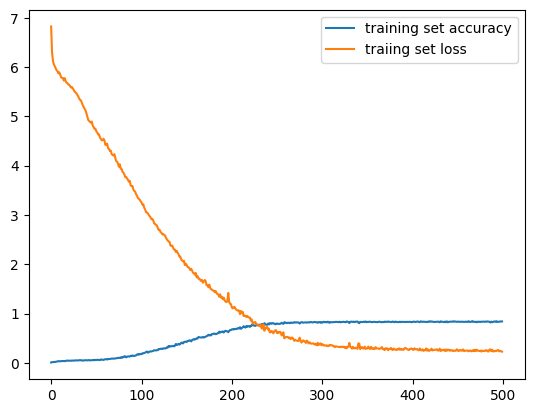

In [ ]:
# Plotting akurasi
import matplotlib.pyplot as plt
plt.plot(train.history["accuracy"], label= "training set accuracy")
plt.plot(train.history["loss"], label= "traiing set loss" )
plt.legend()

In [ ]:
# model_lstm.predict(['hukumq'])

In [ ]:
# model_lstm.save('model_chatbot')

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import pickle
le_filename = open("label_encoder.pickle", "wb")
pickle.dump(le, le_filename)
le_filename.close()

In [ ]:
# import library
import json
from string import punctuation
import random
import pickle
from tensorflow.keras.models import load_model

import requests
url = "https://solar-virtue-398102-default-rtdb.firebaseio.com/intents.json"
response = requests.get(url)
data = json.loads(response.text)

model = load_model('bot_model.tf')
le_filename = open("label_encoder.pickle", "rb")
le = pickle.load(le_filename)
le_filename.close()

def preprocess_string(string):
    string = string.lower()
    exclude = set(punctuation)
    string = ''.join(ch for ch in string if ch not in exclude)
    return string

def chat(model):
    print("Anda akan dihubungkan ke bot kami, mohon ditunggu")
    exit = False
    while not exit:
        inp = input("Anda : ")
        inp = preprocess_string(inp)
        prob = model.predict([inp])
        results = le.classes_[prob.argmax()]
        # print(f"results: {le.classes_}")
        print(f"results: {results}")
        if prob.argmax() == 68  and (prob.max() == 0.9908265471458435 or prob.max() == 0.9750761985778809):
            print(random.choice(["Waduh kayaknya pertanyaan anda blom ada di database saya, atau mungkin pertanyan anda kurang saya pahami", "Maaf, sepertinya saya blom belajar tentang itu, , atau mungkin pertanyan anda kurang lengkap"]))
            print(f"Probability: {prob.max()}")
            print(f"prob: {prob.argmax()}")
        else:
            for tg in data:
                if tg['tag'] == results:
                    responses = tg['responses']
            if results == '':
                exit = True
                print("END CHAT")
            print(f"Bot : {random.choice(responses)}")
            print(f"Probability: {prob.max()}")
            print(f"prob: {prob.argmax()}")


if __name__ == "__main__":
    chat(model)

Anda akan dihubungkan ke bot kami, mohon ditunggu
Anda : saat ini perkiraan cuaca bagaimana?
1/1 [==============================] - 2s 2s/step
results: 21
Bot : 
 Penyidik adalah pejabat polisi negara Republik Indonesia atau pejabat pegawai negeri sipil tertentu yang diberi wewenang khusus oleh undang-undang untuk melakukan penyidikan. 
Probability: 0.7707552909851074
prob: 124
Anda : bagaimana perkiraan cuaca saat ini?
1/1 [==============================] - 0s 35ms/step
results: 8
Bot : Saya berharap bisa menjawab pertanyaan anda, tapi sayangnya saya tidak bisa menjawab anda. Karena saya tidak memmiliki akses langsung ke database cuaca secara realtime.
Probability: 0.9999712705612183
prob: 778


KeyboardInterrupt: ignored

In [ ]:
print(f"results: {le.classes_}")

In [ ]:
model_lstm.summary()

In [ ]:
# import json
# from string import punctuation
# import random
# import pickle
# import tensorflow as tf

# # Ganti path model TFLite
# model_path = "/content/model/model.tflite"

# # Muat model TFLite
# interpreter = tf.lite.Interpreter(model_path=model_path)
# interpreter.allocate_tensors()

# le_filename = open("label_encoder.pickle", "rb")
# le = pickle.load(le_filename)
# le_filename.close()

# def preprocess_string(string):
#     string = string.lower()
#     exclude = set(punctuation)
#     string = ''.join(ch for ch in string if ch not in exclude)
#     return string

# def chat(interpreter, le, data):
#     print("Anda akan dihubungkan ke bot kami, mohon ditunggu")
#     exit = False
#     while not exit:
#         inp = input("Anda : ")
#         inp = preprocess_string(inp)

#         print(inp)

#         # Proses inferensi dengan model TFLite
#         input_data = tf.convert_to_tensor(padded_sequence, dtype=tf.float32)
#         interpreter.set_tensor(input_details[0]['index'], input_data)
#         interpreter.invoke()
#         prob = interpreter.get_tensor(output_details[0]['index'])

#         results = le.classes_[prob.argmax()]
#         if prob.max() < 0.2:
#             print(random.choice(["Waduh kayaknya pertanyaan anda blom ada di database saya", "Maaf, sepertinya saya blom belajar tentang itu."]))
#             print(f"Probability: {prob.max()}")
#         else:
#             for tg in data['intents']:
#                 if tg['tag'] == results:
#                     responses = tg['responses']
#             if results == '':
#                 exit = True
#                 print("END CHAT")
#             print(f"Bot : {random.choice(responses)}")
#             print(f"Probability: {prob.max()}")

# if __name__ == "__main__":
#     # Dapatkan detail input dan output tensor setelah alokasi tensor
#     input_details = interpreter.get_input_details()
#     output_details = interpreter.get_output_details()

#     # Panggil fungsi chat dengan model TFLite, label encoder, dan data intents
#     chat(interpreter, le, data)

In [ ]:
# !saved_model_cli show --dir /tmp/mobilenet/1 \
#                       --tag_set serve \
#                       --signature_def serving_default

In [ ]:
# # import library
# import json
# from string import punctuation
# import random
# import pickle
# from tensorflow.keras.models import load_model

In [ ]:
# import requests
# response = requests.get("https://solar-virtue-398102-default-rtdb.firebaseio.com/content.json")
# data = response.json()

In [ ]:
# with open("content.json") as data_file:
#      data = json.load(data_file)

In [ ]:
# %%writefile content.json
# {
#   "intents": [
#     {
#       "tag": "0",
#       "patterns": [
#         "Halo",
#         "hello",
#         "helo",
#         "hallo",
#         "Hi",
#         "Selamat Pagi",
#         "Selamat Siang",
#         "Selamat Malam",
#         "Salam",
#         "Assalamualaikum",
#         "Mari kita berbicara",
#         "Salam kenal",
#         "Hai, kawan!",
#         "Hai, sobat!",
#         "Salam sejahtera",
#         "p",
#         "oi",
#         "oy",
#         "spada",
#         "uy",
#         "."
#       ],
#       "responses": [
#         "Halo",
#         "Selamat datang",
#         "Apa yang bisa saya bantu?",
#         "Ada yang perlu diobrolkan?",
#         "Waalaikumusslaam",
#         "Mari kita berbicara",
#         "Salam kenal",
#         "Hai",
#         "Hai, kawan!",
#         "Hai, sobat!",
#         "Halo!",
#         "Apa yang bisa saya bantu untukmu?"
#       ]
#     },
#     {
#       "tag": "1",
#       "patterns": [
#         "terima kasih",
#         "terimakasih",
#         "terimakasih banyak",
#         "makasih",
#         "dadah",
#         "Dah",
#         "Daah",
#         "adios",
#         "okay",
#         "oke",
#         "Selamat Tinggal",
#         "Terima kasih atas waktu dan perhatiannya.",
#         "bye"
#       ],
#       "responses": [
#         "Senang bisa membantu!",
#         "Semoga kita bisa berinteraksi lagi di lain waktu.",
#         "Sampai jumpa, semoga harimu menyenangkan!",
#         "Adios! Hasta luego.",
#         "semoga bermanfaat.",
#         "yoi",
#         "bye",
#         "dadah",
#         "bye, hiks"
#       ]
#     },
#     {
#       "tag": "2",
#       "patterns": [
#         "apa itu HukumQ ?",
#         "Apa yang dimaksud dengan HukumQ?",
#         "Bisakah Anda menjelaskan apa itu HukumQ?",
#         "HukumQ itu apa?",
#         "Apa definisi HukumQ?",
#         "Apa HukumQ?",
#         "HukumQ",
#         "HukumQ arti",
#         "Tolong jelaskan HukumQ.",
#         "Apakah Anda bisa memberikan definisi singkat tentang HukumQ?",
#         "Jelaskan HukumQ",
#         "Jelaskan apa itu HukumQ",
#         "apa itu hukum Q",
#       ],
#       "responses": [
#         "HukumQ adalah aplikasi yang memberikan jawaban terkait pertanyaan hukum tertulis di Indonesia.",
#         "HukumQ adalah aplikasi yang fokus memberikan jawaban terkait pertanyaan hukum tertulis di Indonesia",
#         "Hmm, terdengar seperti nama saya. Kalo benar berarti itu adalah aplikasi chatbot yang dibuat oleh peserta Kampus Merdeka Bangkit 2023 batch 2. aplikasi ini dibuat agar bisa menjelaskan hukum tertulis di indonesia.",
#         "HukumQ adalah aplikasi yang bisa menjawab pertanyaan tentang hukum tertulis di indonesia. Belum semua hukum tertulis sih, hanya sebagian pada bidang yang kecil, karena saya masih dalam versi pengembangan."
#       ]
#     },
#     {
#       "tag": "3",
#       "patterns": [
#         "Kamu siapa ?",
#         "Bisa kenalan nggak?",
#         "Identitas kamu apa?",
#         "Boleh tahu siapa kamu?",
#         "Kamu punya nama?",
#         "Sebutkan siapa diri kamu.",
#         "Siapakah yang sedang berbicara?",
#         "Apakah kamu bisa memperkenalkan diri?",
#         "Nama panggilan kamu apa?",
#         "Siapa yang,sedang online di sini?",
#         "Tolong perkenalkan dirimu.",
#         "Nama?",
#         "siapa?",
#         "Nama mu",
#         "NamaMu",
#         "apa nama apikasi ini?"
#       ],
#       "responses": [
#         "Saya adalah HukumQ",
#         "aplikasi yang dibangun untuk membantu memahami hukum tertulis tertulis di indonesia, HukumQ",
#         "Saya merupakan HukumQ",
#         "HukumQ, platform untuk menjawab pertanyaan seputar hukum di Indonesia.",
#         "HukumQ di sini",
#         "HukumQ hadir untuk mempermudah pemahaman hukum tertulis di Indonesia.",
#         "Saya adalah HukumQ, solusi untuk pertanyaan-pertanyaan hukum Anda.",
#         "HukumQ hadir sebagai panduan hukum online di Indonesia.",
#         "Saya adalah HukumQ, platform pintar untuk memahami peraturan hukum di Indonesia.",
#         "HukumQ di sini untuk menjawab pertanyaan hukum Anda",
#         "Saya adalah HukumQ, sahabat untuk menjelaskan hukum tertulis Indonesia.",
#         "HukumQ",
#         "Chatbot HukumQ",
#         "Sebenarnya nama saya adalah HukumQ, tapi mungkin dalam konteks chat ini lebih tepat HukumMU deh"
#       ]
#     },
#     {
#       "tag": "4",
#       "patterns": [
#         "bagaimana kabarmu?",
#         "apa kabar",
#         "apakah kamu baik?",
#         "kabarmu bagaimana",
#         "kabarmu apa"
#       ],
#       "responses": [
#         "kabar saya baik, bagaimana dengan mu?",
#         "kabar saya baik, ada yang bisa saya bantu?"
#       ]
#     },
#     {
#       "tag": "5",
#       "patterns": [
#         "saya baik",
#         "alhamdulillah",
#         "saya luar biasa",
#         "saya gembira",
#         "baik juga"
#       ],
#       "responses": [
#         "syukur lah, ada yang bisa saya bantu?"
#       ]
#     },
#     {
#       "tag": "6",
#       "patterns": [
#         "ada",
#         "saya memerlukan bantuan anda",
#         "saya perlu bantuan",
#         "bisakah saya minta tolong",
#         "tolong bantu saya"
#       ],
#       "responses": [
#         "tentu saya akan membantu semampu saya, silahkan sebutkan pertanyaan anda"
#       ]
#     },
#     {
#       "tag": "7",
#       "patterns": [
#         "apa kemampuan hukumQ",
#         "HukumQ bisa apa saja",
#         "apa yang bisa dilakukan hukumQ",
#         "dimana batas hukumQ",
#         "HUKUMQ kekuatanya apa?",
#         "apa kelebihan hukumQ"
#       ],
#       "responses": [
#         "Saat ini saya (HukumQ), bisa menjawab penjelasan hukum tertulis tentang praperadilan di indonesia dan sebagian kecil tentang hukum tertulis di Indonesia"
#       ]
#     },
#     {
#       "tag": "8",
#       "patterns": [
#         "bagaimana cuaca saat ini",
#         "cuaca saat ini bagaimana",
#         "apakah sekarang hujan",
#         "apakah hari ini cerah",
#         "apa sekarang hujan",
#         "bagaimana perkiraan cuaca saat ini?",
#         "cuaca"
#       ],
#       "responses": [
#         "Saya berharap bisa menjawab pertanyaan anda, tapi sayangnya saya tidak bisa menjawab anda. Karena saya tidak memmiliki akses langsung ke database cuaca secara realtime.",
#         "Bencana besar!, saya tidak bisa menjawab pertanyaan itu karena saya hanya bisa menjawab pertanyaan tentang hukum tertulis di indonesia dan saat ini fokus ke praperadilan di indonesia."
#       ]
#     },
#     {
#       "tag": "9",
#       "patterns": [
#         "hukumk",
#         "hukumku",
#         "apa itu hukumku",
#         "hukumk itu apa",
#         "apa fungsi hukumku",
#         "apa kelebihan hukumk"
#       ],
#       "responses": [
#         "Aduh... sepertinya anda salah mengeja nama saya. Nama saya HukumQ pake 'Q",
#         "HukumQ kali kak."
#       ]
#     },
#     {
#       "tag": "10",
#       "patterns": [
#         "lagi",
#         "sebutkan lagi",
#         "apa lagi",
#         "teruskan",
#         "lanjutkan",
#         "lanjut"
#       ],
#       "responses": [
#         "apa yang dilanjutkan kak?"
#       ]
#     },
#     {
#       "tag": "11",
#       "patterns": [
#         "yang tadi?",
#         "yang di atas",
#         "sebelumnya",
#         "yang sebelumnya saya sebutkan",
#         "pertanyaan sebelumnya",
#         "lanjut"
#       ],
#       "responses": [
#         "Maaf kak, kayaknya pertanyaan kakak kurang lengkap deh, saya kurang paham maksud kakak"
#       ]
#     },
#     {
#       "tag": "12",
#       "patterns": [
#         "apa itu hukum",
#         "hukum",
#         "pengertian hukum",
#         "maksud hukum",
#         "defenisi hukum"
#       ],
#       "responses": [
#         "Hukum adalah undang-undang yang dibuat dan ditegakkan melalui lembaga sosial atau pemerintah untuk mengatur perilaku masyarakat."
#       ]
#     },
#     {
#       "tag": "13",
#       "patterns": [
#         "Apa itu Praperadilan?",
#         "Definisi Praperadilan",
#         "praperadilan",
#         "pengertian praperadilan",
#         "Apa yang dimaksud dengan praperadilan?",
#         "Apa yang dapat diperiksa melalui praperadilan?"
#       ],
#       "responses": [
#         "\nPraperadilan adalah proses hukum yang memberikan wewenang kepada pengadilan untuk memeriksa keabsahan suatu penangkapan, penahanan, penghentian penyidikan, atau penghentian penuntutan sebelum kasus itu diajukan ke pengadilan pidana.\nTujuan Praperadilan adalah melindungi hak asasi manusia dan memastikan bahwa tindakan penegak hukum sesuai dengan ketentuan hukum yang berlaku.",
#         "\nPraperadilan adalah suatu proses hukum yang bertujuan untuk menguji keabsahan, keberlanjutan, atau kesesuaian suatu tindakan hukum yang dilakukan oleh penegak hukum sebelum perkara dibawa ke pengadilan. Praperadilan memberikan kesempatan kepada pihak yang dianggap menjadi korban tindakan hukum yang dianggap melanggar hak-haknya untuk mengajukan permohonan kepada pengadilan guna memeriksa dan menilai keabsahan atau keberlanjutan tindakan tersebut.\nTujuan dari praperadilan adalah melindungi hak-hak individu terhadap tindakan yang dianggap melanggar hak asasi manusia atau hukum lainnya sebelum masuk ke dalam proses pengadilan yang lebih lanjut. Praperadilan dapat diajukan terhadap berbagai tindakan hukum, seperti penangkapan, penahanan, penggeledahan, penyitaan, atau tindakan hukum lainnya yang dianggap merugikan hak-hak individu.\nProses praperadilan seringkali melibatkan pemeriksaan bukti-bukti dan argumen-argumen hukum untuk menentukan apakah tindakan hukum yang dilakukan oleh aparat hukum sesuai dengan ketentuan hukum yang berlaku. Jika praperadilan diterima, maka tindakan hukum tersebut dapat dinyatakan tidak sah atau harus dihentikan. Jika ditolak, perkara dapat melanjutkan ke proses pengadilan lebih lanjut. Praperadilan menjadi salah satu mekanisme penting dalam menjaga keadilan dan perlindungan hak asasi manusia dalam sistem hukum suatu negara.",
#         "\nPraperadilan adalah proses hukum yang memberikan kesempatan pada seseorang untuk mengajukan permohonan kepada pengadilan jika dia merasa hak-haknya dilanggar oleh tindakan hukum, seperti penangkapan atau penyitaan. Ini memungkinkan pengadilan untuk memeriksa keabsahan tindakan tersebut sebelum masuk ke proses pengadilan lebih lanjut. Praperadilan bertujuan melindungi hak-hak individu dari tindakan hukum yang mungkin tidak sesuai dengan hukum. Jika diterima, tindakan tersebut dapat dinyatakan tidak sah. Jika ditolak, perkara akan melanjutkan ke proses pengadilan berikutnya. Praperadilan membantu menjaga keadilan dan hak asasi manusia dalam sistem hukum.",
#         "\nPraperadilan adalah wewenang pengadilan negeri untuk memeriksa dan memutus menurut cara yang diatur dalam undang-undang ini, tentang: \n a.sah atau tidaknya suatu penangkapan dan atau penahanan atas permintaan tersangka atau keluarganya atau pihak lain atas kuasa tersangka;\n b.sah atau tidaknya penghentian penyidikan atau penghentian penuntutan atas permintaan demi tegaknya hukum dan keadilan;\n c.permintaan ganti kerugian atau rehabilitasi oleh tersangka atau keluarganya atau pihak lain atas kuasanya yang perkaranya tidak diajukan ke pengadilan."
#       ]
#     },
#     {
#       "tag": "14",
#       "patterns": [
#         "apa itu KUHAP?",
#         "apa kepanjangan dari KUHAP",
#         "KUHAP"
#       ],
#       "responses": [
#         "KUHAP adalah Kitab Undang-undang Hukum Acara Pidana yang merupakan salah satu dari sumber hukum tertulis di indonesia"
#       ]
#     },
#     {
#       "tag": "15",
#       "patterns": [
#         "berapa jumlah pasal dalam KUHAP",
#         "Jumlah Pasal KUHAP",
#         "Pasal KUHAP",
#         "berapa jumlah pasal dalam KUHP",
#         "Jumlah Pasal KUHP",
#         "Pasal KUHP"
#       ],
#       "responses": [
#         "Jumlah pasal dalam KUHAP adalah 22 Bab dan 286 pasal."
#       ]
#     },
#     {
#       "tag": "16",
#       "patterns": [
#         "berapa jumlah pasal yang membahas praperadilan",
#         "Pasal praperadilan",
#         "jumlah pasal praperadilan",
#         "apa saja pasal yang membahas tentang praperadilan?"
#       ],
#       "responses": [
#         "Pasal-pasal yang memuat praperadilan adalah pasal 77, pasal 78, pasal 79, pasal 80, pasal 81, pasal 82, pasal 83, pasal 95, pasal 97, dan pasal 124 dalam UNDANG-UNDANG REPUBLIK INDONESIA NOMOR 8 TAHUN 1981 "
#       ]
#     },
#     {
#       "tag": "17",
#       "patterns": [
#         "apa beda praperadilan dan pengadilan?",
#         "Bagaimana praperadilan berbeda dari persidangan?",
#         "apa yang membedakan praperadilan dan pengadilan?"
#       ],
#       "responses": [
#         "Perbedaan praperadilan dan peradilan terletak pada waktu pelaksanaannya. praperadilan dilaksanakan sebelum persidangan dimulai. Dimana praperadilan bertujuan untuk melindungi HAM warga negara indonesia dan dilakukan jika tersangka, terdakwa, atau pihak yang dirugikan terhadap proses penangkapan."
#       ]
#     },
#     {
#       "tag": "18",
#       "patterns": [
#         "apa saja yang bisa diajukan dalam praperadilan?",
#         "praperadilan mengajukan",
#         "pelanggaran yang bisa diajukan praperadilan"
#       ],
#       "responses": [
#         "Yang bisa diajukan dalam praperadilan adalah, sah atau tidaknya suatu penangkapan atau penahanan diajukan oleh tersangka, keluarga, atau kuasanya kepada ketua pengadilan negeri dengan menyebutkan alasannya."
#       ]
#     },
#     {
#       "tag": "19",
#       "patterns": [
#         "Siapa yang berhak mengajukan Praperadilan?",
#         "Proses pengajuan Praperadilan",
#         "Tahapan pengajuan praperadilan",
#         "Siapa yang dapat mengajukan Praperadilan?",
#         "Bagaimana proses awal pengajuan Praperadilan dimulai?",
#         "Apakah hanya tersangka yang dapat mengajukan Praperadilan?",
#         "Ke mana permohonan Praperadilan diajukan?",
#         "Apakah ada aturan tertentu terkait siapa yang dapat mengajukan Praperadilan?",
#         "Bagaimana Praperadilan melibatkan pihak yang dirugikan?",
#         "hak yang dilanggar",
#         "dirugikan",
#         "pihak yang dirugikan",
#         "Siapa pun yang merasa hak-haknya dilanggar, termasuk tersangka, terdakwa, atau pihak yang dirugikan, dapat mengajukan Praperadilan. Proses pengajuan Praperadilan dimulai dengan mengajukan permohonan ke pengadilan yang berwenang sesuai dengan peraturan perundang-undangan yang berlaku.",
#         "hak",
#         "berhak",
#         "mengajukan praperadilan"
#       ],
#       "responses": [
#         "\nSiapa pun yang merasa hak-haknya dilanggar, termasuk tersangka, terdakwa, atau pihak yang dirugikan, dapat mengajukan Praperadilan.\nProses pengajuan Praperadilan dimulai dengan mengajukan permohonan ke pengadilan yang berwenang sesuai dengan peraturan perundang-undangan yang berlaku."
#       ]
#     },
#     {
#       "tag": "20",
#       "patterns": [
#         "apa untungnya praperadilan?",
#         "untung praperadilan",
#         "fungsi praperadilan",
#         "praperadilan untuk apa",
#         "untuk praperadilan",
#         "praperadilan untuk apa sih?"
#       ],
#       "responses": [
#         "Praperadilan berfungsi untuk melindungi HAM dari warga negara indonesia."
#       ]
#     },
#     {
#       "tag": "21",
#       "patterns": [
#         "Penyidik",
#         "siapa penyidik?",
#         "siapa itu penyidik?",
#         "apa itu penyidik",
#         "siapa yang menyidiki"
#       ],
#       "responses": [
#         "\n Penyidik adalah pejabat polisi negara Republik Indonesia atau pejabat pegawai negeri sipil tertentu yang diberi wewenang khusus oleh undang-undang untuk melakukan penyidikan. "
#       ]
#     },
#     {
#       "tag": "22",
#       "patterns": [
#         "Penyidikan",
#         "apa penyidikan?",
#         "tindakan penyidikan?",
#         "apa itu penyidikan",
#         "maksud penyidikan"
#       ],
#       "responses": [
#         "\n Penyidikan adalah serangkaian tindakan penyidik dalam hal dan menurut cara yang diatur dalam undang-undang ini untuk mencari serta mengumpulkan bukti yang dengan bukti itu membuat terang tentang tindak pidana yang terjadi dan guna menemukan tersangkanya."
#       ]
#     },
#     {
#       "tag": "23",
#       "patterns": [
#         "Penyidik pembantu",
#         "apa penyidik pembantu?",
#         "siapa itu penyidik pembantu?",
#         "apa itu penyidik pembantu",
#         "maksud penyidik pembantu",
#         "definisi penyidik pembantu"
#       ],
#       "responses": [
#         "\nPenyidik pembantu adalah pejabat kepolisian negara Republik Indonesia yang karena diberi wewenang tertentu dapat melakukan tugas penyidikan yang diatur dalam undang-undang ini"
#       ]
#     },
#     {
#       "tag": "24",
#       "patterns": [
#         "Penyelidik",
#         "apa Penyelidik?",
#         "siapa itu Penyelidik?",
#         "apa itu Penyelidik",
#         "maksud Penyelidik",
#         "definisi Penyelidik"
#       ],
#       "responses": [
#         "\nPenyelidik adalah pejabat polisi negara Republik Indonesia yang diberi wewenang oleh undang-undang ini untuk melakukan penyelidikan."
#       ]
#     },
#     {
#       "tag": "25",
#       "patterns": [
#         "Penyelidikan",
#         "apa Penyelidikan?",
#         "tindakan Penyelidikan?",
#         "apa itu Penyelidikan",
#         "maksud Penyelidikan"
#       ],
#       "responses": [
#         "\n Penyelidikan adalah serangkaian tindakan penyelidik untuk mencari dan menemukan suatu peristiwa yang diduga sebagai tindak pidana guna menentukan dapat atau tidaknya dilakukan penyidikan menurut cara yang diatur dalam undang-undang ini."
#       ]
#     },
#     {
#       "tag": "26",
#       "patterns": [
#         "Jaksa",
#         "apa Jaksa?",
#         "siapa itu Jaksa?",
#         "apa itu Jaksa",
#         "maksud Jaksa",
#         "definisi Jaksa"
#       ],
#       "responses": [
#         "\nJaksa adalah pejabat yang diberi wewenang oleh undang-undang ini untuk bertindak sebagai penuntut umum serta melaksanakan putusan pengadilan yang telah memperoleh kekuatan hukum tetap"
#       ]
#     },
#     {
#       "tag": "27",
#       "patterns": [
#         "Penuntut umum",
#         "apa Penuntut umum?",
#         "siapa itu Penuntut umum?",
#         "apa itu Penuntut umum",
#         "maksud Penuntut umum",
#         "definisi Penuntut umum"
#       ],
#       "responses": [
#         "\n Penuntut umum adalah jaksa yang diberi wewenang oleh undang-undang ini untuk melakukan penuntutan dan melaksanakan penetapan hakim. "
#       ]
#     },
#     {
#       "tag": "28",
#       "patterns": [
#         "Penuntutan",
#         "apa Penuntutan?",
#         "siapa itu Penuntutan?",
#         "apa itu Penuntutan",
#         "maksud Penuntutan",
#         "definisi Penuntutan"
#       ],
#       "responses": [
#         "\n Penuntutan adalah tindakan penuntut umum untuk melimpahkan perkara pidana ke pengadilan negeri yang berwenang dalam hal dan menurut cara yang diatur dalam undang-undang ini dengan permintaan supaya diperiksa dan diputus oleh hakim di sidang pengadilan. "
#       ]
#     },
#     {
#       "tag": "29",
#       "patterns": [
#         "Hakim",
#         "apa Hakim?",
#         "siapa itu Hakim?",
#         "apa itu Hakim",
#         "maksud Hakim",
#         "definisi Hakim"
#       ],
#       "responses": [
#         "\n Hakim adalah pejabat peradilan negara yang diberi wewenang oleh undang-undang untuk mengadili."
#       ]
#     },
#     {
#       "tag": "30",
#       "patterns": [
#         "Mengadili",
#         "apa Mengadili?",
#         "siapa itu Mengadili?",
#         "apa itu Mengadili",
#         "maksud Mengadili",
#         "definisi Mengadili"
#       ],
#       "responses": [
#         "\n Mengadili adalah serangkaian tindakan hakim untuk menerima, memeriksa, dan memutus perkara pidana berdasarkan asas bebas, jujur, dan tidak memihak di sidang pengadilan dalam hal dan menurut cara yang diatur dalam undang-undang ini."
#       ]
#     },
#     {
#       "tag": "31",
#       "patterns": [
#         "Apa itu Putusan pengadilan?",
#         "Definisi Putusan pengadilan",
#         "Putusan pengadilan",
#         "pengertian Putusan pengadilan",
#         "Apa yang dimaksud dengan Putusan pengadilan?",
#         "Putusan pengadilan?"
#       ],
#       "responses": [
#         "\nPutusan pengadilan adalah pernyataan hakim yang diucapkan dalam sidang pengadilan terbuka, yang dapat berupa pemidanaan atau bebas atau lepas dan segala tuntutan hukum dalam hal serta menurut cara yang diatur dalam undang-undang ini."
#       ]
#     },
#     {
#       "tag": "32",
#       "patterns": [
#         "Apa itu Upaya hukum?",
#         "Definisi Upaya hukum",
#         "Upaya hukum",
#         "pengertian Upaya hukum",
#         "Apa yang dimaksud dengan Upaya hukum?",
#         "upaya"
#       ],
#       "responses": [
#         "\nUpaya hukum adalah hak terdakwa atau penuntut umum untuk tidak menerima putusan pengadilan yang berupa perlawanan atau banding atau kasasi atau hak terpidana untuk mengajukan permohonan peninjauan kembali dalam hal serta menurut cara yang diatur dalam undang-undang ini."
#       ]
#     },
#     {
#       "tag": "33",
#       "patterns": [
#         "Penasihat hukum",
#         "apa Penasihat hukum?",
#         "siapa itu Penasihat hukum?",
#         "apa itu Penasihat hukum",
#         "maksud Penasihat hukum",
#         "definisi Penasihat hukum",
#         "penasihat"
#       ],
#       "responses": [
#         "\nPenasihat hukum adalah seorang yang memenuhi syarat yang ditentukan oleh atau berdasarkan undang-undang untuk memberi bantuan hukum."
#       ]
#     },
#     {
#       "tag": "34",
#       "patterns": [
#         "Tersangka",
#         "apa Tersangka?",
#         "siapa itu Tersangka?",
#         "apa itu Tersangka",
#         "maksud Tersangka",
#         "definisi Tersangka"
#       ],
#       "responses": [
#         "\n Tersangka adalah seorang yang karena perbuatannya atau keadaannya berdasarkan bukti permulaan patut diduga sebagai pelaku tindak pidana. "
#       ]
#     },
#     {
#       "tag": "35",
#       "patterns": [
#         "Terdakwa",
#         "apa Terdakwa?",
#         "siapa itu Terdakwa?",
#         "apa itu Terdakwa",
#         "maksud Terdakwa",
#         "definisi Terdakwa"
#       ],
#       "responses": [
#         "\n Terdakwa adalah seorang tersangka yang dituntut, diperiksa dan diadili di sidang pengadilan."
#       ]
#     },
#     {
#       "tag": "36",
#       "patterns": [
#         "Apa itu Penyitaan?",
#         "Definisi Penyitaan",
#         "Penyitaan",
#         "pengertian Penyitaan",
#         "Apa yang dimaksud dengan Penyitaan?"
#       ],
#       "responses": [
#         "\nPenyitaan adalah serangkaian tindakan penyidik untuk mengambil alih dan atau menyimpan di bawah penguasaannya benda bergerak atau tidak bergerak, berwujud atau tidak berwujud untuk kepentingan pembuktian dalam penyidikan, penuntutan dan peradilan."
#       ]
#     },
#     {
#       "tag": "37",
#       "patterns": [
#         "Apa itu Penggeledahan rumah?",
#         "Definisi Penggeledahan rumah",
#         "Penggeledahan rumah",
#         "pengertian Penggeledahan rumah",
#         "Apa yang dimaksud dengan Penggeledahan rumah?"
#       ],
#       "responses": [
#         "\nPenggeledahan rumah adalah tindakan penyidik untuk memasuki rumah tempat tinggal dan tempat tertutup Iainnya untuk melakukan tindakan pemeriksaan dan atau penyitaan dan atau penangkapan dalam hal dan menurut cara yang diatur dalam undang-undang."
#       ]
#     },
#     {
#       "tag": "38",
#       "patterns": [
#         "Apa itu Penggeledahan badan?",
#         "Definisi Penggeledahan badan",
#         "Penggeledahan badan",
#         "pengertian Penggeledahan badan",
#         "Apa yang dimaksud dengan Penggeledahan badan?"
#       ],
#       "responses": [
#         "\nPenggeledahan badan adalah tindakan penyidik untuk mengadakan pemeriksaan badan dan atau pakaian tersangka untuk mencari benda yang diduga keras ada pada badannya atau dibawanya serta, untuk disita. "
#       ]
#     },
#     {
#       "tag": "39",
#       "patterns": [
#         "Apa itu Tertangkap tangan?",
#         "Definisi Tertangkap tangan",
#         "Tertangkap tangan",
#         "pengertian Tertangkap tangan",
#         "Apa yang dimaksud dengan Tertangkap tangan?"
#       ],
#       "responses": [
#         "\nTertangkap tangan adalah tertangkapnya seorang pada waktu sedang melakukan tindak pidana, atau dengan segera sesudah beberapa saat tindak pidana itu dilakukan, atau sesaat kemudian diserukan oleh khalayak ramai sebagai orang yang melakukannya, atau apabila sesaat kemudian padanya ditemukan benda yang diduga keras telah dipergunakan untuk melakukan tindak pidana itu yang menunjukkan bahwa ia adalah pelakunya atau turut melakukan atau membantu melakukan tindak pidana itu."
#       ]
#     },
#     {
#       "tag": "40",
#       "patterns": [
#         "Apa itu Penangkapan?",
#         "Definisi Penangkapan",
#         "Penangkapan",
#         "Penagkapan",
#         "pengertian Penangkapan",
#         "Apa yang dimaksud dengan Penangkapan?"
#       ],
#       "responses": [
#         "\nPenangkapan adalah suatu tindakan penyidik berupa pengekangan sementara waktu kebebasan tersangka atau terdakwa apabila terdapat cukup bukti guna kepentingan penyidikan atau penuntutan dan atau peradilan dalam hal serta menurut cara yang diatur dalam undang-undang ini."
#       ]
#     },
#     {
#       "tag": "41",
#       "patterns": [
#         "Apa itu Penahanan?",
#         "Definisi Penahanan",
#         "Penahanan",
#         "pengertian Penahanan",
#         "Apa yang dimaksud dengan Penahanan?"
#       ],
#       "responses": [
#         "\nPenahanan adalah penempatan tersangka atau terdakwa di tempat tertentu oleh penyidik atau penuntut umum atau hakim dengan penetapannya, dalam hal serta menurut cara yang diatur dalam undang-undang ini."
#       ]
#     },
#     {
#       "tag": "42",
#       "patterns": [
#         "Apa itu Ganti kerugian?",
#         "Definisi Ganti kerugian",
#         "Ganti kerugian",
#         "pengertian Ganti kerugian",
#         "Apa yang dimaksud dengan Ganti kerugian?",
#         "rugi",
#         "ganti rugi",
#         "ganti kerugian"
#       ],
#       "responses": [
#         "\nGanti kerugian adalah hak seorang untuk mendapat pemenuhan atas tuntutannya yang berupa imbalan sejumlah uang karena ditangkap, ditahan, dituntut ataupun diadili tanpa alasan yang berdasarkan undang-undang atau karena kekeliruan mengenai orangnya atau hukum yang diterapkan menurut cara yang diatur dalam undang-undang ini."
#       ]
#     },
#     {
#       "tag": "43",
#       "patterns": [
#         "Apa itu Rehabilitasi?",
#         "Definisi Rehabilitasi",
#         "Rehabilitasi",
#         "pengertian Rehabilitasi",
#         "Apa yang dimaksud dengan Rehabilitasi?",
#         "rehabilitasi",
#         "pemulihan",
#         "kerugian mental",
#         "pemulihan hanya dalam kemampuan, kedudukan dan harkat serta martabatnya",
#         "kedudukan",
#         "harkat martabat",
#         "harkatmartabat"
#       ],
#       "responses": [
#         "\nRehabilitasi adalah hak seorang untuk mendapat pemulihan hanya dalam kemampuan, kedudukan dan harkat serta martabatnya yang diberikan pada tingkat penyidikan, penuntutan atau peradilan karena ditangkap, ditahan, dituntut ataupun diadili tanpa alasan yang berdasarkan undang-undang atau karena kekeliruan mengenai orangnya atau hukum yang diterapkan menurut cara yang diatur dalam undang-undang ini."
#       ]
#     },
#     {
#       "tag": "44",
#       "patterns": [
#         "Apa itu Laporan?",
#         "Definisi Laporan",
#         "Laporan",
#         "pengertian Laporan",
#         "Apa yang dimaksud dengan Laporan?"
#       ],
#       "responses": [
#         "\nLaporan adalah pemberitahuan yang disampaikan oleh seorang karena hak atau kewajiban berdasarkan undang-undang kepada pejabat yang berwenang tentang telah atau sedang atau diduga akan terjadinya peristiwa pidana."
#       ]
#     },
#     {
#       "tag": "45",
#       "patterns": [
#         "Apa itu Pengaduan?",
#         "Definisi Pengaduan",
#         "Pengaduan",
#         "pengertian Pengaduan",
#         "Apa yang dimaksud dengan Pengaduan?"
#       ],
#       "responses": [
#         "\nPengaduan adalah pemberitahuan disertai permintaan oleh pihak yang berkepentingan kepada pejabat yang berwenang untuk menindak menurut hukum seorang yang telah melakukan tindak pidana aduan yang merugikannya."
#       ]
#     },
#     {
#       "tag": "46",
#       "patterns": [
#         "Apa itu Saksi?",
#         "Definisi Saksi",
#         "Saksi",
#         "pengertian Saksi",
#         "Apa yang dimaksud dengan Saksi?"
#       ],
#       "responses": [
#         "\nSaksi adalah orang yang dapat memberikan keterangan guna kepentingan penyidikan, penuntutan dan peradilan tentang suatu perkara pidana yang ia dengar sendiri, ia Iihat sendiri dan ia alami sendiri."
#       ]
#     },
#     {
#       "tag": "47",
#       "patterns": [
#         "Apa itu Keterangan saksi?",
#         "Definisi Keterangan saksi",
#         "Keterangan saksi",
#         "pengertian Keterangan saksi",
#         "Apa yang dimaksud dengan Keterangan saksi?",
#         "keterangan"
#       ],
#       "responses": [
#         "\nKeterangan saksi adalah salah satu alat bukti dalam perkara pidana yang berupa keterangan dari saksi mengenai suatu peristiwa pidana yang ia dengar sendiri, Ia lihat sendiri dan ia alami sendiri dengan menyebut alasan dan pengetahuannya itu. "
#       ]
#     },
#     {
#       "tag": "48",
#       "patterns": [
#         "Apa itu Keterangan ahli?",
#         "Definisi Keterangan ahli",
#         "Keterangan ahli",
#         "pengertian Keterangan ahli",
#         "Apa yang dimaksud dengan Keterangan ahli?",
#         "keterangan"
#       ],
#       "responses": [
#         "\nKeterangan ahli adalah keterangan yang diberikan oleh seorang yang memiliki keahlian khusus tentang hal yang diperlukan untuk membuat terang suatu perkara pidana guna kepentingan pemeriksaan"
#       ]
#     },
#     {
#       "tag": "49",
#       "patterns": [
#         "Apa itu Keterangan anak?",
#         "Definisi Keterangan anak",
#         "Keterangan anak",
#         "pengertian Keterangan anak",
#         "Apa yang dimaksud dengan Keterangan anak?"
#       ],
#       "responses": [
#         "\nKeterangan anak adalah keterangan yang diberikan oleh seorang anak tentang hal yang diperlukan untuk membuat terang suatu perkara pidana guna kepentingan pemeriksaan dalam hal serta menurut cara yang diatur dalam undang-undang ini."
#       ]
#     },
#     {
#       "tag": "50",
#       "patterns": [
#         "Apa itu Keluarga?",
#         "Definisi Keluarga",
#         "Keluarga",
#         "pengertian Keluarga",
#         "Apa yang dimaksud dengan Keluarga?"
#       ],
#       "responses": [
#         "\nKeluarga adalah mereka yang mempunyai hubungan darah sampai derajat tertentu atau hubungan perkawinan dengan mereka yang terlibat dalam suatu proses pidana sebagaimana diatur dalam undang-undang ini."
#       ]
#     },
#     {
#       "tag": "51",
#       "patterns": [
#         "Apa itu Satu hari?",
#         "Definisi Satu hari",
#         "Satu hari",
#         "pengertian Satu hari",
#         "Apa yang dimaksud dengan Satu hari?"
#       ],
#       "responses": [
#         "\nSatu hari adalah dua puluh empat jam dan satu bulan adalah waktu tiga puluh hari."
#       ]
#     },
#     {
#       "tag": "52",
#       "patterns": [
#         "Apa itu Terpidana?",
#         "Definisi Terpidana",
#         "Terpidana",
#         "pengertian Terpidana",
#         "Apa yang dimaksud dengan Terpidana?"
#       ],
#       "responses": [
#         "\nTerpidana adalah seorang yang dipidana berdasarkan putusan pengadilan yang telah memperoleh kekuatan hukum tetap."
#       ]
#     },
#     {
#       "tag": "60",
#       "patterns": [
#         "pasal 1 KUHAP",
#         "bunyi pasal 1 KUHAP",
#         "KUHAP pasal 1",
#         "dasar hukum tentang penyidik",
#         "aturan yang mengatur penyidik"
#       ],
#       "responses": [
#         "\nPasal 1 \nYang dimaksud dalam undang-undang ini dengan:\n1. Penyidik adalah pejabat polisi negara Republik Indonesia atau pejabat pegawai negeri sipil tertentu yang diberi wewenang khusus oleh undang-undang untuk melakukan penyidikan;\n2. Penyidikan adalah serangkaian tindakan penyidik dalam hal dan menurut cara yang diatur dalam undang-undang ini untuk mencari serta mengumpulkan bukti yang dengan bukti itu membuat terang tentang tindak pidana yang terjadi dan guna menemukan tersangkanya; \n3. Penyidik pembantu adalah pejabat kepolisian negara Republik Indonesia yang karena diberi wewenang tertentu dapat melakukan tugas penyidikan yang diatur dalam undang-undang ini; \n4. Penyelidik adalah pejabat polisi negara Republik Indonesia yang diberi wewenang oleh undang-undang ini untuk melakukan penyelidikan;\n5. Penyelidikan adalah serangkaian tindakan penyelidik untuk mencari dan menemukan suatu peristiwa yang diduga sebagai tindak pidana guna menentukan dapat atau tidaknya dilakukan penyidikan menurut cara yang diatur dalam undang-undang ini;\n6. a. Jaksa adalah pejabat yang diberi wewenang oleh undang-undang ini untuk bertindak sebagai penuntut umum serta melaksanakan putusan pengadilan yang telah memperoleh kekuatan hukum tetap;\n   b. Penuntut umum adalah jaksa yang diberi wewenang oleh undang-undang ini untuk melakukan penuntutan dan melaksanakan penetapan hakim.\n7. Penuntutan adalah tindakan penuntut umum untuk melimpahkan perkara pidana ke pengadilan negeri yang berwenang dalam hal dan menurut cara yang diatur dalam undang-undang ini dengan permintaan supaya diperiksa dan diputus oleh hakim di sidang pengadilan;\n8. Hakim adalah pejabat peradilan negara yang diberi wewenang oleh undang-undang untuk mengadili;\n9. Mengadili adalah serangkaian tindakan hakim untuk menerima, memeriksa dan memutus perkara pidana berdasarkan asas bebas, jujur, dan tidak memihak di sidang pengadilan dalam hal dan menurut cara yang diatur dalam undang-undang ini;\n10. Praperadilan adalah wewenang pengadilan negeri untuk memeriksa dan memutus menurut cara yang diatur dalam undang-undang ini, tentang:\n  a. sah atau tidaknya suatu penangkapan dan atau penahanan atas permintaan tersangka atau keluarganya atau pihak lain atas kuasa tersangka;\n  b. sah atau tidaknya penghentian penyidikan atau penghentian penuntutan atas permintaan demi tegaknya hukum dan keadilan;\n  c. permintaan ganti kerugian atau rehabilitasi oleh tersangka atau keluarganya atau pihak lain atas kuasanya yang perkaranya tidak diajukan ke pengadilan.\n11. Putusan pengadilan adalah pernyataan hakim yang diucapkan dalam sidang pengadilan terbuka, yang dapat berupa pemidanaan atau bebas atau lepas dari segala tuntutan hukum dalam hal serta menurut cara yang diatur dalam undang-undang ini;\n12. Upaya hukum adalah hak terdakwa atau penuntut umum untuk tidak menerima putusan pengadilan yang berupa perlawanan atau banding atau kasasi atau hak terpidana untuk mengajukan permohonan peninjauan kembali dalam hal serta menurut cara yang diatur dalam undang-undang ini;\n13. Penasihat hukum adalah seorang yang memenuhi syarat yang ditentukan oleh atau berdasar undang-undang untuk memberi bantuan hukum;\n14. Tersangka adalah seorang yang karena perbuatannya atau keadaannya, berdasarkan bukti permulaan patut diduga sebagai pelaku tindak pidana;\n15. Terdakwa adalah seorang tersangka yang dituntut, diperiksa dan diadili di sidang pengadilan;\n16. Penyitaan adalah serangkaian tindakan penyidik untuk mengambil alih dan atau menyimpan di bawah penguasaannya benda bergerak atau tidak bergerak, berwujud atau tidak berwujud untuk kepentingan pembuktian dalam penyidikan, penuntutan dan peradilan;\n17. Penggeledahan rumah adalah tindakan penyidik untuk memasuki rumah tempat tinggal dan tempat tertutup lainnya untuk melakukan tindakan pemeriksaan dan atau penyitaan dan atau penangkapan dalam hal dan menurut cara yang diatur dalam undang-undang ini;\n18. Penggeledahan badan adalah tindakan penyidik untuk mengadakan pemeriksaan badan dan atau pakaian tersangka untuk mencari benda yang didup keras ada pada badannya atau dibawanya serta, untuk disita;\n19. Tertangkap tangan adalah tertangkapnya seorang pada waktu sedang melakukan tindak pidana, atau dengan segera sesudah beberapa saat tindak pidana itu dilakukan, atau sesaat kemudian diserukan oleh khalayak ramai sebagai orang yang melakukannya, atau apabila sesaat kemudian padanya ditemukan benda yang diduga keras telah dipergunakan untuk melakukan tindak pidana itu yang menunjukkan bahwa ia adalah pelakunya atau turut melakukan atau membantu melakukan tindak pidana itu;\n20. Penangkapan adalah suatu tindakan penyidik berupa pengekangan sementara waktu kebebasan tersangka atau terdakwa apabila terdapat cukup bukti guna kepentingan penyidikan atau penuntutan dan atau dalam undang-undang ini;\n21. Penahanan adalah penempatan tersangka atau terdakwa di tempat tertentu oleh penyidik, atau penuntut umum atau hakim dengan penetapannya, dalam hal serta menurut cara yang diatur dalam undang-undang ini;\n22. Ganti kerugian adalah hak seorang untuk mendapat pemenuhan atas tuntutannya yang berupa imbalan sejumlah uang karena ditangkap, ditahan, dituntut ataupun diadili tanpa alasan yang berdasarkan undang-undang atau karena kekeliruan mengenai orangnya atau hukum yang diterapkan menurut cara yang diatur dalam undang-undang ini;\n23. Rehabilitasi adalah hak seorang untuk mendapat pemulihan haknya dalam kemampuan, kedudukan dan harkat serta martabatnya yang diberikan pada tingkat penyidikan, penuntutan atau peradilan karena ditangkap, ditahan, dituntut ataupun diadili tanpa alasan yang berdasarkan undang-undang atau karena kekeliruan mengenai orangnya atau hukum yang diterapkan menurut cara yang diatur dalam undang- undang ini;\n24. Laporan adalah pemberitahuan yang disampaikan oleh seorang karena hak atau kewajiban berdasarkan undang-undang kepada pejabat yang berwenang tentang telah atau sedang atau diduga akan terjadinya peristiwa pidana;\n25. Pengaduan adalah pemberitahuan disertai permintaan oleh pihak yang berkepentingan kepada pejabat yang berwenang untuk menindak menurut hukum seorang yang telah melakukan tindak pidana aduan yang merugikannya;\n26. Saksi adalah orang yang dapat memberikan keterangan guna kepentingan penyidikan, penuntutan dan peradilan tentang suatu perkara pidana yang ia dengar sendiri, ia lihat sendiri dan ia alami sendiri;\n27. Keterangan saksi adalah salah satu alat bukti dalam perkara pidana yang berupa keterangan dari saksi mengenai suatu peristiwa pidana yang ia dengar sendiri, ia lihat sendiri dan ia alami sendiri dengan menyebut alasan dari pengetahuannya itu;\n28. Keterangan ahli adalah keterangan yang diberikan oleh seorang yang memiliki keahlian khusus tentang hal yang diperlukan untuk membuat terang suatu perkara pidana guna kepentingan pemeriksaan;\n29. Keterangan anak adalah keterangan yang diberikan oleh seorang anak tentang hal yang diperlukan untuk membuat terang suatu perkara pidana guna kepentingan pemeriksaan dalam hal serta menurut cara yang diatur dalam undang-undang ini;\n30. Keluarga adalah mereka yang mempunyai hubungan darah sampai derajat tertentu atau hubungan perkawinan dengan mereka yang terlibat dalam suatu proses pidana sebagaimana diatur dalam undang-undang ini;\n31. Satu hari adalah dua puluh empat jam dan satu bulan adalah waktu tiga puluh hari;\n32. Terpidana adalah seorang yang dipidana berdasarkan putusan pengadilan yang telah memperoleh kekuatan hukum tetap."
#       ]
#     },
#     {
#       "tag": "62",
#       "patterns": [
#         "pasal 2 KUHAP",
#         "bunyi pasal 2 KUHAP",
#         "KUHAP pasal 2",
#         "ruang lingkup berlakunya undang undang NOMOR 8 TAHUN 1981",
#         "lingkup KUHAP",
#         "yang di atur KUHAP"
#       ],
#       "responses": [
#         "\nPasal 2 \nUndang-undang ini berlaku untuk melaksanakan tata cara peradilan dalam lingkungan semua tingkat peradilan."
#       ]
#     },
#     {
#       "tag": "64",
#       "patterns": [
#         "pasal 3 KUHAP",
#         "bunyi pasal 3 KUHAP",
#         "KUHAP pasal 3",
#         "dasar peradilan",
#         "lingkup KUHAP",
#         "yang di atur KUHAP"
#       ],
#       "responses": [
#         "\nPasal 3 \nPeradilan dilakukan menurut cara yang diatur dalam undang-undang ini."
#       ]
#     },
#     {
#       "tag": "66",
#       "patterns": [
#         "pasal 4 KUHAP",
#         "bunyi pasal 4 KUHAP",
#         "KUHAP pasal 4",
#         "PENYIDIK DAN PENUNTUT UMUM",
#         "penyelidik"
#       ],
#       "responses": [
#         "\nPasal 4 \nPenyelidik adalah setiap pejabat polisi negara Republik Indonesia."
#       ]
#     },
#     {
#       "tag": "67",
#       "patterns": [
#         "pasal 5 KUHAP",
#         "bunyi pasal 5 KUHAP",
#         "KUHAP pasal 5",
#         "hak dan wewenang penyelidik",
#         "penyelidik"
#       ],
#       "responses": [
#         "\nPasal 5 \n(1) Penyelidik sebagaimana dimaksud dalam Pasal 4:\n  a. karena kewajibannya mempunyai wewenang:\n    1. menerima laporan atau pengaduan dari seorang tentang adanya tindak pidana;\n    2. mencari keterangan dan barang bukti;\n    3. menyuruh berhenti seorang yang dicurigai dan menanyakan serta memeriksa tanda pengenal diri;\n    4. mengadakan tindakan lain menurut hukum yang bertanggung jawab.\n  b. atas perintah penyidik dapat melakukan tindakan berupa:\n    1. penangkapan, larangan meninggalkan tempat, penggeledahan dan penahanan;\n    2. pemeriksaan dan penyitaan surat;\n    3. mengambil sidik jari dan memotret seorang;\n    4. membawa dan menghadapkan seorang pada penyidik."
#       ]
#     },
#     {
#       "tag": "68",
#       "patterns": [
#         "pasal 5 KUHAP",
#         "bunyi pasal 5 KUHAP",
#         "KUHAP pasal 5 ayat 2",
#         "hak dan wewenang penyelidik",
#         "penyelidik"
#       ],
#       "responses": [
#         "\n(2) Penyelidik membuat dan menyampaikan laporan hasil pelaksanaan tindakan sebagaimana tersebut pada ayat (1) huruf a dan huruf b kepada penyidik"
#       ]
#     },
#     {
#       "tag": "69",
#       "patterns": [
#         "Penyidik",
#         "siapa penyidik?",
#         "siapa itu penyidik?",
#         "apa itu penyidik",
#         "siapa yang menyidiki",
#         "pasal 6 KUHAP",
#         "bunyi pasal 6 KUHAP",
#         "KUHAP pasal 6 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 6 \n(1) Penyidik adalah:\n  a. pejabat polisi negara Republik Indonesia;\n  b. pejabat pegawai negeri sipil tertentu yang diberi wewenang khusus oleh undang-undang."
#       ]
#     },
#     {
#       "tag": "70",
#       "patterns": [
#         "bunyi pasal 6 ayat 2 KUHAP",
#         "KUHAP pasal 6 ayat 2",
#         "kepangkatan penjabat"
#       ],
#       "responses": [
#         "\n(2) Syarat kepangkatan pejabat sebagaimana dimaksud dalam ayat (1) akan diatur lebih lanjut dalam peraturan pemerintah"
#       ]
#     },
#     {
#       "tag": "71",
#       "patterns": [
#         "bunyi pasal 7 ayat 1 KUHAP",
#         "KUHAP pasal 7 ayat 1",
#         "wewenang penyidik",
#         "wewenang karena kewajiban penyidik"
#       ],
#       "responses": [
#         "\nPasal 7\n(1) Penyidik sebagaimana dimaksud dalam Pasal 6 ayat (1) huruf a karena kewajibannya mempunyai wewenang:\n  a. menerima laporan atau pengaduan dari seorang tentang adanya tindak pidana;\n  b. melakukan tindakan pertama pada saat di tempat kejadian;\n  c. menyuruh berhenti seorang tersangka dan memeriksa tanda pengenal diri tersangka;\n  d. melakukan penangkapan, penahanan, penggeledahan dan penyitaan;\n  e. melakukan pemeriksaan dan penyitaan surat;\n  f. mengambil sidik jari dan memotret seorang;\n  g. memanggil orang untuk didengar dan diperiksa sebagai tersangka atau saksi;\n  h. mendatangkan orang ahli yang diperlukan dalam hubungannya dengan pemeriksaan perkara;\n  i. mengadakan penghentian penyidikan;\n  j. mengadakan tindakan lain menurut hukum yang bertanggung jawab."
#       ]
#     },
#     {
#       "tag": "72",
#       "patterns": [
#         "bunyi pasal 7 ayat 2 KUHAP",
#         "KUHAP pasal 7 ayat 2",
#         "dasar hukum penyidik",
#         "pelaksanaan penyidik berada di bawah koordinasi"
#       ],
#       "responses": [
#         "\n(2) Penyidik sebagaimana dimaksud dalam Pasal 6 ayat (1) huruf b mempunyai wewenang sesuai dengan undang-undang yang menjadi dasar hukumnya masing-masing dan dalam pelaksanaan tugasnya berada di bawah koordinasi dan pengawasan penyidik tersebut dalam Pasal 6 ayat (1) huruf a;"
#       ]
#     },
#     {
#       "tag": "73",
#       "patterns": [
#         "bunyi pasal 7 ayat 3 KUHAP",
#         "KUHAP pasal 7 ayat 3",
#         "kewajiabn penyidik",
#         "hukum terhadap penyidik"
#       ],
#       "responses": [
#         "\n(3) Dalam melakukan tugasnya sebagaimana dimaksud dalam ayat (1) dan ayat (2), penyidik wajib menjunjung tinggi hukum yang berlaku."
#       ]
#     },
#     {
#       "tag": "74",
#       "patterns": [
#         "bunyi pasal 8 ayat 1 KUHAP",
#         "KUHAP pasal 8 ayat 1",
#         "kewajiabn penyidik",
#         "jujur dalam laporan penyidik"
#       ],
#       "responses": [
#         "\nPasal 8\n(1) Penyidik membuat berita acara tentang pelaksanaan tindakan sebagaimana dimaksud dalam Pasal 75 dengan tidak mengurangi ketentuan lain dalam undang-undang ini;"
#       ]
#     },
#     {
#       "tag": "75",
#       "patterns": [
#         "bunyi pasal 8 ayat 2 KUHAP",
#         "KUHAP pasal 8 ayat 2",
#         "penyidik ke penuntut umum",
#         "berkas perkara penyidik ke penuntut umum"
#       ],
#       "responses": [
#         "\n(2) Penyidik menyerahkan berkas perkara kepada penuntut umum;"
#       ]
#     },
#     {
#       "tag": "76",
#       "patterns": [
#         "bunyi pasal 8 ayat 3 KUHAP",
#         "KUHAP pasal 8 ayat 3",
#         "penyidik ke penuntut umum",
#         "berkas perkara penyidik ke penuntut umum"
#       ],
#       "responses": [
#         "\n(3) Penyerahan berkas perkara sebagaimana dimaksud dalam ayat (2) dilakukan:\n  a. pada tahap pertama penyidik hanya menyerahkan berkas perkara;\n  b. dalam hal penyidikan sudah dianggap selesai, penyidik menyerahkan tanggung jawab atas tersangka dan barang bukti kepada penuntut umum."
#       ]
#     },
#     {
#       "tag": "77",
#       "patterns": [
#         "bunyi pasal 9 KUHAP",
#         "KUHAP pasal 9",
#         "wewenang penyidik dan penyelidik"
#       ],
#       "responses": [
#         "\nPasal 9 \nPenyelidik dan penyidik sebagaimana dimaksud dalam Pasal 6 ayat (1) huruf a mempunyai wewenang melakukan tugas masing-masing pada umumnya di seluruh wilayah Indonesia, khususnya di daerah hukum masing-masing di mana ia diangkat sesuai dengan ketentuan undang-undang."
#       ]
#     },
#     {
#       "tag": "78",
#       "patterns": [
#         "bunyi pasal 8 ayat 2 KUHAP",
#         "KUHAP pasal 8 ayat 2",
#         "penyidik ke penuntut umum",
#         "berkas perkara penyidik ke penuntut umum"
#       ],
#       "responses": [
#         "\nBagian Kedua \nPenyidik Pembantu"
#       ]
#     },
#     {
#       "tag": "79",
#       "patterns": [
#         "bunyi pasal 10 KUHAP",
#         "KUHAP pasal 10",
#         "penyidik pembantu"
#       ],
#       "responses": [
#         "\nPasal 10\n(1) Penyidik pembantu adalah pejabat kepolisian negara Republik Indonesia yang diangkat oleh Kepala Kepolisian negara Republik Indonesia berdasarkan syarat kepangkatan dalam ayat (2) pasal ini;"
#       ]
#     },
#     {
#       "tag": 26,
#       "patterns": [
#         "Pasal 10 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 10\n(1) Penyidik pembantu adalah pejabat kepolisian negara Republik Indonesia yang diangkat oleh Kepala Kepolisian negara Republik Indonesia berdasarkan syarat kepangkatan dalam ayat (2) pasal ini;"
#       ]
#     },
#     {
#       "tag": 27,
#       "patterns": [
#         "Pasal 10 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Syarat kepangkatan sebagaimana tersebut pada ayat (1) diatur dengan peraturan pemerintah."
#       ]
#     },
#     {
#       "tag": 28,
#       "patterns": [
#         "Pasal 11"
#       ],
#       "responses": [
#         "\nPasal 11\nPenyidik pembantu mempunyai wewenang seperti tersebut dalam Pasal 7 ayat (1), kecuali mengenai penahanan yang wajib diberikan dengan pelimpahan wewenang dari penyidik."
#       ]
#     },
#     {
#       "tag": 29,
#       "patterns": [
#         "Pasal 12"
#       ],
#       "responses": [
#         "\nPasal 12\nPenyidik pembantu membuat berita acara dan, menyerahkan berkas perkara kepada penyidik, kecuali perkara dengan acara pemeriksaan singkat yang dapat langsung diserahkan kepada penuntut umum."
#       ]
#     },
#     {
#       "tag": 30,
#       "patterns": [
#         "BAB IV Bagian Ketiga"
#       ],
#       "responses": [
#         "\nBagian Ketiga \nPenuntut Umum"
#       ]
#     },
#     {
#       "tag": 31,
#       "patterns": [
#         "Pasal 13"
#       ],
#       "responses": [
#         "\nPasal 13\nPasal 13\nPenuntut umum adalah jaksa yang diberi wewenang oleh undang-undang ini untuk melakukan penuntutan dan melaksanakan penetapan hakim."
#       ]
#     },
#     {
#       "tag": 32,
#       "patterns": [
#         "Pasal 14"
#       ],
#       "responses": [
#         "\nPasal 14\nPenuntut umum mempunyai wewenang:\na. menerima dan memeriksa berkas perkara penyidikan dari penyidik atau penyidik pembantu;\nb. mengadakan pra penuntutan apabila ada kekurangan pada penyidikan dengan memperhatikan ketentuan Pasal 110 ayat (3) dan ayat (4), dengan memberi petunjuk dalam rangka penyempurnaan penyidikan dari penyidik;\nc. memberikan perpanjangan penahanan, melakukan penahanan atau penahanan lanjutan dan atau mengubah status tahanan setelah perkaranya dilimpahkan oleh penyidik;\nd. membuat surat dakwaan;\ne. melimpahkan perkara ke pengadilan;\nf. menyampaikan pemberitahuan kepada terdakwa tentang ketentuan hari dan waktu perkara disidangkan yang disertai surat panggilan, baik kepada terdakwa maupun kepada saksi, untuk datang pada sidang yang telah ditentukan;\ng. melakukan penuntutan;\nh. menutup perkara demi kepentingan hukum;\ni. mengadakan tindakan lain dalam lingkup tugas dan tanggung jawab sebagai penuntut umum menurut ketentuan undang-undang ini;\nj. melaksanakan penetapan hakim."
#       ]
#     },
#     {
#       "tag": 33,
#       "patterns": [
#         "Pasal 15"
#       ],
#       "responses": [
#         "\nPasal 15\nPenuntut umum menuntut perkara tindak pidana yang terjadi dalam daerah hukumnya menurut ketentuan undang-undang."
#       ]
#     },
#     {
#       "tag": 34,
#       "patterns": [
#         "BAB V Bagian Kesatu"
#       ],
#       "responses": [
#         "\nBAB V \nPENANGKAPAN, PENAHANAN, PENGGELEDAHAN BADAN, PEMASUKAN RUMAH, PENYITAAN DAN PEMERIKSAAN SURAT\nBagian Kesatu \nPenangkapan"
#       ]
#     },
#     {
#       "tag": 35,
#       "patterns": [
#         "Pasal 16 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 16\n(1) Untuk kepentingan penyelidikan, penyelidik atas perintah penyidik berwenang melakukan penangkapan;"
#       ]
#     },
#     {
#       "tag": 36,
#       "patterns": [
#         "Pasal 16 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Untuk kepentingan penyidikan, penyidik dan penyidik pembantu berwenang melakukan penangkapan."
#       ]
#     },
#     {
#       "tag": 37,
#       "patterns": [
#         "Pasal 17"
#       ],
#       "responses": [
#         "\nPasal 17\nPerintah penangkapan dilakukan terhadap seorang yang diduga keras melakukan tindak pidana berdasarkan bukti permulaan yang cukup."
#       ]
#     },
#     {
#       "tag": 38,
#       "patterns": [
#         "Pasal 18 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 18\n(1) Pelaksanaan tugas penangkapan. dilakukan oleh petugas kepolisian negara Republik Indonesia dengan memperlihatkan surat tugas serta memberikan kepada tersangka surat perintah penangkapan yang mencantumkan identitas tersangka dan menyebutkan alasan penangkapan serta uraian singkat perkara kejahatan yang dipersangkakan serta tempat ia diperiksa;"
#       ]
#     },
#     {
#       "tag": 39,
#       "patterns": [
#         "Pasal 18 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Dalam hal tertangkap tangan penangkapan dilakukan tanpa surat perintah, dengan ketentuan bahwa penangkap harus segera menyerahkan tertangkap beserta barang bukti yang ada kepada penyidik atau penyidik pembantu yang terdekat;"
#       ]
#     },
#     {
#       "tag": 40,
#       "patterns": [
#         "Pasal 18 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Tembusan surat perintah penangkapan sebagaimana dimaksud dalam ayat (1) harus diberikan kepada keluarganya segera setelah penangkapan dilakukan."
#       ]
#     },
#     {
#       "tag": 41,
#       "patterns": [
#         "Pasal 19 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 19\n(1) Penangkapan sebagaimana dimaksud dalam Pasal 17, dapat dilakukan untuk paling lama satu hari;"
#       ]
#     },
#     {
#       "tag": 42,
#       "patterns": [
#         "Pasal 19 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Terhadap tersangka pelaku pelanggaran tidak diadakan penangkapan kecuali dalam hal ia telah dipanggil secara sah dua kali berturut-turut tidak memenuhi panggilan itu tanpa alasan yang sah."
#       ]
#     },
#     {
#       "tag": 43,
#       "patterns": [
#         "BAB V Bagian Kedua"
#       ],
#       "responses": [
#         "\nBagian Kedua \nPenahanan"
#       ]
#     },
#     {
#       "tag": 44,
#       "patterns": [
#         "Pasal 20 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 20\n(1) Untuk kepentingan penyidikan, penyidik atau penyidik pembantu atas perintah penyidik sebagaimana dimaksud dalam Pasal 11 berwenang melakukan penahanan;"
#       ]
#     },
#     {
#       "tag": 45,
#       "patterns": [
#         "Pasal 20 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Untuk kepentingan penuntutan, penuntut umum berwenang melakukan penahanan atau penahanan lanjutan;"
#       ]
#     },
#     {
#       "tag": 46,
#       "patterns": [
#         "Pasal 20 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Untuk kepentingan pemeriksaan hakim di sidang pengadilan dengan penetapannya berwenang melakukan penahanan"
#       ]
#     },
#     {
#       "tag": 47,
#       "patterns": [
#         "Pasal 21 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 21\n(1) Perintah penahanan atau penahanan lanjutan dilakukan terhadap seorang tersangka atau terdakwa yang diduga keras melakukan tindak pidana berdasarkan bukti yang cukup, dalam hal adanya keadaan yang menimbulkan kekhawatiran bahwa tersangka atau terdakwa akan melarikan diri, merusak atau menghilangkan barang bukti dan atau mengulangi tindak pidana;"
#       ]
#     },
#     {
#       "tag": 48,
#       "patterns": [
#         "Pasal 21 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Penahanan atau penahanan lanjutan dilakukan oleh penyidik atau penuntut umum terhadap tersangka atau terdakwa dengan memberikan surat perintah penahanan atau penetapan hakim yang mencantumkan identitas tersangka atau terdakwa dan menyebutkan alasan penahanan serta uraian singkat perkara kejahatan yang dipersangkakan atau didakwakan serta tempat ia ditahan;"
#       ]
#     },
#     {
#       "tag": 49,
#       "patterns": [
#         "Pasal 21 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Tembusan surat perintah penahanan atau penahanan lanjutan atau penetapan hakim sebagaimana dimaksud dalam ayat (2) harus diberikan kepada keluarganya;"
#       ]
#     },
#     {
#       "tag": 50,
#       "patterns": [
#         "Pasal 21 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Penahanan tersebut hanya dapat dikenakan terhadap tersangka atau terdakwa yang melakukan tindak pidana dan atau percobaan maupun pemberian bantuan dalam tindak pidana tersebut dalam hal:\n  a. tindak pidana itu diancam dengan pidana penjara lima tahun atau lebih;\n  b. tindak pidana sebagaimana dimaksud dalam Pasal 282 ayat (3), Pasal 296, Pasal 335 ayat (1), Pasal 351 ayat (1), Pasal 353 ayat (1), Pasal 372, Pasal 378, Pasal 379 a, Pasal 453, Pasal 454, Pasal 455, Pasal 459, Pasal 480 dan Pasal 506 Kitab Undang-undang Hukum Pidana, Pasal 25 dan Pasal 26 Rechtenordonnantie (pelanggaran terhadap Ordonansi Bea dan Cukai, terakhir diubah dengan Staatsblad Tahun 1931 Nomor 471), Pasal 1, Pasal 2 dan Pasal 4 Undang-undang Tindak Pidana Imigrasi (Undang-undang Nomor 8 Drt. Tahun 1955, Lembaran Negara Tahun 1955 Nomor 8), Pasal 36 ayat (7), Pasal 41, Pasal 42, Pasal 43, Pasal 47 dan Pasal 48 Undang-undang Nomor 9 Tahun 1976 tentang Narkotika (Lembaran Negara Tahun 1976 Nomor 37, Tambahan Lembaran Negara Nomor 3086)."
#       ]
#     },
#     {
#       "tag": 51,
#       "patterns": [
#         "Pasal 22 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 22\n(1) Jenis penahanan dapat berupa:\n  a. penahanan rumah tahanan negara;\n  b. penahanan rumah;\n  c. penahanan kota."
#       ]
#     },
#     {
#       "tag": 52,
#       "patterns": [
#         "Pasal 22 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Penahanan rumah dilaksanakan di rumah tempat tinggal atau rumah kediaman tersangka atau terdakwa dengan mengadakan pengawasan terhadapnya untuk menghindarkan segala sesuatu yang dapat menimbulkan kesulitan dalam penyidikan, penuntutan atau pemeriksaan di sidang pengadilan;"
#       ]
#     },
#     {
#       "tag": 53,
#       "patterns": [
#         "Pasal 22 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Penahanan kota dilaksanakan di kota tempat tinggal atau tempat kediaman tersangka atau terdakwa, dengan kewajiban bagi tersangka atau terdakwa melapor diri pada waktu yang ditentukan;"
#       ]
#     },
#     {
#       "tag": 54,
#       "patterns": [
#         "Pasal 22 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Masa penangkapan dan atau penahanan dikurangkan seluruhnya dari pidana yang dijatuhkan;"
#       ]
#     },
#     {
#       "tag": 55,
#       "patterns": [
#         "Pasal 22 ayat 5"
#       ],
#       "responses": [
#         "\n(5) Untuk penahanan kota pengurangan tersebut seperlima dari jumlah lamanya waktu penahanan sedangkan untuk penahanan rumah sepertiga dari jumlah lamanya waktu penahanan."
#       ]
#     },
#     {
#       "tag": 56,
#       "patterns": [
#         "Pasal 23 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 23\n(1) Penyidik atau penuntut umum atau hakim berwenang untuk mengalihkan jenis penahanan yang satu kepada jenis penahanan yang lain sebagaimana dimaksud dalam Pasal 22;"
#       ]
#     },
#     {
#       "tag": 57,
#       "patterns": [
#         "Pasal 23 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Pengalihan jenis penahanan dinyatakan secara tersendiri dengan surat perintah dari penyidik atau penuntut umum atau penetapan hakim yang tembusannya diberikan kepada tersangka atau terdakwa serta keluarganya dan kepada instansi yang berkepentingan."
#       ]
#     },
#     {
#       "tag": 58,
#       "patterns": [
#         "Pasal 24 aayt 1"
#       ],
#       "responses": [
#         "\nPasal 24\n(1) Perintah penahanan yang diberikan oleh penyidik sebagaimana dimaksud dalam Pasal 20, hanya berlaku paling lama dua puluh hari;"
#       ]
#     },
#     {
#       "tag": 59,
#       "patterns": [
#         "Pasal 24 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Jangka waktu sebagaimana tersebut pada ayat (1) apabila diperlukan guna kepentingan pemeriksaan yang belum selesai, dapat diperpanjang oleh penuntut umum yang berwenang untuk paling lama empatpuluh hari;"
#       ]
#     },
#     {
#       "tag": 60,
#       "patterns": [
#         "Pasal 24 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Ketentuan sebagaimana tersebut pada ayat (1) dan ayat (2) tidak menutup kemungkinan dikeluarkannya tersangka dari tahanan sebelum berakhir waktu penahanan tersebut, jika kepentingan pemeriksaan sudah terpenuhi;"
#       ]
#     },
#     {
#       "tag": 61,
#       "patterns": [
#         "Pasal 24 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Setelah waktu enam puluh hari tersebut, penyidik harus sudah mengeluarkan tersangka dari tahanan demi hukum"
#       ]
#     },
#     {
#       "tag": 62,
#       "patterns": [
#         "Pasal 25 ayat 1"
#       ],
#       "responses": [
#         "\n(1) Perintah penahanan yang diberikan oleh penuntut umum sebagaimana dimaksud dalam Pasal 20, hanya berlaku paling lama dua puluh hari;"
#       ]
#     },
#     {
#       "tag": 63,
#       "patterns": [
#         "Pasal 25 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Jangka waktu sebagaimana tersebut pada ayat (1) apabila diperlukan guna kepentingan pemeriksaan yang belum selesai, dapat diperpanjang oleh ketua pengadilan negeri yang berwenang untuk paling lama tiga puluh hari;"
#       ]
#     },
#     {
#       "tag": 64,
#       "patterns": [
#         "Pasal 25 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Ketentuan sebagaimana tersebut pada ayat (1) dan ayat (2) tidak menutup kemungkinan dikeluarkannya tersangka dari tahanan sebelum berakhir waktu penahanan tersebut, jika kepentingan pemeriksaan sudah terpenuhi;"
#       ]
#     },
#     {
#       "tag": 65,
#       "patterns": [
#         "Pasal 25 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Setelah waktu lima puluh hari tersebut, penuntut umum harus sudah mengeluarkan tersangka dari tahanan demi hukum."
#       ]
#     },
#     {
#       "tag": 66,
#       "patterns": [
#         "Pasal 26 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 26\n(1) Hakim pengadilan negeri yang mengadili perkara sebagaimana dimaksud dalam Pasal 84, guna kepentingan pemeriksaan berwenang mengeluarkan surat perintah penahanan untuk paling lama tiga puluh hari;"
#       ]
#     },
#     {
#       "tag": 67,
#       "patterns": [
#         "Pasal 26 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Jangka waktu sebagaimana tersebut pada ayat (1) apabila diperlukan guna kepentingan pemeriksaan yang belum selesai, dapat diperpanjang oleh ketua pengadilan negeri yang bersangkutan untuk paling lama enam puluh hari;"
#       ]
#     },
#     {
#       "tag": 68,
#       "patterns": [
#         "Pasal 26 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Ketentuan sebagaimana tersebut pada ayat (1) dan ayat (2) tidak menutup kemungkinan dikeluarkannya terdakwa dari tahanan sebelum berakhir waktu penahanan tersebut, jika kepentingan pemeriksaan sudah terpenuhi;"
#       ]
#     },
#     {
#       "tag": 69,
#       "patterns": [
#         "Pasal 26 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Setelah waktu sembilan puluh hari walaupun perkara tersebut belum diputus, terdakwa harus sudah dikeluarkan dari tahanan demi hukum."
#       ]
#     },
#     {
#       "tag": 70,
#       "patterns": [
#         "Pasal 27 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 27\n(1) Hakim pengadilan tinggi yang mengadili perkara sebagaimana dimaksud dalam Pasal 87, guna kepentingan pemeriksaan banding berwenang mengeluarkan surat perintah penahanan untuk paling lama tiga puluh hari;"
#       ]
#     },
#     {
#       "tag": 71,
#       "patterns": [
#         "Pasal 27 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Jangka waktu sebagaimana tersebut pada ayat (1) apabila diperlukan guna kepentingan pemeriksaan yang belum selesai, dapat diperpanjang oleh ketua pengadilan tinggi yang bersangkutan untuk paling lama enam puluh hari;"
#       ]
#     },
#     {
#       "tag": 72,
#       "patterns": [
#         "Pasal 27 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Ketentuan sebagaimana tersebut pada ayat (1) dan ayat (2) tidak menutup kemungkinan dikeluarkannya terdakwa dari tahanan sebelum berakhir waktu penahanan tersebut, jika kepentingan pemeriksaan sudah terpenuhi;"
#       ]
#     },
#     {
#       "tag": 73,
#       "patterns": [
#         "Pasal 27 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Setelah waktu sembilan puluh hari walaupun perkara tersebut belum diputus, terdakwa harus sudah dikeluarkan dari tahanan demi hukum."
#       ]
#     },
#     {
#       "tag": 74,
#       "patterns": [
#         "Pasal 28 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 28\n(1) Hakim Mahkamah Agung yang mengadili perkara sebagaimana dimaksud dalam Pasal 88, guna kepentingan pemeriksaan kasasi berwenang mengeluarkan surat perintah penahanan untuk paling lama puluh hari;"
#       ]
#     },
#     {
#       "tag": 75,
#       "patterns": [
#         "Pasal 28 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Jangka waktu sebagaimana tersebut pada ayat (1) apabila diperlukan guna kepentingan pemeriksaan yang belum selesai, dapat diperpanjang oleh Ketua Mahkamah Agung untuk paling lama enam puluh hari;"
#       ]
#     },
#     {
#       "tag": 76,
#       "patterns": [
#         "Pasal 28 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Ketentuan sebagaimana tersebut pada ayat (1) dan ayat (2) tidak menutup kemungkinan dikeluarkannya terdakwa dari tahanan sebelum berakhir waktu penahanan tersebut, jika kepentingan pemeriksaan sudah terpenuhi;"
#       ]
#     },
#     {
#       "tag": 77,
#       "patterns": [
#         "Pasal 28 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Setelah waktu seratus sepuluh hari walaupun perkara tersebut belum diputus, terdakwa harus sudah dikeluarkan dari tahanan demi hukum."
#       ]
#     },
#     {
#       "tag": 78,
#       "patterns": [
#         "Pasal 29 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 29\n\n(1) Dikecualikan dari jangka waktu penahanan sebagaimana tersebut pada Pasal 24, Pasal 25, Pasal 26, Pasal 27 dan Pasal 28, guna kepentingan pemeriksaan, penahanan terhadap tersangka atau terdakwa dapat diperpanjang berdasar alasan yang patut dan tidak dapat dihindarkan karena:\n  a. tersangka atau terdakwa menderita gangguan fisik atau mental yang berat, yang dibuktikan dengan surat keterangan dokter; atau\n  b. perkara yang sedang diperiksa diancam dengan pidana penjara sembilan tahun atau lebih."
#       ]
#     },
#     {
#       "tag": 79,
#       "patterns": [
#         "Pasal 29 ayat 2"
#       ],
#       "responses": [
#         "(2) Perpanjangan tersebut pada ayat (1) diberikan untuk paling lama tiga puluh hari dan dalam hal penahanan tersebut masih diperlukan, dapat diperpanjang lagi untuk paling lama tiga puluh hari;"
#       ]
#     },
#     {
#       "tag": 80,
#       "patterns": [
#         "Pasal 29 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Perpanjangan penahanan tersebut atas dasar permintaan dan laporan pemeriksaan dalam tingkat:\n  a. penyidikan dan penuntutan diberikan oleh ketua pengadilan negeri;\n  b. pemeriksaan di pengadilan negeri diberikan oleh ketua pengadilan tinggi;\n  c. pemeriksaan banding diberikan oleh Mahkamah Agung;\n  d. pemeriksaan kasasi diberikan oleh Ketua Mahkamah Agung."
#       ]
#     },
#     {
#       "tag": 81,
#       "patterns": [
#         "Pasal 29 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Penggunaan kewenangan perpanjangan penahanan oleh pejabat tersebut pada ayat (3) dilakukan secara bertahap dan dengan penuh tanggung jawab;"
#       ]
#     },
#     {
#       "tag": 82,
#       "patterns": [
#         "Pasal 29 ayat 5"
#       ],
#       "responses": [
#         "\n(5) Ketentuan sebagaimana tersebut pada ayat (2) tidak menutup kemungkinan dikeluarkannya tersangka atau terdakwa dari tahanan sebelum berakhir waktu penahanan tersebut, jika kepentingan pemeriksaan sudah dipenuhi;"
#       ]
#     },
#     {
#       "tag": 83,
#       "patterns": [
#         "Pasal 29 ayat 6"
#       ],
#       "responses": [
#         "\n(6) Setelah waktu enam puluh hari, walaupun perkara tersebut belum selesai diperiksa atau belum diputus, tersangka atau terdakwa harus sudah dikeluarkan dari tahanan demi hukum;"
#       ]
#     },
#     {
#       "tag": 84,
#       "patterns": [
#         "Pasal 29 ayat 7"
#       ],
#       "responses": [
#         "\n(7) Terhadap perpanjangan penahanan tersebut pada ayat (2) tersangka atau terdakwa dapat mengajukan keberatan dalam tingkat:\n  a. penyidikan dan penuntutan kepada ketua pengadilan tinggi;\n  b. pemeriksaan pengadilan negeri dan pemeriksaan banding kepada Ketua Mahkamah Agung."
#       ]
#     },
#     {
#       "tag": 85,
#       "patterns": [
#         "Pasal 30"
#       ],
#       "responses": [
#         "\nPasal 30\nApabila tenggang waktu penahanan sebagaimana tersebut pada Pasal 24, Pasal 25, Pasal 26, Pasal 27 dan Pasal 28 atau perpanjangan penahanan sebagaimana tersebut pada Pasal 29 ternyata tidak sah, tersangka atau terdakwa berhak minta ganti kerugian sesuai dengan ketentuan yang dimaksud dalam Pasal 95 dan Pasal 96."
#       ]
#     },
#     {
#       "tag": 86,
#       "patterns": [
#         "Pasal 31"
#       ],
#       "responses": [
#         "\nPasal 31\n(1) Atas permintaan tersangka atau terdakwa, penyidik atau penuntut umum atau hakim, sesuai dengan kewenangan masing-masing, dapat mengadakan penangguhan penahanan dengan atau tanpa jaminan uang atau jaminan orang, berdasarkan syarat yang ditentukan;"
#       ]
#     },
#     {
#       "tag": 87,
#       "patterns": [
#         "Pasal 31"
#       ],
#       "responses": [
#         "\n(2) Karena jabatannya penyidik atau penuntut umum atau hakim sewaktu-waktu dapat mencabut penangguhan penahanan dalam hal tersangka atau terdakwa melanggar syarat sebagaimana dimaksud dalam ayat (1)."
#       ]
#     },
#     {
#       "tag": 88,
#       "patterns": [
#         "BAB V Bagian Ketiga"
#       ],
#       "responses": [
#         "\nBagian Ketiga \nPenggeledahan"
#       ]
#     },
#     {
#       "tag": 89,
#       "patterns": [
#         "Pasal 32"
#       ],
#       "responses": [
#         "\nPasal 32\nUntuk kepentingan penyidikan, penyidik dapat melakukan penggeledahan rumah atau penggeledahan pakaian atau penggeledahan badan menurut tata cara yang ditentukan dalam undang-undang ini. "
#       ]
#     },
#     {
#       "tag": 90,
#       "patterns": [
#         "Pasal 33 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 33\n(1) Dengan surat izin ketua pengadilan negeri setempat penyidik dalam melakukan penyidikan dapat mengadakan penggeledahan yang diperlukan;"
#       ]
#     },
#     {
#       "tag": 91,
#       "patterns": [
#         "Pasal 33 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Dalam hal yang diperlukan atas perintah tertulis dari penyidik, petugas kepolisian negara Republik Indonesia dapat memasuki rumah;"
#       ]
#     },
#     {
#       "tag": 92,
#       "patterns": [
#         "Pasal 33 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Setiap kali memasuki rumah harus disaksikan oleh dua orang saksi dalam hal tersangka atau penghuni menyetujuinya;"
#       ]
#     },
#     {
#       "tag": 93,
#       "patterns": [
#         "Pasal 33 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Setiap kali memasuki rumah harus disaksikan oleh kepala desa atau ketua lingkungan dengan dua orang saksi, dalam hal tersangka atau penghuni menolak atau tidak hadir;"
#       ]
#     },
#     {
#       "tag": 94,
#       "patterns": [
#         "Pasal 33 ayat 5"
#       ],
#       "responses": [
#         "\n(5) Dalam waktu dua hari setelah memasuki dan atau -menggeledah rumah, harus dibuat suatu berita acara dan turunannya disampaikan kepada pemilik atau penghuni rumah yang bersangkutan."
#       ]
#     },
#     {
#       "tag": 95,
#       "patterns": [
#         "Pasal 34 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 34\n(1) Dalam keadaan yang sangat perlu dan mendesak bilamana penyidik harus segera bertindak dan tidak mungkin untuk mendapatkan surat izin terlebih dahulu, dengan tidak mengurangi ketentuan Pasal 33 ayat (5) penyidik dapat melakukan penggeledahan:\n  a. pada halaman rumah tersangka bertempat tinggal, berdiam atau ada dan yang ada di atasnya;\n  b. pada setiap tempat lain tersangka bertempat tinggal, berdiam atau ada;\n  c. di tempat tindak pidana dilakukan atau terdapat bekasnya;\n  d. di tempat penginapan dan tempat umum lainnya."
#       ]
#     },
#     {
#       "tag": 96,
#       "patterns": [
#         "Pasal 34 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Dalam hal penyidik melakukan penggeledahan seperti dimaksud dalam ayat (1) penyidik tidak diperkenankan memeriksa atau menyita surat, buku dan tulisan lain yang tidak merupakan benda yang berhubungan dengan tindak pidana yang bersangkutan, kecuali benda yang berhubungan dengan tindak pidana yang bersangkutan atau yang diduga telah dipergunakan untuk melakukan tindak pidana tersebut dan untuk itu wajib segera melaporkan kepada ketua pengadilan negeri setempat guna memperoleh persetujuannya."
#       ]
#     },
#     {
#       "tag": 97,
#       "patterns": [
#         "Pasal 35"
#       ],
#       "responses": [
#         "\nPasal 35\nKecuali dalam hal tertangkap tangan, penyidik tidak diperkenankan memasuki:\n  a. ruang di mana sedang berlangsung sidang Majelis Permusyawaratan Rakyat, Dewan Perwakilan Rakyat atau Dewan Perwakilan Rakyat Daerah;\n  b. tempat di mana sedang berlangsung ibadah dan atau upacara keagamaan;\n  c. ruang dimana sedang berlangsung sidang pengadilan."
#       ]
#     },
#     {
#       "tag": 98,
#       "patterns": [
#         "Pasal 36"
#       ],
#       "responses": [
#         "\nPasal 36\nDalam hal penyidik harus melakukan penggeledahan rumah di luar daerah hukumnya, dengan tidak mengurangi ketentuan tersebut dalam Pasal 33, maka penggeledahan tersebut harus diketahui oleh ketua pengadilan negeri dan didampingi oleh penyidik dari daerah hukum di mana penggeledahan itu dilakukan."
#       ]
#     },
#     {
#       "tag": 99,
#       "patterns": [
#         "Pasal 37 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 37\n(1) Pada waktu menangkap tersangka, penyelidik hanya berwenang menggeledah pakaian termasuk benda yang dibawanya serta, apabila terdapat dugaan keras dengan alasan yang cukup bahwa pada tersangka tersebut terdapat benda yang dapat disita;"
#       ]
#     },
#     {
#       "tag": 100,
#       "patterns": [
#         "Pasal 37 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Pada waktu menangkap tersangka atau dalam hal tersangka sebagaimana dimaksud dalam ayat (1) dibawa kepada penyidik, penyidik berwenang menggeledah pakaian dan atau menggeledah badan tersangka."
#       ]
#     },
#     {
#       "tag": 101,
#       "patterns": [
#         "BAB V Bagian Keempat"
#       ],
#       "responses": [
#         "\nBagian Keempat \nPenyitaan"
#       ]
#     },
#     {
#       "tag": 102,
#       "patterns": [
#         "Pasal 38 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 38\n(1) Penyitaan hanya dapat dilakukan oleh penyidik dengan surat izin ketua pengadilan negeri setempat;"
#       ]
#     },
#     {
#       "tag": 103,
#       "patterns": [
#         "Pasal 38 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Dalam keadaan yang sangat perlu dan mendesak bilamana penyidik harus segera bertindak dan tidak mungkin untuk mendapatkan surat izin terlebih dahulu, tanpa mengurangi ketentuan ayat (1) penyidik dapat melakukan penyitaan hanya atas benda bergerak dan untuk itu wajib segera melaporkan kepada ketua pengadilan negeri setempat guna memperoleh persetujuannya."
#       ]
#     },
#     {
#       "tag": 104,
#       "patterns": [
#         "Pasal 39 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 39\n(1) Yang dapat dikenakan penyitaan adalah:\n  a. benda atau tagihan tersangka atau terdakwa yang seluruh atau sebagian diduga diperoleh dari tindakan pidana atau sebagai hasil dari tindak pidana;\n  b. benda yang telah dipergunakan secara langsung untuk melakukan tindak pidana atau untuk mempersiapkannya;\n  c. benda yang dipergunakan untuk menghalang-halangi penyidikan tindak pidana;\n  d. benda yang khusus dibuat atau diperuntukkan melakukan tindak pidana;\n  e. benda lain yang mempunyai hubungan langsung dengan tindak pidana yang dilakukan."
#       ]
#     },
#     {
#       "tag": 105,
#       "patterns": [
#         "Pasal 39 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Benda yang berada dalam sitaan karena perkara perdata' atau karena pailit dapat juga disita untuk kepentingan penyidikan, penuntutan dan mengadili perkara pidana, sepanjang memenuhi ketentuan ayat(1)."
#       ]
#     },
#     {
#       "tag": 106,
#       "patterns": [
#         "Pasal 40"
#       ],
#       "responses": [
#         "\nPasal 40\nDalam hal tertangkap tangan penyidik dapat menyita benda dan alat yang ternyata atau yang patut diduga telah dipergunakan untuk melakukan tindak pidana atau benda lain yang dapat dipakai sebagai barang bukti."
#       ]
#     },
#     {
#       "tag": 107,
#       "patterns": [
#         "Pasal 41"
#       ],
#       "responses": [
#         "\nPasal 41\nDalam hal tertangkap tangan penyidik berwenang menyita paket atau surat atau benda yang pengangkutannya atau pengirimannya dilakukan oleh kantor pos dan telekomunikasi, jawatan atau perusahaan komunikasi atau pengangkutan, sepanjang paket, surat atau benda tersebut diperuntukkan bagi tersangka atau yang berasal daripadanya dan untuk itu kepada tersangka dan atau kepada pejabat kantor pos dan telekomunikasi, jawatan atau perusahaan komunikasi atau pengangkutan yang bersangkutan, harus diberikan surat tanda penerimaan."
#       ]
#     },
#     {
#       "tag": 108,
#       "patterns": [
#         "Pasal 42"
#       ],
#       "responses": [
#         "\nPasal 42\n(1) Penyidik berwenang memerintahkan kepada orang yang menguasai benda yang dapat disita, menyerahkan benda tersebut kepadanya untuk kepentingan pemeriksaan dan kepada yang menyerahkan benda itu harus diberikan surat tanda penerimaan;"
#       ]
#     },
#     {
#       "tag": 109,
#       "patterns": [
#         "Pasal 42"
#       ],
#       "responses": [
#         "\n(2) Surat atau tulisan lain hanya dapat diperintahkan untuk diserahkan kepada penyidik jika surat atau tulisan itu berasal dari tersangka atau terdakwa atau ditujukan kepadanya atau kepunyaannya atau diperuntukkan baginya atau jikalau benda tersebut merupakan alat untuk melakukan tindak pidana."
#       ]
#     },
#     {
#       "tag": 110,
#       "patterns": [
#         "Pasal 43"
#       ],
#       "responses": [
#         "\nPasal 43\nPenyitaan surat atau tulisan lain dari mereka yang berkewajiban menurut undang-undang untuk merahasiakannya, sepanjang tidak menyangkut rahasia negara, hanya dapat dilakukan atas persetujuan mereka atau atas izin khusus ketua pengadilan negeri setempat kecuali undang-undang menentukan lain."
#       ]
#     },
#     {
#       "tag": 111,
#       "patterns": [
#         "Pasal 44 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 44\n(1) Benda sitaan disimpan dalam rumah penyimpanan benda sitaan negara;"
#       ]
#     },
#     {
#       "tag": 112,
#       "patterns": [
#         "Pasal 44 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Penyimpanan benda sitaan dilaksanakan dengan sebaik-baiknya dan tanggung jawab atasnya ada pada pejabat yang berwenang sesuai dengan tingkat pemeriksaan dalam proses peradilan dan benda tersebut di larang untuk dipergunakan oleh siapapun juga."
#       ]
#     },
#     {
#       "tag": 113,
#       "patterns": [
#         "Pasal 45 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 45\n(1) Dalam hal benda sitaan terdiri atas benda yang dapat lekas rusak atau yang membahayakan, sehingga tidak mungkin untuk disimpan sampai putusan pengadilan terhadap perkara yang bersangkutan memperoleh kekuatan hukum tetap atau jika biaya penyimpanan benda tersebut akan menjadi terlalu tinggi, sejauh mungkin dengan persetujuan tersangka atau kuasanya dapat diambil tindakan sebagai berikut:\n  a. apabila perkara masih ada di tangan penyidik atau penuntut umum, benda tersebut dapat dijual lelang atau dapat diamankan oleh penyidik atau penuntut umum, dengan disaksikan oleh tersangka atau kuasanya;\n  b. apabila perkara sudah ada di tangan pengadilan, maka benda tersebut dapat diamankan atau dijual lelang oleh penuntut umum atas izin hakim yang menyidangkan perkaranya dan disaksikan oleh terdakwa atau kuasanya."
#       ]
#     },
#     {
#       "tag": 114,
#       "patterns": [
#         "Pasal 45 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Hasil pelelangan benda yang bersangkutan yang berupa uang dipakai sebagai barang bukti;"
#       ]
#     },
#     {
#       "tag": 115,
#       "patterns": [
#         "Pasal 45 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Guna kepentingan pembuktian sedapat mungkin disisihkan sebagian dari benda sebagaimana dimaksud dalam ayat (1);"
#       ]
#     },
#     {
#       "tag": 116,
#       "patterns": [
#         "Pasal 45 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Benda sitaan yang bersifat terlarang atau dilarang untuk diedarkan, tidak termasuk ketentuan sebagaimana dimaksud dalam ayat (1), dirampas untuk dipergunakan bagi kepentingan negara atau untuk dimusnahkan."
#       ]
#     },
#     {
#       "tag": 117,
#       "patterns": [
#         "Pasal 46 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 46\n(1) Benda yang dikenakan penyitaan dikembalikan kepada orang atau kepada mereka dari siapa benda itu disita, atau kepada orang atau kepada mereka yang paling berhak apabila:\n  a. kepentingan penyidikan dan penuntutan tidak memerlukan lagi;\n  b. perkara tersebut tidak jadi dituntut karena tidak cukup bukti atau ternyata tidak merupakan tindak pidana; c. perkara tersebut dikesampingkan untuk kepentingan umum atau perkara tersebut ditutup demi hukum, kecuali apabila benda itu diperoleh dari suatu tindak pidana atau yang dipergunakan untuk melakukan suatu tindak pidana."
#       ]
#     },
#     {
#       "tag": 118,
#       "patterns": [
#         "Pasal 46 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Apabila perkara sudah diputus, maka benda yang dikenakan penyitaan dikembalikan kepada orang atau kepada mereka yang disebut dalam putusan tersebut, kecuali jika menurut putusan hakim benda itu dirampas untuk negara, untuk dimusnahkan atau untuk dirusakkan sampai tidak dapat dipergunakan lagi atau, jika benda tersebut masih diperlukan sebagai barang bukti dalam perkara lain."
#       ]
#     },
#     {
#       "tag": 119,
#       "patterns": [
#         "BAB V Bagian Kelima"
#       ],
#       "responses": [
#         "\nBagian Kelima \nPemeriksaan Surat"
#       ]
#     },
#     {
#       "tag": 120,
#       "patterns": [
#         "Pasal 47 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 47\n(1) Penyidik berhak membuka, memeriksa dan menyita surat lain yang dikirim melalui kantor pos dan. telekomunikasi, jawatan atau perusahaan komunikasi atau pengangkutan jika benda tersebut dicurigai dengan alasan yang kuat mempunyai hubungan dengan perkara pidana yang sedang diperiksa, dengan izin khusus yang diberikan untuk itu dari ketua pengadilan negeri;"
#       ]
#     },
#     {
#       "tag": 121,
#       "patterns": [
#         "Pasal 47 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Untuk kepentingan tersebut penyidik dapat meminta kepada kepala kantor pos dan telekomunikasi, kepala jawatan atau perusahaan komunikasi atau pengangkutan lain untuk menyerahkan kepadanya surat yang dimaksud dan untuk itu harus diberikan surat tanda penerimaan;"
#       ]
#     },
#     {
#       "tag": 122,
#       "patterns": [
#         "Pasal 47 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Hal sebagaimana dimaksud dalam ayat (1) dan ayat (2) pasal ini, dapat dilakukan pada semua tingkat pemeriksaan dalam proses peradilan menurut ketentuan yang diatur dalam ayat tersebut."
#       ]
#     },
#     {
#       "tag": 123,
#       "patterns": [
#         "Pasal 48 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 48\n(1) Apabila sesudah dibuka dan diperiksa, ternyata bahwa surat itu ada hubungannya dengan perkara yang sedang diperiksa, surat tersebut dilampirkan pada berkas perkara;"
#       ]
#     },
#     {
#       "tag": 124,
#       "patterns": [
#         "Pasal 48 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Apabila sesudah diperiksa ternyata surat itu tidak ada hubungannya dengan perkara tersebut, surat itu ditutup rapi dan segera diserahkan kembali kepada kantor pos dan telekomunikasi, jawatan atau perusahaan komunikasi atau pengangkutan lain setelah dibubuhi cap yang berbunyi \"telah dibuka oleh penyidik\" dengan dibubuhi tanggal, tanda tangan beserta identitas penyidik;"
#       ]
#     },
#     {
#       "tag": 125,
#       "patterns": [
#         "Pasal 48 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Penyidik dan para pejabat pada semua tingkat pemeriksaan dalam proses peradilan wajib merahasiakan dengan sungguh-sungguh atas kekuatan sumpah jabatan isi surat yang dikembalikan itu."
#       ]
#     },
#     {
#       "tag": 126,
#       "patterns": [
#         "Pasal 49 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 49\n(1) Penyidik membuat berita acara tentang tindakan sebagaimana dimaksud dalam Pasal 48 dan Pasal 75;"
#       ]
#     },
#     {
#       "tag": 127,
#       "patterns": [
#         "Pasal 49 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Turunan berita acara tersebut oleh penyidik dikirimkan kepada kepala kantor pos dan telekomunikasi, kepala jawatan atau perusahaan komunikasi atau pengangkutan yang bersangkutan."
#       ]
#     },
#     {
#       "tag": 128,
#       "patterns": [
#         "BAB VI"
#       ],
#       "responses": [
#         "\nBAB VI \nTERSANGKA DAN TERDAKWA"
#       ]
#     },
#     {
#       "tag": 129,
#       "patterns": [
#         "Pasal 50 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 50\n(1) Tersangka berhak segera mendapat pemeriksaan oleh penyidik dan selanjutnya dapat diajukan kepada penuntut umum;"
#       ]
#     },
#     {
#       "tag": 130,
#       "patterns": [
#         "Pasal 50 ayat 2"
#       ],
#       "responses": [
#         "(2) Tersangka berhak perkaranya segera dimajukan ke pengadilan oleh penuntut umum;"
#       ]
#     },
#     {
#       "tag": 131,
#       "patterns": [
#         "Pasal 50 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Terdakwa berhak segera diadili oleh pengadilan."
#       ]
#     },
#     {
#       "tag": 132,
#       "patterns": [
#         "Pasal 51"
#       ],
#       "responses": [
#         "\nPasal 51\nUntuk mempersiapkan pembelaan:\na. tersangka berhak untuk diberitahukan dengan jelas dalam bahasa yang dimengerti olehnya tentang apa yang disangkakan kepadanya pada waktu pemeriksaan dimulai;\nb. terdakwa berhak untuk diberitahukan dengan jelas dalam bahasa yang dimengerti olehnya tentang apa yang didakwakan kepadanya."
#       ]
#     },
#     {
#       "tag": 133,
#       "patterns": [
#         "Pasal 52"
#       ],
#       "responses": [
#         "\nPasal 52\nDalam pemeriksaan pada tingkat penyidikan dan pengadilan, tersangka atau terdakwa berhak memberikan keterangan secara bebas kepada penyidik atau hakim."
#       ]
#     },
#     {
#       "tag": 134,
#       "patterns": [
#         "Pasal 53 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 53\n(1) Dalam pemeriksaan pada tingkat penyidikan dan pengadilan, tersangka atau terdakwa berhak untuk setiap waktu mendapat bantuan juru bahasa sebagaimana dimaksud dalam Pasal 177;"
#       ]
#     },
#     {
#       "tag": 135,
#       "patterns": [
#         "Pasal 53 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Dalam hal tersangka atau terdakwa bisu dan atau tuli diberlakukan ketentuan sebagaimana dimaksud dalam Pasal 178."
#       ]
#     },
#     {
#       "tag": 136,
#       "patterns": [
#         "Pasal 54"
#       ],
#       "responses": [
#         "\nPasal 54\nGuna kepentingan pembelaan, tersangka atau terdakwa berhak mendapat bantuan hukum dari seorang atau lebih penasihat hukum selama dalam waktu dan pada setiap tingkat pemeriksaan, menurut tata cara yang ditentukan dalam undang-undang ini."
#       ]
#     },
#     {
#       "tag": 137,
#       "patterns": [
#         "Pasal 55"
#       ],
#       "responses": [
#         "\nPasal 55\nUntuk mendapatkan penasihat hukum tersebut dalam Pasal 54, tersangka atau terdakwa berhak memilih sendiri penasihat hukumnya."
#       ]
#     },
#     {
#       "tag": 138,
#       "patterns": [
#         "Pasal 56"
#       ],
#       "responses": [
#         "\nPasal 56\n(1) Dalam hal tersangka atau terdakwa disangka atau didakwa melakukan tindak pidana yang diancam dengan pidana mati atau ancaman pidana lima belas tahun atau lebih atau bagi mereka yang tidak mampu yang diancam dengan pidana lima tahun atau lebih yang tidak mempunyai penasihat hukum sendiri, pejabat yang bersangkutan pada semua tingkat pemeriksaan dalam proses peradilan wajib menunjuk penasihat hukum bagi mereka;"
#       ]
#     },
#     {
#       "tag": 139,
#       "patterns": [
#         "Pasal 56"
#       ],
#       "responses": [
#         "\n(2) Setiap penasihat hukum yang ditunjuk untuk bertindak sebagaimana dimaksud dalam ayat (1), memberikan bantuannya dengan cuma-cuma."
#       ]
#     },
#     {
#       "tag": 140,
#       "patterns": [
#         "Pasal 57 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 57\n(1) Tersangka atau terdakwa yang dikenakan penahanan berhak menghubungi penasihat hukumnya sesuai dengan ketentuan undang-undang ini;"
#       ]
#     },
#     {
#       "tag": 141,
#       "patterns": [
#         "Pasal 57 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Tersangka atau terdakwa yang berkebangsaan asing yang dikenakan penahanan berhak menghubungi dan berbicara dengan perwakilan negaranya dalam menghadapi proses perkaranya."
#       ]
#     },
#     {
#       "tag": 142,
#       "patterns": [
#         "Pasal 58"
#       ],
#       "responses": [
#         "\nPasal 58\nTersangka atau terdakwa yang dikenakan penahanan berhak menghubungi dan menerima kunjungan dokter pribadinya untuk kepentingan kesehatan baik yang ada hubungannya dengan proses perkara maupun tidak."
#       ]
#     },
#     {
#       "tag": 143,
#       "patterns": [
#         "Pasal 59"
#       ],
#       "responses": [
#         "\nPasal 59\nTersangka atau terdakwa yang dikenakan penahanan berhak diberitahukan tentang penahanan atas dirinya oleh pejabat yang berwenang, pada semua tingkat pemeriksaan dalam proses peradilan, kepada keluarganya atau orang lain yang serumah dengan tersangka atau terdakwa ataupun orang lain yang bantuannya dibutuhkan oleh tersangka atau terdakwa untuk mendapatkan bantuan hukum atau jaminan bagi penangguhannya."
#       ]
#     },
#     {
#       "tag": 144,
#       "patterns": [
#         "Pasal 60"
#       ],
#       "responses": [
#         "\nPasal 60\nTersangka atau terdakwa berhak menghubungi dan menerima kunjungan dari pihak yang mempunyai hubungan kekeluargaan atau lainnya dengan tersangka atau terdakwa guna mendapatkan jaminan bagi penangguhan penahanan ataupun untuk usaha mendapatkan bantuan hukum."
#       ]
#     },
#     {
#       "tag": 145,
#       "patterns": [
#         "Pasal 61"
#       ],
#       "responses": [
#         "\nPasal 61\nTersangka atau terdakwa berhak secara langsung atau dengan perantaraan penasihat hukumnya menghubungi dan menerima kunjungan sanak keluarganya dalam hal yang tidak ada hubungannya dengan perkara tersangka atau terdakwa untuk kepentingan pekerjaan atau untuk kepentingan kekeluargaan."
#       ]
#     },
#     {
#       "tag": 146,
#       "patterns": [
#         "Pasal 62 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 62\n(1) Tersangka atau terdakwa berhak mengirim surat kepada penasihat hukumnya, dan menerima surat dari penasihat hukumnya dan sanak keluarga setiap kali yang diperlukan olehnya, untuk keperluan itu bagi tersangka atau terdakwa disediakan alat tulis menulis;"
#       ]
#     },
#     {
#       "tag": 147,
#       "patterns": [
#         "Pasal 62 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Surat menyurat antara tersangka atau terdakwa dengan penasihat hukumnya atau sanak keluarganya tidak diperiksa oleh penyidik, penuntut umum, hakim atau pejabat rumah tahanan negara kecuali jika terdapat cukup alasan untuk diduga bahwa surat menyurat itu disalahgunakan;"
#       ]
#     },
#     {
#       "tag": 148,
#       "patterns": [
#         "Pasal 62 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Dalam hal surat untuk tersangka atau terdakwa itu ditilik atau diperiksa oleh penyidik, penuntut umum, hakim atau pejabat rumah tahanan negara, hal itu diberitahukan kepada tersangka atau terdakwa dan surat tersebut dikirim kembali kepada pengirimnya setelah dibubuhi cap yang berbunyi \"telah ditilik\"."
#       ]
#     },
#     {
#       "tag": 149,
#       "patterns": [
#         "Pasal 63"
#       ],
#       "responses": [
#         "\nPasal 63\nTersangka atau terdakwa berhak menghubungi dan menerima kunjungan dari rohaniwan."
#       ]
#     },
#     {
#       "tag": 150,
#       "patterns": [
#         "Pasal 64"
#       ],
#       "responses": [
#         "\nPasal 64\nTerdakwa berhak untuk diadili di sidang pengadilan yang terbuka untuk umum."
#       ]
#     },
#     {
#       "tag": 151,
#       "patterns": [
#         "Pasal 65"
#       ],
#       "responses": [
#         "\nPasal 65\nTersangka atau terdakwa berhak untuk mengusahakan dan mengajukan saksi dan atau seseorang yang memiliki keahlian khusus guna memberikan keterangan yang menguntungkan bagi dirinya."
#       ]
#     },
#     {
#       "tag": 152,
#       "patterns": [
#         "Pasal 66"
#       ],
#       "responses": [
#         "\nPasal 66\nTersangka atau terdakwa tidak dibebani kewajiban pembuktian."
#       ]
#     },
#     {
#       "tag": 153,
#       "patterns": [
#         "Pasal 67"
#       ],
#       "responses": [
#         "\nPasal 67\nTerdakwa atau penuntut umum berhak untuk minta banding terhadap putusan pengadilan tingkat pertama kecuali terhadap putusan bebas, lepas dari segala tuntutan hukum yang menyangkut masalah kurang tepatnyapenerapan hukum dan putusan pengadilan dalam acara cepat."
#       ]
#     },
#     {
#       "tag": 154,
#       "patterns": [
#         "Pasal 68"
#       ],
#       "responses": [
#         "\nPasal 68\nTersangka atau terdakwa berhak menuntut ganti kerugian dan rehabilitasi sebagaimana diatur dalam Pasal 95 dan selanjutnya."
#       ]
#     },
#     {
#       "tag": 155,
#       "patterns": [
#         "BAB VII"
#       ],
#       "responses": [
#         "\nBAB VII \nBANTUAN HUKUM"
#       ]
#     },
#     {
#       "tag": 156,
#       "patterns": [
#         "Pasal 69"
#       ],
#       "responses": [
#         "\nPasal 69\nPenasihat hukum berhak menghubungi tersangka sejak saat ditangkap atau ditahan pada semua tingkat pemeriksaan menurut tata cara yang ditentukan dalam undang-undang ini."
#       ]
#     },
#     {
#       "tag": 157,
#       "patterns": [
#         "Pasal 70 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 70\n(1) Penasihat hukum sebagaimana dimaksud dalam Pasal 69 berhak menghubungi dan berbicara dengan tersangka pada setiap tingkat pemeriksaan dan setiap waktu untuk kepentingan pembelaan perkaranya;"
#       ]
#     },
#     {
#       "tag": 158,
#       "patterns": [
#         "Pasal 70 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Jika terdapat bukti bahwa penasihat hukum tersebut menyalahgunakan haknya dalam pembicaraan dengan tersangka maka sesuai dengan tingkat pemeriksaan, penyidik, penuntut umum atau petugas lembaga pemasyarakatan membeli peringatan kepada penasihat hukum;"
#       ]
#     },
#     {
#       "tag": 159,
#       "patterns": [
#         "Pasal 70 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Apabila peringatan tersebut tidak diindahkan, maka hubungan tersebut diawasi oleh pejabat yang tersebut pada ayat (2);"
#       ]
#     },
#     {
#       "tag": 160,
#       "patterns": [
#         "Pasal 70 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Apabila setelah diawasi, haknya masih disalahgunakan, maka hubungan tersebut disaksikan oleh pejabat tersebut pada ayat (2) dan apabila setelah itu tetap dilanggar maka hubungan selanjutnya dilarang."
#       ]
#     },
#     {
#       "tag": 161,
#       "patterns": [
#         "Pasal 71 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 71\n(1) Penasihat hukum, sesuai dengan tingkat pemeriksaan, dalam berhubungan dengan tersangka diawasi oleh penyidik, penuntut umum atau petugas lembaga pemasyarakatan tanpa mendengar isi pembicaraan;"
#       ]
#     },
#     {
#       "tag": 162,
#       "patterns": [
#         "Pasal 71 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Dalam hal kejahatan terhadap keamanan negara, pejabat tersebut pada ayat (1) dapat mendengar isi pembicaraan."
#       ]
#     },
#     {
#       "tag": 163,
#       "patterns": [
#         "Pasal 72"
#       ],
#       "responses": [
#         "\nPasal 72\nAtas permintaan tersangka atau penasihat hukumnya pejabat yang bersangkutan memberikan turunan berita acara pemeriksaan untuk kepentingan pembelaannya."
#       ]
#     },
#     {
#       "tag": 164,
#       "patterns": [
#         "Pasal 73"
#       ],
#       "responses": [
#         "\nPasal 73\nPenasihat hukum berhak mengirim dan menerima surat dari tersangka setiap kali dikehendaki olehnya."
#       ]
#     },
#     {
#       "tag": 165,
#       "patterns": [
#         "Pasal 74"
#       ],
#       "responses": [
#         "\nPasal 74\nPengurangan kebebasan hubungan antara penasihat hukum dan tersangka sebagaimana tersebut pada Pasal 70 ayat (2), ayat (3), ayat (4) dan Pasal 71 dilarang, setelah perkara dilimpahkan oleh penuntut umum kepada pengadilan negeri untuk disidangkan, yang tembusan suratnya disampaikan kepada tersangka atau penasihat hukumnya serta pihak lain dalam proses."
#       ]
#     },
#     {
#       "tag": 166,
#       "patterns": [
#         "BAB IX"
#       ],
#       "responses": [
#         "\nBAB IX\nSUMPAH ATAU JANJI"
#       ]
#     },
#     {
#       "tag": 167,
#       "patterns": [
#         "Pasal 76 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 76\n(1) Dalam hal yang berdasarkan ketentuan dalam undang-undang ini diharuskan adanya pengambilan sumpah atau janji, maka untuk keperluan tersebut dipakai peraturan perundang-undangan tentang sumpah atau janji yang berlaku, baik mengenai isinya maupun mengenai tatacaranya;"
#       ]
#     },
#     {
#       "tag": 168,
#       "patterns": [
#         "Pasal 76 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Apabila ketentuan sebagaimana dimaksud dalam ayat (1) tidak dipenuhi, maka sumpah atau janji tersebut batal menurut hukum."
#       ]
#     },
#     {
#       "tag": 169,
#       "patterns": [
#         "BAB X Bagian Kesatu"
#       ],
#       "responses": [
#         "\nBAB X\nWEWENANG PENGADILAN UNTUK MENGADILI\nBagian Kesatu\nPraperadilan"
#       ]
#     },
#     {
#       "tag": 170,
#       "patterns": [
#         "Pasal 77"
#       ],
#       "responses": [
#         "\nPasal 77\nPengadilan negeri berwenang untuk memeriksa dan memutus, sesuai dengan ketentuan yang diatur dalam undang-undang ini tentang: \na. sah atau tidaknya penangkapan, penahanan, penghentian penyidikan atau penghentian penuntutan;\nb. ganti kerugian dan atau rehabilitasi bagi seorang yang perkara pidananya dihentikan pada tingkat penyidikan atau penuntutan."
#       ]
#     },
#     {
#       "tag": 171,
#       "patterns": [
#         "Pasal 78"
#       ],
#       "responses": [
#         "\nPasal 78\n(1) Yang melaksanakan wewenang pengadilan negeri sebagaimana dimaksud dalam Pasal 77 adalah praperadilan;"
#       ]
#     },
#     {
#       "tag": 172,
#       "patterns": [
#         "Pasal 78"
#       ],
#       "responses": [
#         "\n(2) Pra Peradilan dipimpin oleh hakim tunggal yang ditunjuk oleh ketua pengadilan negeri dan dibantu oleh seorang panitera."
#       ]
#     },
#     {
#       "tag": 173,
#       "patterns": [
#         "Pasal 79"
#       ],
#       "responses": [
#         "\nPasal 79\nPermintaan pemeriksaan tentang sah atau tidaknya suatu penangkapan atau penahanan diajukan oleh tersangka, keluarga atau kuasanya kepada ketua pengadilan negeri dengan menyebutkan alasannya."
#       ]
#     },
#     {
#       "tag": 174,
#       "patterns": [
#         "Pasal 80"
#       ],
#       "responses": [
#         "\nPasal 80\nPermintaan untuk memeriksa sah atau tidaknya suatu penghentian penyidikan atau penuntutan dapat diajukan oleh penyidik atau penuntut umum atau pihak ketiga yang berkepentingan kepada ketua pengadilan negeri dengan menyebutkan alasannya."
#       ]
#     },
#     {
#       "tag": 175,
#       "patterns": [
#         "Pasal 81"
#       ],
#       "responses": [
#         "\nPasal 81\nPermintaan ganti kerugian dan atau rehabilitasi akibat tidak sahnya penangkapan atau penahanan atau akibat sahnya penghentian penyidikan atau penuntutan diajukan oleh tersangka atau pihak ketiga yang berkepentingan kepada ketua pengadilan negeri dengan menyebut alasannya."
#       ]
#     },
#     {
#       "tag": 176,
#       "patterns": [
#         "Pasal 82 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 82\n(1) Acara pemeriksaan praperadilan untuk hal sebagaimana dimaksud dalam Pasal 79, Pasal 80 dan Pasal 81 ditentukan sebagai berikut:\n    a. dalam waktu tiga hari setelah diterimanya permintaan , hakim yang ditunjuk menetapkan hari sidang;\n    b. dalam memeriksa dan memutus tentang sah atau tidaknya penangkapan atau penahanan, sah atau tidaknya penghentian penyidikan atau penuntutan, permintaan ganti kerugian dan atau rehabilitasi akibat tidak sahnya penangkapan atau penahanan, akibat sahnya penghentian penyidikan atau penuntutan dan ada benda yang disita yang tidak termasuk alat pembuktian, hakim mendengar keterangan baik dari tersangka atau pemohon maupun dari pejabat yang berwenang;\n    c. pemeriksaan tersebut dilakukan secara cepat dan selambat-lambatnya tujuh hari hakim harus sudah menjatuhkan putusannya;\n    d. dalam hal suatu perkara sudah mulai. diperiksa oleh pengadilan negeri, sedangkan pemeriksaan mengenai permintaan kepada pra peradilan belum selesai, maka permintaan tersebut gugur;\n    e. putusan praperadilan pada tingkat penyidikan tidak menutup kemungkinan untuk mengadakan pemeriksaan, praperadilan lagi pada tingkat pemeriksaan oleh penuntut umum, jika untuk itu diajukan permintaan baru."
#       ]
#     },
#     {
#       "tag": 177,
#       "patterns": [
#         "Pasal 82 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Putusan hakim dalam acara pemeriksaan praperadilan mengenai hal sebagaimana dimaksud dalam Pasal 79, Pasal 80 dan Pasal 81, harus memuat dengan jelas dasar dan alasannya;"
#       ]
#     },
#     {
#       "tag": 178,
#       "patterns": [
#         "Pasal 82 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Isi putusan selain memuat ketentuan sebagaimana dimaksud dalam ayat (2) juga memuat hal sebagai berikut:\n    a. dalam hal putusan menetapkan bahwa sesuatu penangkapan atau penahanan tidak sah, maka penyidik atau jaksa penuntut umum pada tingkat pemeriksaan masing-masing harus segera membebaskan tersangka;\n    b. dalam hal putusan menetapkan bahwa sesuatu penghentian penyidikan atau penuntutan tidak sah, penyidikan atau penuntutan terhadap tersangka wajib dilanjutkan;\n    c. dalam hal putusan menetapkan bahwa suatu penangkapan atau penahanan tidak sah, maka dalam putusan dicantumkan jumlah besarnya ganti kerugian dan rehabilitasi yang diberikan, sedangkan dalam hal suatu penghentian penyidikan atau penuntutan adalah sah dan tersangkanya tidak ditahan, maka dalam putusan dicantumkan rehabilitasinya;\n    d. dalam hal putusan menetapkan bahwa benda yang disita ada yang tidak termasuk alat pembuktian, maka dalam putusan dicantumkan bahwa benda tersebut harus segera dikembalikan kepada tersangka atau dari siapa benda itu disita."
#       ]
#     },
#     {
#       "tag": 179,
#       "patterns": [
#         "Pasal 82 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Ganti kerugian dapat diminta, yang meliputi hal sebagaimana dimaksud dalam Pasal 77 dan Pasal 95."
#       ]
#     },
#     {
#       "tag": 180,
#       "patterns": [
#         "Pasal 83 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 83\n(1) Terhadap putusan praperadilan dalam hal sebagaimana dimaksud dalam Pasal 79, Pasal 80 dan Pasal 81 tidak dapat dimintakan banding;"
#       ]
#     },
#     {
#       "tag": 181,
#       "patterns": [
#         "Pasal 83 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Dikecualikan dari ketentuan ayat (1) adalah putusan praperadilan yang menetapkan tidak sahnya penghentian penyidikan atau penuntutan, yang untuk itu dapat dimintakan putusan akhir ke pengadilan tinggi dalam daerah hukum yang bersangkutan."
#       ]
#     },
#     {
#       "tag": 182,
#       "patterns": [
#         "BAB X Bagian Kedua"
#       ],
#       "responses": [
#         "\nBagian Kedua\nPengadilan Negeri"
#       ]
#     },
#     {
#       "tag": 183,
#       "patterns": [
#         "Pasal 84 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 84\n(1) Pengadilan negeri berwenang mengadili segala perkara mengenai tindak pidana yang dilakukan dalam daerah hukumnya;"
#       ]
#     },
#     {
#       "tag": 184,
#       "patterns": [
#         "Pasal 84 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Pengadilan negeri yang di dalam daerah hukumnya terdakwa bertempat tinggal, berdiam terakhir, di tempat ia diketemukan atau ditahan, hanya berwenang mengadili perkara terdakwa tersebut, apabila tempat kediaman sebagian besar saksi yang dipanggil lebih dekat pada tempat pengadilan negeri itu daripada tempat kedudukan pengadilan negeri yang di dalam daerahnya tindak pidana itu dilakukan;"
#       ]
#     },
#     {
#       "tag": 185,
#       "patterns": [
#         "Pasal 84 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Apabila seorang terdakwa melakukan beberapa tindak pidana dalam daerah hukum pelbagai pengadilan negeri, maka tiap pengadilan negeri itu masing-masing berwenang mengadili perkara pidana itu;"
#       ]
#     },
#     {
#       "tag": 186,
#       "patterns": [
#         "Pasal 84 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Terhadap beberapa perkara pidana yang satu sama lain ada sangkut pautnya dan dilakukan oleh seorang dalam daerah hukum pelbagai pengadilan negeri, diadili oleh masing-masing pengadilan negeri dengan ketentuan dibuka kemungkinan penggabungan perkara tersebut."
#       ]
#     },
#     {
#       "tag": 187,
#       "patterns": [
#         "Pasal 85"
#       ],
#       "responses": [
#         "\nPasal 85\nDalam hal keadaan daerah tidak mengizinkan suatu pengadilan negeri untuk mengadili suatu perkara, maka atas usul ketua pengadilan negeri atau kepala` kejaksaan negeri yang bersangkutan, Mahkamah Agung mengusulkan kepada Menteri Kehakiman untuk menetapkan atau menunjuk pengadilan negeri lain daripada yang tersebut pada Pasal 84 untuk mengadili perkara yang dimaksud."
#       ]
#     },
#     {
#       "tag": 188,
#       "patterns": [
#         "Pasal 86"
#       ],
#       "responses": [
#         "\nPasal 86\nApabila seorang melakukan tindak pidana di luar negeri yang dapat diadili menurut hukum Republik Indonesia, maka Pengadilan Negeri Jakarta Pusat yang berwenang mengadilinya."
#       ]
#     },
#     {
#       "tag": 189,
#       "patterns": [
#         "BAB X Bagian Ketiga"
#       ],
#       "responses": [
#         "\nBagian Ketiga\n"
#       ]
#     },
#     {
#       "tag": 190,
#       "patterns": [
#         "Pasal 87"
#       ],
#       "responses": [
#         "\nPasal 87\nPengadilan tinggi berwenang mengadili perkara yang diputus oleh pengadilan negeri dalam daerah hukumnya yang dimintakan banding."
#       ]
#     },
#     {
#       "tag": 191,
#       "patterns": [
#         "BAB X Bagian Keempat"
#       ],
#       "responses": [
#         "\nBagian Keempat\nMahkamah Agung"
#       ]
#     },
#     {
#       "tag": 192,
#       "patterns": [
#         "Pasal 88"
#       ],
#       "responses": [
#         "\nPasal 88\nMahkamah Agung berwenang mengadili semua perkara pidana yang dimintakan kasasi."
#       ]
#     },
#     {
#       "tag": 193,
#       "patterns": [
#         "BAB XI"
#       ],
#       "responses": [
#         "\nBAB XI\nKONEKSITAS"
#       ]
#     },
#     {
#       "tag": 194,
#       "patterns": [
#         "Pasal 89 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 89\n(1) Tindak pidana yang dilakukan bersama-sama oleh mereka yang termasuk lingkungan peradilan umum dan lingkungan peradilan militer, diperiksa dan diadili oleh pengadilan dalam lingkungan peradilan umum kecuali jika menurut keputusan Menteri Pertahanan dan Keamanan dengan persetujuan Menteri Kehakiman perkara itu harus diperiksa dan diadili oleh pengadilan dalam lingkungan peradilan militer;"
#       ]
#     },
#     {
#       "tag": 195,
#       "patterns": [
#         "Pasal 89 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Penyidikan perkara pidana sebagaimana dimaksud dalam ayat (1) dilaksanakan oleh suatu tim tetap yang terdiri dari penyidik sebagaimana dimaksud dalam Pasal 6 dan polisi militer Angkatan Bersenjata Republik Indonesia dan oditur militer atau oditur militer tinggi sesuai dengan wewenang mereka masing-masing menurut hukum yang berlaku untuk penyidikan perkara pidana;"
#       ]
#     },
#     {
#       "tag": 196,
#       "patterns": [
#         "Pasal 89 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Tim sebagaimana dimaksud dalam ayat (2) dibentuk dengan surat keputusan bersama Menteri Pertahanan dan Keamanan dan Menteri Kehakiman."
#       ]
#     },
#     {
#       "tag": 197,
#       "patterns": [
#         "Pasal 90 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 90\n(1) Untuk menetapkan apakah pengadilan dalam lingkungan peradilan militer atau pengadilan dalam lingkungan peradilan umum yang akan mengadili perkara pidana sebagaimana dimaksud dalam Pasal 89 ayat (1), diadakan penelitian bersama oleh jaksa atau jaksa tinggi dan oditur militer atau oditur militer tinggi atas dasar hasil penyidikan tim tersebut pada Pasal 89 ayat (2);"
#       ]
#     },
#     {
#       "tag": 198,
#       "patterns": [
#         "Pasal 90 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Pendapat dari penelitian bersama tersebut dituangkan dalam berita acara yang ditandatangani oleh para pihak sebagaimana dimaksud dalam ayat (1);"
#       ]
#     },
#     {
#       "tag": 199,
#       "patterns": [
#         "Pasal 90 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Jika dalam penelitian bersama itu terdapat persesuaian pendapat tentang pengadilan yang berwenang mengadili perkara tersebut, maka hal itu dilaporkan oleh jaksa atau jaksa tinggi kepada Jaksa Agung dan oleh oditur militer atau oditur militer tinggi kepada Oditur Jenderal Angkatan Bersenjata Republik Indonesia."
#       ]
#     },
#     {
#       "tag": 200,
#       "patterns": [
#         "Pasal 91 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 91\n(1) Jika menurut pendapat sebagaimana dimaksud dalam Pasal 90 ayat (3) titik berat kerugian yang ditimbulkan oleh tindak pidana tersebut terletak pada kepentingan umum dan karenanya perkara pidana itu harus diadili oleh pengadilan dalam lingkungan peradilan umum, maka perwira penyerah perkara segera membuat surat keputusan penyerahan perkara yang diserahkan melalui oditur militer atau oditur militer tinggi kepada penuntut umum, untuk dijadikan dasar mengajukan perkara tersebut kepada pengadilan negeri yang berwenang;"
#       ]
#     },
#     {
#       "tag": 201,
#       "patterns": [
#         "Pasal 91 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Apabila menurut pendapat itu titik berat kerugian yang ditimbulkan oleh tindak pidana tersebut terletak pada kepentingan militer sehingga perkara pidana itu harus diadili oleh pengadilan dalam lingkungan peradilan militer, maka pendapat sebagaimana dimaksud dalam Pasal 90 ayat (3) dijadikan dasar bagi Oditur Jenderal Angkatan Bersenjata Republik Indonesia untuk mengusulkan kepada Menteri Pertahanan dan Keamanan, agar dengan persetujuan Menteri Kehakiman dikeluarkan keputusan Menteri Pertahanan dan Keamanan yang menetapkan, bahwa perkara pidana tersebut diadili oleh pengadilan dalam lingkungan peradilan militer;"
#       ]
#     },
#     {
#       "tag": 202,
#       "patterns": [
#         "Pasal 91 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Surat keputusan tersebut pada ayat (2) dijadikan dasar bagi perwira penyerah perkara dan jaksa atau jaksa tinggi untuk menyerahkan perkara tersebut kepada mahkamah militer atau mahkamah militer tinggi."
#       ]
#     },
#     {
#       "tag": 203,
#       "patterns": [
#         "Pasal 92 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 92\n(1) Apabila perkara diajukan kepada pengadilan negeri sebagaimana dimaksud dalam Pasal 91 ayat (1), maka berita acara pemeriksaan yang dibuat oleh tim sebagaimana dimaksud dalam Pasal 89 ayat (2) dibubuhi catatan oleh penuntut umum yang mengajukan perkara, bahwa berita acara tersebut telah diambil alih olehnya;"
#       ]
#     },
#     {
#       "tag": 204,
#       "patterns": [
#         "Pasal 92 ayat 2"
#       ],
#       "responses": [
#         "(2) Ketentuan sebagaimana dimaksud dalam ayat (1) berlaku juga bagi oditur militer atau oditur militer tinggi apabila perkara tersebut akan diajukan kepada pengadilan dalam lingkungan peradilan militer"
#       ]
#     },
#     {
#       "tag": 205,
#       "patterns": [
#         "Pasal 93 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 93\n(1) Apabila dalam penelitian sebagaimana dimaksud dalam Pasal 90 ayat (1) terdapat perbedaan pendapat antara penuntut umum dan oditur militer atau oditur militer tinggi, mereka masing-masing melaporkan tentang perbedaan pendapat itu secara tertulis, dengan disertai berkas perkara yang bersangkutan melalui jaksa tinggi, kepada Jaksa Agung dan kepada Oditur Jenderal Angkatan Bersenjata Republik Indonesia;"
#       ]
#     },
#     {
#       "tag": 206,
#       "patterns": [
#         "Pasal 93 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Jaksa Agung dan Oditur Jenderal Angkatan Bersenjata Republik Indonesia bermusyawarah untuk mengambil keputusan guna mengakhiri perbedaan pendapat sebagaimana dimaksud dalam ayat (1);"
#       ]
#     },
#     {
#       "tag": 207,
#       "patterns": [
#         "Pasal 93 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Dalam hal terjadi perbedaan pendapat antara Jaksa Agung dan Oditur Jenderal Angkatan Bersenjata Republik Indonesia, pendapat Jaksa Agung yang menentukan."
#       ]
#     },
#     {
#       "tag": 208,
#       "patterns": [
#         "Pasal 94 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 94\n(1) Dalam hal perkara pidana sebagaimana dimaksud dalam Pasal 89 ayat (1) diadili oleh pengadilan dalam lingkungan peradilan umum atau lingkungan peradilan militer, yang mengadili perkara tersebut adalah majelis hakim yang terdiri dari sekurang-kurangnya tiga orang hakim;"
#       ]
#     },
#     {
#       "tag": 209,
#       "patterns": [
#         "Pasal 94 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Dalam hal pengadilan dalam lingkungan peradilan umum yang mengadili perkara pidana sebagaimana dimaksud dalam Pasal 89 ayat (1), majelis hakim terdiri dari hakim ketua dari lingkungan peradilan umum dan hakim anggota masing-masing ditetapkan dari peradilan umum dan peradilan militer secara berimbang;"
#       ]
#     },
#     {
#       "tag": 210,
#       "patterns": [
#         "Pasal 94 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Dalam hal pengadilan dalam lingkungan peradilan militer yang mengadili perkara pidana tersebut pada Pasal 89 ayat (1), majelis hakim terdiri dari, hakim ketua dari lingkungan peradilan militer dan hakim anggota secara berimbang dari masing-masing lingkungan peradilan militer dan dari peradilan umum yang diberi pangkat militer tituler; "
#       ]
#     },
#     {
#       "tag": 211,
#       "patterns": [
#         "Pasal 94 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Ketentuan tersebut pada ayat (2) dan ayat (3) berlaku juga bagi pengadilan tingkat banding;"
#       ]
#     },
#     {
#       "tag": 212,
#       "patterns": [
#         "Pasal 94 ayat 5"
#       ],
#       "responses": [
#         "\n(5) Menteri Kehakiman dan Menteri Pertahanan dan Keamanan secara timbal balik mengusulkan pengangkatan hakim anggota sebagaimana dimaksud dalam ayat (2), ayat (3) dan ayat (4) dan hakim perwira sebagaimana dimaksud dalam ayat (3) dan ayat (4)."
#       ]
#     },
#     {
#       "tag": 213,
#       "patterns": [
#         "BAB XII Bagian Kesatu"
#       ],
#       "responses": [
#         "\nBAB XII\nGANTI KERUGIAN DAN REHABILITASI\nBagian Kesatu\nGanti Kerugian"
#       ]
#     },
#     {
#       "tag": 214,
#       "patterns": [
#         "Pasal 95 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 95\n(1) Tersangka, terdakwa atau terpidana berhak menuntut ganti kerugian karena ditangkap, ditahan, dituntut dan diadili atau dikenakan tindakan lain, tanpa alasan yang berdasarkan undang-undang atau karena kekeliruan mengenai orangnya atau hukum yang diterapkan;"
#       ]
#     },
#     {
#       "tag": 215,
#       "patterns": [
#         "Pasal 95 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Tuntutan ganti kerugian oleh tersangka atau ahli warisnya atas penangkapan atau penahanan serta tindakan lain tanpa alasan yang berdasarkan undang-undang atau karena kekeliruan mengenai orang atau hukum yang diterapkan sebagaimana dimaksud dalam ayat (1) yang perkaranya tidak diajukan ke pengadilan negeri, diputus di sidang praperadilan sebagaimana dimaksud dalam Pasal 77;"
#       ]
#     },
#     {
#       "tag": 216,
#       "patterns": [
#         "Pasal 95 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Tuntutan ganti kerugian sebagaimana dimaksud dalam ayat (1) diajukan oleh tersangka, terdakwa, terpidana atau ahli warisnya kepada pengadilan yang berwenang mengadili perkara yang bersangkutan;"
#       ]
#     },
#     {
#       "tag": 217,
#       "patterns": [
#         "Pasal 95 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Untuk memeriksa dan memutus perkara tuntutan ganti kerugian tersebut pada ayat (1) ketua pengadilan sejauh mungkin menunjuk hakim yang sama yang telah mengadili perkara pidana yang bersangkutan;"
#       ]
#     },
#     {
#       "tag": 218,
#       "patterns": [
#         "Pasal 95 ayat 5"
#       ],
#       "responses": [
#         "\n(5) Pemeriksaan terhadap ganti kerugian sebagaimana tersebut pada ayat (4) mengikuti acara praperadilan."
#       ]
#     },
#     {
#       "tag": 219,
#       "patterns": [
#         "Pasal 96"
#       ],
#       "responses": [
#         "\nPasal 96\n(1) Putusan pemberian ganti kerugian berbentuk penetapan;"
#       ]
#     },
#     {
#       "tag": 220,
#       "patterns": [
#         "Pasal 96"
#       ],
#       "responses": [
#         "\n(2) Penetapan sebagaimana dimaksud dalam ayat (1) memuat dengan lengkap semua hal yang dipertimbangkan sebagai alasan bagi putusan tersebut."
#       ]
#     },
#     {
#       "tag": 221,
#       "patterns": [
#         "BAB XII Bagian Kedua"
#       ],
#       "responses": [
#         "\nBagian Kedua\nRehabilitasi"
#       ]
#     },
#     {
#       "tag": 222,
#       "patterns": [
#         "Pasal 97 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 97\n(1) Seorang berhak memperoleh rehabilitasi apabila oleh pengadilan diputus bebas atau diputus lepas dari segala tuntutan hukum yang putusannya telah mempunyai kekuatan hukum tetap;"
#       ]
#     },
#     {
#       "tag": 223,
#       "patterns": [
#         "Pasal 97 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Rehabilitasi tersebut diberikan dan dicantumkan sekaligus dalam putusan pengadilan sebagaimana dimaksud dalam ayat (1);"
#       ]
#     },
#     {
#       "tag": 224,
#       "patterns": [
#         "Pasal 97 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Permintaan rehabilitasi oleh tersangka atas penangkapan atau penahanan tanpa alasan yang berdasarkan undang-undang atau kekeliruan mengenai orang atau hukum yang diterapkan sebagaimana dimaksud dalam Pasal 95 ayat (1) yang perkaranya tidak diajukan ke pengadilan negeri diputus oleh hakim praperadilan yang dimaksud dalam Pasal 77."
#       ]
#     },
#     {
#       "tag": 225,
#       "patterns": [
#         "BAB XIII"
#       ],
#       "responses": [
#         "\nBAB XIII\nPENGGABUNGAN PERKARA GUGATAN GANTI KERUGIAN"
#       ]
#     },
#     {
#       "tag": 226,
#       "patterns": [
#         "Pasal 98 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 98\n(1) Jika suatu perbuatan yang menjadi dasar dakwaan di dalam suatu pemeriksaan perkara pidana oleh pengadilan negeri menimbulkan kerugian bagi orang lain, maka hakim ketua sidang atas permintaan orang itu dapat menetapkan untuk menggabungkan perkara gugatan ganti kerugian kepada perkara pidana itu;"
#       ]
#     },
#     {
#       "tag": 227,
#       "patterns": [
#         "Pasal 98 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Permintaan sebagaimana dimaksud dalam ayat (1) hanya dapat diajukan selambat-lambatnya sebelum penuntut umum mengajukan tuntutan pidana. Dalam hal penuntut umum tidak hadir, permintaan diajukan selambat-lambatnya sebelum hakim menjatuhkan putusan."
#       ]
#     },
#     {
#       "tag": 228,
#       "patterns": [
#         "Pasal 99 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 99\n(1) Apabila pihak yang dirugikan minta penggabungan perkara gugatannya pada perkara pidana sebagaimana dimaksud dalam Pasal 98, maka pengadilan negeri menimbang tentang kewenangannya untuk mengadili gugatan tersebut, tentang kebenaran dasar gugatan dan tentang hukuman penggantian biaya yang telah dikeluarkan oleh pihak yang dirugikan tersebut; "
#       ]
#     },
#     {
#       "tag": 229,
#       "patterns": [
#         "Pasal 99 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Kecuali dalam hal pengadilan negeri menyatakan tidak berwenang mengadili gugatan sebagaimana dimaksud dalam ayat (1) atau gugatan dinyatakan tidak dapat diterima, putusan hakim hanya memuat tentang penetapan hukuman penggantian biaya yang telah dikeluarkan oleh pihak yang dirugikan;"
#       ]
#     },
#     {
#       "tag": 230,
#       "patterns": [
#         "Pasal 99 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Putusan mengenai ganti kerugian dengan sendirinya mendapat kekuatan tetap, apabila putusan pidananya juga mendapat kekuatan hukum tetap."
#       ]
#     },
#     {
#       "tag": 231,
#       "patterns": [
#         "Pasal 100 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 100\n(1) Apabila terjadi penggabungan antara perkara perdata dan perkara pidana, maka penggabungan itu dengan sendirinya berlangsung dalam pemeriksaan tingkat banding;"
#       ]
#     },
#     {
#       "tag": 232,
#       "patterns": [
#         "Pasal 100 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Apabila terhadap suatu perkara pidana tidak diajukan permintaan banding, maka permintaan bandingmengenai putusan ganti rugi tidak diperkenankan."
#       ]
#     },
#     {
#       "tag": 233,
#       "patterns": [
#         "Pasal 101"
#       ],
#       "responses": [
#         "\netentuan dari aturan hukum acara perdata berlaku bagi gugatan ganti kerugian sepanjang dalam undang-undang ini tidak diatur lain."
#       ]
#     },
#     {
#       "tag": 234,
#       "patterns": [
#         "BAB XIV Bagian Kesatu"
#       ],
#       "responses": [
#         "\nBAB XIV\nPENYIDIKAN\nBagian Kesatu\nPenyelidikan"
#       ]
#     },
#     {
#       "tag": 235,
#       "patterns": [
#         "Pasal 102"
#       ],
#       "responses": [
#         "\nPasal 102\n(1) Penyelidik yang mengetahui, menerima laporan atau pengaduan tentang terjadinya suatu peristiwa yang patut diduga merupakan tindak pidana wajib segera melakukan tindakan penyelidikan yang diperlukan; "
#       ]
#     },
#     {
#       "tag": 236,
#       "patterns": [
#         "Pasal 102"
#       ],
#       "responses": [
#         "\n(2) Dalam hal tertangkap tangan tanpa menunggu perintah penyidik, penyelidik wajib segera melakukan tindakan yang diperlukan dalam rangka penyelidikan sebagaimana tersebut pada Pasal 5 ayat (1) huruf b;"
#       ]
#     },
#     {
#       "tag": 237,
#       "patterns": [
#         "Pasal 102"
#       ],
#       "responses": [
#         "\n(3) Terhadap tindakan yang dilakukan tersebut pada ayat (1) dan ayat (2) penyelidik wajib membuat berita acara dan melaporkannya kepada penyidik sedaerah hukum."
#       ]
#     },
#     {
#       "tag": 238,
#       "patterns": [
#         "Pasal 103"
#       ],
#       "responses": [
#         "\nPasal 103\n(1) Laporan atau pengaduan yang diajukan secara tertulis harus ditandatangani oleh pelapor atau pengadu;"
#       ]
#     },
#     {
#       "tag": 239,
#       "patterns": [
#         "Pasal 103"
#       ],
#       "responses": [
#         "\n(2) Laporan atau pengaduan yang diajukan secara lisan harus dicatat oleh penyelidik dan ditandatangani oleh pelapor atau pengadu dan penyelidik;"
#       ]
#     },
#     {
#       "tag": 240,
#       "patterns": [
#         "Pasal 103"
#       ],
#       "responses": [
#         "\n(3) Dalam hal pelapor atau pengadu tidak dapat menulis, hal itu harus disebutkan sebagai catatan dalam laporan atau pengaduan tersebut."
#       ]
#     },
#     {
#       "tag": 241,
#       "patterns": [
#         "Pasal 104"
#       ],
#       "responses": [
#         "\nPasal 104\nDalam melaksanakan tugas penyelidikan, penyelidik, wajib menunjukkan tanda pengenalnya."
#       ]
#     },
#     {
#       "tag": 242,
#       "patterns": [
#         "Pasal 105"
#       ],
#       "responses": [
#         "\nPasal 105\nDalam melaksanakan tugas penyelidikan, penyelidik dikoordinasi, diawasi dan diberi petunjuk oleh penyidik tersebut pada Pasal 6 ayat (1) huruf a."
#       ]
#     },
#     {
#       "tag": 243,
#       "patterns": [
#         "BAB XIV Bagian Kedua"
#       ],
#       "responses": [
#         "\nBAB XIV\nPenyidikan"
#       ]
#     },
#     {
#       "tag": 244,
#       "patterns": [
#         "Pasal 106"
#       ],
#       "responses": [
#         "\nPasal 106\nPenyidik yang mengetahui, menerima laporan atau pengaduan tentang terjadinya suatu peristiwa yang patut diduga merupakan tindak pidana wajib segera melakukan tindakan penyidikan yang diperlukan."
#       ]
#     },
#     {
#       "tag": 245,
#       "patterns": [
#         "Pasal 107 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 107\n(1) Untuk kepentingan penyidikan, penyidik tersebut pada Pasal 6 ayat (1) huruf a memberikan petunjuk kepada penyidik tersebut pada Pasal 6 ayat (1) huruf b dan memberikan bantuan penyidikan yang diperlukan;"
#       ]
#     },
#     {
#       "tag": 246,
#       "patterns": [
#         "Pasal 107 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Dalam hal suatu peristiwa yang patut diduga merupakan tindak pidana sedang dalam penyidikan oleh penyidik tersebut pada Pasal 6 ayat (1) huruf b dan kemudian ditemukan bukti yang kuat untuk diajukan kepada penuntut umum, penyidik tersebut pada Pasal 6 ayat (1) huruf b melaporkan hal itu kepada penyidik tersebut pada Pasal 6 ayat (1) huruf a;"
#       ]
#     },
#     {
#       "tag": 247,
#       "patterns": [
#         "Pasal 107 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Dalam hal tindak pidana telah selesai disidik oleh penyidik tersebut pada Pasal 6 ayat (1) huruf b, ia segera menyerahkan hasil penyidikannya kepada penuntut umum melalui penyidik tersebut pada Pasal 6 ayat (1) huruf a."
#       ]
#     },
#     {
#       "tag": 248,
#       "patterns": [
#         "Pasal 108 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 108\n(1) Setiap orang yang mengalami, melihat, menyaksikan dan atau menjadi korban peristiwa yang merupakan tindak pidana berhak untuk mengajukan laporan atau pengaduan kepada penyelidik dan atau penyidik baik lisan maupun tertulis;"
#       ]
#     },
#     {
#       "tag": 249,
#       "patterns": [
#         "Pasal 108 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Setiap orang yang mengetahui permufakatan jahat untuk melakukan tindak pidana terhadap ketenteraman dan keamanan umum atau terhadap jiwa atau terhadap hak milik wajib seketika itu juga melaporkan hal tersebut kepada penyelidik atau penyidik;"
#       ]
#     },
#     {
#       "tag": 250,
#       "patterns": [
#         "Pasal 108 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Setiap pegawai negeri dalam rangka melaksanakan tugasnya yang mengetahui tentang terjadinya peristiwa yang merupakan tindak pidana wajib segera melaporkan hal itu kepada penyelidik atau penyidik;"
#       ]
#     },
#     {
#       "tag": 251,
#       "patterns": [
#         "Pasal 108 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Laporan atau pengaduan yang diajukan secara tertulis harus ditandatangani oleh pelapor atau pengadu;"
#       ]
#     },
#     {
#       "tag": 252,
#       "patterns": [
#         "Pasal 108 ayat 5"
#       ],
#       "responses": [
#         "\n(5) Laporan atau pengaduan yang diajukan secara lisan harus dicatat oleh penyidik dan ditandatangani oleh pelapor atau pengadu dan penyidik;"
#       ]
#     },
#     {
#       "tag": 253,
#       "patterns": [
#         "Pasal 108 ayat 6"
#       ],
#       "responses": [
#         "\n(6) Setelah menerima laporan atau pengaduan, penyelidik atau penyidik harus memberikan surat tanda penerimaan laporan atau pengaduan kepada yang bersangkutan."
#       ]
#     },
#     {
#       "tag": 254,
#       "patterns": [
#         "Pasal 109 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 109\n(1) Dalam hal penyidik telah mulai melakukan penyidikan suatu peristiwa yang merupakan tindak pidana, penyidik memberitahukan hal itu kepada penuntut umum;"
#       ]
#     },
#     {
#       "tag": 255,
#       "patterns": [
#         "Pasal 109 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Dalam hal penyidik menghentikan penyidikan karena tidak terdapat cukup bukti atau peristiwa tersebut ternyata bukan merupakan tindak pidana atau penyidikan dihentikan demi hukum, maka penyidik memberitahukan hal itu kepada penuntut umum, tersangka atau keluarganya;"
#       ]
#     },
#     {
#       "tag": 256,
#       "patterns": [
#         "Pasal 109 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Dalam hal penghentian tersebut pada ayat (2) dilakukan oleh penyidik sebagaimana dimaksud dalam Pasal 6 ayat (1) huruf b, pemberitahuan mengenai hal itu segera disampaikan kepada penyidik dan penuntut umum."
#       ]
#     },
#     {
#       "tag": 257,
#       "patterns": [
#         "Pasal 110 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 110\n(1) Dalam hal penyidik telah selesai melakukan penyidikan, penyidik wajib segera menyerahkan berkas perkara itu kepada penuntut umum;"
#       ]
#     },
#     {
#       "tag": 258,
#       "patterns": [
#         "Pasal 110 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Dalam hal penuntut umum berpendapat bahwa hasil penyidikan tersebut ternyata masih kurang lengkap, penuntut umum segera mengembalikan berkas perkara itu kepada penyidik disertai petunjuk untuk dilengkapi;"
#       ]
#     },
#     {
#       "tag": 259,
#       "patterns": [
#         "Pasal 110 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Dalam hal penuntut umum mengembalikan hasil penyidikan untuk dilengkapi, penyidik wajib segera melakukan penyidikan tambahan sesuai dengan petunjuk dari penuntut umum;"
#       ]
#     },
#     {
#       "tag": 260,
#       "patterns": [
#         "Pasal 110 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Penyidikan dianggap telah selesai apabila dalam waktu empat belas hari penuntut umum tidak mengembalikan hasil penyidikan atau apabila sebelum batas waktu tersebut berakhir telah ada pemberitahuan tentang hal itu dari penuntut umum kepada penyidik."
#       ]
#     },
#     {
#       "tag": 261,
#       "patterns": [
#         "Pasal 111 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 111\n(1) Dalam hal tertangkap tangan setiap orang berhak, sedangkan setiap orang yang mempunyai wewenang dalam tugas ketertiban, ketenteraman dan keamanan umum wajib, menangkap tersangka guna diserahkan beserta atau tanpa barang bukti kepada penyelidik atau penyidik;"
#       ]
#     },
#     {
#       "tag": 262,
#       "patterns": [
#         "Pasal 111 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Setelah menerima penyerahan tersangka sebagaimana dimaksud dalam ayat (1) penyelidik atau penyidik wajib segera melakukan pemeriksaan dan tindakan lain dalam rangka penyidikan;"
#       ]
#     },
#     {
#       "tag": 263,
#       "patterns": [
#         "Pasal 111 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Penyelidik dan penyidik yang telah menerima laporan tersebut segera datang ke tempat kejadian dapat melarang setiap orang untuk meninggalkan tempat itu selama pemeriksaan di situ belum selesai;"
#       ]
#     },
#     {
#       "tag": 264,
#       "patterns": [
#         "Pasal 111 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Pelanggar larangan tersebut dapat dipaksa tinggal di tempat itu sampai pemeriksaan dimaksud di atas selesai."
#       ]
#     },
#     {
#       "tag": 265,
#       "patterns": [
#         "Pasal 112 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 112\n(1) Penyidik yang melakukan pemeriksaan, dengan menyebutkan alasan pemanggilan secara jelas, berwenang memanggil tersangka dan saksi yang dianggap perlu untuk diperiksa dengan surat panggilan yang sah dengan memperhatikan tenggang waktu yang wajar antara diterimanya panggilan dan hari seorang itu diharuskan memenuhi panggilan tersebut;"
#       ]
#     },
#     {
#       "tag": 266,
#       "patterns": [
#         "Pasal 112 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Orang yang dipanggil wajib datang kepada penyidik dan jika ia tidak datang, penyidik memanggil sekali lagi, dengan perintah kepada petugas untuk membawa kepadanya"
#       ]
#     },
#     {
#       "tag": 267,
#       "patterns": [
#         "Pasal 113"
#       ],
#       "responses": [
#         "\nPasal 113\nJika seorang tersangka atau saksi yang dipanggil memberi alasan yang patut dan wajar bahwa ia tidak dapat datang kepada penyidik yang melakukan pemeriksaan, penyidik itu datang ke tempat kediamannya."
#       ]
#     },
#     {
#       "tag": 268,
#       "patterns": [
#         "Pasal 114"
#       ],
#       "responses": [
#         "\nPasal 114\nDalam hal seorang disangka melakukan suatu tindak pidana sebelum dimulainya pemeriksaan oleh penyidik, penyidik wajib memberitahukan kepadanya tentang haknya untuk mendapatkan bantuan hukum atau bahwa ia dalam perkaranya itu wajib didampingi oleh penasihat hukum sebagaimana dimaksud dalam Pasal 56."
#       ]
#     },
#     {
#       "tag": 269,
#       "patterns": [
#         "Pasal 115 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 115\n(1) Dalam hal penyidik sedang melakukan pemeriksaan terhadap tersangka, penasihat hukum dapat mengikuti jalannya pemeriksaan dengan cara melihat serta mendengar pemeriksaan;"
#       ]
#     },
#     {
#       "tag": 270,
#       "patterns": [
#         "Pasal 115 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Dalam hal kejahatan terhadap keamanan negara penasihat hukum dapat hadir dengan cara melihat tetapi tidak dapat mendengar pemeriksaan terhadap tersangka"
#       ]
#     },
#     {
#       "tag": 271,
#       "patterns": [
#         "Pasal 116 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 116\n(1) Saksi diperiksa dengan tidak disumpah kecuali apabila ada cukup alasan untuk diduga bahwa ia tidak akan dapat hadir dalam pemeriksaan di pengadilan;"
#       ]
#     },
#     {
#       "tag": 272,
#       "patterns": [
#         "Pasal 116 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Saksi diperiksa secara tersendiri, tetapi boleh dipertemukan yang satu dengan yang lain dan mereka wajib memberikan keterangan yang sebenarnya;"
#       ]
#     },
#     {
#       "tag": 273,
#       "patterns": [
#         "Pasal 116 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Dalam pemeriksaan tersangka ditanya apakah ia menghendaki didengarnya saksi yang dapat menguntungkan baginya dan bilamana ada maka hal itu dicatat dalam berita acara;"
#       ]
#     },
#     {
#       "tag": 274,
#       "patterns": [
#         "Pasal 116 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Dalam hal sebagaimana dimaksud dalam ayat (3) penyidik wajib memanggil dan memeriksa saksi tersebut."
#       ]
#     },
#     {
#       "tag": 275,
#       "patterns": [
#         "Pasal 117 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 117\n(1) Keterangan tersangka dan atau saksi kepada penyidik diberikan tanpa tekanan dari siapa pun dan atau dalam bentuk apapun;"
#       ]
#     },
#     {
#       "tag": 276,
#       "patterns": [
#         "Pasal 117 ayat 2"
#       ],
#       "responses": [
#         "(2) Dalam hal tersangka memberi keterangan tentang apa yang sebenarnya ia telah lakukan sehubungan dengan tindak pidana yang dipersangkakan kepadanya, penyidik mencatat dalam berita acara seteliti-telitinya sesuai dengan kata yang dipergunakan oleh tersangka sendiri."
#       ]
#     },
#     {
#       "tag": 277,
#       "patterns": [
#         "Pasal 118 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 118\n (1) Keterangan tersangka dan atau saksi dicatat dalam berita acara yang ditandatangani oleh penyidik dan oleh yang memberi keterangan itu setelah mereka menyetujui isinya;"
#       ]
#     },
#     {
#       "tag": 278,
#       "patterns": [
#         "Pasal 118 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Dalam hal tersangka dan atau saksi tidak mau membubuhkan tanda tangannya, penyidik mencatat hal itu dalam berita acara dengan menyebut alasannya."
#       ]
#     },
#     {
#       "tag": 279,
#       "patterns": [
#         "Pasal 119"
#       ],
#       "responses": [
#         "\nPasal 119\nDalam hal tersangka dan atau saksi yang harus didengar keterangannya berdiam atau bertempat tinggal di luar daerah hukum penyidik yang menjalankan penyidikan, pemeriksaan terhadap tersangka dan atau saksi dapat dibebankan kepada penyidik di tempat kediaman atau tempat tinggal tersangka dan atau saksi tersebut."
#       ]
#     },
#     {
#       "tag": 280,
#       "patterns": [
#         "Pasal 120 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 120\n(1) Dalam hal penyidik menganggap perlu, ia dapat minta pendapat orang ahli atau orang yang memiliki keahlian khusus;"
#       ]
#     },
#     {
#       "tag": 281,
#       "patterns": [
#         "Pasal 120 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Ahli tersebut mengangkat sumpah atau mengucapkan janji di muka penyidik bahwa ia akan memberi keterangan menurut pengetahuannya yang sebaik-baiknya kecuali bila disebabkan karena harkat serta martabat, pekerjaan atau jabatannya yang mewajibkan ia menyimpan rahasia dapat menolak untuk memberikan keterangan yang diminta."
#       ]
#     },
#     {
#       "tag": 282,
#       "patterns": [
#         "Pasal 121"
#       ],
#       "responses": [
#         "\nPasal 121\nPenyidik atas kekuatan sumpah jabatannya segera membuat berita acara yang diberi tanggal dan memuat tindak pidana yang dipersangkakan, dengan menyebut waktu, tempat dan keadaan pada waktu tindak pidana dilakukan, nama dan tempat tinggal dari tersangka dan atau saksi, keterangan mereka, catatan mengenai. akta dan atau benda serta segala sesuatu yang dianggap perlu untuk kepentingan penyelesaian perkara."
#       ]
#     },
#     {
#       "tag": 283,
#       "patterns": [
#         "Pasal 122"
#       ],
#       "responses": [
#         "\nPasal 122\nDalam hal tersangka ditahan dalam waktu satu hari setelah perintah penahanan itu dijalankan, ia harus mulai diperiksa oleh penyidik."
#       ]
#     },
#     {
#       "tag": 284,
#       "patterns": [
#         "Pasal 123 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 123\n(1) Tersangka, keluarga atau penasihat hukum dapat mengajukan keberatan atas penahanan atau jenis penahanan tersangka kepada penyidik yang melakukan penahanan itu;"
#       ]
#     },
#     {
#       "tag": 285,
#       "patterns": [
#         "Pasal 123 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Untuk itu penyidik dapat mengabulkan permintaan tersebut dengan mempertimbangkan tentang perlu atau tidaknya tersangka itu tetap ditahan atau tetap ada dalam jenis penahanan tertentu;"
#       ]
#     },
#     {
#       "tag": 286,
#       "patterns": [
#         "Pasal 123 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Apabila dalam waktu tiga hari permintaan tersebut belum dikabulkan oleh penyidik, tersangka, keluarga atau penasihat hukum dapat mengajukan hal itu kepada atasan penyidik;"
#       ]
#     },
#     {
#       "tag": 287,
#       "patterns": [
#         "Pasal 123 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Untuk itu atasan penyidik dapat mengabulkan permintaan tersebut dengan mempertimbangkan tentang perlu atau tidaknya tersangka itu tetap ditahan atau tetap ada dalam jenis tahanan tertentu;"
#       ]
#     },
#     {
#       "tag": 288,
#       "patterns": [
#         "Pasal 123 ayat 5"
#       ],
#       "responses": [
#         "\n(5) Penyidik atau atasan penyidik sebagaimana dimaksud dalam ayat tersebut di atas dapat mengabulkan permintaan dengan atau tanpa syarat."
#       ]
#     },
#     {
#       "tag": 289,
#       "patterns": [
#         "Pasal 124"
#       ],
#       "responses": [
#         "\nPasal 124\nDalam hal apakah sesuatu penahanan sah atau tidak sah menurut hukum, tersangka, keluarga atau penasihat hukum dapat mengajukan hal itu kepada pengadilan negeri setempat untuk diadakan praperadilan guna memperoleh putusan apakah penahanan atas diri tersangka tersebut sah atau tidak sah menurut undang-undang ini."
#       ]
#     },
#     {
#       "tag": 290,
#       "patterns": [
#         "Pasal 125"
#       ],
#       "responses": [
#         "\nPasal 125\nDalam hal penyidik melakukan penggeledahan rumah terlebih dahulu menunjukkan tanda pengenalnya kepada tersangka atau keluarganya, selanjutnya berlaku ketentuan sebagaimana dimaksud dalam Pasal 33 dan Pasal 34."
#       ]
#     },
#     {
#       "tag": 291,
#       "patterns": [
#         "Pasal 126 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 126\n(1) Penyidik membuat berita acara tentang jalannya dan hasil penggeledahan rumah sebagaimana dimaksud dalam Pasal 33 ayat (5);"
#       ]
#     },
#     {
#       "tag": 292,
#       "patterns": [
#         "Pasal 126 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Penyidik membacakan lebih dahulu berita acara tentang penggeledahan rumah kepada yang bersangkutan, kemudian diberi tanggal dan ditandatangani oleh penyidik maupun tersangka atau keluarganya dan atau kepala desa atau ketua lingkungan dengan dua orang saksi;"
#       ]
#     },
#     {
#       "tag": 293,
#       "patterns": [
#         "Pasal 126 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Dalam hal tersangka atau keluarganya tidak mau membubuhkan tanda tangannya, hal itu dicatat dalam berita acara dengan menyebut alasannya."
#       ]
#     },
#     {
#       "tag": 294,
#       "patterns": [
#         "Pasal 127"
#       ],
#       "responses": [
#         "\nPasal 127\n(1) Untuk keamanan dan ketertiban penggeledahan rumah, penyidik dapat mengadakan penjagaan atau penutupan tempat yang bersangkutan;"
#       ]
#     },
#     {
#       "tag": 295,
#       "patterns": [
#         "Pasal 127"
#       ],
#       "responses": [
#         "\n(2) Dalam hal ini penyidik berhak memerintahkan setiap orang yang dianggap perlu tidak meninggalkan tempat tersebut selama penggeledahan berlangsung."
#       ]
#     },
#     {
#       "tag": 296,
#       "patterns": [
#         "Pasal 128"
#       ],
#       "responses": [
#         "\nPasal 128\nDalam hal penyidik melakukan penyitaan, terlebih dahulu ia menunjukkan tanda pengenalnya kepada orang dari mana benda itu disita."
#       ]
#     },
#     {
#       "tag": 297,
#       "patterns": [
#         "Pasal 129 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 129\n(1) Penyidik memperlihatkan benda yang akan disita kepada orang dari mana benda itu akan disita atau kepada keluarganya dan dapat minta keterangan tentang benda yang akan disita itu dengan disaksikan oleh kepala desa atau ketua lingkungan dengan dua orang saksi;"
#       ]
#     },
#     {
#       "tag": 298,
#       "patterns": [
#         "Pasal 129 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Penyidik membuat berita acara penyitaan yang dibacakan terlebih dahulu kepada orang dari mana benda itu disita atau keluarganya dengan diberi tanggal dan ditandatangani oleh penyidik maupun orang atau keluarganya dan atau kepala desa atau ketua lingkungan dengan dua orang saksi;"
#       ]
#     },
#     {
#       "tag": 299,
#       "patterns": [
#         "Pasal 129 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Dalam hal orang dari mana benda itu disita atau keluarganya tidak mau membubuhkan tanda tangannya hal itu dicatat dalam berita acara dengan menyebut alasannya;"
#       ]
#     },
#     {
#       "tag": 300,
#       "patterns": [
#         "Pasal 129 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Turunan dari berita acara itu disampaikan oleh penyidik kepada atasannya, orang dari mana benda itu disita atau keluarganya dan kepala desa."
#       ]
#     },
#     {
#       "tag": 301,
#       "patterns": [
#         "Pasal 130 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 130\n(1) Benda sitaan sebelum dibungkus, dicatat berat dan/atau jumlah menurut jenis masing-masing, ciri maupun sifat khas, tempat, hari dan tanggal penyitaan, identitas orang dari mana benda itu disita dan lain-lainnya yang kemudian diberi lak dan cap jabatan dan ditandatangani oleh penyidik;"
#       ]
#     },
#     {
#       "tag": 302,
#       "patterns": [
#         "Pasal 130 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Dalam hal benda sitaan tidak mungkin dibungkus, penyidik memberi catatan sebagaimana dimaksud dalam ayat (1), yang ditulis di atas label yang ditempelkan dan atau dikaitkan pada benda tersebut."
#       ]
#     },
#     {
#       "tag": 303,
#       "patterns": [
#         "Pasal 131 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 131\n(1) Dalam hal sesuatu tindak pidana sedemikian rupa sifatnya sehingga ada dugaan kuat dapat diperoleh keterangan dari berbagai surat, buku atau kitab, daftar dan sebagainya, penyidik segera pergi ke tempat yang dipersangkakan untuk menggeledah, memeriksa surat, buku atau kitab, daftar dan sebagainya dan jika perlu menyitanya;"
#       ]
#     },
#     {
#       "tag": 304,
#       "patterns": [
#         "Pasal 131 ayat 1"
#       ],
#       "responses": [
#         "\n(2) Penyitaan tersebut dilaksanakan menurut ketentuan sebagaimana diatur dalam Pasal 129 undang-undang ini."
#       ]
#     },
#     {
#       "tag": 305,
#       "patterns": [
#         "Pasal 132 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 132\n(1) Dalam hal diterima pengaduan bahwa sesuatu surat atau tulisan palsu atau dipalsukan atau diduga palsu oleh penyidik, maka untuk kepentingan penyidikan, oleh penyidik dapat dimintakan keterangan mengenai hal itu dari orang ahli;"
#       ]
#     },
#     {
#       "tag": 306,
#       "patterns": [
#         "Pasal 132 ayat 2"
#       ],
#       "responses": [
#         "\n (2) Dalam hal timbul dugaan kuat bahwa ada surat palsu atau yang dipalsukan, penyidik dengan surat izin ketua pengadilan negeri setempat dapat datang atau dapat minta kepada pejabat penyimpan umum yang wajib dipenuhi, supaya ia mengirimkan surat asli yang disimpannya itu kepadanya untuk dipergunakan sebagai bahan perbandingan; "
#       ]
#     },
#     {
#       "tag": 307,
#       "patterns": [
#         "Pasal 132 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Dalam hal suatu surat yang dipandang perlu untuk pemeriksaan, menjadi bagian serta tidak dapat dipisahkan dari daftar sebagaimana dimaksud dalam Pasal 131, penyidik dapat minta supaya daftar itu seluruhnya selama waktu yang ditentukan dalam surat permintaan dikirimkan kepadanya untuk diperiksa, dengan menyerahkan tanda penerimaan; "
#       ]
#     },
#     {
#       "tag": 308,
#       "patterns": [
#         "Pasal 132 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Dalam hal surat sebagaimana dimaksud dalam ayat (2) tidak menjadi bagian dari suatu daftar, penyimpan membuat salinan sebagai penggantinya sampai surat yang asli diterima kembali yang di bagian bawah dari salinan itu penyimpan mencatat apa sebab salinan itu dibuat;"
#       ]
#     },
#     {
#       "tag": 309,
#       "patterns": [
#         "Pasal 132 ayat 5"
#       ],
#       "responses": [
#         "\n(5) Dalam hal surat atau daftar itu tidak dikirimkan dalam waktu yang ditentukan dalam surat permintaan, tanpa alasan yang sah, penyidik berwenang mengambilnya;"
#       ]
#     },
#     {
#       "tag": 310,
#       "patterns": [
#         "Pasal 132 ayat 6"
#       ],
#       "responses": [
#         "\n(6) Semua pengeluaran untuk penyelesaian hal tersebut dalam pasal ini dibebankan pada dan sebagai biaya perkara."
#       ]
#     },
#     {
#       "tag": 311,
#       "patterns": [
#         "Pasal 133 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 133\n(1) Dalam hal penyidik untuk kepentingan peradilan menangani seorang korban baik luka, keracunan ataupun mati yang diduga karena peristiwa yang merupakan tindak pidana, ia berwenang mengajukan permintaan keterangan ahli kepada ahli kedokteran kehakiman atau dokter dan atau ahli lainnya;"
#       ]
#     },
#     {
#       "tag": 312,
#       "patterns": [
#         "Pasal 133 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Permintaan keterangan ahli sebagaimana dimaksud dalam ayat (1) dilakukan secara tertulis, yang dalam surat itu disebutkan dengan tegas untuk pemeriksaan luka atau pemeriksaan mayat dan atau pemeriksaan bedah mayat;"
#       ]
#     },
#     {
#       "tag": 313,
#       "patterns": [
#         "Pasal 133"
#       ],
#       "responses": [
#         "\n(3) Mayat yang dikirim kepada ahli kedokteran kehakiman atau dokter pada rumah sakit harus diperlakukan secara baik dengan penuh penghormatan terhadap mayat tersebut dan diberi label yang memuat identitas mayat, dilak dengan diberi cap jabatan yang dilekatkan pada ibu jari kaki atau bagian lain badan mayat."
#       ]
#     },
#     {
#       "tag": 314,
#       "patterns": [
#         "Pasal 134 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 134\n(1) Dalam hal sangat diperlukan di mana untuk keperluan pembuktian bedah mayat tidak mungkin lagi dihindari, penyidik wajib memberitahukan terlebih dahulu kepada keluarga korban;"
#       ]
#     },
#     {
#       "tag": 315,
#       "patterns": [
#         "Pasal 134 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Dalam hal keluarga keberatan, penyidik wajib menerangkan dengan sejelas-jelasnya tentang maksud dan tujuan perlu dilakukannya pembedahan tersebut;"
#       ]
#     },
#     {
#       "tag": 316,
#       "patterns": [
#         "Pasal 134"
#       ],
#       "responses": [
#         "\n(3) Apabila dalam waktu dua hari tidak ada tanggapan apapun dari keluarga atau pihak yang perlu diberitahu tidak diketemukan, penyidik segera melaksanakan ketentuan sebagaimana dimaksud dalam Pasal 133 ayat (3)undang-undang ini."
#       ]
#     },
#     {
#       "tag": 317,
#       "patterns": [
#         "Pasal 135"
#       ],
#       "responses": [
#         "\nPasal 135\nDalam hal penyidik untuk kepentingan peradilan perlu melakukan penggalian mayat, dilaksanakan menurut ketentuan sebagaimana dimaksud dalam Pasal 133 ayat (2) dan Pasal 134 ayat (1) undang-undang ini."
#       ]
#     },
#     {
#       "tag": 318,
#       "patterns": [
#         "Pasal 136"
#       ],
#       "responses": [
#         "\nPasal 136\nSemua biaya yang dikeluarkan untuk kepentingan pemeriksaan sebagaimana dimaksud dalam Bagian Kedua Bab XIV ditanggung oleh negara."
#       ]
#     },
#     {
#       "tag": 319,
#       "patterns": [
#         "BAB XV"
#       ],
#       "responses": [
#         "\nBAB XV\nPENUNTUTAN"
#       ]
#     },
#     {
#       "tag": 320,
#       "patterns": [
#         "Pasal 137"
#       ],
#       "responses": [
#         "\nPasal 137\nPenuntut umum berwenang melakukan penuntutan terhadap siapapun yang didakwa melakukan suatu tindak pidana dalam daerah hukumnya dengan' melimpahkan perkara ke pengadilan yang berwenang mengadili."
#       ]
#     },
#     {
#       "tag": 321,
#       "patterns": [
#         "Pasal 138"
#       ],
#       "responses": [
#         "\nPasal 138\n(1) Penuntut umum setelah menerima hasil penyidikan dari penyidik segera mempelajari dan menelitinya dan dalam waktu tujuh hari wajib memberitahukan kepada penyidik apakah hasil penyidikan itu sudah lengkap atau belum;"
#       ]
#     },
#     {
#       "tag": 322,
#       "patterns": [
#         "Pasal 138"
#       ],
#       "responses": [
#         "\n(2) Dalam hal hasil penyidikan ternyata belum lengkap, penuntut umum mengembalikan berkas perkara kepada penyidik disertai petunjuk tentang hal yang harus dilakukan untuk dilengkapi dan dalam waktu empat belas hari sejak tanggal penerimaan berkas, penyidik harus sudah menyampaikan kembali berkas perkara itu kepada penuntut umum. "
#       ]
#     },
#     {
#       "tag": 323,
#       "patterns": [
#         "Pasal 139"
#       ],
#       "responses": [
#         "\nPasal 139\nSetelah penuntut umum menerima atau menerima kembali hasil penyidikan yang lengkap dari penyidik, ia segera, menentukan apakah berkas perkara itu sudah memenuhi persyaratan untuk dapat atau tidak dilimpahkan ke pengadilan."
#       ]
#     },
#     {
#       "tag": 324,
#       "patterns": [
#         "Pasal 140 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 140\n(1) Dalam hal penuntut umum berpendapat bahwa dari hasil penyidikan dapat dilakukan penuntutan, ia dalam waktu secepatnya membuat surat dakwaan;"
#       ]
#     },
#     {
#       "tag": 325,
#       "patterns": [
#         "Pasal 140 ayat 2"
#       ],
#       "responses": [
#         "\n(2) a. Dalam hal penuntut umum memutuskan untuk menghentikan penuntutan karena tidak terdapat cukup bukti atau peristiwa tersebut ternyata bukan merupakan tindak pidana atau perkara ditutup demi hukum, penuntut umum menuangkan hal tersebut dalam surat ketetapan; \n  b. Isi surat ketetapan tersebut diberitahukan kepada tersangka dan bila ia ditahan, wajib segera dibebaskan; \n  c. Turunan surat ketetapan itu wajib disampaikan kepada tersangka atau keluarga atau penasihat hukum, pejabat rumah tahanan negara, penyidik dan hakim; \n  d. Apabila kemudian ternyata ada alasan baru, penuntut umum dapat melakukan penuntutan terhadap tersangka."
#       ]
#     },
#     {
#       "tag": 326,
#       "patterns": [
#         "Pasal 141"
#       ],
#       "responses": [
#         "\nPasal 141Penuntut umum dapat melakukan penggabungan perkara dan membuatnya dalam satu surat dakwaan, apabila pada waktu yang sama atau hampir bersamaan ia menerima beberapa berkas perkara dalam hal: \n  a. beberapa tindak pidana yang dilakukan oleh seorang yang sama dan kepentingan pemeriksaan tidak menjadikan halangan terhadap penggabungannya; \n  b. beberapa tindak pidana yang bersangkut-paut satu dengan yang lain; \n  c. beberapa tindak pidana yang tidak bersangkut-paut satu dengan yang lain, akan tetapi yang satu dengan yang lain itu ada hubungannya, yang dalam hal ini penggabungan tersebut perlu bagi kepentingan pemeriksaan. "
#       ]
#     },
#     {
#       "tag": 327,
#       "patterns": [
#         "Pasal 142"
#       ],
#       "responses": [
#         "\nPasal 142\n\nDalam hal penuntut umum menerima satu berkas perkara yang memuat beberapa tindak pidana yang dilakukan oleh beberapa orang tersangka yang tidak termasuk dalam ketentuan Pasal 141, penuntut umum dapat melakukan penuntutan terhadap masing-masing terdakwa secara terpisah."
#       ]
#     },
#     {
#       "tag": 328,
#       "patterns": [
#         "Pasal 143 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 143\n(1) Penuntut umum melimpahkan perkara ke pengadilan negeri dengan permintaan agar. segera mengadili perkara tersebut disertai dengan surat dakwaan;"
#       ]
#     },
#     {
#       "tag": 329,
#       "patterns": [
#         "Pasal 143 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Penuntut umum membuat surat dakwaan yang diberi tanggal dan ditandatangani serta berisi: \n  a. nama lengkap, tempat lahir, umur atau tanggal lahir, jenis kelamin, kebangsaan, tempat tinggal, agama dan pekerjaan tersangka; \n  b. uraian secara cermat, jelas dan lengkap mengenai tindak pidana yang didakwakan dengan menyebutkan waktu dan tempat tindak pidana itu dilakukan."
#       ]
#     },
#     {
#       "tag": 330,
#       "patterns": [
#         "Pasal 143 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Surat dakwaan yang tidak memenuhi ketentuan sebagaimana dimaksud dalam ayat (2) huruf b batal demi hukum;"
#       ]
#     },
#     {
#       "tag": 331,
#       "patterns": [
#         "Pasal 143 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Turunan surat pelimpahan perkara beserta surat dakwaan disampaikan kepada tersangka atau kuasanya atau penasihat hukumnya dan penyidik, pada saat yang bersamaan dengan penyampaian surat pelimpahan perkara tersebut ke pengadilan negeri"
#       ]
#     },
#     {
#       "tag": 332,
#       "patterns": [
#         "Pasal 144 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 144\n(1) Penuntut umum dapat mengubah surat dakwaan sebelum pengadilan menetapkan hari sidang, baik dengan tujuan untuk menyempurnakan maupun untuk tidak melanjutkan penuntutannya;"
#       ]
#     },
#     {
#       "tag": 333,
#       "patterns": [
#         "Pasal 144 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Pengubahan surat dakwaan tersebut dapat dilakukan hanya satu kali selambat-lambatnya tujuh hari sebelum sidang dimulai;"
#       ]
#     },
#     {
#       "tag": 334,
#       "patterns": [
#         "Pasal 144 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Dalam hal penuntut umum mengubah surat dakwaan ia menyampaikan turunannya kepada tersangka atau penasihat hukum dan penyidik."
#       ]
#     },
#     {
#       "tag": 335,
#       "patterns": [
#         "BAB XVI Bagian Kesatu"
#       ],
#       "responses": [
#         "\nBAB XVI\nPEMERIKSAAN DI SIDANG PENGADILAN \nBagian Kesatu\nPanggilan dan Dakwaan"
#       ]
#     },
#     {
#       "tag": 336,
#       "patterns": [
#         "Pasal 145 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 145\n(1) Pemberitahuan untuk datang ke sidang pengadilan dilakukan secara sah, apabila disampaikan dengan surat panggilan kepada terdakwa di alamat tempat tinggalnya atau apabila tempat tinggalnya tidak diketahui, disampaikan di tempat kediaman terakhir; "
#       ]
#     },
#     {
#       "tag": 337,
#       "patterns": [
#         "Pasal 145 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Apabila terdakwa tidak ada di tempat tinggalnya atau di tempat kediaman terakhir, surat panggilan disampaikan melalui kepala desa yang berdaerah hukum tempat tinggal terdakwa atau tempat kediaman terakhir; "
#       ]
#     },
#     {
#       "tag": 338,
#       "patterns": [
#         "Pasal 145 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Dalam hal terdakwa ada dalam tahanan surat panggilan disampaikan kepadanya melalui pejabat rumah tahanan negara;"
#       ]
#     },
#     {
#       "tag": 339,
#       "patterns": [
#         "Pasal 145 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Penerimaan surat panggilan oleh terdakwa sendiri ataupun oleh orang lain atau melalui orang lain, dilakukan dengan tanda penerimaan;"
#       ]
#     },
#     {
#       "tag": 340,
#       "patterns": [
#         "Pasal 145 ayat 5"
#       ],
#       "responses": [
#         "\n(5) Apabila tempat tinggal maupun tempat kediaman terakhir tidak dikenal, surat panggilan ditempelkan pada tempat pengumuman di gedung pengadilan yang berwenang mengadili perkaranya."
#       ]
#     },
#     {
#       "tag": 341,
#       "patterns": [
#         "Pasal 146 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 146\n(1) Penuntut umum menyampaikan surat panggilan kepada terdakwa yang memuat tanggal, hari, serta jam sidang dan untuk perkara apa ia dipanggil yang harus sudah diterima oleh yang bersangkutan selambat-lambatnya tiga hari sebelum sidang dimulai;"
#       ]
#     },
#     {
#       "tag": 342,
#       "patterns": [
#         "Pasal 146"
#       ],
#       "responses": [
#         "\n(2) Penuntut umum menyampaikan surat panggilan kepada saksi yang memuat tanggal, hari serta jam sidang dan untuk perkara apa ia dipanggil yang harus sudah diterima oleh yang bersangkutan selambat-lambatnya tiga hari sebelum sidang dimulai."
#       ]
#     },
#     {
#       "tag": 343,
#       "patterns": [
#         "BAB XVI Bagian Kedua"
#       ],
#       "responses": [
#         "\nBagian Kedua\nMemutus Sengketa mengenai Wewenang Mengadili"
#       ]
#     },
#     {
#       "tag": 344,
#       "patterns": [
#         "Pasal 147"
#       ],
#       "responses": [
#         "\nPasal 147\n"
#       ]
#     },
#     {
#       "tag": 345,
#       "patterns": [
#         "Pasal 148 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 148\n(1) Dalam hal ketua pengadilan negeri berpendapat, bahwa perkara pidana itu tidak termasuk wewenang pengadilan yang dipimpinnya, tetapi termasuk wewenang pengadilan negeri lain, ia menyerahkan surat pelimpahan perkara tersebut kepada pengadilan negeri lain yang dianggap berwenang mengadilinya dengan surat penetapan yang memuat alasannya; "
#       ]
#     },
#     {
#       "tag": 346,
#       "patterns": [
#         "Pasal 148 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Surat pelimpahan perkara tersebut diserahkan kembali kepada penuntut umum selanjutnya kejaksaan negeri yang bersangkutan menyampaikannya kepada kejaksaan negeri di tempat pengadilan negeri yang tercantum dalam surat penetapan;"
#       ]
#     },
#     {
#       "tag": 347,
#       "patterns": [
#         "Pasal 148 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Turunan surat penetapan sebagaimana dimaksud dalam ayat (1) disampaikan kepada terdakwa atau penasihat hukum dan penyidik."
#       ]
#     },
#     {
#       "tag": 348,
#       "patterns": [
#         "Pasal 149 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 149\n(1) Dalam hal penuntut umum berkeberatan terhadap surat penetapan pengadilan negeri sebagaimana dimaksud dalam Pasal 148, maka: \n  a. Ia mengajukan perlawanan kepada Pengadilan tinggi yang bersangkutan dalam waktu tujuh hari setelah penetapan tersebut diterima; \n  b. tidak dipenuhinya tenggang waktu tersebut di atas mengakibatkan batalnya perlawanan; \n  c. perlawanan tersebut disampaikan kepada ketua pengadilan negeri sebagaimana dimaksud dalam Pasal 148 dan hal itu dicatat dalam buku daftar panitera; \n  d. dalam waktu tujuh hari pengadilan negeri wajib meneruskan perlawanan tersebut kepada pengadilan tinggi yang bersangkutan."
#       ]
#     },
#     {
#       "tag": 349,
#       "patterns": [
#         "Pasal 149 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Pengadilan tinggi dalam waktu paling lama empat belas hari setelah menerima perlawanan tersebut dapat menguatkan atau menolak perlawanan itu dengan surat penetapan;"
#       ]
#     },
#     {
#       "tag": 350,
#       "patterns": [
#         "Pasal 149 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Dalam hal pengadilan tinggi menguatkan perlawanan penuntut umum, maka dengan surat penetapan diperintahkan kepada pengadilan negeri yang bersangkutan untuk menyidangkan perkara tersebut;"
#       ]
#     },
#     {
#       "tag": 351,
#       "patterns": [
#         "Pasal 149 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Jika pengadilan tinggi menguatkan pendapat pengadilan negeri, pengadilan tinggi mengirimkan berkas perkara pidana tersebut kepada pengadilan negeri yang bersangkutan;"
#       ]
#     },
#     {
#       "tag": 352,
#       "patterns": [
#         "Pasal 149 ayat 5"
#       ],
#       "responses": [
#         "\n(5) Tembusan surat penetapan pengadilan tinggi sebagaimana dimaksud dalam ayat (3) dan ayat (4) disampaikan kepada penuntut umum."
#       ]
#     },
#     {
#       "tag": 353,
#       "patterns": [
#         "Pasal 150"
#       ],
#       "responses": [
#         "\nPasal 150\nSengketa tentang wewenang mengadili terjadi: \na. jika dua pengadilan atau lebih menyatakan dirinya berwenang mengadili atas perkara yang sama; \nb. jika dua pengadilan atau lebih menyatakan dirinya tidak berwenang mengadili perkara yang sama."
#       ]
#     },
#     {
#       "tag": 354,
#       "patterns": [
#         "Pasal 151 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 151\n(1) Pengadilan tinggi memutus sengketa wewenang mengadili antara dua pengadilan negeri atau lebih yang berkedudukan dalam daerah hukumnya;"
#       ]
#     },
#     {
#       "tag": 355,
#       "patterns": [
#         "Pasal 151 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Mahkamah Agung memutus pada tingkat pertama dan terakhir semua sengketa tentang wewenang mengadili: \n   a. antara pengadilan dari satu lingkungan peradilan dengan pengadilan dari lingkungan peradilan yang lain; \n  b. antara dua pengadilan negeri yang berkedudukan dalam daerah hukum pengadilan tinggi yang berlainan; \n  c. antara dua pengadilan tinggi atau lebih. "
#       ]
#     },
#     {
#       "tag": 356,
#       "patterns": [
#         "BAB XVI Bagian Ketiga"
#       ],
#       "responses": [
#         "\nBagian Ketiga\nAcara Pemeriksaan Biasa"
#       ]
#     },
#     {
#       "tag": 357,
#       "patterns": [
#         "Pasal 152 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 152\n(1) Dalam hal pengadilan negeri menerima surat pelimpahan perkara dan berpendapat bahwa perkara itu termasuk wewenangnya, ketua pengadilan menunjuk hakim yang akan menyidangkan perkara tersebut dan hakim yang ditunjuk itu menetapkan hari sidang;"
#       ]
#     },
#     {
#       "tag": 358,
#       "patterns": [
#         "Pasal 152 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Hakim dalam menetapkan hari sidang sebagaimana dimaksud dalam ayat (1) memerintahkan kepada penuntut umum supaya memanggil terdakwa dan saksi untuk datang di sidang pengadilan."
#       ]
#     },
#     {
#       "tag": 359,
#       "patterns": [
#         "Pasal 153 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 153\n(1) Pada hari yang ditentukan menurut Pasal 152 pengadilan bersidang;"
#       ]
#     },
#     {
#       "tag": 360,
#       "patterns": [
#         "Pasal 153 ayat 2"
#       ],
#       "responses": [
#         "\n(2) a. Hakim ketua sidang memimpin pemeriksaan di sidang pengadilan yang dilakukan secara lisan dalam bahasa Indonesia yang dimengerti oleh terdakwa dan saksi; \n  b. Ia wajib menjaga supaya tidak dilakukan hal atau diajukan pertanyaan yang mengakibatkan terdakwa atau saksi memberikan jawaban secara tidak bebas."
#       ]
#     },
#     {
#       "tag": 361,
#       "patterns": [
#         "Pasal 153 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Untuk keperluan pemeriksaan hakim ketua sidang membuka sidang dan menyatakan terbuka untuk umum kecuali dalam perkara mengenai kesusilaan atau terdakwanya anak-anak;"
#       ]
#     },
#     {
#       "tag": 362,
#       "patterns": [
#         "Pasal 153 ayat 4"
#       ],
#       "responses": [
#         "(4) Tidak dipenuhinya ketentuan dalam ayat (2) dan ayat (3) mengakibatkan batalnya putusan demi hukum;"
#       ]
#     },
#     {
#       "tag": 363,
#       "patterns": [
#         "Pasal 153 ayat 5"
#       ],
#       "responses": [
#         "(5) Hakim ketua sidang dapat menentukan bahwa anak yang belum mencapai umur tujuh belas tahun tidak diperkenankan menghadiri sidang."
#       ]
#     },
#     {
#       "tag": 364,
#       "patterns": [
#         "Pasal 153 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 153\n(1) Pada hari yang ditentukan menurut Pasal 152 pengadilan bersidang;"
#       ]
#     },
#     {
#       "tag": 365,
#       "patterns": [
#         "Pasal 153 ayat 2"
#       ],
#       "responses": [
#         "\n(2) a. Hakim ketua sidang memimpin pemeriksaan di sidang pengadilan yang dilakukan secara lisan dalam bahasa Indonesia yang dimengerti oleh terdakwa dan saksi; \n  b. Ia wajib menjaga supaya tidak dilakukan hal atau diajukan pertanyaan yang mengakibatkan terdakwa atau saksi memberikan jawaban secara tidak bebas."
#       ]
#     },
#     {
#       "tag": 366,
#       "patterns": [
#         "Pasal 153 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Untuk keperluan pemeriksaan hakim ketua sidang membuka sidang dan menyatakan terbuka untuk umum kecuali dalam perkara mengenai kesusilaan atau terdakwanya anak-anak;"
#       ]
#     },
#     {
#       "tag": 367,
#       "patterns": [
#         "Pasal 153 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Tidak dipenuhinya ketentuan dalam ayat (2) dan ayat (3) mengakibatkan batalnya putusan demi hukum;"
#       ]
#     },
#     {
#       "tag": 368,
#       "patterns": [
#         "Pasal 153 ayat 5"
#       ],
#       "responses": [
#         "\n(5) Hakim ketua sidang dapat menentukan bahwa anak yang belum mencapai umur tujuh belas tahun tidak diperkenankan menghadiri sidang."
#       ]
#     },
#     {
#       "tag": 369,
#       "patterns": [
#         "Pasal 154 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 154\n(1) Hakim ketua sidang memerintahkan supaya terdakwa dipanggil masuk dan jika ia dalam tahanan, ia dihadapkan dalam keadaan bebas;"
#       ]
#     },
#     {
#       "tag": 370,
#       "patterns": [
#         "Pasal 154 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Jika dalam pemeriksaan perkara terdakwa yang tidak ditahan tidak hadir pada hari sidang yang telah ditetapkan, hakim ketua sidang meneliti apakah terdakwa sudah dipanggil secara sah;"
#       ]
#     },
#     {
#       "tag": 371,
#       "patterns": [
#         "Pasal 154 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Jika terdakwa dipanggil secara tidak sah, hakim ketua sidang menunda persidangan dan memerintahkan supaya terdakwa dipanggil lagi untuk hadir pada hari sidang berikutnya;"
#       ]
#     },
#     {
#       "tag": 372,
#       "patterns": [
#         "Pasal 154 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Jika terdakwa ternyata telah dipanggil secara sah tetapi tidak datang di sidang tanpa alasan yang sah, pemeriksaan perkara tersebut tidak dapat dilangsungkan dan hakim ketua sidang memerintahkan agar terdakwa dipanggil sekali lagi;"
#       ]
#     },
#     {
#       "tag": 373,
#       "patterns": [
#         "Pasal 154 ayat 5"
#       ],
#       "responses": [
#         "\n(5) Jika dalam suatu perkara ada lebih dari seorang terdakwa dan tidak semua terdakwa hadir pada hari sidang, pemeriksaan terhadap terdakwa yang hadir dapat dilangsungkan;"
#       ]
#     },
#     {
#       "tag": 374,
#       "patterns": [
#         "Pasal 154 ayat 6"
#       ],
#       "responses": [
#         "\n(6) Hakim ketua sidang memerintahkan agar terdakwa yang tidak hadir tanpa alasan yang sah setelah dipanggil secara sah untuk kedua kalinya, dihadirkan dengan paksa pada sidang pertama berikutnya;"
#       ]
#     },
#     {
#       "tag": 375,
#       "patterns": [
#         "Pasal 154 ayat 7"
#       ],
#       "responses": [
#         "\n(7) Panitera mencatat laporan dari penuntut umum tentang pelaksanaan sebagaimana dimaksud dalam ayat (3) dan ayat (6) dan menyampaikannya kepada hakim ketua sidang."
#       ]
#     },
#     {
#       "tag": 376,
#       "patterns": [
#         "Pasal 155 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 155\n(1) Pada permulaan sidang, hakim ketua sidang menanyakan kepada terdakwa tentang nama lengkap, tempat lahir, umur atau tanggal lahir, jenis kelamin, kebangsaan, tempat tinggal, agama dan pekerjaannya serta mengingatkan terdakwa supaya memperhatikan segala sesuatu yang didengar dan dilihatnya di sidang;"
#       ]
#     },
#     {
#       "tag": 377,
#       "patterns": [
#         "Pasal 155 ayat 2"
#       ],
#       "responses": [
#         "\n(2) a. Sesudah itu hakim ketua sidang minta kepada penuntut umum untuk membacakan surat dakwaan; \n   b. Selanjutnya hakim ketua sidang menanyakan kepada terdakwa apakah ia sudah benar-benar mengerti, apabila terdakwa ternyata tidak mengerti, penuntut umum atas permintaan hakim ketua sidang wajib memberi penjelasan yang diperlukan."
#       ]
#     },
#     {
#       "tag": 378,
#       "patterns": [
#         "Pasal 156 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 156\n(1) Dalam hal terdakwa atau penasihat hukum mengajukan keberatan bahwa pengadilan tidak berwenang mengadili perkaranya atau dakwaan tidak dapat diterima atau surat dakwaan harus dibatalkan, maka setelah diberi kesempatan kepada penuntut umum untuk menyatakan pendapatnya, hakim mempertimbangkan keberatan tersebut untuk selanjutnya mengambil keputusan;"
#       ]
#     },
#     {
#       "tag": 379,
#       "patterns": [
#         "Pasal 156 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Jika hakim menyatakan keberatan tersebut diterima, maka perkara itu tidak diperiksa lebih lanjut, sebaiknya dalam hal tidak diterima atau hakim berpendapat hal tersebut baru dapat diputus setelah selesai pemeriksaan, maka sidang dilakukan;"
#       ]
#     },
#     {
#       "tag": 380,
#       "patterns": [
#         "Pasal 156 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Dalam hal penuntut umum berkeberatan terhadap keputusan tersebut, maka ia dapat mengajukan perlawanan kepada pengadilan tinggi melalui pengadilan negeri yang bersangkutan;"
#       ]
#     },
#     {
#       "tag": 381,
#       "patterns": [
#         "Pasal 156 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Dalam hal perlawanan yang diajukan oleh terdakwa atau penasihat hukumnya diterima olah pengadilan tinggi, maka dalam waktu empat belas hari, pengadilan tinggi dengan surat penetapannya membatalkan putusan pengadilan negeri dan memerintahkan pengadilan negeri yang berwenang untuk memeriksa perkara itu;"
#       ]
#     },
#     {
#       "tag": 382,
#       "patterns": [
#         "Pasal 156 ayat 5"
#       ],
#       "responses": [
#         "\n(5) a. Dalam hal perlawanan diajukan bersama-sama dengan permintaan banding oleh terdakwa atau penasihat hukumnya kepada pengadilan tinggi, maka dalam waktu empat belas hari sejak ia menerima perkara dan membenarkan perlawanan terdakwa, pengadilan tinggi dengan keputusan membatalkan keputusan pengadilan negeri yang bersangkutan dan menunjuk pengadilan negeri yang berwenang; \n  b. Pengadilan tinggi menyampaikan salinan keputusan tersebut kepada pengadilan negeri yang berwenang dan kepada pengadilan negeri yang semula mengadili perkara yang bersangkutan dengan disertai berkas perkara untuk diteruskan kepada kejaksaan negeri yang telah melimpahkan perkara itu."
#       ]
#     },
#     {
#       "tag": 383,
#       "patterns": [
#         "Pasal 156 ayat 6"
#       ],
#       "responses": [
#         "\n(6) Apabila pengadilan yang berwenang sebagaimana dimaksud dalam ayat (5) berkedudukan di daerah hukum pengadilan tinggi lain maka kejaksaan negeri mengirimkan perkara tersebut kepada kejaksaan negeri dalam daerah hukum pengadilan negeri yang berwenang di tempat itu;"
#       ]
#     },
#     {
#       "tag": 384,
#       "patterns": [
#         "Pasal 156 ayat 7"
#       ],
#       "responses": [
#         "\n(7) Hakim ketua sidang karena jabatannya walaupun tidak ada perlawanan, setelah mendengar pendapat penuntut umum dan terdakwa dengan surat penetapan yang memuat alasannya dapat menyatakan pengadilan tidak berwenang."
#       ]
#     },
#     {
#       "tag": 385,
#       "patterns": [
#         "Pasal 157 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 157\n(1) Seorang hakim wajib mengundurkan diri dari mengadili perkara tertentu apabila ia terikat hubungan keluarga sedarah atau semenda sampai derajat ketiga, hubungan suami atau isteri meskipun sudah bercerai dengan hakim ketua sidang, salah seorang hakim anggota, penuntut umum atau panitera;"
#       ]
#     },
#     {
#       "tag": 386,
#       "patterns": [
#         "Pasal 157 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Hakim ketua sidang, hakim anggota, penuntut umum atau panitera wajib mengundurkan diri dari menangani perkara apabila terikat hubungan keluarga sedarah atau semenda sampai derajat ketiga atau hubungan suami atau isteri meskipun sudah bercerai dengan terdakwa atau dengan penasihat hukum; "
#       ]
#     },
#     {
#       "tag": 387,
#       "patterns": [
#         "Pasal 157 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Jika dipenuhi ketentuan ayat (1) dan ayat (2) mereka yang mengundurkan diri harus diganti dan apabila tidak dipenuhi atau tidak diganti sedangkan perkara telah diputus, maka perkara wajib segera diadili ulang dengan susunan yang lain."
#       ]
#     },
#     {
#       "tag": 388,
#       "patterns": [
#         "Pasal 158"
#       ],
#       "responses": [
#         "\nHakim dilarang menunjukkan sikap atau mengeluarkan penyataan di sidang tentang keyakinan mengenai salah atau tidaknya terdakwa."
#       ]
#     },
#     {
#       "tag": 389,
#       "patterns": [
#         "Pasal 159 ayat 1"
#       ],
#       "responses": [
#         "\n(1) Hakim ketua sidang selanjutnya meneliti apakah semua saksi yang dipanggil telah hadir dan memberi perintah untuk mencegah jangan sampai saksi berhubungan satu dengan yang lain sebelum memberi keterangan di sidang;"
#       ]
#     },
#     {
#       "tag": 390,
#       "patterns": [
#         "Pasal 159 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Dalam hal saksi tidak hadir, meskipun telah dipanggil dengan sah dan hakim ketua sidang mempunyai cukup alasan untuk menyangka bahwa saksi itu tidak akan mau hadir, maka hakim ketua sidang dapat memerintahkan supaya saksi tersebut dihadapkan ke persidangan."
#       ]
#     },
#     {
#       "tag": 391,
#       "patterns": [
#         "Pasal 160 ayat 1"
#       ],
#       "responses": [
#         "\n(1) a. Saksi dipanggil ke dalam ruang sidang seorang demi seorang menurut urutan yang dipandang sebaik-baiknya oleh hakim ketua sidang setelah mendengar pendapat penuntut umum, terdakwa atau penasihat hukum; \n  b. Yang pertama-tama didengar keterangannya adalah korban yang menjadi saksi; \n  c. Dalam hal ada saksi baik yang menguntungkan maupun yang memberatkan terdakwa yang tercantum dalam surat pelimpahan perkara dan atau yang diminta oleh terdakwa atau penasihat hukum atau penuntut umum selama berlangsungnya sidang atau sebelum dijatuhkannya putusan, hakim ketua sidang wajib mendengar keterangan saksi tersebut."
#       ]
#     },
#     {
#       "tag": 392,
#       "patterns": [
#         "Pasal 160 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Hakim ketua sidang menanyakan kepada saksi keterangan tentang nama lengkap, tempat lahir, umur atau tanggal lahir, jenis kelamin, kebangsaan, tempat tinggal, agama dan pekerjaan, selanjutnya apakah ia kenal terdakwa sebelum terdakwa melakukan perbuatan yang menjadi dasar dakwaan serta apakah ia berkeluarga sedarah atau semenda dan sampai derajat keberapa dengan terdakwa, atau apakah ia suami atau isteri terdakwa meskipun sudah bercerai atau terikat hubungan kerja dengannya;"
#       ]
#     },
#     {
#       "tag": 393,
#       "patterns": [
#         "Pasal 160 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Sebelum memberi keterangan, saksi wajib mengucapkan sumpah atau janji menurut cara agamanya masing-masing, bahwa ia akan memberikan keterangan yang sebenarnya dan tidak lain daripada yang sebenarnya;"
#       ]
#     },
#     {
#       "tag": 394,
#       "patterns": [
#         "Pasal 160 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Jika pengadilan menganggap perlu, seorang saksi atau ahli wajib bersumpah atau berjanji sesudah saksi atau ahli itu selesai memberi keterangan."
#       ]
#     },
#     {
#       "tag": 395,
#       "patterns": [
#         "Pasal 161 ayat 1"
#       ],
#       "responses": [
#         "\n(1) Dalam hal saksi atau ahli tanpa alasan yang sah menolak untuk bersumpah atau berjanji sebagaimana dimaksud dalam Pasal 160 ayat (3) dan ayat (4), maka pemeriksaan terhadapnya tetap dilakukan, sedang ia dengan surat penetapan hakim ketua sidang dapat dikenakan sandera di tempat rumah tahanan negara paling lama empat belas hari;"
#       ]
#     },
#     {
#       "tag": 396,
#       "patterns": [
#         "Pasal 161 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Dalam hal tenggang waktu penyanderaan tersebut telah lampau dan saksi atau ahli tetap tidak mau disumpah atau mengucapkan janji, maka keterangan yang telah diberikan merupakan keterangan yang dapat menguatkan keyakinan hakim."
#       ]
#     },
#     {
#       "tag": 397,
#       "patterns": [
#         "Pasal 162 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 162\n (1) Jika saksi sesudah memberi keterangan dalam penyidikan meninggal dunia atau karena halangan yang sah tidak dapat hadir di sidang atau tidak dipanggil karena jauh tempat kediaman atau tempat tinggalnya atau karena sebab lain yang berhubungan dengan kepentingan negara, maka keterangan yang telah diberikannya itu dibacakan;"
#       ]
#     },
#     {
#       "tag": 398,
#       "patterns": [
#         "Pasal 162 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Jika keterangan itu sebelumnya telah diberikan di bawah sumpah, maka keterangan itu disamakan nilainya dengan keterangan saksi di bawah sumpah yang diucapkan di sidang."
#       ]
#     },
#     {
#       "tag": 399,
#       "patterns": [
#         "Pasal 163"
#       ],
#       "responses": [
#         "\nJika keterangan saksi di sidang berbeda dengan keterangannya yang terdapat dalam berita acara, hakim ketua sidang mengingatkan saksi tentang hal itu serta minta keterangan mengenai perbedaan yang ada dan dicatat dalam berita acara pemeriksaan sidang."
#       ]
#     },
#     {
#       "tag": 400,
#       "patterns": [
#         "Pasal 164 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 164\n(1) Setiap kali seorang saksi selesai memberikan keterangan, hakim ketua sidang menanyakan kepada terdakwa bagaimana pendapatnya tentang keterangan tersebut;"
#       ]
#     },
#     {
#       "tag": 401,
#       "patterns": [
#         "Pasal 164 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Penuntut umum atau penasihat hukum dengan perantaraan hakim ketua sidang diberi kesempatan untuk mengajukan pertanyaan kepada saksi dan terdakwa;"
#       ]
#     },
#     {
#       "tag": 402,
#       "patterns": [
#         "Pasal 164 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Hakim ketua sidang dapat menolak pertanyaan yang diajukan oleh penuntut umum atau penasihat hukum kepada saksi atau terdakwa dengan memberikan alasannya."
#       ]
#     },
#     {
#       "tag": 403,
#       "patterns": [
#         "Pasal 165 ayat 1"
#       ],
#       "responses": [
#         "\n(1) Hakim ketua sidang dan hakim anggota dapat minta kepada saksi segala keterangan yang dipandang perlu untuk mendapatkan kebenaran;"
#       ]
#     },
#     {
#       "tag": 404,
#       "patterns": [
#         "Pasal 165 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Penuntut umum, terdakwa atau penasihat hukum dengan perantaraan hakim ketua sidang diberi kesempatan untuk mengajukan pertanyaan kepada saksi;"
#       ]
#     },
#     {
#       "tag": 405,
#       "patterns": [
#         "Pasal 165 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Hakim ketua sidang dapat menolak pertanyaan yang diajukan oleh penuntut umum, terdakwa atau penasihat hukum kepada saksi dengan memberikan alasannya;"
#       ]
#     },
#     {
#       "tag": 406,
#       "patterns": [
#         "Pasal 165 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Hakim dan penuntut umum atau terdakwa atau penasihat hukum dengan perantaraan hakim ketua sidang, dapat saling menghadapkan saksi untuk menguji kebenaran keterangan mereka masing-masing"
#       ]
#     },
#     {
#       "tag": 407,
#       "patterns": [
#         "Pasal 166"
#       ],
#       "responses": [
#         "\nPertanyaan yang bersifat menjerat tidak boleh diajukan baik kepada terdakwa maupun kepada saksi."
#       ]
#     },
#     {
#       "tag": 408,
#       "patterns": [
#         "Pasal 167 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 167\n(1) Setelah saksi memberi keterangan, ia tetap hadir di sidang kecuali hakim ketua sidang memberi izin untuk meninggalkannya;"
#       ]
#     },
#     {
#       "tag": 409,
#       "patterns": [
#         "Pasal 167 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Izin itu tidak diberikan jika penuntut umum atau terdakwa atau penasihat hukum mengajukan permintaan supaya saksi itu tetap menghadiri sidang;"
#       ]
#     },
#     {
#       "tag": 410,
#       "patterns": [
#         "Pasal 167 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Para saksi selama sidang dilarang saling bercakap-cakap."
#       ]
#     },
#     {
#       "tag": 411,
#       "patterns": [
#         "Pasal 168"
#       ],
#       "responses": [
#         "\nKecuali ditentukan lain dalam undang-undang ini, maka tidak dapat didengar keterangannya dan dapat mengundurkan diri sebagai saksi: \n  a. keluarga sedarah atau semenda dalam garis lurus ke atas atau ke bawah sampai derajat ketiga dari terdakwa atau yang bersama-sama sebagai terdakwa; \n  b. saudara dari terdakwa atau yang bersama-sama sebagai terdakwa, saudara ibu atau saudara bapak, juga mereka yang mempunyai hubungan karena perkawinan dan anak-anak saudara terdakwa sampai derajat ketiga; \n  c. suami atau isteri terdakwa maupun sudah bercerai atau yang bersama-sama sebagai terdakwa."
#       ]
#     },
#     {
#       "tag": 412,
#       "patterns": [
#         "Pasal 16 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 16\n(1) Dalam hal mereka sebagaimana dimaksud dalam Pasal 168 menghendakinya dan penuntut umum serta terdakwa secara tegas menyetujuinya dapat memberi keterangan di bawah sumpah; "
#       ]
#     },
#     {
#       "tag": 413,
#       "patterns": [
#         "Pasal 16 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Tanpa persetujuan sebagaimana dimaksud dalam ayat (1), mereka diperbolehkan memberikan keterangan tanpa sumpah."
#       ]
#     },
#     {
#       "tag": 414,
#       "patterns": [
#         "Pasal 170 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 170\n(1) Mereka yang karena pekerjaan, harkat martabat atau jabatannya diwajibkan menyimpan rahasia, dapat minta dibebaskan dari kewajiban untuk memberi keterangan sebagai saksi, yaitu tentang hal yang dipercayakan kepada mereka;"
#       ]
#     },
#     {
#       "tag": 415,
#       "patterns": [
#         "Pasal 170 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Hakim menentukan sah atau tidaknya segala alasan untuk permintaan tersebut."
#       ]
#     },
#     {
#       "tag": 416,
#       "patterns": [
#         "Pasal 171"
#       ],
#       "responses": [
#         "\nPasal 171\nYang boleh diperiksa untuk memberi keterangan tanpa sumpah ialah: \na. anak yang umurnya belum cukup lima belas tahun dan belum pernah kawin;\nb. orang sakit ingatan atau sakit jiwa meskipun kadang-kadang ingatannya baik kembali."
#       ]
#     },
#     {
#       "tag": 417,
#       "patterns": [
#         "Pasal 172 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 172\n(1) Satelah saksi memberi keterangan maka terdakwa atau penasihat hukum atau penuntut umum dapat mengajukan permintaan kepada hakim ketua sidang, agar di antara saksi tersebut yang tidak mereka kehendaki kehadirannya, dikeluarkan dari ruang sidang, supaya saksi lainnya di panggil masuk oleh hakim ketua sidang untuk didengar keterangannya, baik seorang demi seorang maupun bersama-sama tanpa hadirnya saksi yang dikeluarkan tersebut;"
#       ]
#     },
#     {
#       "tag": 418,
#       "patterns": [
#         "Pasal 172 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Apabila dipandang perlu hakim karena jabatannya dapat minta supaya saksi yang telah didengar keterangannya ke luar dari ruang sidang untuk selanjutnya mendengar keterangan saksi yang lain."
#       ]
#     },
#     {
#       "tag": 419,
#       "patterns": [
#         "Pasal 173"
#       ],
#       "responses": [
#         "\nPasal 173\nHakim ketua sidang dapat mendengar keterangan saksi mengenai hal tertentu tanpa hadirnya terdakwa, untuk itu ia minta terdakwa ke luar dari ruang sidang akan tetapi sesudah itu pemeriksaan perkara tidak boleh diteruskan sebelum kepada terdakwa diberitahukan semua hal pada waktu ia tidak hadir."
#       ]
#     },
#     {
#       "tag": 420,
#       "patterns": [
#         "Pasal 174 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 174\n(1) Apabila keterangan saksi di sidang disangka palsu, hakim ketua sidang memperingatkan dengan sungguh-sungguh kepadanya supaya memberikan keterangan yang sebenarnya dan mengemukakan ancaman pidana yang dapat dikenakan kepadanya apabila ia tetap memberikan keterangan palsu;"
#       ]
#     },
#     {
#       "tag": 421,
#       "patterns": [
#         "Pasal 174 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Apabila saksi tetap pada keterangannya itu, hakim ketua sidang karena jabatannya atau atas permintaan penuntut umum atau terdakwa dapat memberi perintah supaya saksi itu ditahan untuk selanjutnya dituntut perkara dengan dakwaan sumpah palsu;"
#       ]
#     },
#     {
#       "tag": 422,
#       "patterns": [
#         "Pasal 174 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Dalam hal yang demikian oleh panitera segera dibuat berita acara pemeriksaan sidang yang memuat keterangan saksi dengan menyebutkan alasan persangkaan, bahwa keterangan saksi itu adalah palsu dan berita acara tersebut ditandatangani oleh hakim ketua sidang serta panitera dan segera diserahkan kepada penuntut umum untuk diselesaikan menurut ketentuan undang-undang ini;"
#       ]
#     },
#     {
#       "tag": 423,
#       "patterns": [
#         "Pasal 174 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Jika perlu hakim ketua sidang menangguhkan sidang dalam perkara semula sampai pemeriksaan perkara pidana terhadap saksi itu selesai."
#       ]
#     },
#     {
#       "tag": 424,
#       "patterns": [
#         "Pasal 175"
#       ],
#       "responses": [
#         "\nPasal 175\nJika terdakwa tidak mau menjawab atau menolak untuk menjawab pertanyaan yang diajukan kepadanya, hakim ketua sidang menganjurkan untuk menjawab dan setelah itu pemeriksaan dilanjutkan."
#       ]
#     },
#     {
#       "tag": 425,
#       "patterns": [
#         "Pasal 176 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 176\n(1) Jika terdakwa bertingkah laku yang tidak patut sehingga mengganggu ketertiban sidang, hakim ketua sidang menegurnya dan jika teguran itu tidak diindahkan ia memerintahkan supaya terdakwa dikeluarkan dari ruang sidang, kemudian pemeriksaan perkara pada waktu itu dilanjutkan tanpa hadirnya terdakwa;"
#       ]
#     },
#     {
#       "tag": 426,
#       "patterns": [
#         "Pasal 176 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Dalam hal terdakwa secara terus menerus bertingkah laku yang tidak patut sehingga mengganggu ketertiban sidang, hakim ketua sidang mengusahakan upaya sedemikian rupa sehingga putusan tetap dapat dijatuhkan dengan hadirnya terdakwa."
#       ]
#     },
#     {
#       "tag": 427,
#       "patterns": [
#         "Pasal 177 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 177\n(1) Jika terdakwa atau saksi tidak paham bahasa Indonesia, hakim ketua sidang menunjuk seorang juru bahasa yang bersumpah atau berjanji akan menerjemahkan dengan benar semua yang harus diterjemahkan;"
#       ]
#     },
#     {
#       "tag": 428,
#       "patterns": [
#         "Pasal 177 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Dalam hal seorang tidak boleh menjadi saksi dalam suatu perkara ia tidak boleh pula menjadi juru bahasa dalam perkara itu."
#       ]
#     },
#     {
#       "tag": 429,
#       "patterns": [
#         "Pasal 178 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 178\n(1) Jika terdakwa atau saksi bisu dan atau tuli serta tidak dapat menulis, hakim ketua sidang mengangkat sebagai penerjemah orang yang pandai bergaul dengan terdakwa atau saksi itu;"
#       ]
#     },
#     {
#       "tag": 430,
#       "patterns": [
#         "Pasal 178 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Jika terdakwa atau saksi bisu dan atau tuli tetapi dapat menulis, hakim ketua sidang menyampaikan semua pertanyaan atau teguran kepadanya secara tertulis dan kepada terdakwa atau saksi tersebut diperintahkan untuk menulis jawabannya dan selanjutnya semua pertanyaan serta jawaban harus dibacakan."
#       ]
#     },
#     {
#       "tag": 431,
#       "patterns": [
#         "Pasal 179 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 179\n(1) Setiap orang yang diminta pendapatnya sebagai ahli kedokteran kehakiman atau dokter atau ahli lainnya wajib memberikan keterangan ahli demi keadilan;"
#       ]
#     },
#     {
#       "tag": 432,
#       "patterns": [
#         "Pasal 179 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Semua ketentuan tersebut di atas untuk saksi berlaku juga bagi mereka yang memberikan keterangan ahli, dengan ketentuan bahwa mereka mengucapkan sumpah atau janji akan memberikan keterangan yang sebaik-baiknya dan yang sebenarnya menurut pengetahuan dalam bidang keahliannya"
#       ]
#     },
#     {
#       "tag": 433,
#       "patterns": [
#         "Pasal 180 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 180\n(1) Dalam hal diperlukan untuk menjernihkan duduknya persoalan yang timbul di sidang pengadilan, hakim ketua sidang dapat minta keterangan ahli dan dapat pula minta agar diajukan bahan baru oleh yang berkepentingan;"
#       ]
#     },
#     {
#       "tag": 434,
#       "patterns": [
#         "Pasal 180 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Dalam hal timbul keberatan yang beralasan dari terdakwa atau penasihat hukum terhadap hasil keterangan ahli sebagaimana dimaksud dalam ayat (1) hakim memerintahkan agar hal itu dilakukan penelitian ulang;"
#       ]
#     },
#     {
#       "tag": 435,
#       "patterns": [
#         "Pasal 180 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Hakim karena jabatannya dapat memerintahkan untuk dilakukan penelitian ulang sebagaimana tersebut pada ayat (2);"
#       ]
#     },
#     {
#       "tag": 436,
#       "patterns": [
#         "Pasal 180 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Penelitian ulang sebagaimana tersebut pada ayat (2) dan ayat (3) dilakukan oleh instansi semula dengan komposisi personil yang berbeda dan instansi lain yang mempunyai wewenang untuk itu."
#       ]
#     },
#     {
#       "tag": 437,
#       "patterns": [
#         "Pasal 181 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 181\n(1) Hakim ketua sidang memperlihatkan kepada terdakwa segala barang bukti dan menanyakan kepadanya apakah ia mengenal benda itu dengan memperhatikan ketentuan sebagaimana dimaksud dalam Pasal 45 undang-undang ini;"
#       ]
#     },
#     {
#       "tag": 438,
#       "patterns": [
#         "Pasal 181 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Jika perlu benda itu diperlihatkan juga oleh hakim ketua sidang kepada saksi;"
#       ]
#     },
#     {
#       "tag": 439,
#       "patterns": [
#         "Pasal 181 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Apabila dianggap perlu untuk pembuktian, hakim ketua sidang membacakan atau memperlihatkan surat atau berita acara kepada terdakwa atau saksi dan selanjutnya minta keterangan seperlunya tentang hal itu."
#       ]
#     },
#     {
#       "tag": 440,
#       "patterns": [
#         "Pasal 182 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 182\n(1) a. Setelah pemeriksaan dinyatakan selesai, penuntut umum mengajukan tuntutan pidana; \n  b. Selanjutnya terdakwa dan atau penasihat hukum mengajukan pembelaannya yang dapat dijawab oleh penuntut umum, dengan ketentuan bahwa terdakwa atau penasihat hukum selalu mendapat giliran terakhir; \n  c. Tuntutan, pembelaan dan jawaban atas pembelaan dilakukan secara tertulis dan setelah dibacakan segera diserahkan kepada hakim ketua sidang dan turunannya kepada pihak yang berkepentingan."
#       ]
#     },
#     {
#       "tag": 441,
#       "patterns": [
#         "Pasal 182 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Jika acara tersebut pada ayat (1) telah selesai, hakim ketua sidang menyatakan bahwa pemeriksaan dinyatakan ditutup, dengan ketentuan dapat membukanya sekali lagi, baik atas kewenangan hakim - ketua sidang karena jabatannya, maupun atas permintaan penuntut umum atau terdakwa atau penasihat hukum dengan memberikan alasannya;"
#       ]
#     },
#     {
#       "tag": 442,
#       "patterns": [
#         "Pasal 182 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Sesudah itu hakim mengadakan musyawarah terakhir untuk mengambil keputusan dan apabila perlu musyawarah itu diadakan setelah terdakwa, saksi, penasihat hukum, penuntut umum dan hadirin meninggalkan ruangan sidang;"
#       ]
#     },
#     {
#       "tag": 443,
#       "patterns": [
#         "Pasal 182 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Musyawarah tersebut pada ayat (3) harus didasarkan atas surat dakwaan dan segala sesuatu yang terbukti dalam pemeriksaan di sidang;"
#       ]
#     },
#     {
#       "tag": 444,
#       "patterns": [
#         "Pasal 182 ayat 5"
#       ],
#       "responses": [
#         "\n(5) Dalam musyawarah tersebut, hakim ketua majelis mengajukan pertanyaan dimulai dari hakim yang termuda sampai hakim yang tertua, sedangkan yang terakhir mengemukakan pendapatnya adalah hakim ketua majelis dan semua pendapat harus disertai pertimbangan beserta alasannya;"
#       ]
#     },
#     {
#       "tag": 445,
#       "patterns": [
#         "Pasal 182 ayat 6"
#       ],
#       "responses": [
#         "\n(6) Pada asasnya putusan dalam musyawarah majelis merupakan hasil permufakatan bulat kecuali jika hal itu setelah diusahakan dengan sungguh-sungguh tidak dapat dicapai, maka berlaku ketentuan sebagai berikut: \n  a. putusan diambil dengan suara terbanyak; \n  b. jika ketentuan tersebut huruf a tidak juga dapat diperoleh putusan yang dipilih adalah pendapat hakim yang paling menguntungkan bagi terdakwa."
#       ]
#     },
#     {
#       "tag": 446,
#       "patterns": [
#         "Pasal 182 ayat 7"
#       ],
#       "responses": [
#         "\n(7) Pelaksanaan pengambilan putusan sebagaimana dimaksud dalam ayat (6) dicatat dalam buku himpunan putusan yang disediakan khusus untuk keperluan itu dan isi buku tersebut sifatnya rahasia;"
#       ]
#     },
#     {
#       "tag": 447,
#       "patterns": [
#         "Pasal 182 ayat 8"
#       ],
#       "responses": [
#         "\n(8) Putusan pengadilan negeri dapat dijatuhkan dan diumumkan pada hari itu juga atau pada hari lain yang sebelumnya harus diberitahukan kepada penuntut umum, terdakwa atau penasihat hukum."
#       ]
#     },
#     {
#       "tag": 448,
#       "patterns": [
#         "BAB XVI Bagian keempat"
#       ],
#       "responses": [
#         "\nBagian keempat\nPembuktian dan Putusan Dalam Acara Pemeriksaan Biasa"
#       ]
#     },
#     {
#       "tag": 449,
#       "patterns": [
#         "Pasal 183"
#       ],
#       "responses": [
#         "\nPasal 183\nHakim tidak boleh menjatuhkan pidana kepada seorang kecuali apabila dengan sekurang-kurangnya dua alat bukti yang sah ia memperoleh keyakinan bahwa suatu tindak pidana benar-benar terjadi dan bahwa terdakwalah yang bersalah melakukannya."
#       ]
#     },
#     {
#       "tag": 450,
#       "patterns": [
#         "Pasal 184 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 184\n(1) Alat bukti yang sah ialah:\n  a. keterangan saksi;\n  b. keterangan ahli;\n  c. surat; \n  d. petunjuk; \n  e. keterangan terdakwa."
#       ]
#     },
#     {
#       "tag": 451,
#       "patterns": [
#         "Pasal 184 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Hal yang secara umum sudah diketahui tidak perlu dibuktikan."
#       ]
#     },
#     {
#       "tag": 452,
#       "patterns": [
#         "Pasal 185 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 185\n(1) Keterangan saksi sebagai alat bukti ialah apa yang saksi nyatakan di sidang pengadilan;"
#       ]
#     },
#     {
#       "tag": 453,
#       "patterns": [
#         "Pasal 185 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Keterangan seorang saksi saja tidak cukup untuk membuktikan bahwa terdakwa bersalah terhadap perbuatan yang didakwakan kepadanya;"
#       ]
#     },
#     {
#       "tag": 454,
#       "patterns": [
#         "Pasal 185 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Ketentuan sebagaimana dimaksud dalam ayat (2) tidak berlaku apabila disertai dengan suatu alat bukti yang sah lainnya;"
#       ]
#     },
#     {
#       "tag": 455,
#       "patterns": [
#         "Pasal 185 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Keterangan beberapa saksi yang berdiri sendiri-sendiri tentang suatu kejadian atau keadaan dapat digunakan sebagai suatu alat bukti yang sah apabila keterangan saksi itu ada hubungannya satu dengan yang lain sedemikian rupa, sehingga dapat membenarkan adanya suatu kejadian atau keadaan tertentu;"
#       ]
#     },
#     {
#       "tag": 456,
#       "patterns": [
#         "Pasal 185 ayat 5"
#       ],
#       "responses": [
#         "\n(5) Baik pendapat maupun rekaan, yang diperoleh dari hasil pemikiran saja, bukan merupakan keterangan ahli;"
#       ]
#     },
#     {
#       "tag": 457,
#       "patterns": [
#         "Pasal 185 ayat 6"
#       ],
#       "responses": [
#         "\n(6) Dalam menilai kebenaran keterangan seorang saksi, hakim harus dengan sungguh-sungguh memperhatikan:\n  a. persesuaian antara keterangan saksi satu dengan yang lain; \n  b. persesuaian antara keterangan saksi dengan alat bukti lain; \n  c. alasan yang mungkin dipergunakan oleh saksi untuk memberi keterangan yang tertentu; \n  d. cara hidup dan kesusilaan saksi serta segala sesuatu yang pada umumnya dapat mempengaruhi dapat tidaknya keterangan itu dipercaya. "
#       ]
#     },
#     {
#       "tag": 458,
#       "patterns": [
#         "Pasal 185 ayat 7"
#       ],
#       "responses": [
#         "\n(7) Keterangan dari saksi yang tidak disumpah meskipun sesuai satu dengan yang lain, tidak merupakan alat bukti, namun apabila keterangan itu sesuai dengan keterangan dari saksi yang disumpah dapat dipergunakan sebagai tambahan alat bukti sah yang lain."
#       ]
#     },
#     {
#       "tag": 459,
#       "patterns": [
#         "Pasal 186"
#       ],
#       "responses": [
#         "\nPasal 186\nKeterangan ahli ialah apa yang seorang ahli nyatakan di sidang pengadilan."
#       ]
#     },
#     {
#       "tag": 460,
#       "patterns": [
#         "Pasal 187"
#       ],
#       "responses": [
#         "\nPasal 187\nSurat sebagaimana tersebut pada Pasal 184 ayat (1) huruf c, dibuat atas sumpah jabatan atau dikuatkan dengan sumpah, adalah: \na. berita acara dan surat lain dalam bentuk resmi yang dibuat oleh pejabat umum yang berwenang atau yang dibuat di hadapannya, yang memuat keterangan tentang kejadian atau keadaan yang didengar, dilihat atau yang dialaminya sendiri, disertai dengan alasan yang jelas dan tegas tentang keterangannya itu; \nb. surat yang dibuat menurut ketentuan peraturan perundang-undangan atau surat yang dibuat oleh pejabat mengenai hal yang termasuk dalam tata laksana yang menjadi tanggung jawabnya dan yang diperuntukkan bagi pembuktian sesuatu hal atau sesuatu keadaan; \nc. surat keterangan dari seorang ahli yang memuat pendapat berdasarkan keahliannya mengenai sesuatu hal atau sesuatu keadaan yang diminta secara resmi dari padanya;\nd. surat lain yang hanya dapat berlaku jika ada hubungannya dengan isi dari alat pembuktian yang lain."
#       ]
#     },
#     {
#       "tag": 461,
#       "patterns": [
#         "Pasal 188 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 188\n(1) Petunjuk adalah perbuatan, kejadian atau keadaan, yang karena persesuaiannya, baik antara yang satu dengan yang lain, maupun dengan tindak pidana itu sendiri, menandakan bahwa telah terjadi suatu tindak pidana dan siapa pelakunya;"
#       ]
#     },
#     {
#       "tag": 462,
#       "patterns": [
#         "Pasal 188 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Petunjuk sebagaimana dimaksud dalam ayat (1) hanya dapat diperoleh dari: \n  a. keterangan saksi; \n  b. surat; \n  c. keterangan terdakwa."
#       ]
#     },
#     {
#       "tag": 463,
#       "patterns": [
#         "Pasal 188 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Penilaian atas kekuatan pembuktian dari suatu petunjuk dalam setiap keadaan tertentu dilakukan oleh hakim dengan arif lagi bijaksana setelah ia mengadakan pemeriksaan dengan penuh kecermatan dan kesaksamaan berdasarkan hati nuraninya."
#       ]
#     },
#     {
#       "tag": 464,
#       "patterns": [
#         "Pasal 189 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 189\n(1) Keterangan terdakwa ialah apa yang terdakwa nyatakan di sidang tentang perbuatan yang ia lakukan atau yang ia ketahui sendiri atau alami sendiri;"
#       ]
#     },
#     {
#       "tag": 465,
#       "patterns": [
#         "Pasal 189 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Keterangan terdakwa yang diberikan di luar sidang dapat digunakan untuk membantu menemukan bukti di sidang, asalkan keterangan itu didukung oleh suatu alat bukti yang sah sepanjang mengenai hal yang didakwakan kepadanya;"
#       ]
#     },
#     {
#       "tag": 466,
#       "patterns": [
#         "Pasal 189 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Keterangan terdakwa hanya dapat digunakan terhadap dirinya sendiri;"
#       ]
#     },
#     {
#       "tag": 467,
#       "patterns": [
#         "Pasal 189 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Keterangan terdakwa saja tidak cukup untuk membuktikan bahwa ia bersalah melakukan perbuatan yang didakwakan kepadanya, melainkan harus disertai dengan alat bukti yang lain."
#       ]
#     },
#     {
#       "tag": 468,
#       "patterns": [
#         "Pasal 190"
#       ],
#       "responses": [
#         "\nPasal 190\na. Selama pemeriksaan di sidang, jika terdakwa tidak ditahan, pengadilan dapat memerintahkan dengan surat penetapannya untuk menahan terdakwa apabila dipenuhi ketentuan Pasal 21 dan terdapat alasan cukup untuk itu;\nb. Dalam hal terdakwa ditahan, pengadilan dapat memerintahkan dengan surat penetapannya untuk membebaskan terdakwa, jika terdapat alasan cukup untuk itu dengan mengingat ketentuan Pasal 30."
#       ]
#     },
#     {
#       "tag": 469,
#       "patterns": [
#         "Pasal 191 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 191\n(1) Jika pengadilan berpendapat bahwa dari hasil pemeriksaan di sidang, kesalahan terdakwa atas perbuatan yang didakwakan kepadanya tidak terbukti secara sah dan meyakinkan, maka terdakwa diputus bebas;"
#       ]
#     },
#     {
#       "tag": 470,
#       "patterns": [
#         "Pasal 191 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Jika pengadilan berpendapat bahwa perbuatan yang didakwakan kepada terdakwa terbukti, tetapi perbuatan itu tidak merupakan suatu tindak pidana, maka terdakwa diputus lepas dari segala tuntutan hukum;"
#       ]
#     },
#     {
#       "tag": 471,
#       "patterns": [
#         "Pasal 191 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Dalam hal sebagaimana dimaksud dalam ayat (1) dan ayat (2), terdakwa yang ada dalam status tahanan diperintahkan untuk dibebaskan seketika itu juga kecuali karena ada alasan lain yang sah, terdakwa perlu ditahan."
#       ]
#     },
#     {
#       "tag": 472,
#       "patterns": [
#         "Pasal 192 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 192\n(1) Perintah untuk membebaskan terdakwa sebagaimana dimaksud dalam Pasal 191 ayat (3) segera dilaksanakan oleh jaksa sesudah putusan diucapkan;"
#       ]
#     },
#     {
#       "tag": 473,
#       "patterns": [
#         "Pasal 192 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Laporan tertulis mengenai pelaksanaan perintah tersebut yang dilampiri surat penglepasan, disampaikan kepada ketua pengadilan yang bersangkutan selambat-lambatnya dalam waktu tiga kali dua puluh empat jam."
#       ]
#     },
#     {
#       "tag": 474,
#       "patterns": [
#         "Pasal 193 ayat 1"
#       ],
#       "responses": [
#         "\n(1) Jika pengadilan berpendapat bahwa terdakwa bersalah melakukan tindak pidana yang didakwakan kepadanya, maka pengadilan menjatuhkan pidana;"
#       ]
#     },
#     {
#       "tag": 475,
#       "patterns": [
#         "Pasal 193 ayat 2"
#       ],
#       "responses": [
#         "\n(2) a. Pengadilan dalam menjatuhkan putusan, jika terdakwa tidak ditahan, dapat memerintahkan supaya terdakwa tersebut ditahan, apabila dipenuhi ketentuan Pasal 21 dan terdapat alasan, cukup untuk itu; \n  b. Dalam hal terdakwa ditahan, pengadilan dalam menjatuhkan putusannya, dapat menetapkan terdakwa tetap ada dalam tahanan atau membebaskannya, apabila terdapat alasan cukup untuk itu."
#       ]
#     },
#     {
#       "tag": 476,
#       "patterns": [
#         "Pasal 194 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 194\n(1) Dalam hal putusan pemidanaan atau bebas atau lepas dari segala tuntutan hukum, pengadilan menetapkan supaya barang bukti yang disita diserahkan kepada pihak yang paling berhak menerima kembali yang namanya tercantum dalam putusan tersebut kecuali jika menurut ketentuan undang-undang barang bukti itu harus dirampas untuk kepentingan negara atau dimusnahkan atau di rusak sehingga tidak dapat dipergunakan lagi;"
#       ]
#     },
#     {
#       "tag": 477,
#       "patterns": [
#         "Pasal 194 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Kecuali apabila terdapat alasan yang sah, pengadilan menetapkan supaya barang bukti diserahkan segera sesudah sidang selesai;"
#       ]
#     },
#     {
#       "tag": 478,
#       "patterns": [
#         "Pasal 194 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Perintah penyerahan barang bukti dilakukan tanpa disertai sesuatu syarat apapun kecuali dalam hal putusan pengadilan belum mempunyai kekuatan hukum tetap."
#       ]
#     },
#     {
#       "tag": 479,
#       "patterns": [
#         "Pasal 195"
#       ],
#       "responses": [
#         "\nPasal 195\nSemua putusan pengadilan hanya sah dan mempunyai kekuatan hukum apabila diucapkan di sidang terbuka untuk umum."
#       ]
#     },
#     {
#       "tag": 480,
#       "patterns": [
#         "Pasal 196 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 196\n(1) Pengadilan memutus perkara dengan hadirnya terdakwa kecuali dalam hal undang-undang ini menentukan lain;"
#       ]
#     },
#     {
#       "tag": 481,
#       "patterns": [
#         "Pasal 196 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Dalam hal terdapat lebih dari seorang terdakwa dalam satu perkara, putusan dapat diucapkan dengan hadirnya terdakwa yang ada;"
#       ]
#     },
#     {
#       "tag": 482,
#       "patterns": [
#         "Pasal 196 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Segera sesudah putusan pemidanaan diucapkan, bahwa hakim ketua sidang wajib memberitahukan kepada terdakwa tentang segala apa yang menjadi haknya, yaitu: \n  a. hak segera menerima atau segera menolak putusan; \n  b. hak mempelajari putusan sebelum menyatakan menerima atau menolak putusan, dalam tenggang waktu yang ditentukan oleh undang-undang ini; \n  c. hak minta penangguhan pelaksanaan putusan dalam tenggang waktu yang ditentukan oleh undang-undang untuk dapat mengajukan grasi, dalam hal ia menerima putusan; \n  d. hak. minta diperiksa perkaranya dalam tingkat banding dalam tenggang waktu yang ditentukan oleh undang-undang ini, dalam hal ia menolak putusan; \n  e. hak mencabut pernyataan sebagaimana dimaksud dalam huruf a dalam tenggang waktu yang ditentukan oleh undang-undang ini."
#       ]
#     },
#     {
#       "tag": 483,
#       "patterns": [
#         "Pasal 197 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 197\n(1) Surat putusan pemidanaan memuat: \n  a. kepala putusan yang dituliskan berbunyi: \"DEMI KEADILAN BERDASARIKAN KETUHANAN YANG MAHA ESA\"; \n  b. nama lengkap, tempat lahir, umur atau tanggal, jenis kelamin, kebangsaan, tempat tinggal, agama dan pekerjaan terdakwa;\n  c. dakwaan, sebagaimana terdapat dalam surat dakwaan; \n  d. pertimbangan yang disusun secara ringkas mengenai fakta dan keadaan beserta alat-pembuktian yang diperoleh dari pemeriksaan di sidang yang menjadi dasar penentuan kesalahan terdakwa;\n  e. tuntutan pidana, sebagaimana terdapat dalam surat tuntutan; \n  f. pasal peraturan perundang-undangan yang menjadi dasar pemidanaan atau tindakan dan pasal peraturan perundang-undangan yang menjadi dasar hukum dari putusan, disertai keadaan yang memberatkan dan yang meringankan terdakwa; \n  g. hari dan tanggal diadakannya musyawarah majelis hakim kecuali perkara diperiksa oleh hakim tunggal;\n  h. pernyataan kesalahan terdakwa, pernyataan telah terpenuhi semua unsur dalam rumusan tindak pidana disertai dengan kualifikasinya dan pemidanaan atau tindakan yang dijatuhkan; \n  i. ketentuan kepada siapa biaya perkara dibebankan dengan menyebutkan jumlahnya yang pasti dan ketentuan mengenai barang bukti;\n  j. keterangan bahwa seluruh surat ternyata palsu atau keterangan di mana letaknya kepalsuan itu, jika terdapat surat otentik dianggap palsu;\n  k. perintah supaya terdakwa ditahan atau tetap dalam'tahanan atau dibebaskan; \n  l. hari dan tanggal putusan, nama penuntut umum, nama hakim yang memutus dan nama panitera;"
#       ]
#     },
#     {
#       "tag": 484,
#       "patterns": [
#         "Pasal 197 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Tidak dipenuhinya ketentuan dalam ayat (1) huruf a, b, c, d, e, f, h, i, j, k dan I pasal ini mengakibatkan putusan batal demi hukum;"
#       ]
#     },
#     {
#       "tag": 485,
#       "patterns": [
#         "Pasal 197 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Putusan dilaksanakan dengan segera menurut ketentuan dalam undang-undang ini."
#       ]
#     },
#     {
#       "tag": 486,
#       "patterns": [
#         "Pasal 198 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 198\n(1) Dalam hal seorang hakim atau penuntut umum berhalangan, maka ketua pengadilan atau pejabat kejaksaan yang berwenang wajib segera menunjuk pengganti pejabat yang berhalangan tersebut;"
#       ]
#     },
#     {
#       "tag": 487,
#       "patterns": [
#         "Pasal 198 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Dalam hal penasihat hukum berhalangan, ia menunjuk penggantinya dan apabila pengganti ternyata tidak ada atau juga berhalangan, maka sidang berjalan terus."
#       ]
#     },
#     {
#       "tag": 488,
#       "patterns": [
#         "Pasal 199 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 199\n(1) Surat putusan bukan pemidanaan memuat:\n  a. ketentuan sebagaimana dimaksud dalam Pasal 197 ayat (1) kecuali huruf e, f dan h;\n  b. pernyataan bahwa terdakwa diputus bebas atau lepas dari segala tuntutan hukum, dengan menyebutkan alasan dan pasal peraturan perundang-undangan yang menjadi dasar putusan;\n  c. perintah supaya terdakwa segera dibebaskan jika ia ditahan."
#       ]
#     },
#     {
#       "tag": 489,
#       "patterns": [
#         "Pasal 199 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Ketentuan sebagaimana dimaksud dalam Pasal 197 ayat (2) dan ayat (3) berlaku juga bagi pasal ini."
#       ]
#     },
#     {
#       "tag": 490,
#       "patterns": [
#         "Pasal 200"
#       ],
#       "responses": [
#         "\nPasal 200\nSurat putusan ditandatangani oleh hakim dan panitera seketika setelah putusan itu diucapkan."
#       ]
#     },
#     {
#       "tag": 491,
#       "patterns": [
#         "Pasal 201 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 201\n(1) Dalam hal terdapat surat palsu atau dipalsukan, maka panitera melekatkan petikan putusan yang ditandatanganinya pada surat tersebut yang memuat keterangan sebagaimana dimaksud dalam Pasal 197 ayat (1) huruf j dan surat palsu atau yang dipalsukan tersebut diberi catatan dengan menunjuk pada petikan putusan itu;"
#       ]
#     },
#     {
#       "tag": 492,
#       "patterns": [
#         "Pasal 201 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Tidak akan diberikan salinan pertama atau salinan dari surat asli palsu atau yang dipalsukan kecuali panitera sudah membubuhi catatan pada catatan sebagaimana dimaksud dalam ayat (1) disertai dengan salinan petikan putusan."
#       ]
#     },
#     {
#       "tag": 493,
#       "patterns": [
#         "Pasal 202 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 202\n(1) Panitera membuat berita acara sidang, dengan memperhatikan persyaratan yang diperlukan dan memuat segala kejadian di sidang yang berhubungan dengan pemeriksaan itu;"
#       ]
#     },
#     {
#       "tag": 494,
#       "patterns": [
#         "Pasal 202 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Berita acara sidang sebagaimana dimaksud dalam ayat (1) memuat juga hal yang penting dari keterangan saksi, terdakwa dan ahli kecuali jika hakim ketua sidang menyatakan bahwa untuk ini cukup ditunjuk kepada keterangan dalam berita acara pemeriksaan dengan menyebut perbedaan yang terdapat antara yang satu dengan lainnya;"
#       ]
#     },
#     {
#       "tag": 495,
#       "patterns": [
#         "Pasal 202 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Atas permintaan penuntut umum, terdakwa atau penasihat hukum, hakim ketua sidang wajib memerintahkan kepada panitera supaya dibuat catatan secara khusus tentang suatu keadaan atau keterangan;"
#       ]
#     },
#     {
#       "tag": 496,
#       "patterns": [
#         "Pasal 202 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Berita acara sidang ditandatangani oleh hakim ketua sidang dan panitera kecuali apabila salah seorang dari mereka berhalangan, maka hal itu dinyatakan dalam berita acara tersebut."
#       ]
#     },
#     {
#       "tag": 497,
#       "patterns": [
#         "BAB XVI Bagian Kelima"
#       ],
#       "responses": [
#         "\nBagian Kelima\nAcara Pemeriksaan Singkat"
#       ]
#     },
#     {
#       "tag": 498,
#       "patterns": [
#         "Pasal 203 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 203\n(1) Yang diperiksa menurut acara pemeriksaan singkat ialah perkara kejahatan atau pelanggaran yang tidak termasuk ketentuan Pasal 205 dan yang menurut penuntut umum pembuktian serta penerapan hukumnya mudah dan sifatnya sederhana;"
#       ]
#     },
#     {
#       "tag": 499,
#       "patterns": [
#         "Pasal 203 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Dalam perkara sebagaimana dimaksud dalam ayat (1), penuntut umum menghadapkan terdakwa beserta saksi, ahli, juru bahasa dan barang bukti yang diperlukan;"
#       ]
#     },
#     {
#       "tag": 500,
#       "patterns": [
#         "Pasal 203 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Dalam acara ini berlaku ketentuan dalam Bagian Kesatu, Bagian Kedua dan Bagian Ketiga Bab ini sepanjang peraturan itu tidak bertentangan dengan ketentuan di bawah ini: \n  a. 1. penuntut umum dengan segera setelah terdakwa di sidang menjawab segala pertanyaan sebagaimana dimaksud dalam Pasal 155 ayat (1) memberitahukan dengan lisan dari catatannya kepada terdakwa tentang tindak pidana yang didakwakan kepadanya dengan menerangkan waktu, tempat dan keadaan pada waktu tindak pidana itu dilakukan; \n    2. pemberitahuan ini dicatat dalam berita acara sidang dan merupakan pengganti surat dakwaan; \n  b. dalam hal hakim memandang perlu pemeriksaan tambahan, supaya diadakan pemeriksaan tambahan dalam waktu paling lama empat belas hari dan bilamana dalam waktu tersebut penuntut umum belum juga dapat menyelesaikan pemeriksaan tambahan, maka hakim memerintahkan perkara itu diajukan ke sidang pengadilan dengan cara biasa;\n  c. guna kepentingan pembelaan, maka atas permintaan terdakwa dan atau penasihat hukum, hakim dapat menunda pemeriksaan paling lama tujuh hari;\n  d. putusan tidak dibuat secara khusus, tetapi dicatat dalam berita acara sidang;\n  e. hakim memberikan surat yang memuat amar putusan tersebut; \n  f. isi surat tersebut mempunyai kekuatan hukum yang sama seperti putusan pengadilan dalam acara biasa. "
#       ]
#     },
#     {
#       "tag": 501,
#       "patterns": [
#         "Pasal 204"
#       ],
#       "responses": [
#         "\nPasal 204\nJika dari pemeriksaan di sidang sesuatu perkara yang diperiksa dengan acara singkat ternyata sifatnya jelas dan ringan, yang seharusnya diperiksa dengan acara cepat, maka hakim dengan persetujuan terdakwa dapat melanjutkan pemeriksaan tersebut."
#       ]
#     },
#     {
#       "tag": 502,
#       "patterns": [
#         "BAB XVI Bagian Keenam Paragraf 1"
#       ],
#       "responses": [
#         "\nBagian Keenam\nAcara Pemeriksaan Cepat\nParagraf 1\nAcara Pemeriksaan Tindak Pidana Ringan"
#       ]
#     },
#     {
#       "tag": 503,
#       "patterns": [
#         "Pasal 205 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 205\n(1) Yang diperiksa menurut acara pemeriksaan tindak pidana ringan ialah perkara yang diancam dengan pidana penjara atau kurungan paling lama tiga bulan dan atau denda sebanyak-banyaknya tujuh ribu lima ratus rupiah dan penghinaan ringan kecuali yang ditentukan dalam Paragraf 2 Bagian ini;"
#       ]
#     },
#     {
#       "tag": 504,
#       "patterns": [
#         "Pasal 205 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Dalam perkara sebagaimana dimaksud dalam ayat (1), penyidik atas kuasa penuntut umum, dalam waktu tiga hari sejak berita acara pemeriksaan selesai dibuat, menghadapkan terdakwa beserta barang bukti, saksi, ahli dan atau juru bahasa ke sidang pengadilan;"
#       ]
#     },
#     {
#       "tag": 505,
#       "patterns": [
#         "Pasal 205 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Dalam acara pemeriksaan sebagaimana dimaksud dalam ayat (1), pengadilan mengadili dengan hakim tunggal pada tingkat pertama dan terakhir, kecuali dalam hal dijatuhkan pidana perampasan kemerdekaan terdakwa dapat minta banding."
#       ]
#     },
#     {
#       "tag": 506,
#       "patterns": [
#         "Pasal 206"
#       ],
#       "responses": [
#         "\nPasal 206\nPengadilan menetapkan hari tertentu dalam tujuh hari untuk mengadili perkara dengan acara pemeriksaan tindak pidana ringan."
#       ]
#     },
#     {
#       "tag": 507,
#       "patterns": [
#         "Pasal 207 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 207\n(1) a. Penyidik memberitahukan secara tertulis kepada terdakwa tentang hari, tanggal, jam dan tempat ia harus menghadap sidang pengadilan. dan hal tersebut dicatat dengan baik oleh penyidik, selanjutnya catatan bersama berkas dikirim ke pengadilan; \n  b. Perkara dengan acara pemeriksaan tindak pidana ringan yang diterima harus segera disidangkan pada hari sidang itu juga."
#       ]
#     },
#     {
#       "tag": 508,
#       "patterns": [
#         "Pasal 207 ayat 2"
#       ],
#       "responses": [
#         "(2) a. Hakim yang bersangkutan memerintahkan panitera mencatat dalam buku register semua perkara yang diterimanya; \n  b. Dalam buku register dimuat nama lengkap, tempat lahir, umur atau tanggal lahir, jenis kelamin, kebangsaan, tempat tinggal, agama dan pekerjaan terdakwa serta apa yang didakwakan kepadanya."
#       ]
#     },
#     {
#       "tag": 509,
#       "patterns": [
#         "Pasal 208"
#       ],
#       "responses": [
#         "\nPasal 208\nSaksi dalam acara pemeriksaan tindak pidana ringan tidak mengucapkan sumpah atau janji kecuali hakim menganggap perlu."
#       ]
#     },
#     {
#       "tag": 510,
#       "patterns": [
#         "Pasal 209 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 209\n(1) Putusan dicatat oleh hakim dalam daftar catatan perkara dan selanjutnya oleh panitera dicatat dalam buku register serta ditandatangani oleh hakim yang bersangkutan dan panitera;"
#       ]
#     },
#     {
#       "tag": 511,
#       "patterns": [
#         "Pasal 209 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Berita acara pemeriksaan sidang tidak dibuat kecuali jika dalam pemeriksaan tersebut ternyata ada hal yang tidak sesuai dengan berita acara pemeriksaan yang dibuat oleh penyidik."
#       ]
#     },
#     {
#       "tag": 512,
#       "patterns": [
#         "Pasal 210"
#       ],
#       "responses": [
#         "\nPasal 210\nKetentuan dalam Bagian Kesatu, Bagian Kedua dan Bagian Ketiga Bab ini tetap berlaku sepanjang peraturan itu tidak bertentangan dengan Paragraf ini."
#       ]
#     },
#     {
#       "tag": 513,
#       "patterns": [
#         "BAB XVI Bagian Keenam Paragraf 2"
#       ],
#       "responses": [
#         "\nParagraf 2\nAcara Pemeriksaan Perkara Pelanggaran Lalu Lintas Jalan"
#       ]
#     },
#     {
#       "tag": 514,
#       "patterns": [
#         "Pasal 211"
#       ],
#       "responses": [
#         "\nPasal 211\nYang diperiksa menurut acara pemeriksaan pada Paragraf ini ialah perkara pelanggaran tertentu terhadap peraturan perundang-undangan lalu lintas jalan."
#       ]
#     },
#     {
#       "tag": 515,
#       "patterns": [
#         "Pasal 212"
#       ],
#       "responses": [
#         "\nPasal 212\nUntuk perkara pelanggaran lalu lintas jalan tidak diperlukan berita acara pemeriksaan, oleh karena itu catatan sebagaimana dimaksud dalam Pasal 207 ayat (1) huruf a segera diserahkan kepada pengadilan selambat-lambatnya pada kesempatan hari sidang pertama berikutnya."
#       ]
#     },
#     {
#       "tag": 516,
#       "patterns": [
#         "Pasal 213"
#       ],
#       "responses": [
#         "\nPasal 213\nTerdakwa dapat menunjuk seorang dengan surat untuk mewakilinya di sidang."
#       ]
#     },
#     {
#       "tag": 517,
#       "patterns": [
#         "Pasal 214 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 214\n(1) Jika terdakwa atau wakilnya tidak hadir di sidang, pemeriksaan perkara dilanjutkan;"
#       ]
#     },
#     {
#       "tag": 518,
#       "patterns": [
#         "Pasal 214 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Dalam hal putusan diucapkan di luar hadirnya terdakwa, surat amar putusan segera disampaikan kepada terpidana;"
#       ]
#     },
#     {
#       "tag": 519,
#       "patterns": [
#         "Pasal 214 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Bukti bahwa surat amar putusan telah disampaikan oleh penyidik kepada terpidana, diserahkan kepada panitera untuk dicatat dalam buku register;"
#       ]
#     },
#     {
#       "tag": 520,
#       "patterns": [
#         "Pasal 214 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Dalam hal putusan dijatuhkan di luar hadirnya terdakwa dan putusan itu berupa pidana perampasan kemerdekaan, terdakwa dapat mengajukan perlawanan;"
#       ]
#     },
#     {
#       "tag": 521,
#       "patterns": [
#         "Pasal 214 ayat 5"
#       ],
#       "responses": [
#         "\n(5) Dalam waktu tujuh hari sesudah putusan diberitahukan secara sah kepada terdakwa, ia dapat mengajukan perlawanan kepada pengadilan yang menjatuhkan putusan itu;"
#       ]
#     },
#     {
#       "tag": 522,
#       "patterns": [
#         "Pasal 214 ayat 6"
#       ],
#       "responses": [
#         "\n(6) Dengan perlawanan itu putusan di luar hadirnya terdakwa menjadi gugur;"
#       ]
#     },
#     {
#       "tag": 523,
#       "patterns": [
#         "Pasal 214 ayat 7"
#       ],
#       "responses": [
#         "\n(7) Setelah panitera memberitahukan kepada penyidik tentang perlawanan itu hakim menetapkan hari sidang untuk memeriksa kembali perkara itu;"
#       ]
#     },
#     {
#       "tag": 524,
#       "patterns": [
#         "Pasal 214 ayat 8"
#       ],
#       "responses": [
#         "\n(8) Jika putusan setelah diajukannya perlawanan tetap berupa pidana sebagaimana dimaksud dalam ayat (4), terhadap putusan tersebut terdakwa dapat mengajukan banding."
#       ]
#     },
#     {
#       "tag": 525,
#       "patterns": [
#         "Pasal 215"
#       ],
#       "responses": [
#         "\nPasal 215\nPengembalian benda sitaan dilakukan tanpa syarat kepada yang paling berhak, segera setelah putusan dijatuhkan jika terpidana telah memenuhi isi amar putusan."
#       ]
#     },
#     {
#       "tag": 526,
#       "patterns": [
#         "Pasal 216"
#       ],
#       "responses": [
#         "\nPasal 216\nKetentuan dalam Pasal 210 tetap berlaku sepanjang peraturan itu tidak bertentangan dengan Paragraf ini."
#       ]
#     },
#     {
#       "tag": 527,
#       "patterns": [
#         "BAB XVI Bagian Ketujuh"
#       ],
#       "responses": [
#         "\nBagian Ketujuh\nPelbagai Ketentuan"
#       ]
#     },
#     {
#       "tag": 528,
#       "patterns": [
#         "Pasal 217 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 217\n(1) Hakim ketua sidang memimpin pemeriksaan dan memelihara tata tertib di persidangan;"
#       ]
#     },
#     {
#       "tag": 529,
#       "patterns": [
#         "Pasal 217 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Segala sesuatu yang diperintahkan oleh hakim ketua sidang untuk memelihara tata tertib di persidangan wajib dilaksanakan dengan segera dan cermat."
#       ]
#     },
#     {
#       "tag": 530,
#       "patterns": [
#         "Pasal 218 ayat 1"
#       ],
#       "responses": [
#         "\n(1) Dalam ruang sidang siapa pun wajib menunjukkan sikap hormat kepada pengadilan;"
#       ]
#     },
#     {
#       "tag": 531,
#       "patterns": [
#         "Pasal 218 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Siapa pun yang di sidang pengadilan bersikap tidak sesuai dengan martabat pengadilan dan tidak menaati tata tertib setelah mendapat peringatan dari hakim ketua sidang, atas perintahnya yang bersangkutan dikeluarkan dari ruang sidang;"
#       ]
#     },
#     {
#       "tag": 532,
#       "patterns": [
#         "Pasal 218 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Dalam hal pelanggaran tata tertib sebagaimana dimaksud dalam ayat (2) bersifat suatu tindak pidana, tidak mengurangi kemungkinan dilakukan penuntutan terhadap pelakunya."
#       ]
#     },
#     {
#       "tag": 533,
#       "patterns": [
#         "Pasal 219 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 219\n(1) Siapa pun dilarang membawa senjata api, senjata tajam, bahan peledak atau alat maupun benda yang dapat membahayakan keamanan sidang dan siapa yang membawanya wajib menitipkan di tempat yang khusus disediakan untuk itu;"
#       ]
#     },
#     {
#       "tag": 534,
#       "patterns": [
#         "Pasal 219 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Tanpa surat perintah, petugas keamanan pengadilan karena tugas jabatannya dapat mengadakan penggeledahan badan untuk menjamin bahwa kehadiran seorang di ruang sidang tidak membawa senjata, bahan atau alat maupun benda sebagaimana dimaksud dalam ayat (1) dan apabila terdapat maka petugas mempersilakan yang bersangkutan untuk menitipkannya;"
#       ]
#     },
#     {
#       "tag": 535,
#       "patterns": [
#         "Pasal 219 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Apabila yang bersangkutan bermaksud meninggalkan ruang sidang maka petugas wajib menyerahkan kembali benda titipannya;"
#       ]
#     },
#     {
#       "tag": 536,
#       "patterns": [
#         "Pasal 219 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Ketentuan ayat (1) dan ayat (2) tidak mengurangi kemungkinan untuk dilakukan penuntutan bila ternyata bahwa penguasaan atas benda tersebut bersifat suatu tindak pidana."
#       ]
#     },
#     {
#       "tag": 537,
#       "patterns": [
#         "Pasal 220 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 220\n(1) Tiada seorang hakim pun diperkenankan mengadili suatu perkara yang ia sendiri berkepentingan, baik langsung maupun tidak langsung;"
#       ]
#     },
#     {
#       "tag": 538,
#       "patterns": [
#         "Pasal 220 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Dalam hal sebagaimana dimaksud dalam ayat (1) hakim yang bersangkutan, wajib mengundurkan diri baik atas kehendak sendiri maupun atas permintaan penuntut umum, terdakwa atau penasihat hukumnya;"
#       ]
#     },
#     {
#       "tag": 539,
#       "patterns": [
#         "Pasal 220 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Apabila ada keraguan atau perbedaan pendapat mengenai hal sebagaimana dimaksud dalam ayat (1), maka pejabat pengadilan yang berwenang yang menetapkannya;"
#       ]
#     },
#     {
#       "tag": 540,
#       "patterns": [
#         "Pasal 220 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Ketentuan sebagaimana dimaksud dalam makna ayat tersebut di atas berlaku bagi penuntut umum."
#       ]
#     },
#     {
#       "tag": 541,
#       "patterns": [
#         "Pasal 221"
#       ],
#       "responses": [
#         "\nBila dipandang perlu hakim di sidang atas kehendaknya sendiri maupun atas permintaan terdakwa atau penasihat hukumnya dapat memberi penjelasan tentang hukum yang berlaku."
#       ]
#     },
#     {
#       "tag": 542,
#       "patterns": [
#         "Pasal 222 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 222\n(1) Siapa pun yang diputus pidana dibebani membayar biaya perkara dan dalam hal putusan bebas atau lepas dari segala tuntutan hukum, biaya perkara dibebankan pada negara;"
#       ]
#     },
#     {
#       "tag": 543,
#       "patterns": [
#         "Pasal 222 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Dalam hal terdakwa sebelumnya telah mengajukan permohonan pembebasan dari pembayaran biaya perkara berdasarkan syarat tertentu dengan persetujuan pengadilan, biaya perkara dibebankan pada negara."
#       ]
#     },
#     {
#       "tag": 544,
#       "patterns": [
#         "Pasal 223 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 223\n(1) Jika hakim memberi perintah kepada seorang untuk mengucapkan sumpah atau janji di luar sidang, hakim dapat menunda pemeriksaan perkara sampai pada hari sidang yang lain;"
#       ]
#     },
#     {
#       "tag": 545,
#       "patterns": [
#         "Pasal 223 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Dalam hal sumpah atau janji dilakukan sebagaimana dimaksud dalam ayat (1), hakim menunjuk panitera untuk menghadiri pengucapan sumpah atau janji tersebut dan membuat berita acaranya."
#       ]
#     },
#     {
#       "tag": 546,
#       "patterns": [
#         "Pasal 224"
#       ],
#       "responses": [
#         "\nPasal 224\nSemua surat putusan pengadilan disimpan dalam arsip pengadilan yang mengadili perkara itu pada tingkat pertama tidak dibolehkan dipindahkan kecuali undang-undang menentukan lain."
#       ]
#     },
#     {
#       "tag": 547,
#       "patterns": [
#         "Pasal 225 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 225\n(1) Panitera menyelenggarakan buku daftar untuk semua perkara;"
#       ]
#     },
#     {
#       "tag": 548,
#       "patterns": [
#         "Pasal 225 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Dalam daftar itu dicatat nama dan identitas terdakwa, tindak pidana yang didakwakan, tanggal penerimaan perkara, tanggal terdakwa mulai ditahan apabila ia ada di dalam tahanan, tanggal dan isi putusan secara singkat, tanggal penerimaan permintaan dan putusan banding atau kasasi, dan lain hal yang erat hubungannya dengan proses perkara."
#       ]
#     },
#     {
#       "tag": 549,
#       "patterns": [
#         "Pasal 226 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 226\n(1) Petikan surat putusan pengadilan diberikan kepada terdakwa atau penasihat hukumnya segera setelah putusan diucapkan;"
#       ]
#     },
#     {
#       "tag": 550,
#       "patterns": [
#         "Pasal 226 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Salinan surat putusan pengadilan diberikan kepada penuntut umum dan penyidik, sedangkan kepada terdakwa atau penasihat hukumnya diberikan atas permintaan;"
#       ]
#     },
#     {
#       "tag": 551,
#       "patterns": [
#         "Pasal 226 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Salinan surat putusan pengadilan hanya boleh diberikan kepada orang lain dengan seizin ketua pengadilan setelah mempertimbangkan kepentingan dari permintaan tersebut."
#       ]
#     },
#     {
#       "tag": 552,
#       "patterns": [
#         "Pasal 227 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 227\n(1) Semua jenis pemberitahuan atau panggilan oleh pihak yang berwenang dalam semua tingkat pemeriksaan kepada terdakwa, saksi atau ahli disampaikan selambat-lambatnya tiga hari sebelum tanggal hadir yang ditentukan, di tempat tinggal mereka atau di tempat kediaman mereka terakhir;"
#       ]
#     },
#     {
#       "tag": 553,
#       "patterns": [
#         "Pasal 227 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Petugas yang melaksanakan panggilan tersebut harus bertemu sendiri dan berbicara langsung dengan orang yang dipanggil dan membuat catatan bahwa panggilan telah diterima oleh yang bersangkutan dengan membubuhkan tanggal serta tanda tangan, baik oleh petugas maupun orang yang dipanggil dan apabila yang dipanggil tidak menandatangani maka petugas harus mencatat alasannya;"
#       ]
#     },
#     {
#       "tag": 554,
#       "patterns": [
#         "Pasal 227 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Dalam hal orang yang dipanggil tidak terdapat di salah satu tempat sebagaimana dimaksud dalam ayat (1), surat panggilan disampaikan melalui kepala desa atau pejabat dan jika di luar negeri melalui perwakilan Republik Indonesia di tempat di mana orang yang dipanggil biasa berdiam dan apabila masih belum juga disampaikan, maka surat panggilan ditempelkan di tempat pengumuman kantor pejabat yang mengeluarkan panggilan tersebut."
#       ]
#     },
#     {
#       "tag": 555,
#       "patterns": [
#         "Pasal 228"
#       ],
#       "responses": [
#         "\nPasal 228\nJangka atau tenggang waktu menurut undang-undang ini mulai diperhitungkan pada hari berikutnya."
#       ]
#     },
#     {
#       "tag": 556,
#       "patterns": [
#         "Pasal 229 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 229\n(1) Saksi atau ahli yang telah hadir memenuhi panggilan dalam rangka memberikan keterangan di semua tingkat pemeriksaan, berhak mendapat penggantian biaya menurut peraturan perundang-undangan yang berlaku;"
#       ]
#     },
#     {
#       "tag": 557,
#       "patterns": [
#         "Pasal 229 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Pejabat yang melakukan pemanggilan wajib memberitahukan kepada saksi atau ahli tentang haknya sebagaimana dimaksud dalam ayat (1)."
#       ]
#     },
#     {
#       "tag": 558,
#       "patterns": [
#         "Pasal 230 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 230\n(1) Sidang pengadilan dilangsungkan di gedung pengadilan dalam ruang sidang;"
#       ]
#     },
#     {
#       "tag": 559,
#       "patterns": [
#         "Pasal 230 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Dalam ruang sidang, hakim, penuntut umum, penasihat hukum dan panitera mengenakan pakaian sidang dan atribut masing-masing; "
#       ]
#     },
#     {
#       "tag": 560,
#       "patterns": [
#         "Pasal 230 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Ruang sidang sebagaimana dimaksud dalam ayat (1) ditata menurut ketentuan sebagai berikut: \n  a. tempat meja dan kursi hakim terletak lebih tinggi dari empat penuntut umum, terdakwa, penasihat hukum dan pengunjung; \n  b. tempat panitera terletak di belakang sisi kanan tempat hakim ketua sidang; \n  c. tempat penuntut umum terletak di sisi kanan depan tempat hakim; \n  d. tempat terdakwa dan penasihat hukum terletak di sebelah kiri depan dari tempat hakim dan tempat terdakwa di sebelah kanan tempat penasihat hukum; \n  e. tempat kursi pemeriksaan terdakwa dan saksi terletak di depan tempat hakim; \n  f. tempat saksi atau ahli yang telah didengar terletak di belakang kursi pemeriksaan; \n  g. tempat pengunjung terletak di belakang tempat saksi yang telah didengar; \n  h. bendera Nasional ditempatkan di sebelah kanan meja hakim dan panji Pengayoman ditempatkan di sebelah kiri meja hakim sedangkan lambang Negara di tempatkan pada dinding bagian atas di belakang meja hakim;\n  i. tempat rohaniwan terletak di sebelah kiri tempat panitera; \n  j. tempat sebagaimana dimaksud huruf a sampai huruf i diberi tanda pengenal; \n  k. tempat petugas keamanan di bagian dalam pintu masuk utama ruang sidang dan di tempat lain yang dianggap perlu."
#       ]
#     },
#     {
#       "tag": 561,
#       "patterns": [
#         "Pasal 230 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Apabila sidang pengadilan dilangsungkan di luar gedung pengadilan, maka tata tempat sejauh mungkin disesuaikan dengan ketentuan ayat (3) tersebut di atas;"
#       ]
#     },
#     {
#       "tag": 562,
#       "patterns": [
#         "Pasal 230 ayat 5"
#       ],
#       "responses": [
#         "\n(5) Dalam hal ketentuan ayat (3) tidak mungkin dipenuhi maka sekurang-kurangnya bendera Nasional harus ada."
#       ]
#     },
#     {
#       "tag": 563,
#       "patterns": [
#         "Pasal 231 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 231\n(1) Jenis, bentuk dan warna pakaian sidang serta atribut dan hal yang berhubungan dengan perangkat kelengkapan sebagaimana dimaksud dalam Pasal 230 ayat (2) dan ayat (3) diatur dengan peraturan pemerintah;"
#       ]
#     },
#     {
#       "tag": 564,
#       "patterns": [
#         "Pasal 231 ayat 2"
#       ],
#       "responses": [
#         "\n (2) Pengaturan lebih lanjut tata tertib persidangan sebagaimana dimaksud dalam Pasal 217 ditetapkan dengan keputusan Menteri Kehakiman."
#       ]
#     },
#     {
#       "tag": 565,
#       "patterns": [
#         "Pasal 232 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 232\n(1) Sebelum sidang dimulai, panitera, penuntut umum, penasihat hukum dan pengunjung yang sudah ada, duduk di tempatnya masing-masing dalam ruang sidang;"
#       ]
#     },
#     {
#       "tag": 566,
#       "patterns": [
#         "Pasal 232 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Pada saat hakim memasuki dan meninggalkan ruang sidang semua yang hadir berdiri untuk menghormat;"
#       ]
#     },
#     {
#       "tag": 567,
#       "patterns": [
#         "Pasal 232 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Selama sidang berlangsung setiap orang yang ke luar masuk ruang sidang diwajibkan memberi hormat."
#       ]
#     },
#     {
#       "tag": 568,
#       "patterns": [
#         "BAB XVII Bagian Kesatu"
#       ],
#       "responses": [
#         "\nBAB XVII\nUPAYA HUKUM BIASA\nBagian Kesatu\nPemeriksaan Tingkat Banding"
#       ]
#     },
#     {
#       "tag": 569,
#       "patterns": [
#         "Pasal 233 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 233\n(1) Permintaan banding sebagaimana dimaksud dalam Pasal 67 dapat diajukan ke pengadilan tinggi oleh terdakwa atau yang khusus dikuasakan untuk itu atau penuntut umum;"
#       ]
#     },
#     {
#       "tag": 570,
#       "patterns": [
#         "Pasal 233 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Hanya pemintaan banding sebagaimana dimaksud dalam ayat (1) 'boleh diterima oleh panitera pengadilan negeri dalam waktu tujuh hari sesudah putusan dijatuhkan atau setelah putusan diberitahukan kepada terdakwa yang tidak hadir sebagaimana dimaksud dalam Pasal 196 ayat (2);"
#       ]
#     },
#     {
#       "tag": 571,
#       "patterns": [
#         "Pasal 233 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Tentang permintaan itu oleh panitera dibuat sebuah surat keterangan yang ditandatangani olehnya dan juga oleh pemohon serta tembusannya diberikan kepada pemohon yang bersangkutan;"
#       ]
#     },
#     {
#       "tag": 572,
#       "patterns": [
#         "Pasal 233 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Dalam hal pemohon tidak dapat menghadap, hal ini harus dicatat oleh panitera dengan disertai alasannya dan catatan harus dilampirkan dalam berkas perkara serta juga ditulis dalam daftar perkara pidana;"
#       ]
#     },
#     {
#       "tag": 573,
#       "patterns": [
#         "Pasal 233 ayat 5"
#       ],
#       "responses": [
#         "\n(5) Dalam hal pengadilan negeri menerima permintaan banding, baik yang diajukan oleh penuntut umum atau terdakwa maupun yang diajukan oleh penuntut umum dan terdakwa sekaligus, maka panitera wajib memberitahukan permintaan dari pihak yang satu kepada pihak yang lain."
#       ]
#     },
#     {
#       "tag": 574,
#       "patterns": [
#         "Pasal 234 ayat 1"
#       ],
#       "responses": [
#         "\n(1) Apabila tenggang waktu sebagaimana dimaksud dalam Pasal 233 ayat (2) telah lewat tanpa diajukan permintaan banding oleh yang bersangkutan, maka yang bersangkutan dianggap menerima putusan;"
#       ]
#     },
#     {
#       "tag": 575,
#       "patterns": [
#         "Pasal 234 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Dalam hal sebagaimana dimaksud dalam ayat (1), maka panitera mencatat dan membuat akta mengenai hal itu serta melekatkan akta tersebut pada berkas perkara."
#       ]
#     },
#     {
#       "tag": 576,
#       "patterns": [
#         "Pasal 235 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 235\n(1) Selama perkara banding belum diputus oleh pengadilan tinggi, permintaan banding dapat dicabut sewaktu-waktu dan dalam hal sudah dicabut, permintaan banding dalam perkara itu tidak boleh diajukan lagi;"
#       ]
#     },
#     {
#       "tag": 577,
#       "patterns": [
#         "Pasal 235 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Apabila perkara telah mulai diperiksa akan tetapi belum diputus sedangkan sementara itu pemohon mencabut permintaan bandingnya, maka pemohon dibebani membayar biaya perkara yang telah dikeluarkan oleh pengadilan tinggi hingga saat pencabutannya."
#       ]
#     },
#     {
#       "tag": 578,
#       "patterns": [
#         "Pasal 236 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 236\n(1) Selambat-lambatnya dalam waktu empat belas hari sejak permintaan banding diajukan,panitera mengirimkan salinan putusan pengadilan negeri dan berkas perkara serta surat bukti kepada pengadilan tinggi;"
#       ]
#     },
#     {
#       "tag": 579,
#       "patterns": [
#         "Pasal 236 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Selama tujuh hari sebelum pengiriman berkas perkara kepada pengadilan tinggi, pemohon banding wajib diberi kesempatan untuk mempelajari berkas perkara tersebut di pengadilan negeri;"
#       ]
#     },
#     {
#       "tag": 580,
#       "patterns": [
#         "Pasal 236 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Dalam hal pemohon banding yang dengan jelas menyatakan secara tertulis bahwa ia akan mempelajari berkas tersebut di pengadilan tinggi, maka kepadanya wajib diberi kesempatan untuk itu secepatnya tujuh hari setelah berkas perkara diterima oleh pengadilan tinggi;"
#       ]
#     },
#     {
#       "tag": 581,
#       "patterns": [
#         "Pasal 236 ayat 4"
#       ],
#       "responses": [
#         "\n (4) Kepada setiap pemohon banding wajib diberi kesempatan untuk sewaktu-waktu meneliti keaslian berkas perkaranya yang sudah ada di pengadilan tinggi."
#       ]
#     },
#     {
#       "tag": 582,
#       "patterns": [
#         "Pasal 237"
#       ],
#       "responses": [
#         "\nPasal 237\nSelama pengadilan tinggi belum mulai memeriksa suatu perkara dalam tingkat banding, baik terdakwa atau kuasanya maupun penuntut umum dapat menyerahkan memori banding atau kontra memori banding kepada pengadilan tinggi."
#       ]
#     },
#     {
#       "tag": 583,
#       "patterns": [
#         "Pasal 238 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 238\n(1) Pemeriksaan dalam tingkat banding dilakukan oleh pengadilan tinggi dengan sekurang-kurangnya tiga orang hakim atas dasar berkas perkara yang diterima dari pengadilan negeri yang terdiri dari berita acara pemeriksaan dari penyidik, berita acara pemeriksaan di sidang pengadilan negeri, beserta semua surat yang timbul di sidang yang berhubungan dengan perkara itu dan putusan pengadilan negeri; "
#       ]
#     },
#     {
#       "tag": 584,
#       "patterns": [
#         "Pasal 238 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Wewenang untuk menentukan penahanan beralih ke pengadilan tinggi sejak saat diajukannya permintaan banding;"
#       ]
#     },
#     {
#       "tag": 585,
#       "patterns": [
#         "Pasal 238 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Dalam waktu tiga hari sejak menerima berkas perkara banding dari pengadilan negeri, pengadilan tinggi wajib mempelajarinya untuk menetapkan apakah terdakwa perlu tetap ditahan atau tidak, baik karena wewenang jabatannya maupun atas permintaan terdakwa;"
#       ]
#     },
#     {
#       "tag": 586,
#       "patterns": [
#         "Pasal 238 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Jika dipandang perlu pengadilan tinggi mendengar sendiri keterangan terdakwa atau saksi atau penuntut umum dengan menjelaskan secara singkat dalam surat panggilan kepada mereka tentang apa yang ingin diketahuinya."
#       ]
#     },
#     {
#       "tag": 587,
#       "patterns": [
#         "Pasal 239 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 239\n(1) Ketentuan sebagaimana diatur dalam Pasal 157 dan Pasal 220 ayat (l), ayat (2) dan ayat (3) berlaku juga bagi pemeriksaan perkara dalam tingkat banding;"
#       ]
#     },
#     {
#       "tag": 588,
#       "patterns": [
#         "Pasal 239 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Hubungan keluarga sebagaimana dimaksud dalam Pasal 157 ayat (1) berlaku juga antara hakim dan atau panitera tingkat banding, dengan hakim atau panitera tingkat pertama yang telah mengadili perkara yang sama;"
#       ]
#     },
#     {
#       "tag": 589,
#       "patterns": [
#         "Pasal 239 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Jika seorang hakim yang memutus perkara dalam tingkat pertama kemudian telah menjadi hakim pada pengadilan tinggi, maka hakim tersebut dilarang memeriksa perkara yang sama dalam tingkat banding."
#       ]
#     },
#     {
#       "tag": 590,
#       "patterns": [
#         "Pasal 240 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 240\n(1) Jika pengadilan tinggi berpendapat bahwa dalam pemeriksaan tingkat pertama ternyata ada kelalaian dalam penerapan hukum acara atau kekeliruan atau ada yang kurang lengkap, maka pengadilan tinggi dengan suatu keputusan dapat memerintahkan pengadilan negeri untuk memperbaiki hal itu atau pengadilan tinggi melakukannya sendiri;"
#       ]
#     },
#     {
#       "tag": 591,
#       "patterns": [
#         "Pasal 240 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Jika perlu pengadilan tinggi dengan keputusan dapat membatalkan penetapan dari pengadilan negeri sebelum putusan pengadilan tinggi dijatuhkan."
#       ]
#     },
#     {
#       "tag": 592,
#       "patterns": [
#         "Pasal 241 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 241\n(1) Setelah semua hal sebagaimana dimaksud dalam ketentuan tersebut di atas dipertimbangkan dan dilaksanakan, pengadilan tinggi memutuskan, menguatkan atau mengubah atau dalam hal membatalkan putusan pengadilan negeri, pengadilan tinggi mengadakan putusan sendiri;"
#       ]
#     },
#     {
#       "tag": 593,
#       "patterns": [
#         "Pasal 241 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Dalam hal pembatalan tersebut terjadi atas putusan pengadilan negeri karena ia tidak berwenang memeriksa perkara itu, maka berlaku ketentuan tersebut pada Pasal 148."
#       ]
#     },
#     {
#       "tag": 594,
#       "patterns": [
#         "Pasal 242"
#       ],
#       "responses": [
#         "\nJika dalam pemeriksaan tingkat banding terdakwa yang dipidana itu ada dalam tahanan, maka pengadilan tinggi dalam putusannya memerintahkan supaya terdakwa perlu tetap ditahan atau dibebaskan."
#       ]
#     },
#     {
#       "tag": 595,
#       "patterns": [
#         "Pasal 243 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 243\n(1) Salinan surat putusan pengadilan tinggi beserta berkas perkara dalam waktu tujuh hari setelah putusan tersebut dijatuhkan, dikirim kepada pengadilan negeri yang memutus pada tingkat pertama; "
#       ]
#     },
#     {
#       "tag": 596,
#       "patterns": [
#         "Pasal 243 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Isi surat putusan setelah dicatat dalam buku register segera diberitahukan kepada terdakwa dan penuntut umum oleh panitera pengadilan negeri dan selanjutnya pemberitahuan tersebut dicatat dalam salinan surat putusan pengadilan tinggi;"
#       ]
#     },
#     {
#       "tag": 597,
#       "patterns": [
#         "Pasal 243 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Ketentuan mengenai putusan pengadilan negeri sebagaimana dimaksud Pasal 226 berlaku juga bagi putusan pengadilan tinggi;"
#       ]
#     },
#     {
#       "tag": 598,
#       "patterns": [
#         "Pasal 243 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Dalam hal terdakwa bertempat tinggal di luar daerah hukum pengadilan negeri tersebut panitera minta bantuan kepada panitera pengadilan negeri yang dalam daerah hukumnya terdakwa bertempat tinggal untuk memberitahukan isi surat putusan itu kepadanya;"
#       ]
#     },
#     {
#       "tag": 599,
#       "patterns": [
#         "Pasal 243 ayat 5"
#       ],
#       "responses": [
#         "\n(5) Dalam hal terdakwa tidak diketahui tempat tinggalnya atau bertempat tinggal di luar negeri, maka isi surat putusan sebagaimana dimaksud dalam ayat (2) disampaikan melalui kepala desa atau pejabat atau melalui perwakilan Republik Indonesia, di mana terdakwa biasa berdiam dan apabila masih belum juga berhasil disampaikan, terdakwa dipanggil dua kali berturut-turut melalui dua buah surat kabar yang terbit dalam daerah hukum pengadilan negeri itu sendiri atau daerah yang berdekatan dengan daerah itu."
#       ]
#     },
#     {
#       "tag": 600,
#       "patterns": [
#         "BAB XVII Bagian Kedua"
#       ],
#       "responses": [
#         "\nBagian Kedua\nPemeriksaan Untuk Kasasi"
#       ]
#     },
#     {
#       "tag": 601,
#       "patterns": [
#         "Pasal 244"
#       ],
#       "responses": [
#         "\nPasal 244\nTerhadap putusan perkara pidana yang diberikan pada tingkat terakhir oleh pengadilan lain selain daripada Mahkamah Agung, terdakwa atau penuntut umum dapat mengajukan permintaan pemeriksaan kasasi kepada Mahkamah Agung kecuali terhadap putusan bebas. "
#       ]
#     },
#     {
#       "tag": 602,
#       "patterns": [
#         "Pasal 245 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 245\n(1) Permohonan kasasi disampaikan oleh pemohon kepada panitera pengadilan yang telah memutus perkaranya dalam tingkat pertama, dalam waktu empat belas hari sesudah putusan pengadilan yang dimintakan kasasi itu diberitahukan kepada terdakwa; "
#       ]
#     },
#     {
#       "tag": 603,
#       "patterns": [
#         "Pasal 245 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Permintaan tersebut oleh panitera ditulis dalam sebuah surat keterangan yang ditandatangani oleh panitera serta pemohon, dan dicatat dalam daftar yang dilampirkan pada berkas perkara;"
#       ]
#     },
#     {
#       "tag": 604,
#       "patterns": [
#         "Pasal 245 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Dalam hal pengadilan negeri menerima permohonan kasasi, baik yang diajukan oleh penuntut umum, atau terdakwa maupun yang diajukan oleh penuntut umum dan terdakwa sekaligus, maka panitera wajib memberitahukan permintaan dari pihak yang satu kepada pihak yang lain."
#       ]
#     },
#     {
#       "tag": 605,
#       "patterns": [
#         "Pasal 246 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 246\n(1) Apabila tenggang waktu sebagaimana dimaksud dalam Pasal 245 ayat (1) telah lewat tanpa diajukan permohonan kasasi oleh yang bersangkutan, maka yang bersangkutan dianggap menerima putusan;"
#       ]
#     },
#     {
#       "tag": 606,
#       "patterns": [
#         "Pasal 246 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Apabila dalam tenggang waktu sebagaimana dimaksud dalam ayat (1), pemohon terlambat mengajukan permohonan kasasi maka hak untuk itu gugur;"
#       ]
#     },
#     {
#       "tag": 607,
#       "patterns": [
#         "Pasal 246 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Dalam hal sebagaimana dimaksud dalam ayat (1) atau ayat (2), maka panitera, mencatat dan membuat akta mengenai hal itu serta melekatkan akta tersebut pada berkas perkara."
#       ]
#     },
#     {
#       "tag": 608,
#       "patterns": [
#         "Pasal 247 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 247\n(1) Selama perkara permohonan kasasi belum diputus oleh Mahkamah Agung, permohonan kasasi dapat dicabut sewaktu-waktu dan dalam hal sudah dicabut, permohonan kasasi dalam perkara itu tidak dapat diajukan lagi;"
#       ]
#     },
#     {
#       "tag": 609,
#       "patterns": [
#         "Pasal 247 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Jika pencabutan dilakukan sebelum berkas perkara dikirim ke Mahkamah Agung, berkas tersebut tidak jadi dikirimkan; "
#       ]
#     },
#     {
#       "tag": 610,
#       "patterns": [
#         "Pasal 247 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Apabila perkara telah mulai diperiksa akan tetapi belum diputus, sedangkan sementara itu pemohon mencabut permohonan kasasinya, maka pemohon dibebani membayar biaya perkara yang telah dikeluarkan oleh Mahkamah Agung hingga saat pencabutannya;"
#       ]
#     },
#     {
#       "tag": 611,
#       "patterns": [
#         "Pasal 247 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Permohonan kasasi hanya dapat dilakukan satu kali."
#       ]
#     },
#     {
#       "tag": 612,
#       "patterns": [
#         "Pasal 248 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 248\n(1) Pemohon kasasi wajib mengajukan memori kasasi yang memuat alasan permohonan kasasinya dan dalam waktu empat belas hari setelah mengajukan permohonan tersebut, harus sudah menyerahkannya kepada panitera yang untuk itu ia memberikan surat tanda terima;"
#       ]
#     },
#     {
#       "tag": 613,
#       "patterns": [
#         "Pasal 248 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Dalam hal pemohon kasasi adalah terdakwa yang kurang memahami hukum, panitera pada waktu menerima permohonan kasasi wajib menanyakan apakah alasan ia mengajukan permohonan tersebut dan untuk itu panitera membuatkan memori kasasinya;"
#       ]
#     },
#     {
#       "tag": 614,
#       "patterns": [
#         "Pasal 248 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Alasan yang tersebut pada ayat (1) dan ayat (2) adalah sebagaimana dimaksud dalam Pasal 253 ayat (l) undang-undang ini;"
#       ]
#     },
#     {
#       "tag": 615,
#       "patterns": [
#         "Pasal 248 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Apabila dalam tenggang waktu sebagaimana dimaksud dalam ayat (1), pemohon terlambat menyerahkan memori kasasi maka hak untuk mengajukan permohonan kasasi gugur;"
#       ]
#     },
#     {
#       "tag": 616,
#       "patterns": [
#         "Pasal 248 ayat 5"
#       ],
#       "responses": [
#         "\n(5) Ketentuan sebagaimana diatur dalam Pasal 246 ayat (3) berlaku juga untuk ayat (4) pasal ini;"
#       ]
#     },
#     {
#       "tag": 617,
#       "patterns": [
#         "Pasal 248 ayat 6"
#       ],
#       "responses": [
#         "\n(6) Tembusan memori kasasi yang diajukan oleh salah satu pihak, oleh panitera disampaikan kepada pihak lainnya dan pihak lain itu berhak mengajukan kontra memori kasasi;"
#       ]
#     },
#     {
#       "tag": 618,
#       "patterns": [
#         "Pasal 248 ayat 7"
#       ],
#       "responses": [
#         "\n(7) Dalam tenggang waktu sebagaimana tersebut pada ayat (1), panitera menyampaikan tembusan kontra memori kasasi kepada pihak yang semula mengajukan memori kasasi."
#       ]
#     },
#     {
#       "tag": 619,
#       "patterns": [
#         "Pasal 249 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 249\n(1) Dalam hal salah satu pihak berpendapat masih ada sesuatu yang perlu ditambahkan dalam memori kasasi atau kontra memori kasasi, kepadanya diberikan kesempatan untuk mengajukan tambahan itu dalam tenggang waktu sebagaimana dimaksud dalam Pasal 248 ayat (1);"
#       ]
#     },
#     {
#       "tag": 620,
#       "patterns": [
#         "Pasal 249 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Tambahan sebagaimana dimaksud dalam ayat (1) di atas diserahkan ke pada panitera pengadilan;"
#       ]
#     },
#     {
#       "tag": 621,
#       "patterns": [
#         "Pasal 249 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Selambat-lambatnya dalam waktu empat belas hari setelah tenggang waktu tersebut dalam ayat (1), permohonan kasasi tersebut selengkapnya oleh panitera pengadilan segera disampaikan kepada Mahkamah Agung"
#       ]
#     },
#     {
#       "tag": 622,
#       "patterns": [
#         "Pasal 250 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 250\n(1) Setelah panitera, pengadilan negeri menerima memori dan atau kontra memori sebagaimana dimaksud dalam Pasal 248 ayat (1) dan ayat (4), ia wajib segera mengirim berkas perkara kepada Mahkamah Agung;"
#       ]
#     },
#     {
#       "tag": 623,
#       "patterns": [
#         "Pasal 250 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Setelah panitera Mahkamah Agung menerima berkas perkara tersebut ia seketika mencatatnya dalam buku agenda surat, buku register perkara dan pada kartu penunjuk;"
#       ]
#     },
#     {
#       "tag": 624,
#       "patterns": [
#         "Pasal 250 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Buku register perkara tersebut pada ayat (2) wajib dikerjakan, ditutup dan ditandatangani oleh panitera pada setiap hari kerja dan untuk diketahui ditandatangani juga karena jabatannya oleh Ketua Mahkamah Agung;"
#       ]
#     },
#     {
#       "tag": 625,
#       "patterns": [
#         "Pasal 250 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Dalam hal Ketua Mahkamah Agung berhalangan, maka penandatanganan dilakukan oleh Wakil Ketua Mahkamah Agung dan jika keduanya berhalangan maka dengan surat keputusan Ketua Mahkamah Agung ditunjuk hakim anggota yang tertua dalam jabatan;"
#       ]
#     },
#     {
#       "tag": 626,
#       "patterns": [
#         "Pasal 250 ayat 5"
#       ],
#       "responses": [
#         "\n(5) Selanjutnya panitera Mahkamah Agung mengeluarkan surat bukti penerimaan yang aslinya dikirimkan kepada panitera pengadilan negeri yang bersangkutan, sedangkan kepada para pihak dikirimkan tembusannya."
#       ]
#     },
#     {
#       "tag": 627,
#       "patterns": [
#         "Pasal 251 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 251\n(1) Ketentuan sebagaimana diatur dalam pasal 157 berlaku juga bagi pemeriksaan perkara dalam tingkat kasasi;"
#       ]
#     },
#     {
#       "tag": 628,
#       "patterns": [
#         "Pasal 251 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Hubungan keluarga sebagaimana dimaksud dalam Pasal 157 ayat (1) berlaku juga antara hakim dan atau panitera tingkat kasasi dengan hakim dan atau panitera tingkat banding serta tingkat pertama, yang telah mengadili perkara yang sama;"
#       ]
#     },
#     {
#       "tag": 629,
#       "patterns": [
#         "Pasal 251 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Jika seorang hakim yang mengadili perkara dalam tingkat pertama atau tingkat banding, kemudian telah menjadi hakim atau panitera pada Mahkamah Agung, mereka dilarang bertindak sebagai hakim atau panitera untuk perkara yang sama dalam tingkat kasasi."
#       ]
#     },
#     {
#       "tag": 630,
#       "patterns": [
#         "Pasal 252 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 252\n(1) Ketentuan sebagaimana diatur dalam Pasal 220 ayat (1) dan ayat (21) berlaku juga bagi pemeriksaan perkara dalam tingkat kasasi;"
#       ]
#     },
#     {
#       "tag": 631,
#       "patterns": [
#         "Pasal 252"
#       ],
#       "responses": [
#         "\n(2) Apabila ada keraguan atau perbedaan pendapat mengenai hal sebagaimana tersebut pada ayat (1), maka dalam tingkat kasasi: \n  a. Ketua Mahkamah Agung karena jabatannya bertindak sebagai pejabat yang berwenang menetapkan; \n  b. dalam hal menyangkut Ketua Mahkamah Agung sendiri, yang berwenang menetapkannya adalah suatu panitia yang terdiri dari tiga orang yang dipilih oleh dan antar hakim anggota yang seorang diantaranya harus hakim anggota yang tertua dalam jabatan."
#       ]
#     },
#     {
#       "tag": 632,
#       "patterns": [
#         "Pasal 253 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 253\n(1) Pemeriksaan dalam tingkat kasasi dilakukan oleh Mahkamah Agung atas permintaan para pihak sebagaimana dimaksud dalam Pasal 244 dan Pasal 249 guna menentukan: \n  a. apakah benar suatu peraturan hukum tidak diterapkan atau diterapkan tidak sebagaimana mestinya; \n  b. apakah benar cara mengadili tidak dilaksanakan menurut ketentuan undang-undang; \n  c. apakah benar pengadilan telah melampaui batas wewenangnya."
#       ]
#     },
#     {
#       "tag": 633,
#       "patterns": [
#         "Pasal 253 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Pemeriksaan sebagaimana tersebut pada ayat (1) dilakukan dengan sekurang-kurangnya tiga orang hakim atas dasar berkas perkara yang diterima dari pengadilan lain dari pada Mahkamah Agung, yang terdiri dari berita acara pemeriksaan dari penyidik, berita acara pemeriksaan di sidang, semua surat yang timbul di sidang yang berhubungan dengan perkara itu beserta putusan pengadilan tingkat pertama dan atau tingkat terakhir;"
#       ]
#     },
#     {
#       "tag": 634,
#       "patterns": [
#         "Pasal 253 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Jika dipandang perlu untuk kepentingan pemeriksaan sebagaimana tersebut pada ayat (1), Mahkamah Agung dapat mendengar sendiri keterangan terdakwa atau saksi atau penuntut umum, dengan menjelaskan secara singkat dalam surat panggilan kepada mereka tentang apa yang ingin diketahuinya atau Mahkamah Agung dapat pula memerintahkan pengadilan sebagaimana dimaksud dalam ayat (2) untuk mendengar keterangan mereka, dengan cara pemanggilan yang sama;"
#       ]
#     },
#     {
#       "tag": 635,
#       "patterns": [
#         "Pasal 253 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Wewenang untuk menentukan penahanan beralih ke Mahkamah Agung sejak diajukan permohonan kasasi;"
#       ]
#     },
#     {
#       "tag": 636,
#       "patterns": [
#         "Pasal 253 ayat 5"
#       ],
#       "responses": [
#         "\n(5) a. Dalam waktu tiga hari sejak menerima berkas perkara kasasi sebagaimana dimaksud dalam ayat (2) Mahkamah Agung wajib mempelajarinya untuk menetapkan apakah terdakwa perlu tetap ditahan atau tidak, baik karena wewenang jabatannya maupun atas permintaan terdakwa; \n  b. Dalam hal terdakwa tetap ditahan, maka dalam waktu empat belas hari, sejak penetapan penahanan Mahkamah Agung wajib memeriksa perkara tersebut."
#       ]
#     },
#     {
#       "tag": 637,
#       "patterns": [
#         "Pasal 254"
#       ],
#       "responses": [
#         "\nPasal 254\nDalam hal Mahkamah Agung memeriksa permohonan kasasi karena telah memenuhi ketentuan sebagaimana dimaksud dalam Pasal245, Pasal246,. dan Pasal 247. mengenai hukumnya Mahkamah Agung dapat memutus menolak atau mengabulkan permohonan kasasi."
#       ]
#     },
#     {
#       "tag": 638,
#       "patterns": [
#         "Pasal 255 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 255\n(1) Dalam hal suatu putusan dibatalkan karena peraturan hukum tidak diterapkan atau diterapkan tidak sebagaimana mestinya, Mahkamah Agung mengadili sendiri perkara tersebut;"
#       ]
#     },
#     {
#       "tag": 639,
#       "patterns": [
#         "Pasal 255 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Dalam hal suatu putusan dibatalkan karena cara mengadili tidak dilaksanakan menurut ketentuan undang-undang, Mahkamah Agung menetapkan disertai petunjuk agar pengadilan yang memutus perkara yang bersangkutan memeriksanya . lagi mengenai. bagian yang dibatalkan, atau berdasarkan alasan tertentu Mahkamah Agung dapat menetapkan perkara tersebut diperiksa oleh pengadilan setingkat yang lain;"
#       ]
#     },
#     {
#       "tag": 640,
#       "patterns": [
#         "Pasal 255 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Dalam hal suatu putusan dibatalkan karena pengadilan atau hakim yang bersangkutan tidak berwenang mengadili perkara tersebut, Mahkamah Agung menetapkan pengadilan atau hakim lain mengadili perkara tersebut. "
#       ]
#     },
#     {
#       "tag": 641,
#       "patterns": [
#         "Pasal 256"
#       ],
#       "responses": [
#         "\nPasal 256\nJika Mahkamah Agung mengabulkan permohonan kasasi sebagaimana dimaksud dalam Pasal 254, Mahkamah Agung membatalkan putusan pengadilan yang dimintakan kasasi dan dalam hal itu berlaku ketentuan Pasal 255."
#       ]
#     },
#     {
#       "tag": 642,
#       "patterns": [
#         "Pasal 257"
#       ],
#       "responses": [
#         "\nPasal 257\nKetentuan sebagaimana diatur dalam Pasal 226 dan Pasal 243 berlaku juga bagi putusan kasasi Mahkamah'Agung, kecuali tenggang waktu tentang pengiriman salinan putusan beserta berkas perkaranya kepada pengadilan yang memutus pada tingkat pertama dalam waktu tujuh hari."
#       ]
#     },
#     {
#       "tag": 643,
#       "patterns": [
#         "Pasal 258"
#       ],
#       "responses": [
#         "\nPasal 258\nKetentuan sebagaimana tersebut pada Pasal 244 sampai dengan Pasal 257 berlaku bagi acara permohonan kasasi terhadap putusan pengadilan dalam lingkungan peradilan militer."
#       ]
#     },
#     {
#       "tag": 644,
#       "patterns": [
#         "BAB XVIII Bagian Kesatu"
#       ],
#       "responses": [
#         "\nBAB XVIII\nUPAYA HUKUM LUAR BIASA\nBagian Kesatu\nPemeriksaan Tingkat Kasasi Demi Kepentingan Hukum"
#       ]
#     },
#     {
#       "tag": 645,
#       "patterns": [
#         "Pasal 259 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 259\n(1) Demi kepentingan hukum terhadap semua putusan yang telah memperoleh kekuatan hukum tetap dari pengadilan lain selain daripada Mahkamah Agung, dapat diajukan satu kali permohonan kasasi oleh Jaksa Agung;"
#       ]
#     },
#     {
#       "tag": 646,
#       "patterns": [
#         "Pasal 259 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Putusan kasasi demi kepentingan hukum tidak boleh merugikan pihak yang berkepentingan"
#       ]
#     },
#     {
#       "tag": 647,
#       "patterns": [
#         "Pasal 260 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 260\n(1) Permohonan kasasi demi kepentingan hukum disampaikan secara tertulis oleh Jaksa Agung kepada Mahkamah Agung melalui panitera pengadilan yang telah memutus perkara dalam tingkat pertama, disertai risalah yang memuat alasan permintaan itu;"
#       ]
#     },
#     {
#       "tag": 648,
#       "patterns": [
#         "Pasal 260 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Salinan risalah sebagaimana dimaksud dalam ayat (1) oleh panitera segera disampaikan kepada pihak yang berkepentingan;"
#       ]
#     },
#     {
#       "tag": 649,
#       "patterns": [
#         "Pasal 260 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Ketua pengadilan yang bersangkutan segera meneruskan permintaan itu kepada Mahkamah Agung."
#       ]
#     },
#     {
#       "tag": 650,
#       "patterns": [
#         "Pasal 261 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 261\n(1) Salinan putusan kasasi demi kepentingan hukum oleh Mahkamah Agung disampaikan kepada Jaksa Agung dan kepada pengadilan yang bersangkutan dengan disertai berkas perkara;"
#       ]
#     },
#     {
#       "tag": 651,
#       "patterns": [
#         "Pasal 261 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Ketentuan sebagaimana dimaksud dalam Pasal 243 ayat (2) dan ayat (4) berlaku juga dalam hal ini."
#       ]
#     },
#     {
#       "tag": 652,
#       "patterns": [
#         "Pasal 262"
#       ],
#       "responses": [
#         "\nPasal 262\nKetentuan sebagaimana dimaksud dalam Pasal 259, Pasal 260 dan Pasal 261 berlaku bagi acara permohonan kasasi demi kepentingan hukum terhadap putusan pengadilan dalam lingkungan peradilan militer."
#       ]
#     },
#     {
#       "tag": 653,
#       "patterns": [
#         "BAB XVIII Bagian Kedua"
#       ],
#       "responses": [
#         "\nBagian Kedua\nPeninjauan Kembali Putusan Pengadilan Yang Telah Memperoleh Kekuatan Hukum Tetap"
#       ]
#     },
#     {
#       "tag": 654,
#       "patterns": [
#         "Pasal 263 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 263\n(1) Terhadap putusan pengadilan yang telah memperoleh kekuatan hukum tetap, kecuali putusan bebas atau lepas dari segala tuntutan hukum, terpidana atau ahli warisnya dapat mengajukan permintaan peninjauan. kembali kepada Mahkamah Agung; "
#       ]
#     },
#     {
#       "tag": 655,
#       "patterns": [
#         "Pasal 263 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Permintaan peninjauan kembali dilakukan atas dasar: \n  a. apabila terdapat keadaan baru yang menimbulkan dugaan kuat, bahwa jika keadaan itu sudah diketahui pada waktu sidang masih berlangsung, hasilnya akan berupa putusan bebas atau putusan lepas dari segala tuntutan hukum atau tuntutan penuntut umum tidak dapat diterima atau terhadap perkara itu diterapkan ketentuan pidana yang lebih ringan; \n  b. apabila dalam pelbagai putusan terdapat pernyataan bahwa sesuatu telah terbukti, akan tetapi hal atau keadaan sebagai dasar dan alasan putusan yang dinyatakan telah terbukti itu, ternyata telah bertentangan satu dengan yang lain; \n  c. apabila putusan itu dengan jelas memperlihatkan suatu kekhilafan hakim atau suatu kekeliruan yang nyata."
#       ]
#     },
#     {
#       "tag": 656,
#       "patterns": [
#         "Pasal 263 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Atas dasar alasan yang sama sebagaimana tersebut pada ayat (2) terhadap suatu putusan pengadilan yang telah memperoleh kekuatan hukum tetap dapat diajukan permintaan peninjauan kembali apabila dalam putusan itu suatu perbuatan yang didakwakan telah dinyatakan terbukti akan tetapi tidak diikuti oleh suatu pemidanaan."
#       ]
#     },
#     {
#       "tag": 657,
#       "patterns": [
#         "Pasal 264 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 264\n(1) Permintaan peninjauan kembali oleh pemohon sebagaimana dimaksud dalam Pasal 263 ayat (1) diajukan kepada panitera pengadilan yang telah memutus perkaranya dalam tingkat pertama dengan menyebutkan secara jelas alasannya;"
#       ]
#     },
#     {
#       "tag": 658,
#       "patterns": [
#         "Pasal 264 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Ketentuan sebagaimana dimaksud dalam Pasal 245 ayat (2) berlaku juga bagi permintaan peninjauan kembali;"
#       ]
#     },
#     {
#       "tag": 659,
#       "patterns": [
#         "Pasal 264 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Permintaan peninjauan kembali tidak dibatasi dengan suatu jangka waktu;"
#       ]
#     },
#     {
#       "tag": 660,
#       "patterns": [
#         "Pasal 264 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Dalam hal pemohon peninjauan kembali adalah terpidana yang kurang memahami hukum, panitera pada waktu menerima permintaan peninjauan kembali wajib menanyakan apakah alasan ia mengajukan permintaan tersebut dan untuk itu panitera membuatkan surat permintaan peninjauan kembali;"
#       ]
#     },
#     {
#       "tag": 661,
#       "patterns": [
#         "Pasal 264 ayat 5"
#       ],
#       "responses": [
#         "\n(5) Ketua pengadilan segera mengirimkan surat permintaan peninjauan kembali beserta berkas perkaranya kepada Mahkamah Agung, disertai suatu catatan penjelasan."
#       ]
#     },
#     {
#       "tag": 662,
#       "patterns": [
#         "Pasal 265 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 265\n(1) Ketua pengadilan setelah menerima permintaan peninjauan kembali sebagaimana dimaksud dalam Pasal 263 ayat (1) menunjuk hakim yang tidak memeriksa perkara semula yang dimintakan peninjauan kembali itu untuk memeriksa apakah permintaan peninjauan kembali tersebut memenuhi alasan sebagaimana dimaksud dalam Pasal 263 ayat (2);"
#       ]
#     },
#     {
#       "tag": 663,
#       "patterns": [
#         "Pasal 265 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Dalam pemeriksaan sebagaimana tersebut pada ayat (1), pemohon dan jaksa ikut hadir dan dapat menyampaikan pendapatnya;"
#       ]
#     },
#     {
#       "tag": 664,
#       "patterns": [
#         "Pasal 265 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Atas pemeriksaan tersebut dibuat berita acara pemeriksaan yang ditandatangani oleh hakim, jaksa, pemohon dan panitera dan berdasarkan berita acara itu dibuat berita acara pendapat yang ditandatangani oleh hakim dan panitera;"
#       ]
#     },
#     {
#       "tag": 665,
#       "patterns": [
#         "Pasal 265 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Ketua pengadilan segera melanjutkan permintaan peninjauan kembali yang dilampiri berkas perkara semula, berita acara pemeriksaan dan berita acara pendapat kepada Mahkamah Agung yang tembusan surat pengantarnya disampaikan kepada pemohon dan jaksa;"
#       ]
#     },
#     {
#       "tag": 666,
#       "patterns": [
#         "Pasal 265 ayat 5"
#       ],
#       "responses": [
#         "\n(5) Dalam hal suatu perkara yang dimintakan peninjauan kembali adalah putusan pengadilan banding, maka tembusan surat pengantar tersebut harus dilampiri tembusan berita acara pemeriksaan serta berita acara pendapat dan disampaikan kepada pengadilan banding yang bersangkutan."
#       ]
#     },
#     {
#       "tag": 667,
#       "patterns": [
#         "Pasal 266 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 266\n(1) Dalam hal permintaan peninjauan kembali tidak memenuhi ketentuan sebagaimana tersebut pada Pasal 263 ayat (2), Mahkamah Agung menyatakan bahwa permintaan peninjauan kembali tidak dapat diterima dengan disertai dasar alasannya;"
#       ]
#     },
#     {
#       "tag": 668,
#       "patterns": [
#         "Pasal 266 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Dalam hal Mahkamah Agung berpendapat bahwa permintaan peninjauan kembali dapat diterima untuk diperiksa, berlaku ketentuan sebagai berikut: \n  a. apabila Mahkamah Agung tidak membenarkan alasan pemohon, Mahkamah Agung menolak permintaan peninjauan kembali dengan menetapkan bahwa putusan yang dimintakan peninjauan kembali itu tetap berlaku disertai dasar pertimbangannya; \n  b. apabila Mahkamah Agung membenarkan alasan pemohon, Mahkamah Agung membatalkan putusan yang dimintakan peninjauan kembali itu dan menjatuhkan putusan yang dapat berupa: \n    1. putusan bebas; \n    2. putusan lepas dari segala tuntutan hukum; \n    3. putusan tidak dapat menerima tuntutan penuntut umum; \n    4. putusan dengan menerapkan ketentuan pidana yang lebih ringan."
#       ]
#     },
#     {
#       "tag": 669,
#       "patterns": [
#         "Pasal 266 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Pidana yang dijatuhkan dalam putusan peninjauan kembali tidak boleh melebihi pidana yang telah dijatuhkan dalam putusan semula."
#       ]
#     },
#     {
#       "tag": 670,
#       "patterns": [
#         "Pasal 267 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 267\n(1) Salinan putusan Mahkamah Agung tentang peninjauan kembali beserta berkas perkaranya dalam waktu tujuh hari setelah putusan tersebut dijatuhkan, dikirim kepada pengadilan yang melanjutkan permintaan peninjauan kembali;"
#       ]
#     },
#     {
#       "tag": 671,
#       "patterns": [
#         "Pasal 267 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Ketentuan sebagaimana dimaksud dalam Pasal 243 ayat (2), ayat (3), ayat (4) dan ayat (5) berlaku juga bagi putusan Mahkamah Agung mengenai peninjauan kembali."
#       ]
#     },
#     {
#       "tag": 672,
#       "patterns": [
#         "Pasal 268 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 268\n(1) Permintaan peninjauan kembali atas suatu putusan tidak menangguhkan maupun menghentikan pelaksanaan dari putusan tersebut;"
#       ]
#     },
#     {
#       "tag": 673,
#       "patterns": [
#         "Pasal 268 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Apabila suatu permintaan peninjauan kembali sudah diterima oleh Mahkamah Agung dan sementara itu pemohon meninggal dunia, mengenai diteruskan atau tidaknya peninjauan kembali tersebut diserahkan kepada kehendak ahli warisnya;"
#       ]
#     },
#     {
#       "tag": 674,
#       "patterns": [
#         "Pasal 268 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Permintaan peninjauan kembali atas suatu putusan hanya dapat dilakukan satu kali saja."
#       ]
#     },
#     {
#       "tag": 675,
#       "patterns": [
#         "Pasal 269"
#       ],
#       "responses": [
#         "\nPasal 269\nKetentuan sebagaimana tersebut pada Pasal 263 sampai dengan Pasal 268 berlaku bagi acara permintaan peninjauan kembali terhadap putusan pengadilan dalam lingkungan peradilan militer."
#       ]
#     },
#     {
#       "tag": 676,
#       "patterns": [
#         "BAB XIX"
#       ],
#       "responses": [
#         "\nBAB XIX\nPELAKSANAAN PUTUSAN PENGADILAN"
#       ]
#     },
#     {
#       "tag": 677,
#       "patterns": [
#         "Pasal 270"
#       ],
#       "responses": [
#         "\nPasal 270\nPelaksanaan putusan pengadilan yang telah memperoleh kekuatan hukum tetap dilakukan oleh jaksa, yang untuk itu panitera mengirimkan salinan surat putusan kepadanya."
#       ]
#     },
#     {
#       "tag": 678,
#       "patterns": [
#         "Pasal 271"
#       ],
#       "responses": [
#         "\nPasal 271\nDalam hal pidana mati pelaksanaannya dilakukan tidak di muka umum dan menurut ketentuan undang-undang."
#       ]
#     },
#     {
#       "tag": 679,
#       "patterns": [
#         "Pasal 272"
#       ],
#       "responses": [
#         "\nPasal 272\nJika terpidana dipidana penjara atau kurungan dan kemudian dijatuhi pidana yang sejenis sebelum ia menjalani pidana yang dijatuhkan terdahulu, maka pidana itu dijalankan berturut-turut dimulai dengan pidana yang dijatuhkan lebih dahulu. "
#       ]
#     },
#     {
#       "tag": 680,
#       "patterns": [
#         "Pasal 273 ayat 1"
#       ],
#       "responses": [
#         "Pasal 273\n (1) Jika putusan pengadilan menjatuhkan pidana denda, kepada terpidana diberikan jangka waktu satu bulan untuk membayar denda tersebut kecuali dalam putusan acara pemeriksaan cepat yang harus seketika dilunasi;"
#       ]
#     },
#     {
#       "tag": 681,
#       "patterns": [
#         "Pasal 273 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Dalam hal terdapat alasan kuat, jangka waktu sebagaimana tersebut pada ayat (1) dapat diperpanjang untuk paling lama satu bulan;"
#       ]
#     },
#     {
#       "tag": 682,
#       "patterns": [
#         "Pasal 273 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Jika putusan pengadilan juga menetapkan bahwa barang bukti dirampas untuk negara, selain pengecualian sebagaimana tersebut pada Pasal 46, jaksa menguasakan benda tersebut kepada kantor lelang negara dan dalam waktu tiga bulan untuk dijual lelang, yang hasilnya dimasukkan ke kas negara untuk dan atas nama jaksa;"
#       ]
#     },
#     {
#       "tag": 683,
#       "patterns": [
#         "Pasal 273 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Jangka waktu sebagaimana tersebut pada ayat (3) dapat diperpanjang untuk paling lama satu bulan"
#       ]
#     },
#     {
#       "tag": 684,
#       "patterns": [
#         "Pasal 274"
#       ],
#       "responses": [
#         "\nPasal 274\nDalam hal pengadilan menjatuhkan juga putusan ganti kerugian sebagaimana dimaksud dalam Pasal 99, maka pelaksanaannya dilakukan menurut tata cara putusan perdata."
#       ]
#     },
#     {
#       "tag": 685,
#       "patterns": [
#         "Pasal 275"
#       ],
#       "responses": [
#         "\nPasal 275\nApabila lebih dari satu orang dipidana dalam satu perkara, maka biaya perkara dan atau ganti kerugian sebagaimana dimaksud dalam Pasal 274 dibebankan kepada mereka bersama-sama secara berimbang."
#       ]
#     },
#     {
#       "tag": 686,
#       "patterns": [
#         "Pasal 276"
#       ],
#       "responses": [
#         "\nPasal 276\nDalam hal pengadilan menjatuhkan pidana bersyarat, maka pelaksanaannya dilakukan dengan pengawasan serta pengamatan yang sungguh-sungguh dan menurut ketentuan undang-undang."
#       ]
#     },
#     {
#       "tag": 687,
#       "patterns": [
#         "BAB XX"
#       ],
#       "responses": [
#         "\nBAB XX\nPENGAWASAN DAN PENGAMATAN PELAKSANAAN PUTUSAN PENGADILAN"
#       ]
#     },
#     {
#       "tag": 688,
#       "patterns": [
#         "Pasal 277 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 277\n(1) Pada setiap pengadilan harus ada hakim yang diberi tugas khusus untuk membantu ketua dalam melakukan pengawasan dan pengamatan terhadap putusan pengadilan yang menjatuhkan pidana perampasan kemerdekaan;"
#       ]
#     },
#     {
#       "tag": 689,
#       "patterns": [
#         "Pasal 277 ayat 1"
#       ],
#       "responses": [
#         "\n(2) Hakim sebagaimana dimaksud dalam ayat (1) yang disebut hakim pengawas dan pengamat, ditunjuk oleh ketua pengadilan untuk paling lama dua tahun."
#       ]
#     },
#     {
#       "tag": 690,
#       "patterns": [
#         "Pasal 278"
#       ],
#       "responses": [
#         "\nPasal 278\nJaksa mengirimkan tembusan berita acara pelaksanaan putusan pengadilan yang ditandatangani olehnya, kepala lembaga pemasyarakatan dan terpidana kepada pengadilan yang memutus perkara pada tingkat pertama dan panitera mencatatnya dalam register pengawasan dan pengamatan."
#       ]
#     },
#     {
#       "tag": 691,
#       "patterns": [
#         "Pasal 279"
#       ],
#       "responses": [
#         "\nPasal 279\nRegister pengawasan dan pengamatan sebagaimana tersebut pada Pasal278 wajib dikerjakan, ditutup dan ditandatangani oleh panitera pada setiap hari kerja dan untuk diketahui ditandatangani juga oleh hakim sebagaimana dimaksud dalam Pasal 277."
#       ]
#     },
#     {
#       "tag": 692,
#       "patterns": [
#         "Pasal 280 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 280\n(1) Hakim pengawas dan pengamat mengadakan pengawasan guna memperoleh kepastian bahwa putusan pengadilan dilaksanakan sebagaimana mestinya;"
#       ]
#     },
#     {
#       "tag": 693,
#       "patterns": [
#         "Pasal 280 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Hakim pengawas dan pengamat mengadakan pengamatan untuk bahan penelitian demi ketetapan yang bermanfaat bagi pemidanaan, yang diperoleh dari perilaku narapidana atau pembinaan lembaga pemasyarakatan serta pengaruh timbal balik terhadap nara pidana selama menjalani pidananya;"
#       ]
#     },
#     {
#       "tag": 694,
#       "patterns": [
#         "Pasal 280 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Pengamatan sebagaimana dimaksud dalam ayat (2) tetap dilaksanakan setelah terpidana selesai menjalani pidananya;"
#       ]
#     },
#     {
#       "tag": 695,
#       "patterns": [
#         "Pasal 280 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Pengawas dan pengamatan sebagaimana dimaksud dalam Pasal 277 berlaku pula bagi pemidanaan bersyarat."
#       ]
#     },
#     {
#       "tag": 696,
#       "patterns": [
#         "Pasal 281"
#       ],
#       "responses": [
#         "\nPasal 281\nAtas permintaan hakim pengawas dan pengamat, kepala lembaga pemasyarakatan menyampaikan informasi secara berkala atau sewaktu-waktu tentang perilaku narapidana tertentu yang ada dalam pengamatan hakim tersebut."
#       ]
#     },
#     {
#       "tag": 697,
#       "patterns": [
#         "Pasal 282"
#       ],
#       "responses": [
#         "\nPasal 282\nJika dipandang perlu demi pendayagunaan pengamatan, hakim pengawas dan pengamat dapat membicarakan dengan kepala lembaga pemasyarakatan tentang cara pembinaan narapidana tertentu."
#       ]
#     },
#     {
#       "tag": 698,
#       "patterns": [
#         "Pasal 283"
#       ],
#       "responses": [
#         "\nPasal 283\nHasil pengawasan dan pengamatan dilaporkan oleh hakim pengawas dan pengamat kepada ketua pengadilan secara berkala."
#       ]
#     },
#     {
#       "tag": 699,
#       "patterns": [
#         "BAB XX"
#       ],
#       "responses": [
#         "\nBAB XX\nPENGAWASAN DAN PENGAMATAN PELAKSANAAN PUTUSAN PENGADILAN"
#       ]
#     },
#     {
#       "tag": 700,
#       "patterns": [
#         "Pasal 277 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 277\n(1) Pada setiap pengadilan harus ada hakim yang diberi tugas khusus untuk membantu ketua dalam melakukan pengawasan dan pengamatan terhadap putusan pengadilan yang menjatuhkan pidana perampasan kemerdekaan;"
#       ]
#     },
#     {
#       "tag": 701,
#       "patterns": [
#         "Pasal 277 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Hakim sebagaimana dimaksud dalam ayat (1) yang disebut hakim pengawas dan pengamat, ditunjuk oleh ketua pengadilan untuk paling lama dua tahun."
#       ]
#     },
#     {
#       "tag": 702,
#       "patterns": [
#         "Pasal 278"
#       ],
#       "responses": [
#         "\nPasal 278\nJaksa mengirimkan tembusan berita acara pelaksanaan putusan pengadilan yang ditandatangani olehnya, kepala lembaga pemasyarakatan dan terpidana kepada pengadilan yang memutus perkara pada tingkat pertama dan panitera mencatatnya dalam register pengawasan dan pengamatan."
#       ]
#     },
#     {
#       "tag": 703,
#       "patterns": [
#         "Pasal 279"
#       ],
#       "responses": [
#         "\nPasal 279\nRegister pengawasan dan pengamatan sebagaimana tersebut pada Pasal278 wajib dikerjakan, ditutup dan ditandatangani oleh panitera pada setiap hari kerja dan untuk diketahui ditandatangani juga oleh hakim sebagaimana dimaksud dalam Pasal 277."
#       ]
#     },
#     {
#       "tag": 704,
#       "patterns": [
#         "Pasal 280 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 280\n(1) Hakim pengawas dan pengamat mengadakan pengawasan guna memperoleh kepastian bahwa putusan pengadilan dilaksanakan sebagaimana mestinya;"
#       ]
#     },
#     {
#       "tag": 705,
#       "patterns": [
#         "Pasal 280 ayat 2"
#       ],
#       "responses": [
#         "\n(2) Hakim pengawas dan pengamat mengadakan pengamatan untuk bahan penelitian demi ketetapan yang bermanfaat bagi pemidanaan, yang diperoleh dari perilaku narapidana atau pembinaan lembaga pemasyarakatan serta pengaruh timbal balik terhadap nara pidana selama menjalani pidananya; "
#       ]
#     },
#     {
#       "tag": 706,
#       "patterns": [
#         "Pasal 280 ayat 3"
#       ],
#       "responses": [
#         "\n(3) Pengamatan sebagaimana dimaksud dalam ayat (2) tetap dilaksanakan setelah terpidana selesai menjalani pidananya;"
#       ]
#     },
#     {
#       "tag": 707,
#       "patterns": [
#         "Pasal 280 ayat 4"
#       ],
#       "responses": [
#         "\n(4) Pengawas dan pengamatan sebagaimana dimaksud dalam Pasal 277 berlaku pula bagi pemidanaan bersyarat. "
#       ]
#     },
#     {
#       "tag": 708,
#       "patterns": [
#         "Pasal 281"
#       ],
#       "responses": [
#         "\nPasal 281\nAtas permintaan hakim pengawas dan pengamat, kepala lembaga pemasyarakatan menyampaikan informasi secara berkala atau sewaktu-waktu tentang perilaku narapidana tertentu yang ada dalam pengamatan hakim tersebut"
#       ]
#     },
#     {
#       "tag": 709,
#       "patterns": [
#         "Pasal 282"
#       ],
#       "responses": [
#         "\nPasal 282\nJika dipandang perlu demi pendayagunaan pengamatan, hakim pengawas dan pengamat dapat membicarakan dengan kepala lembaga pemasyarakatan tentang cara pembinaan narapidana tertentu."
#       ]
#     },
#     {
#       "tag": 710,
#       "patterns": [
#         "Pasal 283"
#       ],
#       "responses": [
#         "\nPasal 283\nHasil pengawasan dan pengamatan dilaporkan oleh hakim pengawas dan pengamat kepada ketua pengadilansecara berkala."
#       ]
#     },
#     {
#       "tag": 711,
#       "patterns": [
#         "BAB XXI"
#       ],
#       "responses": [
#         "\nBAB XXI\nKETENTUAN PENUTUP"
#       ]
#     },
#     {
#       "tag": 712,
#       "patterns": [
#         "Pasal 284 ayat 1"
#       ],
#       "responses": [
#         "\nPasal 284\n(1) Terhadap perkara yang ada sebelum undang-undang ini diundangkan, sejauh mungkin diberlakukan ketentuan undang-undang ini;"
#       ]
#     },
#     {
#       "tag": 713,
#       "patterns": [
#         "Pasal 284 ayat 2"
#       ],
#       "responses": [
#         "(2) Dalam waktu dua tahun setelah undang-undang ini diundangkan, maka terhadap semua perkara diberlakukan ketentuan undang-undang ini, dengan pengecualian untuk sementara mengenai ketentuan khusus acara pidana sebagaimana tersebut pada undang-undang tertentu, sampai ada perubahan dan atau dinyatakan tidak berlaku lagi."
#       ]
#     },
#     {
#       "tag": 714,
#       "patterns": [
#         "BAB XXII"
#       ],
#       "responses": [
#         "\nBAB XXII\nKETENTUAN PENUTUP"
#       ]
#     },
#     {
#       "tag": 715,
#       "patterns": [
#         "Pasal 285"
#       ],
#       "responses": [
#         "\nPasal 285\nUndang-undang ini disebut Kitab Undang-undang Hukum Acara Pidana."
#       ]
#     },
#     {
#       "tag": 716,
#       "patterns": [
#         "Pasal 286"
#       ],
#       "responses": [
#         "\n Pasal 286\nUndang-undang ini mulai berlaku pada tanggal diundangkan. \nAgar supaya setiap orang mengetahuinya, memerintahkan pengundangan undang-undang ini dengan penempatannya dalam Lembaran Negara Republik Indonesia"
#       ]
#     },
#     {
#       "tag": "770",
#       "patterns": [
#         "Bagaimana proses praperadilan diadili oleh pengadilan?"
#       ],
#       "responses": [
#         "Proses praperadilan melibatkan pengajuan permohonan kepada pengadilan untuk menilai legalitas penangkapan, penahanan, atau penggeledahan yang dilakukan oleh penegak hukum sebelum kasusnya disidang. Pengadilan memeriksa bukti-bukti dan argumen yang diajukan untuk menentukan apakah tindakan penegak hukum sesuai dengan prosedur hukum yang berlaku."
#       ]
#     },
#     {
#       "tag": "771",
#       "patterns": [
#         "Apakah praperadilan dapat diajukan setelah pengadilan menyimpulkan persidangan?"
#       ],
#       "responses": [
#         "Umumnya, praperadilan diajukan sebelum persidangan dimulai untuk menilai legalitas tindakan penegak hukum. Namun, dalam beberapa kasus, jika terdapat pelanggaran prosedur hukum yang signifikan setelah persidangan selesai, praperadilan masih bisa diajukan untuk meninjau kembali legalitas tindakan tersebut."
#       ]
#     },
#     {
#       "tag": "772",
#       "patterns": [
#         "Apa hubungan antara praperadilan dan pembelaan terhadap tuduhan palsu?"
#       ],
#       "responses": [
#         "Praperadilan memiliki hubungan erat dengan pembelaan terhadap tuduhan palsu karena salah satu tujuannya adalah untuk melindungi individu dari penyalahgunaan kekuasaan oleh penegak hukum. Dengan praperadilan, individu dapat memperjuangkan hak-haknya dan menunjukkan bahwa tuduhan yang dihadapinya mungkin tidak memiliki dasar hukum atau didasari oleh tindakan penegak hukum yang tidak sah."
#       ]
#     },
#     {
#       "tag": "773",
#       "patterns": [
#         "Apakah praperadilan hanya berlaku untuk kasus kriminal berat?"
#       ],
#       "responses": [
#         "Praperadilan tidak hanya berlaku untuk kasus kriminal berat, tapi juga bisa diterapkan dalam berbagai jenis kasus kriminal. Tujuan utamanya adalah untuk menilai legalitas atau keabsahan tindakan penegak hukum sebelum kasusnya disidang, tidak hanya terbatas pada kasus kriminal berat saja."
#       ]
#     },
#     {
#       "tag": "774",
#       "patterns": [
#         "Apa perbedaan antara praperadilan dan banding?"
#       ],
#       "responses": [
#         "Praperadilan adalah proses hukum yang menilai legalitas tindakan penegak hukum sebelum persidangan, sementara banding adalah proses hukum setelah persidangan untuk meninjau kembali keputusan pengadilan."
#       ]
#     },
#     {
#       "tag": "775",
#       "patterns": [
#         "Bagaimana praperadilan memengaruhi kepastian hukum?"
#       ],
#       "responses": [
#         "Praperadilan dapat memengaruhi kepastian hukum dengan menegakkan prinsip-prinsip keadilan dan kepatuhan terhadap prosedur hukum yang berlaku. Dengan memeriksa legalitas tindakan penegak hukum sebelum persidangan, hal ini berkontribusi pada kepastian hukum dengan memastikan bahwa prosedur hukum diikuti dengan benar."
#       ]
#     },
#     {
#       "tag": "776",
#       "patterns": [
#         "Apakah praperadilan dapat digunakan untuk melawan penyalahgunaan kekuasaan?"
#       ],
#       "responses": [
#         "Ya, praperadilan dapat digunakan sebagai alat untuk melawan penyalahgunaan kekuasaan oleh penegak hukum. Salah satu tujuan utamanya adalah melindungi individu dari penyalahgunaan kekuasaan dan memastikan bahwa tindakan penegak hukum dilakukan sesuai dengan prosedur hukum yang berlaku."
#       ]
#     },
#     {
#       "tag": "777",
#       "patterns": [
#         "Apakah praperadilan dapat diajukan oleh pihak yang tidak terlibat langsung?"
#       ],
#       "responses": [
#         "Umumnya, praperadilan diajukan oleh individu yang terkena langsung atau memiliki kepentingan langsung dalam tindakan penegak hukum yang diuji legalitasnya. Namun, ada kasus di mana pihak yang tidak terlibat langsung juga dapat mengajukan praperadilan jika mereka memiliki kepentingan hukum yang relevan dengan tindakan yang diselidiki."
#       ]
#     },
#     {
#       "tag": "778",
#       "patterns": [
#         "Apa implikasi praperadilan terhadap penyelidikan polisi?"
#       ],
#       "responses": [
#         "Praperadilan dapat memengaruhi penyelidikan polisi jika pengadilan menemukan adanya pelanggaran prosedur yang signifikan. Keputusan pengadilan dalam praperadilan dapat mempengaruhi keabsahan bukti-bukti yang diperoleh dalam penyelidikan, serta dapat mempengaruhi arah penyelidikan lebih lanjut."
#       ]
#     },
#     {
#       "tag": "779",
#       "patterns": [
#         "Bagaimana praperadilan dapat mempengaruhi reputasi seseorang?"
#       ],
#       "responses": [
#         "Hasil praperadilan mungkin memengaruhi opini publik terhadap seseorang, terutama jika terbukti bahwa tindakan penegak hukum tidak sah. Namun, fokus utama praperadilan adalah menilai legalitas tindakan penegak hukum, bukan mencapai kesimpulan atas kesalahan individu, meskipun dapat memiliki implikasi terhadap persepsi masyarakat terhadap seseorang."
#       ]
#     },
#     {
#       "tag": "780",
#       "patterns": [
#         "Apakah praperadilan memerlukan biaya yang tinggi?"
#       ],
#       "responses": [
#         "Biaya praperadilan dapat bervariasi berdasarkan berbagai faktor, termasuk kompleksitas kasus, kebutuhan advokat, dan proses hukum yang terlibat. Kadang-kadang, praperadilan dapat mengakibatkan biaya yang tinggi tergantung pada kasus yang diajukan."
#       ]
#     },
#     {
#       "tag": "781",
#       "patterns": [
#         "Bagaimana praperadilan diatur dalam undang-undang?"
#       ],
#       "responses": [
#         "Praperadilan diatur dalam undang-undang acara pidana atau hukum acara yang mengatur proses hukum. Undang-undang ini menetapkan prosedur, persyaratan, dan mekanisme yang terlibat dalam mengajukan praperadilan serta hak dan kewajiban pihak-pihak yang terlibat dalam prosesnya."
#       ]
#     },
#     {
#       "tag": "782",
#       "patterns": [
#         "Apakah praperadilan dapat diajukan sebelum adanya dakwaan resmi?"
#       ],
#       "responses": [
#         "Ya, praperadilan dapat diajukan sebelum adanya dakwaan resmi. Proses praperadilan dirancang untuk menilai legalitas tindakan penegak hukum yang dilakukan sebelum kasus disidang, dan hal itu bisa terjadi sebelum dakwaan resmi diajukan."
#       ]
#     },
#     {
#       "tag": "783",
#       "patterns": [
#         "Bagaimana praperadilan mempertimbangkan kepentingan masyarakat?"
#       ],
#       "responses": [
#         "Pada dasarnya, praperadilan fokus pada melindungi hak individu. Namun, dalam mengambil keputusan, pengadilan juga mempertimbangkan implikasi kepentingan masyarakat yang terlibat. Pengadilan berupaya memastikan bahwa keputusan yang diambil tidak hanya melindungi hak individu, tetapi juga memperhitungkan kepentingan umum dan kepatuhan terhadap hukum yang berlaku."
#       ]
#     },
#     {
#       "tag": "784",
#       "patterns": [
#         "Apa langkah-langkah konkret yang dilibatkan dalam praperadilan?"
#       ],
#       "responses": [
#         "Langkah-langkah dalam praperadilan meliputi pengajuan permohonan, pemeriksaan bukti dan argumen oleh pengadilan, pendengaran, peninjauan keabsahan tindakan penegak hukum, dan pengambilan keputusan oleh pengadilan terkait legalitas tindakan yang diselidiki."
#       ]
#     },
#     {
#       "tag": "785",
#       "patterns": [
#         "Apakah praperadilan dapat digunakan untuk melawan ketidakadilan struktural?"
#       ],
#       "responses": [
#         "Praperadilan memiliki potensi untuk menghadapi ketidakadilan struktural dengan mengevaluasi kepatuhan terhadap prosedur hukum yang diikuti oleh penegak hukum. Jika terdapat bukti ketidakadilan struktural dalam tindakan penegak hukum, praperadilan dapat menjadi alat untuk menegakkan kepatuhan terhadap aturan hukum yang berlaku."
#       ]
#     },
#     {
#       "tag": "786",
#       "patterns": [
#         "Bagaimana praperadilan dapat melibatkan saksi dan bukti?"
#       ],
#       "responses": [
#         "Dalam praperadilan, melibatkan saksi dan bukti adalah langkah penting untuk mendukung klaim individu yang mengajukan permohonan. Pengadilan akan mempertimbangkan keterangan dari saksi yang relevan dengan kasus serta bukti-bukti yang diajukan, seperti dokumen, rekaman, atau barang bukti lainnya yang dapat mendukung argumen atau klaim yang diajukan oleh individu yang memohon praperadilan."
#       ]
#     },
#     {
#       "tag": "787",
#       "patterns": [
#         "Apakah praperadilan dapat mengubah jalannya proses hukum?"
#       ],
#       "responses": [
#         "Iya, praperadilan dapat mengubah jalannya proses hukum jika pengadilan menemukan pelanggaran prosedur hukum yang signifikan dalam tindakan penegak hukum. Keputusan pengadilan dalam praperadilan bisa mempengaruhi bukti yang diperoleh atau arah penyelidikan selanjutnya."
#       ]
#     },
#     {
#       "tag": "788",
#       "patterns": [
#         "Bagaimana praperadilan berkaitan dengan presumpsi tak bersalah?"
#       ],
#       "responses": [
#         "Prinsip presumpsi tak bersalah adalah hak setiap individu yang diasumsikan tidak bersalah sampai terbukti bersalah secara sah. Praperadilan menjadi mekanisme penting untuk memastikan bahwa prosedur hukum diikuti dengan benar dan untuk menilai keabsahan tindakan penegak hukum sebelum menilai kesalahan individu."
#       ]
#     },
#     {
#       "tag": "789",
#       "patterns": [
#         "Apakah praperadilan memiliki batas waktu untuk diajukan?"
#       ],
#       "responses": [
#         "Ya, praperadilan biasanya memiliki batas waktu tertentu yang diatur oleh undang-undang atau peraturan hukum setempat. Pengajuan praperadilan harus dilakukan dalam batas waktu yang ditentukan setelah terjadinya tindakan penegak hukum yang diuji legalitasnya."
#       ]
#     },
#     {
#       "tag": "790",
#       "patterns": [
#         "Apa dampak praperadilan terhadap kecepatan penyelesaian kasus?"
#       ],
#       "responses": [
#         "Praperadilan bisa memperlambat proses penyelesaian kasus karena memerlukan waktu tambahan untuk menilai legalitas tindakan penegak hukum sebelum persidangan dimulai. Namun, praperadilan juga memastikan bahwa prosedur hukum diikuti dengan benar sehingga keputusan pengadilan yang diambil nantinya bisa lebih kuat secara hukum."
#       ]
#     },
#     {
#       "tag": "791",
#       "patterns": [
#         "Bagaimana praperadilan melibatkan proses mediasi atau negosiasi?"
#       ],
#       "responses": [
#         "Praperadilan tidak selalu melibatkan mediasi atau negosiasi, namun terkadang pengadilan dapat mengusulkan mediasi atau negosiasi antara pihak yang terlibat untuk mencari penyelesaian damai atau kesepakatan sebelum memulai proses hukum yang lebih panjang."
#       ]
#     },
#     {
#       "tag": "792",
#       "patterns": [
#         "Apakah praperadilan memungkinkan revisi ulang kasus yang sudah selesai?"
#       ],
#       "responses": [
#         "Praperadilan biasanya tidak memungkinkan revisi ulang kasus yang sudah selesai. Tujuan praperadilan adalah menilai legalitas tindakan penegak hukum sebelum persidangan dimulai untuk melindungi hak individu dan memastikan prosedur hukum diikuti dengan benar."
#       ]
#     },
#     {
#       "tag": "793",
#       "patterns": [
#         "Bagaimana praperadilan meminimalkan risiko kesalahan hukum?"
#       ],
#       "responses": [
#         "Praperadilan dapat membantu mengurangi risiko kesalahan hukum dengan menilai legalitas tindakan penegak hukum sebelum persidangan dimulai. Dengan memastikan bahwa prosedur hukum diikuti dengan benar, praperadilan dapat meminimalkan kemungkinan kesalahan hukum dalam proses penyelidikan dan persidangan."
#       ]
#     },
#     {
#       "tag": "794",
#       "patterns": [
#         "Apa peran advokat dalam proses praperadilan?"
#       ],
#       "responses": [
#         "Advokat memiliki peran penting dalam praperadilan untuk membantu individu yang mengajukan permohonan. Mereka memberikan bantuan hukum, menyusun argumen hukum yang kuat, mempersiapkan bukti-bukti, dan mewakili individu di hadapan pengadilan dalam memperjuangkan hak-haknya."
#       ]
#     },
#     {
#       "tag": "795",
#       "patterns": [
#         "Bagaimana praperadilan dapat memengaruhi keputusan pengadilan?"
#       ],
#       "responses": [
#         "Praperadilan dapat memengaruhi keputusan pengadilan dengan menilai keabsahan atau legalitas tindakan penegak hukum sebelum kasus disidangkan. Jika praperadilan menemukan pelanggaran prosedur hukum atau tindakan yang tidak sesuai, hal itu dapat mempengaruhi bukti-bukti yang digunakan di pengadilan atau bahkan arah kasus yang diambil."
#       ]
#     },
#     {
#       "tag": "796",
#       "patterns": [
#         "Apakah praperadilan mencakup perlindungan terhadap penyiksaan atau perlakuan tidak manusiawi?"
#       ],
#       "responses": [
#         "Praperadilan dapat mencakup perlindungan terhadap penyiksaan atau perlakuan tidak manusiawi dengan menilai apakah tindakan penegak hukum tersebut melanggar hak asasi manusia atau prinsip-prinsip kemanusiaan. Jika ditemukan adanya indikasi penyiksaan atau perlakuan tidak manusiawi, pengadilan dapat mengambil tindakan yang sesuai dengan hukum untuk melindungi individu dari tindakan tersebut."
#       ]
#     },
#     {
#       "tag": "797",
#       "patterns": [
#         "Bagaimana praperadilan dapat membantu mereka yang tidak mampu secara finansial?"
#       ],
#       "responses": [
#         "Dalam beberapa yurisdiksi, terdapat sistem bantuan hukum atau advokat pro bono yang tersedia bagi mereka yang tidak mampu secara finansial. Ini bertujuan untuk memastikan bahwa individu yang tidak mampu juga memiliki akses yang sama terhadap sistem hukum dan praperadilan."
#       ]
#     },
#     {
#       "tag": "798",
#       "patterns": [
#         "Apakah praperadilan dapat digunakan untuk melawan penyalahgunaan wewenang kepolisian?"
#       ],
#       "responses": [
#         "Ya, praperadilan dapat digunakan untuk melawan penyalahgunaan wewenang kepolisian. Praperadilan menilai legalitas tindakan penegak hukum sebelum kasus disidangkan. Jika ada indikasi penyalahgunaan wewenang, praperadilan memungkinkan individu untuk melindungi diri mereka sendiri dari tindakan yang tidak sah dan menegakkan prinsip-prinsip keadilan."
#       ]
#     },
#     {
#       "tag": "799",
#       "patterns": [
#         "Bagaimana praperadilan dapat menciptakan keseimbangan antara kebutuhan penegakan hukum dan hak individu?"
#       ],
#       "responses": [
#         "Praperadilan bertujuan untuk menilai keabsahan tindakan penegak hukum sebelum persidangan dimulai, sehingga menciptakan keseimbangan antara kebutuhan penegakan hukum yang efektif dengan memastikan bahwa hak individu juga dijaga dan dihormati sesuai dengan hukum yang berlaku."
#       ]
#     },
#     {
#       "tag": "800",
#       "patterns": [
#         "Apa hubungan antara praperadilan dan transparansi sistem hukum?"
#       ],
#       "responses": [
#         "Praperadilan berkontribusi pada transparansi sistem hukum dengan memungkinkan penilaian publik terhadap legalitas tindakan penegak hukum. Proses praperadilan yang terbuka dan adil dapat meningkatkan transparansi hukum dan kepercayaan masyarakat terhadap sistem peradilan."
#       ]
#     },
#     {
#       "tag": "801",
#       "patterns": [
#         "Bagaimana praperadilan dapat melibatkan testimoni ahli?"
#       ],
#       "responses": [
#         "Testimoni ahli dapat diajukan dalam praperadilan untuk mendukung klaim atau argumen yang diajukan oleh individu yang memohon praperadilan. Kesaksian ahli yang relevan dan terpercaya dapat menjadi faktor penentu dalam membantu pengadilan dalam menilai legalitas tindakan penegak hukum yang dipermasalahkan."
#       ]
#     },
#     {
#       "tag": "802",
#       "patterns": [
#         "Apakah praperadilan berlaku untuk kasus pelanggaran administratif?"
#       ],
#       "responses": [
#         "Praperadilan tidak selalu berlaku untuk kasus pelanggaran administratif. Biasanya, praperadilan berkaitan dengan tindakan penegak hukum dalam ranah pidana. Namun, tergantung pada yurisdiksi hukum, praperadilan dapat diajukan untuk meninjau legalitas tindakan administratif dalam beberapa kasus."
#       ]
#     },
#     {
#       "tag": "803",
#       "patterns": [
#         "Bagaimana praperadilan dapat menanggapi pembuktian yang diperoleh secara ilegal?"
#       ],
#       "responses": [
#         "Praperadilan dapat menilai keabsahan bukti yang diperoleh secara ilegal dan memutuskan apakah bukti tersebut dapat diterima dalam proses persidangan atau tidak. Jika pembuktian diperoleh secara ilegal, pengadilan dapat memutuskan untuk menolak bukti tersebut dalam memutuskan kasus."
#       ]
#     },
#     {
#       "tag": "804",
#       "patterns": [
#         "Apakah praperadilan mempertimbangkan opini publik terhadap tersangka?"
#       ],
#       "responses": [
#         "Praperadilan didesain untuk berfokus pada aspek hukum dan keadilan. Meskipun demikian, opini publik dapat mempengaruhi atmosfer di sekitar kasus, tetapi keputusan praperadilan harus didasarkan pada hukum, bukti yang tersedia, dan prinsip-prinsip keadilan."
#       ]
#     },
#     {
#       "tag": "805",
#       "patterns": [
#         "Bagaimana praperadilan dapat mengatasi kasus-kasus di mana bukti terbatas?"
#       ],
#       "responses": [
#         "Praperadilan menilai legalitas tindakan penegak hukum sebelum persidangan dimulai. Dalam kasus di mana bukti terbatas, praperadilan dapat memberikan penilaian yang lebih rinci terhadap bukti yang ada untuk memastikan bahwa penggunaannya sesuai dengan hukum dan tidak merugikan hak individu yang bersangkutan."
#       ]
#     },
#     {
#       "tag": "806",
#       "patterns": [
#         "Apakah praperadilan dapat diajukan oleh keluarga atau pihak terkait?"
#       ],
#       "responses": [
#         "Di beberapa yurisdiksi, praperadilan dapat diajukan oleh keluarga atau pihak terkait atas nama individu yang terkena dampak tindakan hukum. Namun, peraturan ini dapat bervariasi berdasarkan hukum yang berlaku di masing-masing daerah."
#       ]
#     },
#     {
#       "tag": "807",
#       "patterns": [
#         "Bagaimana praperadilan mempertimbangkan aspek keamanan nasional?"
#       ],
#       "responses": [
#         "Praperadilan harus menjaga keseimbangan antara perlindungan terhadap keamanan nasional dan hak individu. Pengadilan harus menilai apakah tindakan penegak hukum yang terkait dengan keamanan nasional dilakukan sesuai dengan hukum dan tidak melanggar hak individu yang terlibat dalam kasus tersebut."
#       ]
#     },
#     {
#       "tag": "808",
#       "patterns": [
#         "Apakah praperadilan berlaku untuk kasus pelanggaran hak cipta?"
#       ],
#       "responses": [
#         "Praperadilan cenderung berkaitan dengan tindakan penegak hukum dalam ranah pidana. Kasus pelanggaran hak cipta, terutama jika hanya bersifat perdata, mungkin tidak menjadi fokus praperadilan kecuali ada implikasi pidana yang signifikan dalam kasus tersebut."
#       ]
#     },
#     {
#       "tag": "809",
#       "patterns": [
#         "Bagaimana praperadilan dapat melibatkan mekanisme alternatif penyelesaian sengketa?"
#       ],
#       "responses": [
#         "Praperadilan bisa mendorong atau mengakomodasi pemakaian mekanisme alternatif penyelesaian sengketa, seperti mediasi atau arbitrase, untuk menyelesaikan konflik sebelum mencapai pengadilan formal. Ini membantu dalam menyelesaikan sengketa dengan cara yang lebih cepat, terjangkau, dan terkadang lebih memuaskan bagi semua pihak yang terlibat."
#       ]
#     },
#     {
#       "tag": "810",
#       "patterns": [
#         "Apa dampak praperadilan terhadap kepercayaan masyarakat terhadap sistem hukum?"
#       ],
#       "responses": [
#         "Proses praperadilan yang transparan, adil, dan akuntabel dapat meningkatkan kepercayaan masyarakat terhadap sistem hukum. Dengan menunjukkan bahwa setiap orang memiliki kesempatan yang sama untuk membela hak-haknya dan bahwa lembaga hukum dapat mengevaluasi tindakan penegak hukum, hal ini dapat memperkuat keyakinan masyarakat terhadap keadilan sistem hukum."
#       ]
#     },
#     {
#       "tag": "811",
#       "patterns": [
#         "Bagaimana praperadilan mempertimbangkan kepentingan anak-anak atau kelompok rentan?"
#       ],
#       "responses": [
#         "Praperadilan dapat mempertimbangkan perlindungan khusus terhadap anak-anak atau kelompok rentan dengan memastikan bahwa prosesnya berjalan dengan memperhatikan kepentingan terbaik mereka. Dalam kasus yang melibatkan anak-anak atau kelompok rentan, pengadilan dapat mengambil langkah-langkah tambahan untuk memastikan bahwa hak-hak mereka tidak terabaikan atau terancam."
#       ]
#     },
#     {
#       "tag": "812",
#       "patterns": [
#         "Apakah praperadilan dapat mengubah kualifikasi atau pengangkatan hakim?"
#       ],
#       "responses": [
#         "Praperadilan biasanya tidak memiliki kewenangan untuk mengubah kualifikasi atau pengangkatan hakim. Namun, praperadilan dapat menilai apakah hakim yang menangani kasus tersebut memiliki konflik kepentingan atau tidak memenuhi standar etika atau persyaratan yang diperlukan."
#       ]
#     },
#     {
#       "tag": "813",
#       "patterns": [
#         "Bagaimana praperadilan dapat melibatkan pemantauan independen atau komisi hak asasi manusia?"
#       ],
#       "responses": [
#         "Pemantauan independen atau komisi hak asasi manusia dapat memberikan masukan atau evaluasi independen terhadap proses praperadilan. Meskipun tidak secara langsung terlibat dalam praperadilan, masukan dari pihak-pihak independen ini dapat membantu memastikan transparansi, akuntabilitas, dan keadilan dalam proses hukum."
#       ]
#     },
#     {
#       "tag": "814",
#       "patterns": [
#         "Apakah praperadilan memperhitungkan kecepatan teknologi dalam penyidikan?"
#       ],
#       "responses": [
#         "Praperadilan dapat memperhitungkan kecepatan teknologi dalam penyidikan dengan menilai bagaimana bukti-bukti yang diperoleh secara digital dihasilkan dan disimpan. Penggunaan teknologi dalam penyidikan dapat berdampak pada proses praperadilan karena menyangkut validitas, integritas, dan ketersediaan bukti-bukti digital tersebut."
#       ]
#     },
#     {
#       "tag": "815",
#       "patterns": [
#         "Bagaimana praperadilan dapat mencegah penyalahgunaan sistem hukum untuk kepentingan politik?"
#       ],
#       "responses": [
#         "Praperadilan yang transparan, independen, dan adil dapat membantu mencegah penyalahgunaan sistem hukum untuk kepentingan politik dengan menilai tindakan penegak hukum secara obyektif, tanpa memihak pada kepentingan politik tertentu."
#       ]
#     },
#     {
#       "tag": "816",
#       "patterns": [
#         "Apakah praperadilan berlaku untuk kasus pelanggaran lingkungan?"
#       ],
#       "responses": [
#         "Praperadilan dapat berlaku untuk kasus pelanggaran lingkungan, terutama jika tindakan penegak hukum yang terkait dengan kasus tersebut dipermasalahkan atas dasar aspek hukum, prosedur, atau keadilan. Praperadilan akan menilai legalitas tindakan tersebut sebelum masuk ke tahap persidangan formal."
#       ]
#     },
#     {
#       "tag": "817",
#       "patterns": [
#         "Bagaimana praperadilan dapat mempertimbangkan dampak sosial ekonomi terhadap tersangka?"
#       ],
#       "responses": [
#         "Praperadilan dapat mempertimbangkan dampak sosial ekonomi terhadap tersangka dengan menilai situasi dan kondisi pribadi tersangka dalam konteks keputusan hukum. Hal ini membantu pengadilan memahami faktor-faktor yang mungkin mempengaruhi atau menjadi latar belakang suatu tindakan yang dilakukan oleh tersangka."
#       ]
#     },
#     {
#       "tag": "818",
#       "patterns": [
#         "Apa peran media massa dalam membentuk persepsi terhadap kasus praperadilan?"
#       ],
#       "responses": [
#         "Media massa dapat memiliki pengaruh besar dalam membentuk persepsi publik terhadap kasus praperadilan melalui peliputan dan penulisan mereka. Namun, penting untuk dicatat bahwa informasi yang diberikan oleh media dapat mempengaruhi opini publik, tetapi keputusan hukum harus didasarkan pada fakta dan bukti yang terungkap dalam proses hukum."
#       ]
#     },
#     {
#       "tag": "819",
#       "patterns": [
#         "Bagaimana praperadilan dapat mengintegrasikan teknologi forensik dalam prosesnya?"
#       ],
#       "responses": [
#         "Praperadilan dapat mengintegrasikan teknologi forensik sebagai bukti atau alat pendukung dalam menilai legalitas tindakan penegak hukum. Teknologi forensik dapat membantu dalam mengungkap fakta atau mengklarifikasi kebenaran suatu peristiwa dengan menggunakan bukti ilmiah yang sah dan dapat dipertanggungjawabkan."
#       ]
#     },
#     {
#       "tag": "820",
#       "patterns": [
#         "Apakah praperadilan dapat melibatkan mediasi atau negosiasi antara pihak-pihak yang terlibat?"
#       ],
#       "responses": [
#         "Praperadilan umumnya tidak melibatkan mediasi atau negosiasi antara pihak-pihak yang terlibat, namun, praperadilan mungkin dapat memfasilitasi diskusi atau pertemuan informal antara pihak-pihak tersebut untuk mencapai kesepakatan sebelum memasuki tahap persidangan formal."
#       ]
#     },
#     {
#       "tag": "821",
#       "patterns": [
#         "Bagaimana praperadilan dapat melibatkan organisasi hak asasi manusia atau advokasi?"
#       ],
#       "responses": [
#         "Organisasi hak asasi manusia atau advokasi dapat memberikan dukungan atau informasi bagi individu yang mengajukan praperadilan, dan dalam beberapa kasus, mereka dapat memberikan bantuan hukum atau mengawasi proses praperadilan untuk memastikan keadilan dan keberlanjutan prosesnya."
#       ]
#     },
#     {
#       "tag": "822",
#       "patterns": [
#         "Apakah praperadilan berlaku untuk kasus pelanggaran hak privasi?"
#       ],
#       "responses": [
#         "Praperadilan dapat berlaku untuk kasus pelanggaran hak privasi tergantung pada peraturan hukum yang berlaku di masing-masing yurisdiksi. Jika kasus tersebut menimbulkan pertanyaan hukum atau melibatkan tindakan yang dipermasalahkan secara hukum, praperadilan dapat diajukan untuk menilai legalitas tindakan tersebut."
#       ]
#     },
#     {
#       "tag": "823",
#       "patterns": [
#         "Bagaimana praperadilan dapat melibatkan pengacara pro bono untuk membantu yang membutuhkan?"
#       ],
#       "responses": [
#         "Pengacara pro bono dapat memainkan peran penting dalam mendukung individu yang membutuhkan bantuan hukum dalam praperadilan. Mereka bisa memberikan bantuan hukum secara sukarela kepada individu yang tidak mampu secara finansial untuk memastikan bahwa hak-hak mereka tetap terlindungi dalam proses hukum."
#       ]
#     },
#     {
#       "tag": "824",
#       "patterns": [
#         "Bagaimana proses praperadilan diadili oleh pengadilan?"
#       ],
#       "responses": [
#         "Proses praperadilan melibatkan pengajuan permohonan kepada pengadilan untuk menilai legalitas penangkapan, penahanan, atau penggeledahan yang dilakukan oleh penegak hukum sebelum kasusnya disidang. Pengadilan memeriksa bukti-bukti dan argumen yang diajukan untuk menentukan apakah tindakan penegak hukum sesuai dengan prosedur hukum yang berlaku."
#       ]
#     },
#     {
#       "tag": "825",
#       "patterns": [
#         "Apakah praperadilan dapat diajukan setelah pengadilan menyimpulkan persidangan?"
#       ],
#       "responses": [
#         "Umumnya, praperadilan diajukan sebelum persidangan dimulai untuk menilai legalitas tindakan penegak hukum. Namun, dalam beberapa kasus, jika terdapat pelanggaran prosedur hukum yang signifikan setelah persidangan selesai, praperadilan masih bisa diajukan untuk meninjau kembali legalitas tindakan tersebut."
#       ]
#     },
#     {
#       "tag": "826",
#       "patterns": [
#         "Apa hubungan antara praperadilan dan pembelaan terhadap tuduhan palsu?"
#       ],
#       "responses": [
#         "Praperadilan memiliki hubungan erat dengan pembelaan terhadap tuduhan palsu karena salah satu tujuannya adalah untuk melindungi individu dari penyalahgunaan kekuasaan oleh penegak hukum. Dengan praperadilan, individu dapat memperjuangkan hak-haknya dan menunjukkan bahwa tuduhan yang dihadapinya mungkin tidak memiliki dasar hukum atau didasari oleh tindakan penegak hukum yang tidak sah."
#       ]
#     },
#     {
#       "tag": "827",
#       "patterns": [
#         "Apakah praperadilan hanya berlaku untuk kasus kriminal berat?"
#       ],
#       "responses": [
#         "Praperadilan tidak hanya berlaku untuk kasus kriminal berat, tapi juga bisa diterapkan dalam berbagai jenis kasus kriminal. Tujuan utamanya adalah untuk menilai legalitas atau keabsahan tindakan penegak hukum sebelum kasusnya disidang, tidak hanya terbatas pada kasus kriminal berat saja."
#       ]
#     },
#     {
#       "tag": "828",
#       "patterns": [
#         "Apa perbedaan antara praperadilan dan banding?"
#       ],
#       "responses": [
#         "Praperadilan adalah proses hukum yang menilai legalitas tindakan penegak hukum sebelum persidangan, sementara banding adalah proses hukum setelah persidangan untuk meninjau kembali keputusan pengadilan."
#       ]
#     },
#     {
#       "tag": "829",
#       "patterns": [
#         "Bagaimana praperadilan memengaruhi kepastian hukum?"
#       ],
#       "responses": [
#         "Praperadilan dapat memengaruhi kepastian hukum dengan menegakkan prinsip-prinsip keadilan dan kepatuhan terhadap prosedur hukum yang berlaku. Dengan memeriksa legalitas tindakan penegak hukum sebelum persidangan, hal ini berkontribusi pada kepastian hukum dengan memastikan bahwa prosedur hukum diikuti dengan benar."
#       ]
#     },
#     {
#       "tag": "830",
#       "patterns": [
#         "Apakah praperadilan dapat digunakan untuk melawan penyalahgunaan kekuasaan?"
#       ],
#       "responses": [
#         "Ya, praperadilan dapat digunakan sebagai alat untuk melawan penyalahgunaan kekuasaan oleh penegak hukum. Salah satu tujuan utamanya adalah melindungi individu dari penyalahgunaan kekuasaan dan memastikan bahwa tindakan penegak hukum dilakukan sesuai dengan prosedur hukum yang berlaku."
#       ]
#     },
#     {
#       "tag": "831",
#       "patterns": [
#         "Apakah praperadilan dapat diajukan oleh pihak yang tidak terlibat langsung?"
#       ],
#       "responses": [
#         "Umumnya, praperadilan diajukan oleh individu yang terkena langsung atau memiliki kepentingan langsung dalam tindakan penegak hukum yang diuji legalitasnya. Namun, ada kasus di mana pihak yang tidak terlibat langsung juga dapat mengajukan praperadilan jika mereka memiliki kepentingan hukum yang relevan dengan tindakan yang diselidiki."
#       ]
#     },
#     {
#       "tag": "832",
#       "patterns": [
#         "Apa implikasi praperadilan terhadap penyelidikan polisi?"
#       ],
#       "responses": [
#         "Praperadilan dapat memengaruhi penyelidikan polisi jika pengadilan menemukan adanya pelanggaran prosedur yang signifikan. Keputusan pengadilan dalam praperadilan dapat mempengaruhi keabsahan bukti-bukti yang diperoleh dalam penyelidikan, serta dapat mempengaruhi arah penyelidikan lebih lanjut."
#       ]
#     },
#     {
#       "tag": "833",
#       "patterns": [
#         "Bagaimana praperadilan dapat mempengaruhi reputasi seseorang?"
#       ],
#       "responses": [
#         "Hasil praperadilan mungkin memengaruhi opini publik terhadap seseorang, terutama jika terbukti bahwa tindakan penegak hukum tidak sah. Namun, fokus utama praperadilan adalah menilai legalitas tindakan penegak hukum, bukan mencapai kesimpulan atas kesalahan individu, meskipun dapat memiliki implikasi terhadap persepsi masyarakat terhadap seseorang."
#       ]
#     },
#     {
#       "tag": "834",
#       "patterns": [
#         "Apakah praperadilan memerlukan biaya yang tinggi?"
#       ],
#       "responses": [
#         "Biaya praperadilan dapat bervariasi berdasarkan berbagai faktor, termasuk kompleksitas kasus, kebutuhan advokat, dan proses hukum yang terlibat. Kadang-kadang, praperadilan dapat mengakibatkan biaya yang tinggi tergantung pada kasus yang diajukan."
#       ]
#     },
#     {
#       "tag": "835",
#       "patterns": [
#         "Bagaimana praperadilan diatur dalam undang-undang?"
#       ],
#       "responses": [
#         "Praperadilan diatur dalam undang-undang acara pidana atau hukum acara yang mengatur proses hukum. Undang-undang ini menetapkan prosedur, persyaratan, dan mekanisme yang terlibat dalam mengajukan praperadilan serta hak dan kewajiban pihak-pihak yang terlibat dalam prosesnya."
#       ]
#     },
#     {
#       "tag": "836",
#       "patterns": [
#         "Apakah praperadilan dapat diajukan sebelum adanya dakwaan resmi?"
#       ],
#       "responses": [
#         "Ya, praperadilan dapat diajukan sebelum adanya dakwaan resmi. Proses praperadilan dirancang untuk menilai legalitas tindakan penegak hukum yang dilakukan sebelum kasus disidang, dan hal itu bisa terjadi sebelum dakwaan resmi diajukan."
#       ]
#     },
#     {
#       "tag": "837",
#       "patterns": [
#         "Bagaimana praperadilan mempertimbangkan kepentingan masyarakat?"
#       ],
#       "responses": [
#         "Pada dasarnya, praperadilan fokus pada melindungi hak individu. Namun, dalam mengambil keputusan, pengadilan juga mempertimbangkan implikasi kepentingan masyarakat yang terlibat. Pengadilan berupaya memastikan bahwa keputusan yang diambil tidak hanya melindungi hak individu, tetapi juga memperhitungkan kepentingan umum dan kepatuhan terhadap hukum yang berlaku."
#       ]
#     },
#     {
#       "tag": "838",
#       "patterns": [
#         "Apa langkah-langkah konkret yang dilibatkan dalam praperadilan?"
#       ],
#       "responses": [
#         "Langkah-langkah dalam praperadilan meliputi pengajuan permohonan, pemeriksaan bukti dan argumen oleh pengadilan, pendengaran, peninjauan keabsahan tindakan penegak hukum, dan pengambilan keputusan oleh pengadilan terkait legalitas tindakan yang diselidiki."
#       ]
#     },
#     {
#       "tag": "839",
#       "patterns": [
#         "Apakah praperadilan dapat digunakan untuk melawan ketidakadilan struktural?"
#       ],
#       "responses": [
#         "Praperadilan memiliki potensi untuk menghadapi ketidakadilan struktural dengan mengevaluasi kepatuhan terhadap prosedur hukum yang diikuti oleh penegak hukum. Jika terdapat bukti ketidakadilan struktural dalam tindakan penegak hukum, praperadilan dapat menjadi alat untuk menegakkan kepatuhan terhadap aturan hukum yang berlaku."
#       ]
#     },
#     {
#       "tag": "840",
#       "patterns": [
#         "Bagaimana praperadilan dapat melibatkan saksi dan bukti?"
#       ],
#       "responses": [
#         "Dalam praperadilan, melibatkan saksi dan bukti adalah langkah penting untuk mendukung klaim individu yang mengajukan permohonan. Pengadilan akan mempertimbangkan keterangan dari saksi yang relevan dengan kasus serta bukti-bukti yang diajukan, seperti dokumen, rekaman, atau barang bukti lainnya yang dapat mendukung argumen atau klaim yang diajukan oleh individu yang memohon praperadilan."
#       ]
#     },
#     {
#       "tag": "841",
#       "patterns": [
#         "Apakah praperadilan dapat mengubah jalannya proses hukum?"
#       ],
#       "responses": [
#         "Iya, praperadilan dapat mengubah jalannya proses hukum jika pengadilan menemukan pelanggaran prosedur hukum yang signifikan dalam tindakan penegak hukum. Keputusan pengadilan dalam praperadilan bisa mempengaruhi bukti yang diperoleh atau arah penyelidikan selanjutnya."
#       ]
#     },
#     {
#       "tag": "842",
#       "patterns": [
#         "Bagaimana praperadilan berkaitan dengan presumpsi tak bersalah?"
#       ],
#       "responses": [
#         "Prinsip presumpsi tak bersalah adalah hak setiap individu yang diasumsikan tidak bersalah sampai terbukti bersalah secara sah. Praperadilan menjadi mekanisme penting untuk memastikan bahwa prosedur hukum diikuti dengan benar dan untuk menilai keabsahan tindakan penegak hukum sebelum menilai kesalahan individu."
#       ]
#     },
#     {
#       "tag": "843",
#       "patterns": [
#         "Apakah praperadilan memiliki batas waktu untuk diajukan?"
#       ],
#       "responses": [
#         "Ya, praperadilan biasanya memiliki batas waktu tertentu yang diatur oleh undang-undang atau peraturan hukum setempat. Pengajuan praperadilan harus dilakukan dalam batas waktu yang ditentukan setelah terjadinya tindakan penegak hukum yang diuji legalitasnya."
#       ]
#     },
#     {
#       "tag": "844",
#       "patterns": [
#         "Apa dampak praperadilan terhadap kecepatan penyelesaian kasus?"
#       ],
#       "responses": [
#         "Praperadilan bisa memperlambat proses penyelesaian kasus karena memerlukan waktu tambahan untuk menilai legalitas tindakan penegak hukum sebelum persidangan dimulai. Namun, praperadilan juga memastikan bahwa prosedur hukum diikuti dengan benar sehingga keputusan pengadilan yang diambil nantinya bisa lebih kuat secara hukum."
#       ]
#     },
#     {
#       "tag": "845",
#       "patterns": [
#         "Bagaimana praperadilan melibatkan proses mediasi atau negosiasi?"
#       ],
#       "responses": [
#         "Praperadilan tidak selalu melibatkan mediasi atau negosiasi, namun terkadang pengadilan dapat mengusulkan mediasi atau negosiasi antara pihak yang terlibat untuk mencari penyelesaian damai atau kesepakatan sebelum memulai proses hukum yang lebih panjang."
#       ]
#     },
#     {
#       "tag": "846",
#       "patterns": [
#         "Apakah praperadilan memungkinkan revisi ulang kasus yang sudah selesai?"
#       ],
#       "responses": [
#         "Praperadilan biasanya tidak memungkinkan revisi ulang kasus yang sudah selesai. Tujuan praperadilan adalah menilai legalitas tindakan penegak hukum sebelum persidangan dimulai untuk melindungi hak individu dan memastikan prosedur hukum diikuti dengan benar."
#       ]
#     },
#     {
#       "tag": "847",
#       "patterns": [
#         "Bagaimana praperadilan meminimalkan risiko kesalahan hukum?"
#       ],
#       "responses": [
#         "Praperadilan dapat membantu mengurangi risiko kesalahan hukum dengan menilai legalitas tindakan penegak hukum sebelum persidangan dimulai. Dengan memastikan bahwa prosedur hukum diikuti dengan benar, praperadilan dapat meminimalkan kemungkinan kesalahan hukum dalam proses penyelidikan dan persidangan."
#       ]
#     },
#     {
#       "tag": "848",
#       "patterns": [
#         "Apa peran advokat dalam proses praperadilan?"
#       ],
#       "responses": [
#         "Advokat memiliki peran penting dalam praperadilan untuk membantu individu yang mengajukan permohonan. Mereka memberikan bantuan hukum, menyusun argumen hukum yang kuat, mempersiapkan bukti-bukti, dan mewakili individu di hadapan pengadilan dalam memperjuangkan hak-haknya."
#       ]
#     },
#     {
#       "tag": "849",
#       "patterns": [
#         "Bagaimana praperadilan dapat memengaruhi keputusan pengadilan?"
#       ],
#       "responses": [
#         "Praperadilan dapat memengaruhi keputusan pengadilan dengan menilai keabsahan atau legalitas tindakan penegak hukum sebelum kasus disidangkan. Jika praperadilan menemukan pelanggaran prosedur hukum atau tindakan yang tidak sesuai, hal itu dapat mempengaruhi bukti-bukti yang digunakan di pengadilan atau bahkan arah kasus yang diambil."
#       ]
#     },
#     {
#       "tag": "850",
#       "patterns": [
#         "Apakah praperadilan mencakup perlindungan terhadap penyiksaan atau perlakuan tidak manusiawi?"
#       ],
#       "responses": [
#         "Praperadilan dapat mencakup perlindungan terhadap penyiksaan atau perlakuan tidak manusiawi dengan menilai apakah tindakan penegak hukum tersebut melanggar hak asasi manusia atau prinsip-prinsip kemanusiaan. Jika ditemukan adanya indikasi penyiksaan atau perlakuan tidak manusiawi, pengadilan dapat mengambil tindakan yang sesuai dengan hukum untuk melindungi individu dari tindakan tersebut."
#       ]
#     },
#     {
#       "tag": "851",
#       "patterns": [
#         "Bagaimana praperadilan dapat membantu mereka yang tidak mampu secara finansial?"
#       ],
#       "responses": [
#         "Dalam beberapa yurisdiksi, terdapat sistem bantuan hukum atau advokat pro bono yang tersedia bagi mereka yang tidak mampu secara finansial. Ini bertujuan untuk memastikan bahwa individu yang tidak mampu juga memiliki akses yang sama terhadap sistem hukum dan praperadilan."
#       ]
#     },
#     {
#       "tag": "852",
#       "patterns": [
#         "Apakah praperadilan dapat digunakan untuk melawan penyalahgunaan wewenang kepolisian?"
#       ],
#       "responses": [
#         "Ya, praperadilan dapat digunakan untuk melawan penyalahgunaan wewenang kepolisian. Praperadilan menilai legalitas tindakan penegak hukum sebelum kasus disidangkan. Jika ada indikasi penyalahgunaan wewenang, praperadilan memungkinkan individu untuk melindungi diri mereka sendiri dari tindakan yang tidak sah dan menegakkan prinsip-prinsip keadilan."
#       ]
#     },
#     {
#       "tag": "853",
#       "patterns": [
#         "Bagaimana praperadilan dapat menciptakan keseimbangan antara kebutuhan penegakan hukum dan hak individu?"
#       ],
#       "responses": [
#         "Praperadilan bertujuan untuk menilai keabsahan tindakan penegak hukum sebelum persidangan dimulai, sehingga menciptakan keseimbangan antara kebutuhan penegakan hukum yang efektif dengan memastikan bahwa hak individu juga dijaga dan dihormati sesuai dengan hukum yang berlaku."
#       ]
#     },
#     {
#       "tag": "854",
#       "patterns": [
#         "Apa hubungan antara praperadilan dan transparansi sistem hukum?"
#       ],
#       "responses": [
#         "Praperadilan berkontribusi pada transparansi sistem hukum dengan memungkinkan penilaian publik terhadap legalitas tindakan penegak hukum. Proses praperadilan yang terbuka dan adil dapat meningkatkan transparansi hukum dan kepercayaan masyarakat terhadap sistem peradilan."
#       ]
#     },
#     {
#       "tag": "855",
#       "patterns": [
#         "Bagaimana praperadilan dapat melibatkan testimoni ahli?"
#       ],
#       "responses": [
#         "Testimoni ahli dapat diajukan dalam praperadilan untuk mendukung klaim atau argumen yang diajukan oleh individu yang memohon praperadilan. Kesaksian ahli yang relevan dan terpercaya dapat menjadi faktor penentu dalam membantu pengadilan dalam menilai legalitas tindakan penegak hukum yang dipermasalahkan."
#       ]
#     },
#     {
#       "tag": "856",
#       "patterns": [
#         "Apakah praperadilan berlaku untuk kasus pelanggaran administratif?"
#       ],
#       "responses": [
#         "Praperadilan tidak selalu berlaku untuk kasus pelanggaran administratif. Biasanya, praperadilan berkaitan dengan tindakan penegak hukum dalam ranah pidana. Namun, tergantung pada yurisdiksi hukum, praperadilan dapat diajukan untuk meninjau legalitas tindakan administratif dalam beberapa kasus."
#       ]
#     },
#     {
#       "tag": "857",
#       "patterns": [
#         "Bagaimana praperadilan dapat menanggapi pembuktian yang diperoleh secara ilegal?"
#       ],
#       "responses": [
#         "Praperadilan dapat menilai keabsahan bukti yang diperoleh secara ilegal dan memutuskan apakah bukti tersebut dapat diterima dalam proses persidangan atau tidak. Jika pembuktian diperoleh secara ilegal, pengadilan dapat memutuskan untuk menolak bukti tersebut dalam memutuskan kasus."
#       ]
#     },
#     {
#       "tag": "858",
#       "patterns": [
#         "Apakah praperadilan mempertimbangkan opini publik terhadap tersangka?"
#       ],
#       "responses": [
#         "Praperadilan didesain untuk berfokus pada aspek hukum dan keadilan. Meskipun demikian, opini publik dapat mempengaruhi atmosfer di sekitar kasus, tetapi keputusan praperadilan harus didasarkan pada hukum, bukti yang tersedia, dan prinsip-prinsip keadilan."
#       ]
#     },
#     {
#       "tag": "859",
#       "patterns": [
#         "Bagaimana praperadilan dapat mengatasi kasus-kasus di mana bukti terbatas?"
#       ],
#       "responses": [
#         "Praperadilan menilai legalitas tindakan penegak hukum sebelum persidangan dimulai. Dalam kasus di mana bukti terbatas, praperadilan dapat memberikan penilaian yang lebih rinci terhadap bukti yang ada untuk memastikan bahwa penggunaannya sesuai dengan hukum dan tidak merugikan hak individu yang bersangkutan."
#       ]
#     },
#     {
#       "tag": "860",
#       "patterns": [
#         "Apakah praperadilan dapat diajukan oleh keluarga atau pihak terkait?"
#       ],
#       "responses": [
#         "Di beberapa yurisdiksi, praperadilan dapat diajukan oleh keluarga atau pihak terkait atas nama individu yang terkena dampak tindakan hukum. Namun, peraturan ini dapat bervariasi berdasarkan hukum yang berlaku di masing-masing daerah."
#       ]
#     },
#     {
#       "tag": "861",
#       "patterns": [
#         "Bagaimana praperadilan mempertimbangkan aspek keamanan nasional?"
#       ],
#       "responses": [
#         "Praperadilan harus menjaga keseimbangan antara perlindungan terhadap keamanan nasional dan hak individu. Pengadilan harus menilai apakah tindakan penegak hukum yang terkait dengan keamanan nasional dilakukan sesuai dengan hukum dan tidak melanggar hak individu yang terlibat dalam kasus tersebut."
#       ]
#     },
#     {
#       "tag": "862",
#       "patterns": [
#         "Apakah praperadilan berlaku untuk kasus pelanggaran hak cipta?"
#       ],
#       "responses": [
#         "Praperadilan cenderung berkaitan dengan tindakan penegak hukum dalam ranah pidana. Kasus pelanggaran hak cipta, terutama jika hanya bersifat perdata, mungkin tidak menjadi fokus praperadilan kecuali ada implikasi pidana yang signifikan dalam kasus tersebut."
#       ]
#     },
#     {
#       "tag": "863",
#       "patterns": [
#         "Bagaimana praperadilan dapat melibatkan mekanisme alternatif penyelesaian sengketa?"
#       ],
#       "responses": [
#         "Praperadilan bisa mendorong atau mengakomodasi pemakaian mekanisme alternatif penyelesaian sengketa, seperti mediasi atau arbitrase, untuk menyelesaikan konflik sebelum mencapai pengadilan formal. Ini membantu dalam menyelesaikan sengketa dengan cara yang lebih cepat, terjangkau, dan terkadang lebih memuaskan bagi semua pihak yang terlibat."
#       ]
#     },
#     {
#       "tag": "864",
#       "patterns": [
#         "Apa dampak praperadilan terhadap kepercayaan masyarakat terhadap sistem hukum?"
#       ],
#       "responses": [
#         "Proses praperadilan yang transparan, adil, dan akuntabel dapat meningkatkan kepercayaan masyarakat terhadap sistem hukum. Dengan menunjukkan bahwa setiap orang memiliki kesempatan yang sama untuk membela hak-haknya dan bahwa lembaga hukum dapat mengevaluasi tindakan penegak hukum, hal ini dapat memperkuat keyakinan masyarakat terhadap keadilan sistem hukum."
#       ]
#     },
#     {
#       "tag": "865",
#       "patterns": [
#         "Bagaimana praperadilan mempertimbangkan kepentingan anak-anak atau kelompok rentan?"
#       ],
#       "responses": [
#         "Praperadilan dapat mempertimbangkan perlindungan khusus terhadap anak-anak atau kelompok rentan dengan memastikan bahwa prosesnya berjalan dengan memperhatikan kepentingan terbaik mereka. Dalam kasus yang melibatkan anak-anak atau kelompok rentan, pengadilan dapat mengambil langkah-langkah tambahan untuk memastikan bahwa hak-hak mereka tidak terabaikan atau terancam."
#       ]
#     },
#     {
#       "tag": "866",
#       "patterns": [
#         "Apakah praperadilan dapat mengubah kualifikasi atau pengangkatan hakim?"
#       ],
#       "responses": [
#         "Praperadilan biasanya tidak memiliki kewenangan untuk mengubah kualifikasi atau pengangkatan hakim. Namun, praperadilan dapat menilai apakah hakim yang menangani kasus tersebut memiliki konflik kepentingan atau tidak memenuhi standar etika atau persyaratan yang diperlukan."
#       ]
#     },
#     {
#       "tag": "867",
#       "patterns": [
#         "Bagaimana praperadilan dapat melibatkan pemantauan independen atau komisi hak asasi manusia?"
#       ],
#       "responses": [
#         "Pemantauan independen atau komisi hak asasi manusia dapat memberikan masukan atau evaluasi independen terhadap proses praperadilan. Meskipun tidak secara langsung terlibat dalam praperadilan, masukan dari pihak-pihak independen ini dapat membantu memastikan transparansi, akuntabilitas, dan keadilan dalam proses hukum."
#       ]
#     },
#     {
#       "tag": "868",
#       "patterns": [
#         "Apakah praperadilan memperhitungkan kecepatan teknologi dalam penyidikan?"
#       ],
#       "responses": [
#         "Praperadilan dapat memperhitungkan kecepatan teknologi dalam penyidikan dengan menilai bagaimana bukti-bukti yang diperoleh secara digital dihasilkan dan disimpan. Penggunaan teknologi dalam penyidikan dapat berdampak pada proses praperadilan karena menyangkut validitas, integritas, dan ketersediaan bukti-bukti digital tersebut."
#       ]
#     },
#     {
#       "tag": "869",
#       "patterns": [
#         "Bagaimana praperadilan dapat mencegah penyalahgunaan sistem hukum untuk kepentingan politik?"
#       ],
#       "responses": [
#         "Praperadilan yang transparan, independen, dan adil dapat membantu mencegah penyalahgunaan sistem hukum untuk kepentingan politik dengan menilai tindakan penegak hukum secara obyektif, tanpa memihak pada kepentingan politik tertentu."
#       ]
#     },
#     {
#       "tag": "870",
#       "patterns": [
#         "Apakah praperadilan berlaku untuk kasus pelanggaran lingkungan?"
#       ],
#       "responses": [
#         "Praperadilan dapat berlaku untuk kasus pelanggaran lingkungan, terutama jika tindakan penegak hukum yang terkait dengan kasus tersebut dipermasalahkan atas dasar aspek hukum, prosedur, atau keadilan. Praperadilan akan menilai legalitas tindakan tersebut sebelum masuk ke tahap persidangan formal."
#       ]
#     },
#     {
#       "tag": "871",
#       "patterns": [
#         "Bagaimana praperadilan dapat mempertimbangkan dampak sosial ekonomi terhadap tersangka?"
#       ],
#       "responses": [
#         "Praperadilan dapat mempertimbangkan dampak sosial ekonomi terhadap tersangka dengan menilai situasi dan kondisi pribadi tersangka dalam konteks keputusan hukum. Hal ini membantu pengadilan memahami faktor-faktor yang mungkin mempengaruhi atau menjadi latar belakang suatu tindakan yang dilakukan oleh tersangka."
#       ]
#     },
#     {
#       "tag": "872",
#       "patterns": [
#         "Apa peran media massa dalam membentuk persepsi terhadap kasus praperadilan?"
#       ],
#       "responses": [
#         "Media massa dapat memiliki pengaruh besar dalam membentuk persepsi publik terhadap kasus praperadilan melalui peliputan dan penulisan mereka. Namun, penting untuk dicatat bahwa informasi yang diberikan oleh media dapat mempengaruhi opini publik, tetapi keputusan hukum harus didasarkan pada fakta dan bukti yang terungkap dalam proses hukum."
#       ]
#     },
#     {
#       "tag": "873",
#       "patterns": [
#         "Bagaimana praperadilan dapat mengintegrasikan teknologi forensik dalam prosesnya?"
#       ],
#       "responses": [
#         "Praperadilan dapat mengintegrasikan teknologi forensik sebagai bukti atau alat pendukung dalam menilai legalitas tindakan penegak hukum. Teknologi forensik dapat membantu dalam mengungkap fakta atau mengklarifikasi kebenaran suatu peristiwa dengan menggunakan bukti ilmiah yang sah dan dapat dipertanggungjawabkan."
#       ]
#     },
#     {
#       "tag": "874",
#       "patterns": [
#         "Apakah praperadilan dapat melibatkan mediasi atau negosiasi antara pihak-pihak yang terlibat?"
#       ],
#       "responses": [
#         "Praperadilan umumnya tidak melibatkan mediasi atau negosiasi antara pihak-pihak yang terlibat, namun, praperadilan mungkin dapat memfasilitasi diskusi atau pertemuan informal antara pihak-pihak tersebut untuk mencapai kesepakatan sebelum memasuki tahap persidangan formal."
#       ]
#     },
#     {
#       "tag": "875",
#       "patterns": [
#         "Bagaimana praperadilan dapat melibatkan organisasi hak asasi manusia atau advokasi?"
#       ],
#       "responses": [
#         "Organisasi hak asasi manusia atau advokasi dapat memberikan dukungan atau informasi bagi individu yang mengajukan praperadilan, dan dalam beberapa kasus, mereka dapat memberikan bantuan hukum atau mengawasi proses praperadilan untuk memastikan keadilan dan keberlanjutan prosesnya."
#       ]
#     },
#     {
#       "tag": "876",
#       "patterns": [
#         "Apakah praperadilan berlaku untuk kasus pelanggaran hak privasi?"
#       ],
#       "responses": [
#         "Praperadilan dapat berlaku untuk kasus pelanggaran hak privasi tergantung pada peraturan hukum yang berlaku di masing-masing yurisdiksi. Jika kasus tersebut menimbulkan pertanyaan hukum atau melibatkan tindakan yang dipermasalahkan secara hukum, praperadilan dapat diajukan untuk menilai legalitas tindakan tersebut."
#       ]
#     },
#     {
#       "tag": "877",
#       "patterns": [
#         "Bagaimana praperadilan dapat melibatkan pengacara pro bono untuk membantu yang membutuhkan?"
#       ],
#       "responses": [
#         "Pengacara pro bono dapat memainkan peran penting dalam mendukung individu yang membutuhkan bantuan hukum dalam praperadilan. Mereka bisa memberikan bantuan hukum secara sukarela kepada individu yang tidak mampu secara finansial untuk memastikan bahwa hak-hak mereka tetap terlindungi dalam proses hukum."
#       ]
#     },
#     {
#       "tag": "878",
#       "patterns": [
#         "Bagaimana proses praperadilan diadili oleh pengadilan?"
#       ],
#       "responses": [
#         "Proses praperadilan melibatkan pengajuan permohonan kepada pengadilan untuk menilai legalitas penangkapan, penahanan, atau penggeledahan yang dilakukan oleh penegak hukum sebelum kasusnya disidang. Pengadilan memeriksa bukti-bukti dan argumen yang diajukan untuk menentukan apakah tindakan penegak hukum sesuai dengan prosedur hukum yang berlaku."
#       ]
#     },
#     {
#       "tag": "879",
#       "patterns": [
#         "Apakah praperadilan dapat diajukan setelah pengadilan menyimpulkan persidangan?"
#       ],
#       "responses": [
#         "Umumnya, praperadilan diajukan sebelum persidangan dimulai untuk menilai legalitas tindakan penegak hukum. Namun, dalam beberapa kasus, jika terdapat pelanggaran prosedur hukum yang signifikan setelah persidangan selesai, praperadilan masih bisa diajukan untuk meninjau kembali legalitas tindakan tersebut."
#       ]
#     },
#     {
#       "tag": "880",
#       "patterns": [
#         "Apa hubungan antara praperadilan dan pembelaan terhadap tuduhan palsu?"
#       ],
#       "responses": [
#         "Praperadilan memiliki hubungan erat dengan pembelaan terhadap tuduhan palsu karena salah satu tujuannya adalah untuk melindungi individu dari penyalahgunaan kekuasaan oleh penegak hukum. Dengan praperadilan, individu dapat memperjuangkan hak-haknya dan menunjukkan bahwa tuduhan yang dihadapinya mungkin tidak memiliki dasar hukum atau didasari oleh tindakan penegak hukum yang tidak sah."
#       ]
#     },
#     {
#       "tag": "881",
#       "patterns": [
#         "Apakah praperadilan hanya berlaku untuk kasus kriminal berat?"
#       ],
#       "responses": [
#         "Praperadilan tidak hanya berlaku untuk kasus kriminal berat, tapi juga bisa diterapkan dalam berbagai jenis kasus kriminal. Tujuan utamanya adalah untuk menilai legalitas atau keabsahan tindakan penegak hukum sebelum kasusnya disidang, tidak hanya terbatas pada kasus kriminal berat saja."
#       ]
#     },
#     {
#       "tag": "882",
#       "patterns": [
#         "Apa perbedaan antara praperadilan dan banding?"
#       ],
#       "responses": [
#         "Praperadilan adalah proses hukum yang menilai legalitas tindakan penegak hukum sebelum persidangan, sementara banding adalah proses hukum setelah persidangan untuk meninjau kembali keputusan pengadilan."
#       ]
#     },
#     {
#       "tag": "883",
#       "patterns": [
#         "Bagaimana praperadilan memengaruhi kepastian hukum?"
#       ],
#       "responses": [
#         "Praperadilan dapat memengaruhi kepastian hukum dengan menegakkan prinsip-prinsip keadilan dan kepatuhan terhadap prosedur hukum yang berlaku. Dengan memeriksa legalitas tindakan penegak hukum sebelum persidangan, hal ini berkontribusi pada kepastian hukum dengan memastikan bahwa prosedur hukum diikuti dengan benar."
#       ]
#     },
#     {
#       "tag": "884",
#       "patterns": [
#         "Apakah praperadilan dapat digunakan untuk melawan penyalahgunaan kekuasaan?"
#       ],
#       "responses": [
#         "Ya, praperadilan dapat digunakan sebagai alat untuk melawan penyalahgunaan kekuasaan oleh penegak hukum. Salah satu tujuan utamanya adalah melindungi individu dari penyalahgunaan kekuasaan dan memastikan bahwa tindakan penegak hukum dilakukan sesuai dengan prosedur hukum yang berlaku."
#       ]
#     },
#     {
#       "tag": "885",
#       "patterns": [
#         "Apakah praperadilan dapat diajukan oleh pihak yang tidak terlibat langsung?"
#       ],
#       "responses": [
#         "Umumnya, praperadilan diajukan oleh individu yang terkena langsung atau memiliki kepentingan langsung dalam tindakan penegak hukum yang diuji legalitasnya. Namun, ada kasus di mana pihak yang tidak terlibat langsung juga dapat mengajukan praperadilan jika mereka memiliki kepentingan hukum yang relevan dengan tindakan yang diselidiki."
#       ]
#     },
#     {
#       "tag": "886",
#       "patterns": [
#         "Apa implikasi praperadilan terhadap penyelidikan polisi?"
#       ],
#       "responses": [
#         "Praperadilan dapat memengaruhi penyelidikan polisi jika pengadilan menemukan adanya pelanggaran prosedur yang signifikan. Keputusan pengadilan dalam praperadilan dapat mempengaruhi keabsahan bukti-bukti yang diperoleh dalam penyelidikan, serta dapat mempengaruhi arah penyelidikan lebih lanjut."
#       ]
#     },
#     {
#       "tag": "887",
#       "patterns": [
#         "Bagaimana praperadilan dapat mempengaruhi reputasi seseorang?"
#       ],
#       "responses": [
#         "Hasil praperadilan mungkin memengaruhi opini publik terhadap seseorang, terutama jika terbukti bahwa tindakan penegak hukum tidak sah. Namun, fokus utama praperadilan adalah menilai legalitas tindakan penegak hukum, bukan mencapai kesimpulan atas kesalahan individu, meskipun dapat memiliki implikasi terhadap persepsi masyarakat terhadap seseorang."
#       ]
#     },
#     {
#       "tag": "888",
#       "patterns": [
#         "Apakah praperadilan memerlukan biaya yang tinggi?"
#       ],
#       "responses": [
#         "Biaya praperadilan dapat bervariasi berdasarkan berbagai faktor, termasuk kompleksitas kasus, kebutuhan advokat, dan proses hukum yang terlibat. Kadang-kadang, praperadilan dapat mengakibatkan biaya yang tinggi tergantung pada kasus yang diajukan."
#       ]
#     },
#     {
#       "tag": "889",
#       "patterns": [
#         "Bagaimana praperadilan diatur dalam undang-undang?"
#       ],
#       "responses": [
#         "Praperadilan diatur dalam undang-undang acara pidana atau hukum acara yang mengatur proses hukum. Undang-undang ini menetapkan prosedur, persyaratan, dan mekanisme yang terlibat dalam mengajukan praperadilan serta hak dan kewajiban pihak-pihak yang terlibat dalam prosesnya."
#       ]
#     },
#     {
#       "tag": "890",
#       "patterns": [
#         "Apakah praperadilan dapat diajukan sebelum adanya dakwaan resmi?"
#       ],
#       "responses": [
#         "Ya, praperadilan dapat diajukan sebelum adanya dakwaan resmi. Proses praperadilan dirancang untuk menilai legalitas tindakan penegak hukum yang dilakukan sebelum kasus disidang, dan hal itu bisa terjadi sebelum dakwaan resmi diajukan."
#       ]
#     },
#     {
#       "tag": "891",
#       "patterns": [
#         "Bagaimana praperadilan mempertimbangkan kepentingan masyarakat?"
#       ],
#       "responses": [
#         "Pada dasarnya, praperadilan fokus pada melindungi hak individu. Namun, dalam mengambil keputusan, pengadilan juga mempertimbangkan implikasi kepentingan masyarakat yang terlibat. Pengadilan berupaya memastikan bahwa keputusan yang diambil tidak hanya melindungi hak individu, tetapi juga memperhitungkan kepentingan umum dan kepatuhan terhadap hukum yang berlaku."
#       ]
#     },
#     {
#       "tag": "892",
#       "patterns": [
#         "Apa langkah-langkah konkret yang dilibatkan dalam praperadilan?"
#       ],
#       "responses": [
#         "Langkah-langkah dalam praperadilan meliputi pengajuan permohonan, pemeriksaan bukti dan argumen oleh pengadilan, pendengaran, peninjauan keabsahan tindakan penegak hukum, dan pengambilan keputusan oleh pengadilan terkait legalitas tindakan yang diselidiki."
#       ]
#     },
#     {
#       "tag": "893",
#       "patterns": [
#         "Apakah praperadilan dapat digunakan untuk melawan ketidakadilan struktural?"
#       ],
#       "responses": [
#         "Praperadilan memiliki potensi untuk menghadapi ketidakadilan struktural dengan mengevaluasi kepatuhan terhadap prosedur hukum yang diikuti oleh penegak hukum. Jika terdapat bukti ketidakadilan struktural dalam tindakan penegak hukum, praperadilan dapat menjadi alat untuk menegakkan kepatuhan terhadap aturan hukum yang berlaku."
#       ]
#     },
#     {
#       "tag": "894",
#       "patterns": [
#         "Bagaimana praperadilan dapat melibatkan saksi dan bukti?"
#       ],
#       "responses": [
#         "Dalam praperadilan, melibatkan saksi dan bukti adalah langkah penting untuk mendukung klaim individu yang mengajukan permohonan. Pengadilan akan mempertimbangkan keterangan dari saksi yang relevan dengan kasus serta bukti-bukti yang diajukan, seperti dokumen, rekaman, atau barang bukti lainnya yang dapat mendukung argumen atau klaim yang diajukan oleh individu yang memohon praperadilan."
#       ]
#     },
#     {
#       "tag": "895",
#       "patterns": [
#         "Apakah praperadilan dapat mengubah jalannya proses hukum?"
#       ],
#       "responses": [
#         "Iya, praperadilan dapat mengubah jalannya proses hukum jika pengadilan menemukan pelanggaran prosedur hukum yang signifikan dalam tindakan penegak hukum. Keputusan pengadilan dalam praperadilan bisa mempengaruhi bukti yang diperoleh atau arah penyelidikan selanjutnya."
#       ]
#     },
#     {
#       "tag": "896",
#       "patterns": [
#         "Bagaimana praperadilan berkaitan dengan presumpsi tak bersalah?"
#       ],
#       "responses": [
#         "Prinsip presumpsi tak bersalah adalah hak setiap individu yang diasumsikan tidak bersalah sampai terbukti bersalah secara sah. Praperadilan menjadi mekanisme penting untuk memastikan bahwa prosedur hukum diikuti dengan benar dan untuk menilai keabsahan tindakan penegak hukum sebelum menilai kesalahan individu."
#       ]
#     },
#     {
#       "tag": "897",
#       "patterns": [
#         "Apakah praperadilan memiliki batas waktu untuk diajukan?"
#       ],
#       "responses": [
#         "Ya, praperadilan biasanya memiliki batas waktu tertentu yang diatur oleh undang-undang atau peraturan hukum setempat. Pengajuan praperadilan harus dilakukan dalam batas waktu yang ditentukan setelah terjadinya tindakan penegak hukum yang diuji legalitasnya."
#       ]
#     },
#     {
#       "tag": "898",
#       "patterns": [
#         "Apa dampak praperadilan terhadap kecepatan penyelesaian kasus?"
#       ],
#       "responses": [
#         "Praperadilan bisa memperlambat proses penyelesaian kasus karena memerlukan waktu tambahan untuk menilai legalitas tindakan penegak hukum sebelum persidangan dimulai. Namun, praperadilan juga memastikan bahwa prosedur hukum diikuti dengan benar sehingga keputusan pengadilan yang diambil nantinya bisa lebih kuat secara hukum."
#       ]
#     },
#     {
#       "tag": "899",
#       "patterns": [
#         "Bagaimana praperadilan melibatkan proses mediasi atau negosiasi?"
#       ],
#       "responses": [
#         "Praperadilan tidak selalu melibatkan mediasi atau negosiasi, namun terkadang pengadilan dapat mengusulkan mediasi atau negosiasi antara pihak yang terlibat untuk mencari penyelesaian damai atau kesepakatan sebelum memulai proses hukum yang lebih panjang."
#       ]
#     },
#     {
#       "tag": "900",
#       "patterns": [
#         "Apakah praperadilan memungkinkan revisi ulang kasus yang sudah selesai?"
#       ],
#       "responses": [
#         "Praperadilan biasanya tidak memungkinkan revisi ulang kasus yang sudah selesai. Tujuan praperadilan adalah menilai legalitas tindakan penegak hukum sebelum persidangan dimulai untuk melindungi hak individu dan memastikan prosedur hukum diikuti dengan benar."
#       ]
#     },
#     {
#       "tag": "901",
#       "patterns": [
#         "Bagaimana praperadilan meminimalkan risiko kesalahan hukum?",
#         "resiko hukum",
#         "minimalisir resiko hukum",
#         "resiko kesalahan hukum"
#       ],
#       "responses": [
#         "Praperadilan dapat membantu mengurangi risiko kesalahan hukum dengan menilai legalitas tindakan penegak hukum sebelum persidangan dimulai. Dengan memastikan bahwa prosedur hukum diikuti dengan benar, praperadilan dapat meminimalkan kemungkinan kesalahan hukum dalam proses penyelidikan dan persidangan."
#       ]
#     },
#     {
#       "tag": "902",
#       "patterns": [
#         "Apa peran advokat dalam proses praperadilan?"
#       ],
#       "responses": [
#         "Advokat memiliki peran penting dalam praperadilan untuk membantu individu yang mengajukan permohonan. Mereka memberikan bantuan hukum, menyusun argumen hukum yang kuat, mempersiapkan bukti-bukti, dan mewakili individu di hadapan pengadilan dalam memperjuangkan hak-haknya."
#       ]
#     },
#     {
#       "tag": "903",
#       "patterns": [
#         "Bagaimana praperadilan dapat memengaruhi keputusan pengadilan?"
#       ],
#       "responses": [
#         "Praperadilan dapat memengaruhi keputusan pengadilan dengan menilai keabsahan atau legalitas tindakan penegak hukum sebelum kasus disidangkan. Jika praperadilan menemukan pelanggaran prosedur hukum atau tindakan yang tidak sesuai, hal itu dapat mempengaruhi bukti-bukti yang digunakan di pengadilan atau bahkan arah kasus yang diambil."
#       ]
#     },
#     {
#       "tag": "904",
#       "patterns": [
#         "Apakah praperadilan mencakup perlindungan terhadap penyiksaan atau perlakuan tidak manusiawi?"
#       ],
#       "responses": [
#         "Praperadilan dapat mencakup perlindungan terhadap penyiksaan atau perlakuan tidak manusiawi dengan menilai apakah tindakan penegak hukum tersebut melanggar hak asasi manusia atau prinsip-prinsip kemanusiaan. Jika ditemukan adanya indikasi penyiksaan atau perlakuan tidak manusiawi, pengadilan dapat mengambil tindakan yang sesuai dengan hukum untuk melindungi individu dari tindakan tersebut."
#       ]
#     },
#     {
#       "tag": "905",
#       "patterns": [
#         "Bagaimana praperadilan dapat membantu mereka yang tidak mampu secara finansial?",
#         "tidak mampu secara finansial",
#         "bantuan hukum gratis"
#       ],
#       "responses": [
#         "Dalam beberapa yurisdiksi, terdapat sistem bantuan hukum atau advokat pro bono yang tersedia bagi mereka yang tidak mampu secara finansial. Ini bertujuan untuk memastikan bahwa individu yang tidak mampu juga memiliki akses yang sama terhadap sistem hukum dan praperadilan."
#       ]
#     },
#     {
#       "tag": "906",
#       "patterns": [
#         "Apakah praperadilan dapat digunakan untuk melawan penyalahgunaan wewenang kepolisian?"
#       ],
#       "responses": [
#         "Ya, praperadilan dapat digunakan untuk melawan penyalahgunaan wewenang kepolisian. Praperadilan menilai legalitas tindakan penegak hukum sebelum kasus disidangkan. Jika ada indikasi penyalahgunaan wewenang, praperadilan memungkinkan individu untuk melindungi diri mereka sendiri dari tindakan yang tidak sah dan menegakkan prinsip-prinsip keadilan."
#       ]
#     },
#     {
#       "tag": "907",
#       "patterns": [
#         "Bagaimana praperadilan dapat menciptakan keseimbangan antara kebutuhan penegakan hukum dan hak individu?"
#       ],
#       "responses": [
#         "Praperadilan bertujuan untuk menilai keabsahan tindakan penegak hukum sebelum persidangan dimulai, sehingga menciptakan keseimbangan antara kebutuhan penegakan hukum yang efektif dengan memastikan bahwa hak individu juga dijaga dan dihormati sesuai dengan hukum yang berlaku."
#       ]
#     },
#     {
#       "tag": "908",
#       "patterns": [
#         "Apa hubungan antara praperadilan dan transparansi sistem hukum?"
#       ],
#       "responses": [
#         "Praperadilan berkontribusi pada transparansi sistem hukum dengan memungkinkan penilaian publik terhadap legalitas tindakan penegak hukum. Proses praperadilan yang terbuka dan adil dapat meningkatkan transparansi hukum dan kepercayaan masyarakat terhadap sistem peradilan."
#       ]
#     },
#     {
#       "tag": "909",
#       "patterns": [
#         "Bagaimana praperadilan dapat melibatkan testimoni ahli?",
#         "ahli dalam praperadilan",
#         "klaim ahli",
#         "ahli untuk mendukung klaim praperadilan"
#       ],
#       "responses": [
#         "Testimoni ahli dapat diajukan dalam praperadilan untuk mendukung klaim atau argumen yang diajukan oleh individu yang memohon praperadilan. Kesaksian ahli yang relevan dan terpercaya dapat menjadi faktor penentu dalam membantu pengadilan dalam menilai legalitas tindakan penegak hukum yang dipermasalahkan."
#       ]
#     },
#     {
#       "tag": "910",
#       "patterns": [
#         "Apakah praperadilan berlaku untuk kasus pelanggaran administratif?",
#         "pelanggaran administratif praperadilan"
#       ],
#       "responses": [
#         "Praperadilan tidak selalu berlaku untuk kasus pelanggaran administratif. Biasanya, praperadilan berkaitan dengan tindakan penegak hukum dalam ranah pidana. Namun, tergantung pada yurisdiksi hukum, praperadilan dapat diajukan untuk meninjau legalitas tindakan administratif dalam beberapa kasus."
#       ]
#     },
#     {
#       "tag": "911",
#       "patterns": [
#         "Bagaimana praperadilan dapat menanggapi pembuktian yang diperoleh secara ilegal?",
#         "bukti ilegal praperadilan"
#       ],
#       "responses": [
#         "Praperadilan dapat menilai keabsahan bukti yang diperoleh secara ilegal dan memutuskan apakah bukti tersebut dapat diterima dalam proses persidangan atau tidak. Jika pembuktian diperoleh secara ilegal, pengadilan dapat memutuskan untuk menolak bukti tersebut dalam memutuskan kasus."
#       ]
#     },
#     {
#       "tag": "912",
#       "patterns": [
#         "Apakah praperadilan mempertimbangkan opini publik terhadap tersangka?",
#         "opini publik praperadilan"
#       ],
#       "responses": [
#         "Praperadilan didesain untuk berfokus pada aspek hukum dan keadilan. Meskipun demikian, opini publik dapat mempengaruhi atmosfer di sekitar kasus, tetapi keputusan praperadilan harus didasarkan pada hukum, bukti yang tersedia, dan prinsip-prinsip keadilan."
#       ]
#     },
#     {
#       "tag": "913",
#       "patterns": [
#         "Bagaimana praperadilan dapat mengatasi kasus-kasus di mana bukti terbatas?",
#         "praperadilan menangani bukti terbatas",
#         "bukti terbatas"
#       ],
#       "responses": [
#         "Praperadilan menilai legalitas tindakan penegak hukum sebelum persidangan dimulai. Dalam kasus di mana bukti terbatas, praperadilan dapat memberikan penilaian yang lebih rinci terhadap bukti yang ada untuk memastikan bahwa penggunaannya sesuai dengan hukum dan tidak merugikan hak individu yang bersangkutan."
#       ]
#     },
#     {
#       "tag": "914",
#       "patterns": [
#         "Apakah praperadilan dapat diajukan oleh keluarga atau pihak terkait?"
#       ],
#       "responses": [
#         "Di beberapa yurisdiksi, praperadilan dapat diajukan oleh keluarga atau pihak terkait atas nama individu yang terkena dampak tindakan hukum. Namun, peraturan ini dapat bervariasi berdasarkan hukum yang berlaku di masing-masing daerah."
#       ]
#     },
#     {
#       "tag": "915",
#       "patterns": [
#         "Bagaimana praperadilan mempertimbangkan aspek keamanan nasional?"
#       ],
#       "responses": [
#         "Praperadilan harus menjaga keseimbangan antara perlindungan terhadap keamanan nasional dan hak individu. Pengadilan harus menilai apakah tindakan penegak hukum yang terkait dengan keamanan nasional dilakukan sesuai dengan hukum dan tidak melanggar hak individu yang terlibat dalam kasus tersebut."
#       ]
#     },
#     {
#       "tag": "916",
#       "patterns": [
#         "Apakah praperadilan berlaku untuk kasus pelanggaran hak cipta?",
#         "hak cipta praperadilan",
#         "apakah praperadilan hanya di bidang pidana",
#         "berlaku praperadilan",
#         "bidang praperadilan"
#       ],
#       "responses": [
#         "Praperadilan cenderung berkaitan dengan tindakan penegak hukum dalam ranah pidana. Kasus seperti pelanggaran hak cipta, terutama jika hanya bersifat perdata, mungkin tidak menjadi fokus praperadilan kecuali ada implikasi pidana yang signifikan dalam kasus tersebut."
#       ]
#     },
#     {
#       "tag": "917",
#       "patterns": [
#         "Bagaimana praperadilan dapat melibatkan mekanisme alternatif penyelesaian sengketa?",
#         "sengketa praperadilan",
#         "alternatif penyelesaian sengketa"
#       ],
#       "responses": [
#         "Praperadilan bisa mendorong atau mengakomodasi pemakaian mekanisme alternatif penyelesaian sengketa, seperti mediasi atau arbitrase, untuk menyelesaikan konflik sebelum mencapai pengadilan formal. Ini membantu dalam menyelesaikan sengketa dengan cara yang lebih cepat, terjangkau, dan terkadang lebih memuaskan bagi semua pihak yang terlibat."
#       ]
#     },
#     {
#       "tag": "918",
#       "patterns": [
#         "Apa dampak praperadilan terhadap kepercayaan masyarakat terhadap sistem hukum?",
#         "praperadilan kepercayaan masyarakat terhadap sistem hukum",
#         "fungsi praperadilan",
#         "apa fungsi praperadilan",
#         "praperadilan fungsinya"
#       ],
#       "responses": [
#         "Proses praperadilan yang transparan, adil, dan akuntabel dapat meningkatkan kepercayaan masyarakat terhadap sistem hukum. Dengan menunjukkan bahwa setiap orang memiliki kesempatan yang sama untuk membela hak-haknya dan bahwa lembaga hukum dapat mengevaluasi tindakan penegak hukum, hal ini dapat memperkuat keyakinan masyarakat terhadap keadilan sistem hukum."
#       ]
#     },
#     {
#       "tag": "919",
#       "patterns": [
#         "Bagaimana praperadilan mempertimbangkan kepentingan anak-anak atau kelompok rentan?",
#         "praperadilan anak",
#         "praperadilan kelompok rentan",
#         "praperadilan rentan"
#       ],
#       "responses": [
#         "Praperadilan dapat mempertimbangkan perlindungan khusus terhadap anak-anak atau kelompok rentan dengan memastikan bahwa prosesnya berjalan dengan memperhatikan kepentingan terbaik mereka. Dalam kasus yang melibatkan anak-anak atau kelompok rentan, pengadilan dapat mengambil langkah-langkah tambahan untuk memastikan bahwa hak-hak mereka tidak terabaikan atau terancam."
#       ]
#     },
#     {
#       "tag": "920",
#       "patterns": [
#         "Apakah praperadilan dapat mengubah kualifikasi atau pengangkatan hakim?",
#         "pengangkatan hakim praperadilan",
#         "mengubah kualisifikasi hakim praperadilan"
#       ],
#       "responses": [
#         "Praperadilan biasanya tidak memiliki kewenangan untuk mengubah kualifikasi atau pengangkatan hakim. Namun, praperadilan dapat menilai apakah hakim yang menangani kasus tersebut memiliki konflik kepentingan atau tidak memenuhi standar etika atau persyaratan yang diperlukan."
#       ]
#     },
#     {
#       "tag": "921",
#       "patterns": [
#         "Bagaimana praperadilan dapat melibatkan pemantauan independen atau komisi hak asasi manusia?",
#         "praperadilan komisi hak asasi manusia",
#         "Komnasham",
#         "komnas ham",
#         "praperadilan Komnas ham",
#         "praperadilan komnasham"
#       ],
#       "responses": [
#         "Pemantauan independen atau komisi hak asasi manusia dapat memberikan masukan atau evaluasi independen terhadap proses praperadilan. Meskipun tidak secara langsung terlibat dalam praperadilan, masukan dari pihak-pihak independen ini dapat membantu memastikan transparansi, akuntabilitas, dan keadilan dalam proses hukum."
#       ]
#     },
#     {
#       "tag": "922",
#       "patterns": [
#         "Apakah praperadilan memperhitungkan kecepatan teknologi dalam penyidikan?",
#         "praperadilan kecepatan teknologi",
#         "praperadilan teknologi"
#       ],
#       "responses": [
#         "Praperadilan dapat memperhitungkan kecepatan teknologi dalam penyidikan dengan menilai bagaimana bukti-bukti yang diperoleh secara digital dihasilkan dan disimpan. Penggunaan teknologi dalam penyidikan dapat berdampak pada proses praperadilan karena menyangkut validitas, integritas, dan ketersediaan bukti-bukti digital tersebut."
#       ]
#     },
#     {
#       "tag": "923",
#       "patterns": [
#         "Bagaimana praperadilan dapat mencegah penyalahgunaan sistem hukum untuk kepentingan politik?",
#         "praperadilan kepentingna politik",
#         "praperadilan mencegah penyalahgunaan sistem hukum untuk kepentingan politik"
#       ],
#       "responses": [
#         "Praperadilan yang transparan, independen, dan adil dapat membantu mencegah penyalahgunaan sistem hukum untuk kepentingan politik dengan menilai tindakan penegak hukum secara obyektif, tanpa memihak pada kepentingan politik tertentu."
#       ]
#     },
#     {
#       "tag": "924",
#       "patterns": [
#         "Apakah praperadilan berlaku untuk kasus pelanggaran lingkungan?",
#         "pelanggaran linkungan praperadilan",
#         "kasus pelanggaran lingkungan praperadilan"
#       ],
#       "responses": [
#         "Praperadilan dapat berlaku untuk kasus pelanggaran lingkungan, terutama jika tindakan penegak hukum yang terkait dengan kasus tersebut dipermasalahkan atas dasar aspek hukum, prosedur, atau keadilan. Praperadilan akan menilai legalitas tindakan tersebut sebelum masuk ke tahap persidangan formal."
#       ]
#     },
#     {
#       "tag": "925",
#       "patterns": [
#         "Bagaimana praperadilan dapat mempertimbangkan dampak sosial ekonomi terhadap tersangka?",
#         "sosial ekonomi tersangka",
#         "tersangka",
#         "dampak sosial tersangka"
#       ],
#       "responses": [
#         "Praperadilan dapat mempertimbangkan dampak sosial ekonomi terhadap tersangka dengan menilai situasi dan kondisi pribadi tersangka dalam konteks keputusan hukum. Hal ini membantu pengadilan memahami faktor-faktor yang mungkin mempengaruhi atau menjadi latar belakang suatu tindakan yang dilakukan oleh tersangka."
#       ]
#     },
#     {
#       "tag": "926",
#       "patterns": [
#         "Apa peran media massa dalam membentuk persepsi terhadap kasus praperadilan?",
#         "peran media masa dalam praperadilan",
#         "persepsi praperadilan",
#         "media masa praperadilan",
#         "media masa"
#       ],
#       "responses": [
#         "Media massa dapat memiliki pengaruh besar dalam membentuk persepsi publik terhadap kasus praperadilan melalui peliputan dan penulisan mereka. Namun, penting untuk dicatat bahwa informasi yang diberikan oleh media dapat mempengaruhi opini publik, tetapi keputusan hukum harus didasarkan pada fakta dan bukti yang terungkap dalam proses hukum."
#       ]
#     },
#     {
#       "tag": "927",
#       "patterns": [
#         "Bagaimana praperadilan dapat mengintegrasikan teknologi forensik dalam prosesnya?",
#         "forensik",
#         "teknologi forensik",
#         "teknologi forensik praperadilan"
#       ],
#       "responses": [
#         "Praperadilan dapat mengintegrasikan teknologi forensik sebagai bukti atau alat pendukung dalam menilai legalitas tindakan penegak hukum. Teknologi forensik dapat membantu dalam mengungkap fakta atau mengklarifikasi kebenaran suatu peristiwa dengan menggunakan bukti ilmiah yang sah dan dapat dipertanggungjawabkan."
#       ]
#     },
#     {
#       "tag": "928",
#       "patterns": [
#         "Apakah praperadilan dapat melibatkan mediasi atau negosiasi antara pihak-pihak yang terlibat?",
#         "mediasi",
#         "negosiasi",
#         "pihak-pihak yang terlibat",
#         "mediasi pihak terlibat",
#         "negosiasi pihak terlibat",
#         "mediasi semua pihak",
#         "praperadilan negosiasi",
#         "praperadilan mediasi"
#       ],
#       "responses": [
#         "Praperadilan umumnya tidak melibatkan mediasi atau negosiasi antara pihak-pihak yang terlibat, namun, praperadilan mungkin dapat memfasilitasi diskusi atau pertemuan informal antara pihak-pihak tersebut untuk mencapai kesepakatan sebelum memasuki tahap persidangan formal."
#       ]
#     },
#     {
#       "tag": "929",
#       "patterns": [
#         "Bagaimana praperadilan dapat melibatkan organisasi hak asasi manusia atau advokasi?",
#         "praperadilan hak asasi manusia",
#         "organisasi hak asasi manusia",
#         "dapat melibatkan organisasi hak asasi manusia",
#         "hak asasi manusia atau advokasi"
#       ],
#       "responses": [
#         "Organisasi hak asasi manusia atau advokasi dapat memberikan dukungan atau informasi bagi individu yang mengajukan praperadilan, dan dalam beberapa kasus, mereka dapat memberikan bantuan hukum atau mengawasi proses praperadilan untuk memastikan keadilan dan keberlanjutan prosesnya."
#       ]
#     },
#     {
#       "tag": "930",
#       "patterns": [
#         "Apakah praperadilan berlaku untuk kasus pelanggaran hak privasi?",
#         "praperadilan hak privasi",
#         "praperadilan berlaku untuk kasus pelanggaran hak privasi",
#         "kasus pelanggaran hak privasi",
#         "privasi"
#       ],
#       "responses": [
#         "Praperadilan dapat berlaku untuk kasus pelanggaran hak privasi tergantung pada peraturan hukum yang berlaku di masing-masing yurisdiksi. Jika kasus tersebut menimbulkan pertanyaan hukum atau melibatkan tindakan yang dipermasalahkan secara hukum, praperadilan dapat diajukan untuk menilai legalitas tindakan tersebut."
#       ]
#     },
#     {
#       "tag": "931",
#       "patterns": [
#         "Bagaimana praperadilan dapat melibatkan pengacara pro bono untuk membantu yang membutuhkan?",
#         "Pengacara bono",
#         "Pengacara pro bono",
#         "membantu yang membutuhkan",
#         "pro bono untuk membantu",
#         "preperadilan pro bono",
#         "peran pengacara pro bono",
#         "Pengacara pro bono dapat memainkan peran penting dalam mendukung individu yang membutuhkan bantuan hukum dalam praperadilan. Mereka bisa memberikan bantuan hukum secara sukarela kepada individu yang tidak mampu secara finansial untuk memastikan bahwa hak-hak mereka tetap terlindungi dalam proses hukum."
#       ],
#       "responses": [
#         "Pengacara pro bono dapat memainkan peran penting dalam mendukung individu yang membutuhkan bantuan hukum dalam praperadilan. Mereka bisa memberikan bantuan hukum secara sukarela kepada individu yang tidak mampu secara finansial untuk memastikan bahwa hak-hak mereka tetap terlindungi dalam proses hukum."
#       ]
#     },
#     {
#       "tag": "932",
#       "patterns": [
#         "apa itu pro bono",
#         "pro bono",
#         "bono",
#         "pro",
#         "tidak mampu pengacara",
#         "tidak mampu menyewa pengacara sendiri",
#         "membayar pengacara sendiri",
#         "bantuan hukum",
#         "bantuan hukum tersangka",
#         "bantuan hukum yang diberikan secara cuma-cuma kepada seseorang yang tersangkut kasus hukum, tetapi orang tersebut tidak mampu membayar jasa pengacara sendiri"
#       ],
#       "response": [
#         "Bantuan hukum yang diberikan secara cuma-cuma kepada seseorang yang tersangkut kasus hukum, tetapi orang tersebut tidak mampu membayar jasa pengacara sendiri"
#       ]
#     },
#     {
#       "tag": "933",
#       "patterns": [
#         "apa itu advokasi?",
#         "advokasi",
#         "advokasi itu apa"
#       ],
#       "responses": [
#         "pembelaan",
#         "membela"
#       ]
#     },
#     {
#       "tag": "934",
#       "patterns": [
#         "apa itu advokat?",
#         "advokat",
#         "advokat itu apa"
#       ],
#       "responses": [
#         "Ahli hukum yang berwenang sebagai penasihat atau pembela perkara dalam pengadilan. Atau yang biasa kita kenal sebagai pengacara"
#       ]
#     }
#   ]
# }

Writing content.json


In [ ]:
# model = load_model('bot_model.tf')

In [ ]:
# model_path = '/content/model/model.tflite'
# interpreter = tf.lite.Interpreter(model_path=model_path)

# interpreter.allocate_tensors()

# input_details = interpreter.get_input_details()
# output_details = interpreter.get_output_details()

In [ ]:
# le_filename = open("label_encoder.pickle", "rb")
# le = pickle.load(le_filename)
# le_filename.close()

In [ ]:
# def preprocess_string(string):
#     string = string.lower()
#     exclude = set(punctuation)
#     string = ''.join(ch for ch in string if ch not in exclude)
#     return string

In [ ]:
# def chat(interpreter):
#     print("Anda akan dihubungkan ke bot kami, mohon ditunggu")
#     exit_chat = False
#     while not exit_chat:
#         inp = input("Anda : ")
#         inp = preprocess_string(inp)

#         # Prepare input tensor
#         input_tensor = interpreter.tensor(interpreter.get_input_details()[0]['index'])
#         input_tensor()[0] = inp

#         # Run inference
#         interpreter.invoke()

#         # Retrieve output tensor
#         output_tensor = interpreter.tensor(interpreter.get_output_details()[0]['index'])
#         prob = output_tensor()[0]

#         results = le.classes_[prob.argmax()]
#         if prob.max() < 0.2:
#             print("HukumQ : Maaf kak, aku ga ngerti")
#         else:
#             for tg in data['intents']:
#                 if tg['tag'] == results:
#                     responses = tg['responses']
#             if results == '':
#                 exit_chat = True
#                 print("END CHAT")
#             print(f"HukumQ : {random.choice(responses)}")

# if __name__ == "__main__":
#     chat(interpreter)

In [ ]:
import numpy as np

interpreter = tf.lite.Interpreter(model_path='/content/model/model.tflite')

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input shape", input_details[0]['shape'])
print("Input Type", input_details[0]['dtype'])
print("Output shape", output_details[0]['shape'])
print("Output Type", output_details[0]['dtype'])

In [ ]:
interpreter.resize_tensor_input(input_details[0]['index'], (1,))
interpreter.resize_tensor_input(output_details[0]['index'], (1, 75))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input shape", input_details[0]['shape'])
print("Input Type", input_details[0]['dtype'])
print("Output shape", output_details[0]['shape'])
print("Output Type", output_details[0]['dtype'])

In [ ]:
inp = [""]
inp = np.array(inp)

In [ ]:
interpreter.set_tensor(input_details[0]['index'], input )
interpreter.invoke()
tflite_model_prediction = interpreter.get_tensor(output_details[0]['index'])
prediction_classes = np.argmax(tflite_model_prediction, axis =1)

In [ ]:
acc = accuracy_score(prediction_classes, test_labels)

In [ ]:
for intent in data5['intents']:
  for tag in intent[]
    tag = intent['tag']
    for pattern in intent["patterns"]:
      tag_split = pattern.split()
      for split in tag_split :
        splits.append(split)
        new_tag['intent'].append({'tag': tag, 'patterns': splits})
new_tag